In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

PI = tf.constant(np.pi)
DTYPE = tf.float32

In [2]:
def get_mg_md(layers_unit):
    """DNN for function `M_g(T)`.
    Args:
        layers_unit: list, units of hidden layers.
    Returns:
        mg_model: tf.keras.model.
    """
    t = tf.keras.Input(shape=(1,))
    x = tf.keras.layers.Lambda(lambda x: x)(t)
    # x = t
    for unit in layers_unit:
        #  use tanh
        x = layers.Dense(unit, activation='tanh', kernel_initializer='glorot_normal')(x)
    output = layers.Dense(1, activation=None, kernel_initializer='glorot_normal')(x)
    mg_model = tf.keras.Model(inputs=t, outputs=output, name="M_g")
    return mg_model


def get_sd_md(layers_unit):
    """DNN for function `s_d(T)`.
    Args:
        layers_unit: list, units of hidden layers.
    Returns:
        sd_model: tf.keras.model.
    """
    t = tf.keras.Input(shape=(1,))
    x = tf.keras.layers.Lambda(lambda x: x)(t)
    for unit in layers_unit:
        # use relu
        x = layers.Dense(unit, activation='relu', kernel_initializer='glorot_normal')(x)
    output = layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)
    sd_model = tf.keras.Model(inputs=t, outputs=output, name="s_d")
    return sd_model



class QCDPotential():

    def __init__(self, flavor, n_sample):
        self.N = flavor
        self.n_sample = n_sample


    def _hat_e(self, t, x, mg_value):
        """Calculating `E(x, mg, T)` function.
        Args:
            t: temperature, [batch, 1].
            x: integration, [x_sample].
            mg_value: [batch, 1]
        Return:
            hat_e: [batch, 1, x_sample].
        """
        t = tf.expand_dims(t, axis=-1)  # [batch, 1, 1]
        x = tf.expand_dims(x, axis=0)  # [1, x_sample]
        x = tf.expand_dims(x, axis=0)  # [1, 1, x_sample]
        mg_value = tf.expand_dims(mg_value, axis=-1)  # [batch, 1, 1]
        hat_e = tf.math.sqrt(tf.math.square(x) + tf.math.square(mg_value/t))  # [batch, 1, x_sample]
        return hat_e

    def _sum_part(self, mg_value, sd_value, hat_e):
        """Calculate the summation part.
        Args:
            mg_value: [batch, 1].
            sd_value: [batch, 1].
        """
        sd_value = tf.reshape(sd_value, [1, -1, 1, 1])
        i_range = tf.reshape(tf.range(1, self.N, delta=1), [-1, 1, 1, 1])
        n_minus_i = self.N * tf.ones_like(i_range) - i_range
        cos_n_i = tf.math.cos(2 * PI * i_range * sd_value /self.N )  # [flavor, batch, 1, 1]
        hat_e = tf.expand_dims(hat_e, axis=0)  # [1, batch, 1, x_sample]
        sum_term = -2 * tf.math.exp(-hat_e) * cos_n_i  # [flavor, batch, 1, x_sample]
        sum_term = sum_term + tf.math.exp(-2 * hat_e)  # [falvor, batch, 1, x_sample]
        sum_term = n_minus_i * tf.math.log1p(sum_term)  # [falvor, batch, 1, x_sample]
        sum_term = tf.reduce_sum(sum_term, axis=0)  # [batch, 1, x_sample]
        return sum_term


    def v_qp(self, t, mg_value, sd_value):
        """Calculating `v_qp` part of QCD potential.
        """
        delta = 100 / self.n_sample
        x = tf.range(1E-5, 100, delta, dtype=DTYPE)
        hat_e = self._hat_e(t, x, mg_value)  # [batch, 1, x_sample]
        sum_term = self._sum_part(mg_value, sd_value, hat_e)  # [batch, 1, x_sample]
        integrand = (self.N - 1) * tf.math.log(1 - tf.math.exp(-hat_e))  # [batch, 1, x_sample]
        integrand = integrand + sum_term
        square_x = tf.reshape(tf.math.square(x), [1, 1, -1])
        integrand = integrand * square_x
        integral = tf.math.reduce_sum(tf.constant(delta, dtype=DTYPE) * integrand, axis=-1)
        integral = integral * tf.math.pow(t, 4) / (2 * tf.math.square(PI))
        return integral  # [batch, 1]


    def v_g(self, t, sd_value):
        """Calculating `v_g` part of QCD potential.
        """
        s = sd_value  # [batch, 1]
        poly = tf.square(s - 1) * (2 * tf.square(s) - 2 * s - 1)
        poly = poly - 5 * tf.square(s - 1) * tf.square(s) / tf.square(self.N)
        poly = poly + tf.pow(s, 3) * (3 * s - 4) / tf.pow(self.N, 4)
        vg_value = poly * tf.square(self.N) * tf.square(PI) * tf.pow(t, 4) / 90.0
        vg_value = vg_value + tf.square(PI) * tf.pow(t, 4) / 90.0
        return vg_value


    def v_qcd(self, t, mg_value, sd_value):
        """Final function for QCD effective potential.
        """
        v_qp_value = self.v_qp(t, mg_value, sd_value)
        v_g_value = self.v_g(t, sd_value)
        v_qcd_value = 3 * v_qp_value -v_g_value
        return v_qcd_value


In [3]:
def loss_pvps(potential, mg_md, sd_md, t):
    """Calculate `\partial v / \partial s` fitting
    loss.
    Args:
        potential: QCDPotential object.
        mg_md: DNN for function `mg`.
        sd_md: DNN for function `sd`.
        t: tf.constant, n sampling points for temperature.
    Return:
        loss_value: tf.constant.
    """
    with tf.GradientTape() as tape:
        sd_val = sd_md(t, training=True)
        tape.watch(sd_val)
        mg_val = mg_md(t, training=True)
        vqcd_val = potential.v_qcd(t, mg_val, sd_val)
    pvps = tape.gradient(vqcd_val, sd_val)
    loss_value = tf.math.reduce_mean(tf.math.abs(pvps))
    return loss_value


def loss_vval(potential, mg_md, sd_md, data):
    """Calculating the loss of fitting value.
    Args:
        potential: QCDPotential object.
        mg_md: DNN for function `mg`.
        sd_md: DNN for function `sd`.
        data: tf.constant, temperature of fitting points, [n, 2].
    Returns:
        loss_value: tf.constant.
    """
    t = data[:, :1]
    v_val = data[:, 1: ]
    sd_val = sd_md(t, training=True)
    mg_val = mg_md(t, training=True)
    model_val = potential.v_qcd(t, mg_val, sd_val)
    model_val = -1 * model_val / tf.math.pow(t, 4)
    loss_val = tf.math.reduce_sum(tf.math.abs((model_val - v_val)))
    return loss_val


def loss_mg(mg_md, mg_value_real):
    """Calculating the loss of mg function
    """
    t = tf.constant([[1.0]], dtype=DTYPE)
    with tf.GradientTape() as tape:
        tape.watch(t)
        mg_val = mg_md(t, training=True)
        mg_val = tf.math.abs(mg_val)
    dmg_dt = tape.gradient(mg_val, t)
    mg_predict = tf.concat([mg_val, dmg_dt], 0)
    loss_val = tf.math.reduce_sum(tf.math.abs((mg_predict - mg_value_real)))
    return loss_val



# Data

In [4]:
data = [0.963316020386169, 0.,
        0.981626721734354, 0.01864112975268466,
        0.999951329064197, 0.01864112975268466,
        1.01824812443072, 0.05592338925805397,
        1.03654491979725, 0.09320564876342312,
        1.05745256322007, 0.13980847314513478,
        1.07574240559577, 0.1864112975268466,
        1.09402529498064, 0.24233468678489986,
        1.11493989139428, 0.2796169462902699,
        1.21688116643374, 0.4846693735697997,
        1.43915785375079, 0.8015685793654397,
        1.5621110670755, 0.913415357881548,
        1.83161246810315, 1.090506090532052,
        2.14042260278259, 1.2116734339245012,
        2.49375621423555, 1.3048790826879244,
        2.8968489045563, 1.3701230368223203,
        3.36017187793329, 1.4074052963276902,
        3.8889398774883, 1.44468755583306]

# data = np.array(data)

data = np.loadtxt("./su6.dat")
data = data.reshape([-1, 2])
data = tf.constant(data, dtype=DTYPE)

# mg_value = tf.constant([[2.7499], [-5.7727]], dtype=tf.float32) # su3
# mg_value = tf.constant([[2.7203], [-7.9951]], dtype=tf.float32) # su4
# mg_value = tf.constant([[2.7126], [-9.2891]], dtype=tf.float32) # su5
mg_value = tf.constant([[2.7099], [-10.0965]], dtype=tf.float32) # su6
# mg_value = tf.constant([[2.7083], [-10.9954]], dtype=tf.float32) # su8

# Object new

In [13]:
# layers_unit = [16, 128, 256, 512, 512, 256, 128, 16]
layers_unit = [64, 128, 256, 512, 256, 128, 64]
N = 6.0
n_sample = 1000.0

potential = QCDPotential(N, n_sample)
mg_md = get_mg_md(layers_unit)
sd_md = get_sd_md(layers_unit)

t = tf.reshape(tf.range(1, 4, delta=0.3), [-1, 1])

# Training

In [14]:
epoches = 5000
batch_size = 128
lr= tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=300,
        decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr)

# Training process.
for epoch in range(epoches):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(mg_md.trainable_weights)
        tape.watch(sd_md.trainable_weights)
        t_i = tf.random.uniform([batch_size, 1], 1, 4, dtype=tf.float32)  # t_range[i]
        loss_pvps_val = loss_pvps(potential, mg_md, sd_md, t_i)
        loss_mg_val = loss_mg(mg_md, mg_value)
        loss_data_val = loss_vval(potential, mg_md, sd_md, data)
        loss_mg_part = loss_data_val + loss_mg_val
        loss_value =  loss_pvps_val + loss_mg_part
    grads_mg = tape.gradient(loss_mg_part, mg_md.trainable_weights)
    grads_sd = tape.gradient(loss_mg_part, sd_md.trainable_weights)
    opt.apply_gradients(zip(grads_sd, sd_md.trainable_weights))
    opt.apply_gradients(zip(grads_mg, mg_md.trainable_weights))
    t_test =  tf.range(1, 2, 0.5)
    print("*"*20)
    print("mg_test ={}, sd_test{}".format(mg_md(t_test, False).numpy(), sd_md(t_test, False).numpy()))
    print('It {:05d}: loss = {},,,{},,,{},,,{}'.format(epoch,loss_value, loss_pvps_val, loss_data_val, loss_mg_val))

********************
mg_test =[[-2.375112]
 [-3.016129]], sd_test[[0.48958734]
 [0.4824742 ]]
It 00000: loss = 849.2786254882812,,,796.1656494140625,,,40.34103012084961,,,12.771973609924316
********************
mg_test =[[-1.2673396]
 [-1.6045895]], sd_test[[0.47370914]
 [0.46005258]]
It 00001: loss = 499.0172119140625,,,452.66973876953125,,,34.32130432128906,,,12.026178359985352
********************
mg_test =[[-1.1455724]
 [-1.3354566]], sd_test[[0.45506766]
 [0.43348905]]
It 00002: loss = 719.8914794921875,,,676.2593383789062,,,31.25394630432129,,,12.378178596496582
********************
mg_test =[[-1.6871282]
 [-1.8746018]], sd_test[[0.43115696]
 [0.39941204]]
It 00003: loss = 934.42626953125,,,893.2792358398438,,,28.94009780883789,,,12.206921577453613
********************
mg_test =[[-2.3171237]
 [-2.4599242]], sd_test[[0.39625764]
 [0.3514039 ]]
It 00004: loss = 739.6029663085938,,,706.4407348632812,,,21.445106506347656,,,11.717129707336426
********************
mg_test =[[-2.1765609

********************
mg_test =[[-2.5367544]
 [-2.257783 ]], sd_test[[3.9788542e-04]
 [1.3990629e-05]]
It 00045: loss = 14.237885475158691,,,0.00029078868101350963,,,4.588859558105469,,,9.648735046386719
********************
mg_test =[[-2.6079292]
 [-2.311848 ]], sd_test[[3.8621546e-04]
 [1.3402018e-05]]
It 00046: loss = 13.063222885131836,,,0.00028788004419766366,,,3.5942444801330566,,,9.468690872192383
********************
mg_test =[[-2.4939475]
 [-2.212517 ]], sd_test[[3.7599105e-04]
 [1.2892610e-05]]
It 00047: loss = 14.58934497833252,,,0.0003487432259134948,,,5.226593971252441,,,9.362401962280273
********************
mg_test =[[-2.423651 ]
 [-2.1523619]], sd_test[[3.6688341e-04]
 [1.2443734e-05]]
It 00048: loss = 12.831838607788086,,,0.00028980517527088523,,,3.343189239501953,,,9.488359451293945
********************
mg_test =[[-2.4778137]
 [-2.1930313]], sd_test[[3.5869915e-04]
 [1.2044896e-05]]
It 00049: loss = 13.949347496032715,,,0.0002508569450583309,,,4.379601955413818,,,9.569

********************
mg_test =[[-2.4331894]
 [-2.1097872]], sd_test[[2.8943171e-04]
 [8.8325387e-06]]
It 00090: loss = 11.725958824157715,,,0.00022467438247986138,,,2.703051805496216,,,9.022682189941406
********************
mg_test =[[-2.4957552]
 [-2.1501355]], sd_test[[2.8932936e-04]
 [8.8280167e-06]]
It 00091: loss = 13.05152416229248,,,0.0002416141505818814,,,3.869055986404419,,,9.18222713470459
********************
mg_test =[[-2.6209462]
 [-2.228557 ]], sd_test[[2.8924248e-04]
 [8.8241704e-06]]
It 00092: loss = 11.786540985107422,,,0.00021182041382417083,,,2.738175392150879,,,9.0481538772583
********************
mg_test =[[-2.566257 ]
 [-2.1980653]], sd_test[[2.8924303e-04]
 [8.8241195e-06]]
It 00093: loss = 12.95044231414795,,,0.00022858429292682558,,,4.15056037902832,,,8.799653053283691
********************
mg_test =[[-2.4542906]
 [-2.1314695]], sd_test[[2.8928218e-04]
 [8.8256602e-06]]
It 00094: loss = 11.598822593688965,,,0.00022352422820404172,,,2.7080423831939697,,,8.8905572

********************
mg_test =[[-2.6294796]
 [-2.1172721]], sd_test[[2.9798545e-04]
 [9.2018136e-06]]
It 00135: loss = 10.662171363830566,,,0.00021443693549372256,,,2.6457579135894775,,,8.016199111938477
********************
mg_test =[[-2.4714427]
 [-2.058667 ]], sd_test[[2.9833024e-04]
 [9.2168848e-06]]
It 00136: loss = 10.490646362304688,,,0.00021948317589703947,,,2.463299512863159,,,8.027127265930176
********************
mg_test =[[-2.4704556]
 [-2.0771277]], sd_test[[2.9861994e-04]
 [9.2296032e-06]]
It 00137: loss = 11.333939552307129,,,0.0002161106967832893,,,2.9311769008636475,,,8.402545928955078
********************
mg_test =[[-2.5928266]
 [-2.1377175]], sd_test[[2.988609e-04]
 [9.240145e-06]]
It 00138: loss = 11.284661293029785,,,0.00019254321523476392,,,2.858067274093628,,,8.426401138305664
********************
mg_test =[[-2.653825 ]
 [-2.1465294]], sd_test[[2.9913284e-04]
 [9.2520140e-06]]
It 00139: loss = 10.145729064941406,,,0.0001358081353828311,,,2.037057399749756,,,8.108

********************
mg_test =[[-2.5589454]
 [-2.0857663]], sd_test[[3.2160268e-04]
 [1.0252908e-05]]
It 00180: loss = 11.322174072265625,,,0.0002782737137749791,,,3.6273880004882812,,,7.694507598876953
********************
mg_test =[[-2.7601073]
 [-2.1500406]], sd_test[[3.2248077e-04]
 [1.0292576e-05]]
It 00181: loss = 9.948589324951172,,,0.0003793765208683908,,,2.4877562522888184,,,7.460453987121582
********************
mg_test =[[-2.7667346]
 [-2.1303756]], sd_test[[3.2353518e-04]
 [1.0340283e-05]]
It 00182: loss = 11.926297187805176,,,0.00025359971914440393,,,5.106446266174316,,,6.819597244262695
********************
mg_test =[[-2.5815268]
 [-2.0447721]], sd_test[[3.2476851e-04]
 [1.0396167e-05]]
It 00183: loss = 11.475333213806152,,,0.0003020564327016473,,,4.747586727142334,,,6.727444648742676
********************
mg_test =[[-2.521349 ]
 [-1.9926647]], sd_test[[3.2601031e-04]
 [1.0452544e-05]]
It 00184: loss = 9.461417198181152,,,0.00026379746850579977,,,2.296292781829834,,,7.1648

********************
mg_test =[[-2.959779 ]
 [-2.0447476]], sd_test[[1.3642444e-03]
 [7.9849313e-05]]
It 00225: loss = 7.934611797332764,,,0.0020950466860085726,,,4.270211219787598,,,3.6623053550720215
********************
mg_test =[[-2.8872843]
 [-2.0465415]], sd_test[[0.00164022]
 [0.00010382]]
It 00226: loss = 8.212251663208008,,,0.002466677688062191,,,5.981239318847656,,,2.228546142578125
********************
mg_test =[[-2.785122]
 [-2.040749]], sd_test[[0.00204149]
 [0.00014175]]
It 00227: loss = 7.591335296630859,,,0.002326865680515766,,,5.2606425285339355,,,2.3283658027648926
********************
mg_test =[[-2.7853017]
 [-2.0309877]], sd_test[[0.0026517 ]
 [0.00020583]]
It 00228: loss = 7.548295497894287,,,0.003598603419959545,,,4.886702060699463,,,2.6579947471618652
********************
mg_test =[[-2.9072716]
 [-2.0180902]], sd_test[[0.00360296]
 [0.00031859]]
It 00229: loss = 7.336048126220703,,,0.005069696344435215,,,5.044016361236572,,,2.2869622707366943
********************

********************
mg_test =[[-2.7309594]
 [-2.0493586]], sd_test[[0.10008626]
 [0.03454529]]
It 00270: loss = 11.935687065124512,,,2.0375850200653076,,,5.668869495391846,,,4.2292327880859375
********************
mg_test =[[-3.2905078]
 [-2.0768542]], sd_test[[0.13176386]
 [0.05276588]]
It 00271: loss = 10.048568725585938,,,3.659268379211426,,,5.030266284942627,,,1.3590338230133057
********************
mg_test =[[-3.0558584]
 [-2.0811915]], sd_test[[0.18796878]
 [0.09288447]]
It 00272: loss = 19.265872955322266,,,7.193079948425293,,,8.40565299987793,,,3.667139768600464
********************
mg_test =[[-2.475529 ]
 [-2.0687432]], sd_test[[0.27540368]
 [0.17455561]]
It 00273: loss = 27.88825225830078,,,20.467144012451172,,,5.765124320983887,,,1.655984878540039
********************
mg_test =[[-2.3595147]
 [-2.0677712]], sd_test[[0.33304793]
 [0.24008808]]
It 00274: loss = 97.46134948730469,,,87.61915588378906,,,4.3967790603637695,,,5.445411682128906
********************
mg_test =[[-2.364

********************
mg_test =[[-2.6967869]
 [-1.8761541]], sd_test[[0.538004  ]
 [0.17039308]]
It 00315: loss = 10.900703430175781,,,7.363306045532227,,,2.8279571533203125,,,0.7094407081604004
********************
mg_test =[[-2.538218 ]
 [-1.9027728]], sd_test[[0.54772794]
 [0.20201181]]
It 00316: loss = 13.609012603759766,,,10.573214530944824,,,1.5669151544570923,,,1.4688827991485596
********************
mg_test =[[-2.4928157]
 [-1.8909512]], sd_test[[0.5499863]
 [0.1984367]]
It 00317: loss = 17.398174285888672,,,13.241540908813477,,,1.4936788082122803,,,2.6629555225372314
********************
mg_test =[[-2.5567622]
 [-1.8498706]], sd_test[[0.5450852 ]
 [0.17666884]]
It 00318: loss = 17.023475646972656,,,12.792068481445312,,,1.2458584308624268,,,2.985548973083496
********************
mg_test =[[-2.785411 ]
 [-1.8465285]], sd_test[[0.5638779]
 [0.2002639]]
It 00319: loss = 14.280487060546875,,,10.120612144470215,,,1.8063898086547852,,,2.353485345840454
********************
mg_test =[[

********************
mg_test =[[-2.6639183]
 [-1.9021637]], sd_test[[0.6605308 ]
 [0.19515662]]
It 00360: loss = 15.137687683105469,,,10.991703987121582,,,1.9926447868347168,,,2.153339385986328
********************
mg_test =[[-2.9582162]
 [-1.8948972]], sd_test[[0.6575524 ]
 [0.19151495]]
It 00361: loss = 14.51240348815918,,,12.773056030273438,,,1.318635106086731,,,0.4207122325897217
********************
mg_test =[[-3.0144095]
 [-1.8862318]], sd_test[[0.6282869]
 [0.1769176]]
It 00362: loss = 16.75044822692871,,,12.631671905517578,,,2.43369197845459,,,1.685084581375122
********************
mg_test =[[-2.8537211]
 [-1.8888835]], sd_test[[0.58817506]
 [0.16411759]]
It 00363: loss = 15.379602432250977,,,11.019346237182617,,,2.5440101623535156,,,1.8162457942962646
********************
mg_test =[[-2.5372264]
 [-1.8951722]], sd_test[[0.55722827]
 [0.15776579]]
It 00364: loss = 11.564088821411133,,,9.062539100646973,,,1.7637015581130981,,,0.7378482818603516
********************
mg_test =[[-2.

********************
mg_test =[[-2.8918827]
 [-1.8723558]], sd_test[[0.8090936 ]
 [0.20981209]]
It 00405: loss = 19.529165267944336,,,17.240093231201172,,,1.4811738729476929,,,0.8078982830047607
********************
mg_test =[[-2.8183744]
 [-1.8670341]], sd_test[[0.7761584 ]
 [0.19920348]]
It 00406: loss = 18.682846069335938,,,15.780776023864746,,,1.944974660873413,,,0.9570958614349365
********************
mg_test =[[-2.6244242]
 [-1.8772165]], sd_test[[0.649504  ]
 [0.17924522]]
It 00407: loss = 18.231517791748047,,,16.136646270751953,,,1.4547033309936523,,,0.6401691436767578
********************
mg_test =[[-2.6255777]
 [-1.9038002]], sd_test[[0.6392954 ]
 [0.18070301]]
It 00408: loss = 13.174442291259766,,,11.527986526489258,,,1.092773675918579,,,0.5536820888519287
********************
mg_test =[[-2.7896216]
 [-1.9238517]], sd_test[[0.73391724]
 [0.19827881]]
It 00409: loss = 14.16943359375,,,12.549639701843262,,,0.8873166441917419,,,0.7324769496917725
********************
mg_test =[

********************
mg_test =[[-2.6414762]
 [-1.961288 ]], sd_test[[0.5891491 ]
 [0.15080081]]
It 00450: loss = 9.302181243896484,,,8.161408424377441,,,0.867054283618927,,,0.27371859550476074
********************
mg_test =[[-2.6628442]
 [-1.960964 ]], sd_test[[0.6031488]
 [0.1563885]]
It 00451: loss = 9.22186279296875,,,7.877005577087402,,,0.778998851776123,,,0.5658578872680664
********************
mg_test =[[-2.8109138]
 [-1.9329838]], sd_test[[0.60269654]
 [0.15691075]]
It 00452: loss = 7.993875503540039,,,7.034759998321533,,,0.627455472946167,,,0.33165979385375977
********************
mg_test =[[-2.7901158]
 [-1.934268 ]], sd_test[[0.61494684]
 [0.16060857]]
It 00453: loss = 9.830035209655762,,,8.006564140319824,,,1.0252169370651245,,,0.7982537746429443
********************
mg_test =[[-2.6080933]
 [-1.9565935]], sd_test[[0.58899236]
 [0.1612004 ]]
It 00454: loss = 9.859962463378906,,,8.187335968017578,,,0.9282768964767456,,,0.7443499565124512
********************
mg_test =[[-2.6238

********************
mg_test =[[-2.7558742]
 [-1.9212289]], sd_test[[0.73093617]
 [0.17558618]]
It 00495: loss = 11.704431533813477,,,10.589962005615234,,,0.8570560812950134,,,0.2574136257171631
********************
mg_test =[[-2.795287 ]
 [-1.9188516]], sd_test[[0.5475449 ]
 [0.15495695]]
It 00496: loss = 11.32986068725586,,,10.156036376953125,,,0.6242819428443909,,,0.5495429039001465
********************
mg_test =[[-2.8085055]
 [-1.9238532]], sd_test[[0.5294411 ]
 [0.14743486]]
It 00497: loss = 9.841691970825195,,,8.3529052734375,,,0.9588985443115234,,,0.5298886299133301
********************
mg_test =[[-2.7837424]
 [-1.9279444]], sd_test[[0.5362424 ]
 [0.14988261]]
It 00498: loss = 9.664484024047852,,,8.253534317016602,,,1.1877692937850952,,,0.22318029403686523
********************
mg_test =[[-2.694477 ]
 [-1.9402605]], sd_test[[0.6012081 ]
 [0.16099544]]
It 00499: loss = 7.575231075286865,,,6.208906173706055,,,0.9485021829605103,,,0.41782283782958984
********************
mg_test =[[

********************
mg_test =[[-2.6747668]
 [-1.9397863]], sd_test[[0.75365144]
 [0.17535198]]
It 00540: loss = 10.996535301208496,,,9.717530250549316,,,0.7135006189346313,,,0.5655045509338379
********************
mg_test =[[-2.6498456]
 [-1.9396373]], sd_test[[0.6490822 ]
 [0.16161981]]
It 00541: loss = 10.446731567382812,,,9.059192657470703,,,0.6590296626091003,,,0.7285096645355225
********************
mg_test =[[-2.587134 ]
 [-1.9721673]], sd_test[[0.62364435]
 [0.15856203]]
It 00542: loss = 9.249862670898438,,,8.175220489501953,,,0.49358969926834106,,,0.5810525417327881
********************
mg_test =[[-2.6759937]
 [-1.971044 ]], sd_test[[0.56153697]
 [0.15092935]]
It 00543: loss = 9.012012481689453,,,7.7207231521606445,,,1.0049666166305542,,,0.28632307052612305
********************
mg_test =[[-2.717597 ]
 [-1.9554394]], sd_test[[0.5502275 ]
 [0.14521652]]
It 00544: loss = 8.60751724243164,,,7.548372268676758,,,0.8130189180374146,,,0.2461256980895996
********************
mg_test =[

********************
mg_test =[[-2.5844805]
 [-1.9800158]], sd_test[[0.80284023]
 [0.16859324]]
It 00585: loss = 10.52083969116211,,,9.695073127746582,,,0.6993780136108398,,,0.1263883113861084
********************
mg_test =[[-2.582196 ]
 [-1.9830699]], sd_test[[0.8338351 ]
 [0.16826321]]
It 00586: loss = 10.065725326538086,,,8.794596672058105,,,0.8854590058326721,,,0.385669469833374
********************
mg_test =[[-2.6745574]
 [-1.9598435]], sd_test[[0.7734126 ]
 [0.15834682]]
It 00587: loss = 9.87498664855957,,,8.462362289428711,,,1.0464537143707275,,,0.36617016792297363
********************
mg_test =[[-2.781016 ]
 [-1.9323298]], sd_test[[0.72515565]
 [0.15019013]]
It 00588: loss = 8.738500595092773,,,8.03840446472168,,,0.47473618388175964,,,0.22536039352416992
********************
mg_test =[[-2.7597215]
 [-1.9337385]], sd_test[[0.73554415]
 [0.14966959]]
It 00589: loss = 7.763830184936523,,,6.616008281707764,,,0.9747434854507446,,,0.17307829856872559
********************
mg_test =[[-

********************
mg_test =[[-2.675426 ]
 [-1.9742521]], sd_test[[0.53756267]
 [0.14556065]]
It 00630: loss = 8.995636940002441,,,8.241121292114258,,,0.6000449061393738,,,0.15447115898132324
********************
mg_test =[[-2.678058 ]
 [-1.9631321]], sd_test[[0.5382968 ]
 [0.14381388]]
It 00631: loss = 7.447117805480957,,,6.721036911010742,,,0.5192301869392395,,,0.20685052871704102
********************
mg_test =[[-2.7077916]
 [-1.9739919]], sd_test[[0.6779017 ]
 [0.15409414]]
It 00632: loss = 7.148047924041748,,,6.5310869216918945,,,0.5521067380905151,,,0.06485414505004883
********************
mg_test =[[-2.678235]
 [-1.962596]], sd_test[[0.6837173 ]
 [0.15192187]]
It 00633: loss = 8.29509449005127,,,7.362553596496582,,,0.6304519772529602,,,0.30208897590637207
********************
mg_test =[[-2.628341 ]
 [-1.9546715]], sd_test[[0.5816087]
 [0.1431278]]
It 00634: loss = 8.58240795135498,,,7.755666255950928,,,0.39939454197883606,,,0.42734718322753906
********************
mg_test =[[-2

********************
mg_test =[[-2.780438 ]
 [-1.9716259]], sd_test[[0.57933974]
 [0.13801734]]
It 00675: loss = 6.685080528259277,,,5.797000408172607,,,0.635259747505188,,,0.2528202533721924
********************
mg_test =[[-2.733312 ]
 [-1.9877366]], sd_test[[0.5674634 ]
 [0.13814221]]
It 00676: loss = 6.041235446929932,,,5.077744483947754,,,0.7570961117744446,,,0.20639467239379883
********************
mg_test =[[-2.630462 ]
 [-1.9881053]], sd_test[[0.5383972 ]
 [0.13502026]]
It 00677: loss = 6.56959867477417,,,5.794419288635254,,,0.635452151298523,,,0.13972735404968262
********************
mg_test =[[-2.6361966]
 [-1.9858257]], sd_test[[0.59705746]
 [0.14254533]]
It 00678: loss = 6.5110955238342285,,,5.775590419769287,,,0.5890400409698486,,,0.14646506309509277
********************
mg_test =[[-2.719435 ]
 [-1.9727191]], sd_test[[0.64920723]
 [0.14569926]]
It 00679: loss = 6.938045501708984,,,6.441836833953857,,,0.3854040205478668,,,0.11080479621887207
********************
mg_test =[[-

********************
mg_test =[[-2.628726 ]
 [-1.9931499]], sd_test[[0.73107123]
 [0.13915148]]
It 00720: loss = 6.836375713348389,,,6.046278953552246,,,0.5159847140312195,,,0.2741119861602783
********************
mg_test =[[-2.6862338]
 [-1.9908603]], sd_test[[0.6767044]
 [0.1345328]]
It 00721: loss = 5.620258331298828,,,4.911828517913818,,,0.490139901638031,,,0.21829009056091309
********************
mg_test =[[-2.7407136]
 [-1.9816751]], sd_test[[0.6605205]
 [0.1328515]]
It 00722: loss = 5.775095462799072,,,5.026689529418945,,,0.5306830406188965,,,0.21772289276123047
********************
mg_test =[[-2.750922]
 [-1.967732]], sd_test[[0.6036516 ]
 [0.13091516]]
It 00723: loss = 6.621159553527832,,,5.813870429992676,,,0.5870501399040222,,,0.22023916244506836
********************
mg_test =[[-2.6405168]
 [-1.9714808]], sd_test[[0.5754071 ]
 [0.13227902]]
It 00724: loss = 6.309943199157715,,,5.47199010848999,,,0.7794541120529175,,,0.05849909782409668
********************
mg_test =[[-2.5809

********************
mg_test =[[-2.5897665]
 [-1.9650842]], sd_test[[0.8040931 ]
 [0.14869007]]
It 00765: loss = 6.829036712646484,,,5.237946033477783,,,0.6864160895347595,,,0.9046742916107178
********************
mg_test =[[-2.5805652]
 [-1.9742365]], sd_test[[0.8402249]
 [0.1526659]]
It 00766: loss = 7.032580375671387,,,5.755575180053711,,,0.600416898727417,,,0.6765882968902588
********************
mg_test =[[-2.565773 ]
 [-1.9891933]], sd_test[[0.85029835]
 [0.15719704]]
It 00767: loss = 6.830722332000732,,,5.95090389251709,,,0.5700676441192627,,,0.3097507953643799
********************
mg_test =[[-2.6116507]
 [-1.9834598]], sd_test[[0.84566164]
 [0.15022445]]
It 00768: loss = 8.758980751037598,,,7.304462432861328,,,0.9862860441207886,,,0.4682321548461914
********************
mg_test =[[-2.6771286]
 [-1.9759798]], sd_test[[0.7618231 ]
 [0.13312449]]
It 00769: loss = 8.467626571655273,,,7.127418041229248,,,0.8081089854240417,,,0.5320999622344971
********************
mg_test =[[-2.6838

********************
mg_test =[[-2.474421 ]
 [-1.9981756]], sd_test[[0.8088412 ]
 [0.14589833]]
It 00810: loss = 6.390902996063232,,,5.209416389465332,,,0.8606390357017517,,,0.3208475112915039
********************
mg_test =[[-2.5909643]
 [-1.9994702]], sd_test[[0.8537318 ]
 [0.15335712]]
It 00811: loss = 8.042296409606934,,,6.222894191741943,,,1.08319890499115,,,0.7362034320831299
********************
mg_test =[[-2.6624227]
 [-1.9879601]], sd_test[[0.8307878 ]
 [0.14965117]]
It 00812: loss = 6.751199722290039,,,5.454942226409912,,,0.8923494815826416,,,0.40390777587890625
********************
mg_test =[[-2.7138681]
 [-1.9769361]], sd_test[[0.70337087]
 [0.13885581]]
It 00813: loss = 8.472277641296387,,,7.3737382888793945,,,0.6580692529678345,,,0.44047021865844727
********************
mg_test =[[-2.7485273]
 [-1.9800107]], sd_test[[0.5815168 ]
 [0.13380447]]
It 00814: loss = 6.359374523162842,,,5.533626556396484,,,0.7160601615905762,,,0.10968780517578125
********************
mg_test =[[-

********************
mg_test =[[-2.672311 ]
 [-1.9951786]], sd_test[[0.5761143 ]
 [0.13696474]]
It 00855: loss = 7.196633815765381,,,6.150132179260254,,,0.6847177743911743,,,0.3617837429046631
********************
mg_test =[[-2.7382052]
 [-1.9840698]], sd_test[[0.6217503]
 [0.1368104]]
It 00856: loss = 6.605244159698486,,,5.818288326263428,,,0.5318566560745239,,,0.2550990581512451
********************
mg_test =[[-2.679593 ]
 [-1.9721444]], sd_test[[0.5755805 ]
 [0.13308044]]
It 00857: loss = 5.679909706115723,,,4.752233982086182,,,0.5773200988769531,,,0.3503556251525879
********************
mg_test =[[-2.6585448]
 [-1.9759451]], sd_test[[0.610932  ]
 [0.13522634]]
It 00858: loss = 6.066393852233887,,,5.377442359924316,,,0.6000150442123413,,,0.08893632888793945
********************
mg_test =[[-2.6565871]
 [-1.994483 ]], sd_test[[0.7027115 ]
 [0.14249872]]
It 00859: loss = 4.927362442016602,,,4.2489423751831055,,,0.5046572685241699,,,0.17376279830932617
********************
mg_test =[[-2

********************
mg_test =[[-2.663802 ]
 [-1.9818722]], sd_test[[0.66829604]
 [0.13725501]]
It 00900: loss = 7.313366889953613,,,6.311806678771973,,,0.8878311514854431,,,0.11372923851013184
********************
mg_test =[[-2.599039]
 [-1.987304]], sd_test[[0.6677927]
 [0.1371435]]
It 00901: loss = 7.056642055511475,,,6.230014324188232,,,0.5674894452095032,,,0.2591381072998047
********************
mg_test =[[-2.5547082]
 [-1.9980471]], sd_test[[0.6870452 ]
 [0.13810168]]
It 00902: loss = 7.279594421386719,,,6.520684242248535,,,0.5537636280059814,,,0.20514655113220215
********************
mg_test =[[-2.6209798]
 [-1.9962652]], sd_test[[0.6990009 ]
 [0.13786986]]
It 00903: loss = 7.316536903381348,,,6.107085227966309,,,0.811116099357605,,,0.39833569526672363
********************
mg_test =[[-2.7487597]
 [-1.9826447]], sd_test[[0.68190604]
 [0.13500866]]
It 00904: loss = 6.02486515045166,,,5.33925724029541,,,0.555583119392395,,,0.13002467155456543
********************
mg_test =[[-2.7540

********************
mg_test =[[-2.6862373]
 [-2.029312 ]], sd_test[[0.5295485 ]
 [0.10952978]]
It 00945: loss = 4.220164775848389,,,3.363659143447876,,,0.7833946943283081,,,0.07311081886291504
********************
mg_test =[[-2.629298 ]
 [-2.0214477]], sd_test[[0.5300071 ]
 [0.11227861]]
It 00946: loss = 4.9352898597717285,,,4.014774799346924,,,0.8374212384223938,,,0.08309364318847656
********************
mg_test =[[-2.676337 ]
 [-2.0067067]], sd_test[[0.53387725]
 [0.11946625]]
It 00947: loss = 4.366418361663818,,,3.4426112174987793,,,0.6583041548728943,,,0.2655031681060791
********************
mg_test =[[-2.6863086]
 [-2.0045009]], sd_test[[0.74432206]
 [0.13063619]]
It 00948: loss = 4.918334007263184,,,4.418768882751465,,,0.4119434952735901,,,0.08762145042419434
********************
mg_test =[[-2.6840599]
 [-1.9989083]], sd_test[[0.808287  ]
 [0.13379622]]
It 00949: loss = 5.667735576629639,,,4.8605732917785645,,,0.777590274810791,,,0.029572010040283203
********************
mg_test

********************
mg_test =[[-2.7356992]
 [-2.000411 ]], sd_test[[0.8387999 ]
 [0.14640546]]
It 00990: loss = 7.199134826660156,,,6.475122451782227,,,0.4696755111217499,,,0.2543368339538574
********************
mg_test =[[-2.792618]
 [-1.997827]], sd_test[[0.8373595 ]
 [0.14529024]]
It 00991: loss = 6.933485507965088,,,5.8789567947387695,,,0.9683359861373901,,,0.08619284629821777
********************
mg_test =[[-2.7017183]
 [-1.9955058]], sd_test[[0.77878046]
 [0.13757342]]
It 00992: loss = 7.8076677322387695,,,6.065797328948975,,,1.1766917705535889,,,0.5651788711547852
********************
mg_test =[[-2.5559785]
 [-1.9894435]], sd_test[[0.57318884]
 [0.12409373]]
It 00993: loss = 6.2827301025390625,,,5.767803192138672,,,0.4727611243724823,,,0.04216575622558594
********************
mg_test =[[-2.5354934]
 [-1.9850354]], sd_test[[0.5668605 ]
 [0.12107636]]
It 00994: loss = 6.079886436462402,,,4.911319732666016,,,1.0043580532073975,,,0.16420888900756836
********************
mg_test =[

********************
mg_test =[[-2.6509535]
 [-2.0205133]], sd_test[[0.53191555]
 [0.12283361]]
It 01035: loss = 4.754950523376465,,,4.039549827575684,,,0.6477344036102295,,,0.06766605377197266
********************
mg_test =[[-2.667253 ]
 [-2.0172148]], sd_test[[0.60504836]
 [0.12756062]]
It 01036: loss = 5.352270603179932,,,4.3357343673706055,,,0.682465672492981,,,0.33407068252563477
********************
mg_test =[[-2.6750557]
 [-1.9992998]], sd_test[[0.57374513]
 [0.12494921]]
It 01037: loss = 5.387028694152832,,,4.4087371826171875,,,0.6281391382217407,,,0.35015249252319336
********************
mg_test =[[-2.690608 ]
 [-1.9877245]], sd_test[[0.5343046 ]
 [0.12139013]]
It 01038: loss = 5.646157264709473,,,4.9032206535339355,,,0.4725608229637146,,,0.27037596702575684
********************
mg_test =[[-2.7150154]
 [-1.9880468]], sd_test[[0.53579277]
 [0.12236057]]
It 01039: loss = 5.845253944396973,,,4.94492244720459,,,0.8159356117248535,,,0.0843961238861084
********************
mg_test =

********************
mg_test =[[-2.8312104]
 [-1.9935169]], sd_test[[0.530147 ]
 [0.1235654]]
It 01080: loss = 5.2006001472473145,,,4.36623477935791,,,0.7465344667434692,,,0.08783078193664551
********************
mg_test =[[-2.6965325]
 [-1.9920734]], sd_test[[0.52903783]
 [0.12073527]]
It 01081: loss = 6.489718914031982,,,4.890774250030518,,,0.9174063801765442,,,0.6815383434295654
********************
mg_test =[[-2.6183817]
 [-1.9992664]], sd_test[[0.5299338 ]
 [0.12512982]]
It 01082: loss = 4.950536727905273,,,4.153244972229004,,,0.5849522948265076,,,0.2123394012451172
********************
mg_test =[[-2.5684693]
 [-2.0091112]], sd_test[[0.6129576 ]
 [0.13587885]]
It 01083: loss = 6.089733123779297,,,5.429337978363037,,,0.5391918420791626,,,0.12120318412780762
********************
mg_test =[[-2.5919406]
 [-2.0060408]], sd_test[[0.682788  ]
 [0.14048624]]
It 01084: loss = 6.049691200256348,,,4.889092922210693,,,0.6194510459899902,,,0.541146993637085
********************
mg_test =[[-2.6

********************
mg_test =[[-2.678821 ]
 [-2.0016997]], sd_test[[0.557716  ]
 [0.12720336]]
It 01125: loss = 5.613227367401123,,,4.818230628967285,,,0.388109415769577,,,0.4068872928619385
********************
mg_test =[[-2.6524444]
 [-1.9976411]], sd_test[[0.5309554 ]
 [0.12285678]]
It 01126: loss = 6.3678154945373535,,,5.416796684265137,,,0.4203694462776184,,,0.5306491851806641
********************
mg_test =[[-2.609535 ]
 [-2.0043213]], sd_test[[0.53082335]
 [0.12335242]]
It 01127: loss = 6.766419410705566,,,5.792446613311768,,,0.4961394667625427,,,0.47783327102661133
********************
mg_test =[[-2.5691674]
 [-2.0194926]], sd_test[[0.5354813]
 [0.126499 ]]
It 01128: loss = 4.870656967163086,,,4.261669158935547,,,0.39769619703292847,,,0.21129155158996582
********************
mg_test =[[-2.6335793]
 [-2.021191 ]], sd_test[[0.54781586]
 [0.12649791]]
It 01129: loss = 5.23950719833374,,,3.9735751152038574,,,0.7344982624053955,,,0.5314338207244873
********************
mg_test =[[-2

********************
mg_test =[[-2.6607819]
 [-2.00422  ]], sd_test[[0.5367284 ]
 [0.11223611]]
It 01170: loss = 4.281204700469971,,,3.6793408393859863,,,0.46499165892601013,,,0.1368722915649414
********************
mg_test =[[-2.629788]
 [-2.009637]], sd_test[[0.63578475]
 [0.11750252]]
It 01171: loss = 4.5043792724609375,,,3.945855140686035,,,0.40138185024261475,,,0.15714240074157715
********************
mg_test =[[-2.668449 ]
 [-2.0098674]], sd_test[[0.66796285]
 [0.11978444]]
It 01172: loss = 5.280137062072754,,,4.732472896575928,,,0.36050891876220703,,,0.18715500831604004
********************
mg_test =[[-2.6337898]
 [-2.0111594]], sd_test[[0.5765545 ]
 [0.11685261]]
It 01173: loss = 5.227239608764648,,,4.579842567443848,,,0.5207867622375488,,,0.12661027908325195
********************
mg_test =[[-2.6728117]
 [-2.0141015]], sd_test[[0.5306314 ]
 [0.11137384]]
It 01174: loss = 4.719274044036865,,,4.16485595703125,,,0.3701809048652649,,,0.18423724174499512
********************
mg_test 

********************
mg_test =[[-2.6752121]
 [-2.0077658]], sd_test[[0.6598225 ]
 [0.12568276]]
It 01215: loss = 5.339230060577393,,,4.551980018615723,,,0.569117546081543,,,0.21813249588012695
********************
mg_test =[[-2.6652706]
 [-2.0106204]], sd_test[[0.7717952 ]
 [0.13176355]]
It 01216: loss = 5.656570911407471,,,5.198729038238525,,,0.3579677641391754,,,0.09987425804138184
********************
mg_test =[[-2.6345751]
 [-2.0068285]], sd_test[[0.77406204]
 [0.13157517]]
It 01217: loss = 6.820333480834961,,,6.033395767211914,,,0.5659681558609009,,,0.22096943855285645
********************
mg_test =[[-2.6396782]
 [-2.002531 ]], sd_test[[0.70294696]
 [0.1266402 ]]
It 01218: loss = 5.57066535949707,,,4.808588027954102,,,0.5023413896560669,,,0.2597358226776123
********************
mg_test =[[-2.6929963]
 [-2.0026062]], sd_test[[0.6130152 ]
 [0.12144621]]
It 01219: loss = 5.518311500549316,,,5.041423797607422,,,0.3731089234352112,,,0.10377883911132812
********************
mg_test =[[-

********************
mg_test =[[-2.6349454]
 [-2.010362 ]], sd_test[[0.539223  ]
 [0.12948345]]
It 01260: loss = 5.862146854400635,,,4.976573944091797,,,0.5636467933654785,,,0.3219261169433594
********************
mg_test =[[-2.7154264]
 [-2.0051184]], sd_test[[0.59042466]
 [0.1313802 ]]
It 01261: loss = 5.736289024353027,,,5.030435562133789,,,0.504698634147644,,,0.2011549472808838
********************
mg_test =[[-2.7179976]
 [-1.996401 ]], sd_test[[0.5584723 ]
 [0.12759306]]
It 01262: loss = 4.832749843597412,,,4.164576053619385,,,0.603660523891449,,,0.0645132064819336
********************
mg_test =[[-2.6824768]
 [-1.9881856]], sd_test[[0.53030425]
 [0.11979076]]
It 01263: loss = 5.634800434112549,,,4.998655319213867,,,0.5332810878753662,,,0.10286402702331543
********************
mg_test =[[-2.670243 ]
 [-1.9912057]], sd_test[[0.52965647]
 [0.11692817]]
It 01264: loss = 5.563858985900879,,,4.7477240562438965,,,0.6010003089904785,,,0.2151346206665039
********************
mg_test =[[-2.

********************
mg_test =[[-2.6357872]
 [-1.9994689]], sd_test[[0.54313993]
 [0.13096736]]
It 01305: loss = 5.429501533508301,,,4.945774555206299,,,0.30235013365745544,,,0.18137693405151367
********************
mg_test =[[-2.6320028]
 [-2.0005631]], sd_test[[0.55008066]
 [0.13101661]]
It 01306: loss = 4.748573303222656,,,4.270617961883545,,,0.3322488069534302,,,0.1457066535949707
********************
mg_test =[[-2.6348715]
 [-2.000489 ]], sd_test[[0.54446703]
 [0.13011995]]
It 01307: loss = 5.611811637878418,,,5.030384063720703,,,0.35101625323295593,,,0.23041152954101562
********************
mg_test =[[-2.6425798]
 [-2.00315  ]], sd_test[[0.5346333 ]
 [0.12847725]]
It 01308: loss = 5.13160514831543,,,4.59049654006958,,,0.3325135409832001,,,0.20859527587890625
********************
mg_test =[[-2.657778 ]
 [-2.0081785]], sd_test[[0.5312239 ]
 [0.12645271]]
It 01309: loss = 4.685629367828369,,,4.292547702789307,,,0.2982868254184723,,,0.09479498863220215
********************
mg_test =[

********************
mg_test =[[-2.6507747]
 [-2.0060651]], sd_test[[0.52896976]
 [0.12672478]]
It 01350: loss = 4.863341808319092,,,4.433422088623047,,,0.35518813133239746,,,0.07473158836364746
********************
mg_test =[[-2.6520333]
 [-2.0016098]], sd_test[[0.528993  ]
 [0.12612994]]
It 01351: loss = 5.558741569519043,,,5.072887897491455,,,0.39591190218925476,,,0.08994174003601074
********************
mg_test =[[-2.6763873]
 [-1.9952294]], sd_test[[0.52912164]
 [0.12529245]]
It 01352: loss = 5.078798294067383,,,4.690953254699707,,,0.2907520532608032,,,0.09709310531616211
********************
mg_test =[[-2.6959295]
 [-1.9989395]], sd_test[[0.5332596 ]
 [0.12800117]]
It 01353: loss = 4.7642316818237305,,,4.248444557189941,,,0.46746256947517395,,,0.0483245849609375
********************
mg_test =[[-2.6856263]
 [-2.0024612]], sd_test[[0.52983177]
 [0.12617506]]
It 01354: loss = 5.007674217224121,,,4.429150581359863,,,0.4704456329345703,,,0.1080780029296875
********************
mg_test

********************
mg_test =[[-2.7249212]
 [-2.0037086]], sd_test[[0.52889967]
 [0.12833762]]
It 01395: loss = 6.28388786315918,,,5.756519317626953,,,0.40197741985321045,,,0.12539100646972656
********************
mg_test =[[-2.7378325]
 [-1.9965432]], sd_test[[0.528606  ]
 [0.12770502]]
It 01396: loss = 6.091060161590576,,,5.537226676940918,,,0.48920971155166626,,,0.06462383270263672
********************
mg_test =[[-2.6562111]
 [-1.9908528]], sd_test[[0.5278648 ]
 [0.12320767]]
It 01397: loss = 4.901695251464844,,,4.146585464477539,,,0.6158289909362793,,,0.1392805576324463
********************
mg_test =[[-2.6026084]
 [-1.9965816]], sd_test[[0.52786213]
 [0.12467582]]
It 01398: loss = 6.230072498321533,,,5.420734405517578,,,0.6530062556266785,,,0.15633177757263184
********************
mg_test =[[-2.627628 ]
 [-2.0106146]], sd_test[[0.5289496 ]
 [0.13136336]]
It 01399: loss = 5.358678817749023,,,4.645852565765381,,,0.5781517028808594,,,0.1346743106842041
********************
mg_test =[

********************
mg_test =[[-2.6320221]
 [-2.0112896]], sd_test[[0.5301321 ]
 [0.12822968]]
It 01440: loss = 5.683337688446045,,,4.955419540405273,,,0.4330992102622986,,,0.2948188781738281
********************
mg_test =[[-2.6593683]
 [-2.0129142]], sd_test[[0.53530705]
 [0.12887006]]
It 01441: loss = 5.2823896408081055,,,4.815670013427734,,,0.3668883144855499,,,0.09983134269714355
********************
mg_test =[[-2.657265 ]
 [-2.0106502]], sd_test[[0.5294896]
 [0.1254034]]
It 01442: loss = 5.550148963928223,,,5.0434160232543945,,,0.41309571266174316,,,0.09363722801208496
********************
mg_test =[[-2.6725714]
 [-2.0063722]], sd_test[[0.5285079 ]
 [0.11967497]]
It 01443: loss = 5.298322677612305,,,4.845711708068848,,,0.329203337430954,,,0.12340760231018066
********************
mg_test =[[-2.6950161]
 [-2.007309 ]], sd_test[[0.5284262 ]
 [0.11755136]]
It 01444: loss = 4.567842483520508,,,4.160589694976807,,,0.3149203360080719,,,0.09233236312866211
********************
mg_test =[

********************
mg_test =[[-2.6440299]
 [-2.0178096]], sd_test[[0.57886666]
 [0.12538975]]
It 01485: loss = 5.917336940765381,,,5.20498514175415,,,0.6624672412872314,,,0.04988455772399902
********************
mg_test =[[-2.633705 ]
 [-2.0099018]], sd_test[[0.5274098 ]
 [0.11817953]]
It 01486: loss = 6.276419162750244,,,5.525630474090576,,,0.5910424590110779,,,0.1597461700439453
********************
mg_test =[[-2.671259]
 [-2.001214]], sd_test[[0.52721167]
 [0.11498038]]
It 01487: loss = 4.725104331970215,,,4.129090309143066,,,0.44103261828422546,,,0.1549816131591797
********************
mg_test =[[-2.7223952]
 [-2.0019987]], sd_test[[0.5273392 ]
 [0.11678015]]
It 01488: loss = 4.952648162841797,,,4.324460506439209,,,0.5293898582458496,,,0.09879803657531738
********************
mg_test =[[-2.7154915]
 [-2.0089474]], sd_test[[0.52748305]
 [0.12068883]]
It 01489: loss = 5.056774616241455,,,4.463252544403076,,,0.5715348124504089,,,0.021987199783325195
********************
mg_test =[[-

********************
mg_test =[[-2.6871543]
 [-1.9984455]], sd_test[[0.527591  ]
 [0.11899006]]
It 01530: loss = 4.991354465484619,,,4.504678726196289,,,0.43246838450431824,,,0.054207563400268555
********************
mg_test =[[-2.6844044]
 [-2.001059 ]], sd_test[[0.5274305]
 [0.1160445]]
It 01531: loss = 5.025706768035889,,,4.423922538757324,,,0.46661412715911865,,,0.13517022132873535
********************
mg_test =[[-2.697441]
 [-2.007085]], sd_test[[0.52748626]
 [0.1168133 ]]
It 01532: loss = 5.306731700897217,,,4.655679702758789,,,0.4663518965244293,,,0.18470025062561035
********************
mg_test =[[-2.7164805]
 [-2.0108879]], sd_test[[0.527636  ]
 [0.12057052]]
It 01533: loss = 5.665768623352051,,,5.043711185455322,,,0.5156838893890381,,,0.10637378692626953
********************
mg_test =[[-2.6761327]
 [-2.0072484]], sd_test[[0.52764153]
 [0.12175274]]
It 01534: loss = 4.959946632385254,,,4.360841751098633,,,0.502652108669281,,,0.09645295143127441
********************
mg_test =[[

********************
mg_test =[[-2.6525478]
 [-2.0184116]], sd_test[[0.52838624]
 [0.12073556]]
It 01575: loss = 6.270565509796143,,,4.9252166748046875,,,0.6367775201797485,,,0.708571195602417
********************
mg_test =[[-2.7560024]
 [-2.0164325]], sd_test[[0.5284195 ]
 [0.12165082]]
It 01576: loss = 5.685378551483154,,,4.788285255432129,,,0.5742095708847046,,,0.32288360595703125
********************
mg_test =[[-2.7777085]
 [-2.0048275]], sd_test[[0.528289  ]
 [0.11843032]]
It 01577: loss = 5.075165271759033,,,3.8805172443389893,,,0.8896430134773254,,,0.3050050735473633
********************
mg_test =[[-2.712766 ]
 [-1.9939473]], sd_test[[0.52809435]
 [0.11532845]]
It 01578: loss = 4.822242736816406,,,3.8046059608459473,,,0.6943276524543762,,,0.32330918312072754
********************
mg_test =[[-2.645757 ]
 [-1.9915429]], sd_test[[0.5280191 ]
 [0.11560029]]
It 01579: loss = 4.802754878997803,,,3.9852375984191895,,,0.6674953103065491,,,0.15002179145812988
********************
mg_test 

********************
mg_test =[[-2.7241483]
 [-2.0022225]], sd_test[[0.55022323]
 [0.1309066 ]]
It 01620: loss = 5.707289218902588,,,5.0732197761535645,,,0.5135355591773987,,,0.12053394317626953
********************
mg_test =[[-2.6754663]
 [-2.012371 ]], sd_test[[0.52785605]
 [0.1289306 ]]
It 01621: loss = 5.590644359588623,,,4.957292079925537,,,0.5484074354171753,,,0.0849447250366211
********************
mg_test =[[-2.6348488]
 [-2.0148132]], sd_test[[0.5274699 ]
 [0.12593912]]
It 01622: loss = 5.115513801574707,,,4.464291572570801,,,0.48981937766075134,,,0.16140270233154297
********************
mg_test =[[-2.6103604]
 [-2.011331 ]], sd_test[[0.5273703 ]
 [0.12243658]]
It 01623: loss = 5.4587812423706055,,,4.731942653656006,,,0.5877816081047058,,,0.13905692100524902
********************
mg_test =[[-2.6494026]
 [-2.006306 ]], sd_test[[0.52744406]
 [0.1221507 ]]
It 01624: loss = 5.473483562469482,,,4.710007667541504,,,0.5564241409301758,,,0.20705175399780273
********************
mg_test

********************
mg_test =[[-2.6980317]
 [-2.0178053]], sd_test[[0.6575178 ]
 [0.12378818]]
It 01665: loss = 4.431288719177246,,,3.7393598556518555,,,0.28657078742980957,,,0.40535783767700195
********************
mg_test =[[-2.6969678]
 [-2.017531 ]], sd_test[[0.71518356]
 [0.12552817]]
It 01666: loss = 4.989774227142334,,,4.072605609893799,,,0.5785244703292847,,,0.33864426612854004
********************
mg_test =[[-2.6678843]
 [-2.0130596]], sd_test[[0.6763145]
 [0.1231905]]
It 01667: loss = 5.7752532958984375,,,4.90291690826416,,,0.6607322692871094,,,0.21160387992858887
********************
mg_test =[[-2.629091]
 [-2.00715 ]], sd_test[[0.53424466]
 [0.11704116]]
It 01668: loss = 4.317853927612305,,,3.7860023975372314,,,0.4883561134338379,,,0.04349565505981445
********************
mg_test =[[-2.6373699]
 [-2.0078003]], sd_test[[0.5274804 ]
 [0.11397937]]
It 01669: loss = 5.11685848236084,,,4.585376739501953,,,0.3170483112335205,,,0.2144334316253662
********************
mg_test =[[-

********************
mg_test =[[-2.6898906]
 [-2.0038977]], sd_test[[0.5290382 ]
 [0.12192219]]
It 01710: loss = 6.325357437133789,,,5.739006042480469,,,0.5008887052536011,,,0.08546257019042969
********************
mg_test =[[-2.6380758]
 [-2.0034728]], sd_test[[0.527552  ]
 [0.11812869]]
It 01711: loss = 4.9385600090026855,,,4.484911918640137,,,0.38192784786224365,,,0.07172012329101562
********************
mg_test =[[-2.6013746]
 [-2.0056086]], sd_test[[0.5274918 ]
 [0.11738471]]
It 01712: loss = 5.773355484008789,,,5.300185203552246,,,0.3738408088684082,,,0.09932947158813477
********************
mg_test =[[-2.6377661]
 [-2.0088089]], sd_test[[0.52761334]
 [0.12044654]]
It 01713: loss = 4.959261894226074,,,4.2629194259643555,,,0.5173511505126953,,,0.17899107933044434
********************
mg_test =[[-2.6751323]
 [-2.0082898]], sd_test[[0.531134  ]
 [0.12306755]]
It 01714: loss = 4.866052150726318,,,4.362696170806885,,,0.35405024886131287,,,0.1493055820465088
********************
mg_tes

********************
mg_test =[[-2.6753485]
 [-2.0116298]], sd_test[[0.52693313]
 [0.11619008]]
It 01755: loss = 5.237823009490967,,,4.86909294128418,,,0.33961042761802673,,,0.02911972999572754
********************
mg_test =[[-2.6656356]
 [-2.01271  ]], sd_test[[0.5269424 ]
 [0.11739223]]
It 01756: loss = 4.709216117858887,,,4.3168745040893555,,,0.31239432096481323,,,0.07994723320007324
********************
mg_test =[[-2.671753 ]
 [-2.0120525]], sd_test[[0.527128 ]
 [0.1199353]]
It 01757: loss = 5.481202125549316,,,5.155470848083496,,,0.2777837812900543,,,0.04794764518737793
********************
mg_test =[[-2.6473382]
 [-2.0088892]], sd_test[[0.52700424]
 [0.11923506]]
It 01758: loss = 4.711861610412598,,,4.353726863861084,,,0.2950058579444885,,,0.06312894821166992
********************
mg_test =[[-2.6439857]
 [-2.0097451]], sd_test[[0.5270574 ]
 [0.12002034]]
It 01759: loss = 4.234484672546387,,,3.837653636932373,,,0.3007028102874756,,,0.09612798690795898
********************
mg_test =

********************
mg_test =[[-2.6764023]
 [-2.0074282]], sd_test[[0.5276554 ]
 [0.12742455]]
It 01800: loss = 5.147751808166504,,,4.6385817527771,,,0.3616885244846344,,,0.14748144149780273
********************
mg_test =[[-2.6625838]
 [-2.0080419]], sd_test[[0.5413501 ]
 [0.12840004]]
It 01801: loss = 5.977701663970947,,,5.581525802612305,,,0.3353966474533081,,,0.06077933311462402
********************
mg_test =[[-2.6390963]
 [-2.0039818]], sd_test[[0.5254975 ]
 [0.12577848]]
It 01802: loss = 4.415350914001465,,,4.025483131408691,,,0.3411118984222412,,,0.04875612258911133
********************
mg_test =[[-2.633367]
 [-2.00058 ]], sd_test[[0.5253239 ]
 [0.12309134]]
It 01803: loss = 5.572488307952881,,,5.119867324829102,,,0.2910524606704712,,,0.16156840324401855
********************
mg_test =[[-2.6441178]
 [-2.002245 ]], sd_test[[0.5254314 ]
 [0.12318227]]
It 01804: loss = 5.208441734313965,,,4.702952861785889,,,0.3381858468055725,,,0.16730284690856934
********************
mg_test =[[-2

********************
mg_test =[[-2.6539533]
 [-2.0021458]], sd_test[[0.526071  ]
 [0.12362955]]
It 01845: loss = 5.240755081176758,,,4.68861722946167,,,0.3378937542438507,,,0.21424412727355957
********************
mg_test =[[-2.6543121]
 [-1.9994545]], sd_test[[0.5265732]
 [0.1233813]]
It 01846: loss = 5.472411155700684,,,5.021919250488281,,,0.27800577878952026,,,0.1724860668182373
********************
mg_test =[[-2.6440058]
 [-2.0011816]], sd_test[[0.5260652 ]
 [0.12193223]]
It 01847: loss = 4.618465900421143,,,4.268026828765869,,,0.29116564989089966,,,0.059273481369018555
********************
mg_test =[[-2.6511648]
 [-2.007965 ]], sd_test[[0.5270556 ]
 [0.12301325]]
It 01848: loss = 5.290744781494141,,,4.760070323944092,,,0.29765915870666504,,,0.2330155372619629
********************
mg_test =[[-2.6505342]
 [-2.0129955]], sd_test[[0.52604085]
 [0.12112184]]
It 01849: loss = 5.468822956085205,,,4.88024377822876,,,0.28984227776527405,,,0.2987368106842041
********************
mg_test =[[

********************
mg_test =[[-2.6351025]
 [-2.008782 ]], sd_test[[0.5260489 ]
 [0.12433422]]
It 01890: loss = 4.97874641418457,,,4.566704750061035,,,0.3257608413696289,,,0.08628058433532715
********************
mg_test =[[-2.6144319]
 [-2.0057342]], sd_test[[0.52596956]
 [0.12288182]]
It 01891: loss = 5.2058563232421875,,,4.742256164550781,,,0.31435227394104004,,,0.1492478847503662
********************
mg_test =[[-2.5904868]
 [-2.0050879]], sd_test[[0.52598035]
 [0.12297933]]
It 01892: loss = 5.794572353363037,,,5.273083209991455,,,0.34108632802963257,,,0.1804029941558838
********************
mg_test =[[-2.6381373]
 [-2.0075936]], sd_test[[0.5260975 ]
 [0.12541732]]
It 01893: loss = 5.181440353393555,,,4.620256423950195,,,0.42408862709999084,,,0.13709521293640137
********************
mg_test =[[-2.6799867]
 [-2.0117779]], sd_test[[0.52629673]
 [0.12743373]]
It 01894: loss = 6.233764171600342,,,5.666725158691406,,,0.3047817349433899,,,0.26225709915161133
********************
mg_test 

********************
mg_test =[[-2.6804218]
 [-2.0081174]], sd_test[[0.52610844]
 [0.11555237]]
It 01935: loss = 4.963472366333008,,,4.498423099517822,,,0.3422021269798279,,,0.12284731864929199
********************
mg_test =[[-2.655629 ]
 [-2.0076022]], sd_test[[0.5260285 ]
 [0.11550414]]
It 01936: loss = 5.728891372680664,,,5.298789978027344,,,0.3648483455181122,,,0.06525325775146484
********************
mg_test =[[-2.657845 ]
 [-2.0119483]], sd_test[[0.5260336 ]
 [0.11794995]]
It 01937: loss = 4.972504615783691,,,4.4298200607299805,,,0.36257684230804443,,,0.18010759353637695
********************
mg_test =[[-2.6753702]
 [-2.0151494]], sd_test[[0.5260536]
 [0.1213783]]
It 01938: loss = 4.868245601654053,,,4.358874320983887,,,0.2835008502006531,,,0.22587037086486816
********************
mg_test =[[-2.6787622]
 [-2.010161 ]], sd_test[[0.52595174]
 [0.12124203]]
It 01939: loss = 5.3644866943359375,,,4.828156471252441,,,0.36655786633491516,,,0.16977214813232422
********************
mg_test

********************
mg_test =[[-2.6821475]
 [-2.0036242]], sd_test[[0.5243769 ]
 [0.12196945]]
It 01980: loss = 4.832192420959473,,,4.262960433959961,,,0.424472451210022,,,0.1447596549987793
********************
mg_test =[[-2.680144]
 [-2.008005]], sd_test[[0.5244648 ]
 [0.12652886]]
It 01981: loss = 5.168196678161621,,,4.651350021362305,,,0.33646705746650696,,,0.18037962913513184
********************
mg_test =[[-2.652918 ]
 [-2.0059924]], sd_test[[0.5244814 ]
 [0.12796889]]
It 01982: loss = 6.117353916168213,,,5.591670989990234,,,0.370378315448761,,,0.1553044319152832
********************
mg_test =[[-2.6360486]
 [-2.0054574]], sd_test[[0.5244045 ]
 [0.12800659]]
It 01983: loss = 5.345449924468994,,,4.925844669342041,,,0.31586143374443054,,,0.1037440299987793
********************
mg_test =[[-2.6234994]
 [-2.0079305]], sd_test[[0.5244206 ]
 [0.12781695]]
It 01984: loss = 6.0802083015441895,,,5.574735641479492,,,0.36091625690460205,,,0.14455628395080566
********************
mg_test =[[-

********************
mg_test =[[-2.6937551]
 [-2.0034177]], sd_test[[0.5241969 ]
 [0.12209146]]
It 02025: loss = 5.020560264587402,,,4.546106338500977,,,0.39991700649261475,,,0.07453680038452148
********************
mg_test =[[-2.6883085]
 [-2.0051303]], sd_test[[0.52401817]
 [0.12137555]]
It 02026: loss = 4.988555908203125,,,4.458146095275879,,,0.4804399013519287,,,0.04996967315673828
********************
mg_test =[[-2.6583066]
 [-2.0066395]], sd_test[[0.52377915]
 [0.11817441]]
It 02027: loss = 5.3598456382751465,,,4.928581237792969,,,0.38694068789482117,,,0.04432368278503418
********************
mg_test =[[-2.6503403]
 [-2.0081735]], sd_test[[0.5236321 ]
 [0.11744908]]
It 02028: loss = 4.937887668609619,,,4.554966926574707,,,0.31658127903938293,,,0.06633949279785156
********************
mg_test =[[-2.6405964]
 [-2.0090396]], sd_test[[0.5235697 ]
 [0.11901627]]
It 02029: loss = 4.405547142028809,,,3.9012298583984375,,,0.40219786763191223,,,0.10211968421936035
********************
mg_

********************
mg_test =[[-2.6526513]
 [-2.0086443]], sd_test[[0.52306414]
 [0.11953644]]
It 02070: loss = 4.582355499267578,,,4.150572776794434,,,0.3228822350502014,,,0.10890054702758789
********************
mg_test =[[-2.6578455]
 [-2.0105448]], sd_test[[0.5230236 ]
 [0.12158163]]
It 02071: loss = 4.484834671020508,,,4.070499897003174,,,0.3345509469509125,,,0.07978391647338867
********************
mg_test =[[-2.6587286]
 [-2.0090399]], sd_test[[0.5230256 ]
 [0.12327982]]
It 02072: loss = 4.6443772315979,,,4.153831481933594,,,0.3497624099254608,,,0.14078354835510254
********************
mg_test =[[-2.6558397]
 [-2.004565 ]], sd_test[[0.52314   ]
 [0.12459227]]
It 02073: loss = 4.377541542053223,,,3.9191765785217285,,,0.28512924909591675,,,0.17323589324951172
********************
mg_test =[[-2.6483068]
 [-2.0030007]], sd_test[[0.52537954]
 [0.1254993 ]]
It 02074: loss = 5.816256046295166,,,5.36084508895874,,,0.31691238284111023,,,0.13849854469299316
********************
mg_test =

********************
mg_test =[[-2.669806 ]
 [-2.0088468]], sd_test[[0.5228562 ]
 [0.12244041]]
It 02115: loss = 4.964499473571777,,,4.427459239959717,,,0.3726232051849365,,,0.16441679000854492
********************
mg_test =[[-2.6793547]
 [-2.0016491]], sd_test[[0.5228633 ]
 [0.12031987]]
It 02116: loss = 5.639863967895508,,,5.2177510261535645,,,0.29422497749328613,,,0.12788820266723633
********************
mg_test =[[-2.6783395]
 [-1.999015 ]], sd_test[[0.5228817 ]
 [0.11979327]]
It 02117: loss = 4.921135425567627,,,4.426978588104248,,,0.4068872332572937,,,0.08726954460144043
********************
mg_test =[[-2.6754866]
 [-2.002181 ]], sd_test[[0.5228925 ]
 [0.12131824]]
It 02118: loss = 5.056259632110596,,,4.518393516540527,,,0.4727581739425659,,,0.06510806083679199
********************
mg_test =[[-2.6600344]
 [-2.0089958]], sd_test[[0.5229888 ]
 [0.12410402]]
It 02119: loss = 5.716772079467773,,,5.251704216003418,,,0.3732561767101288,,,0.0918118953704834
********************
mg_test 

********************
mg_test =[[-2.6855447]
 [-2.0081434]], sd_test[[0.52171963]
 [0.11905798]]
It 02160: loss = 4.186308860778809,,,3.825913906097412,,,0.33461618423461914,,,0.025779008865356445
********************
mg_test =[[-2.6707728]
 [-2.0102603]], sd_test[[0.52162015]
 [0.11972965]]
It 02161: loss = 4.328791618347168,,,3.889481782913208,,,0.3218670189380646,,,0.11744284629821777
********************
mg_test =[[-2.6573794]
 [-2.0096724]], sd_test[[0.52149194]
 [0.12144868]]
It 02162: loss = 4.847512722015381,,,4.359393119812012,,,0.31079304218292236,,,0.17732644081115723
********************
mg_test =[[-2.6564927]
 [-2.0100358]], sd_test[[0.52138686]
 [0.12413497]]
It 02163: loss = 6.153371810913086,,,5.689038276672363,,,0.2741634249687195,,,0.1901700496673584
********************
mg_test =[[-2.6664486]
 [-2.010064 ]], sd_test[[0.52135164]
 [0.12644811]]
It 02164: loss = 5.707714557647705,,,5.309391021728516,,,0.2653810679912567,,,0.13294267654418945
********************
mg_test

********************
mg_test =[[-2.674929 ]
 [-2.0041265]], sd_test[[0.5199803]
 [0.1228138]]
It 02205: loss = 5.162723541259766,,,4.772460460662842,,,0.3148486316204071,,,0.07541465759277344
********************
mg_test =[[-2.6509683]
 [-2.0027282]], sd_test[[0.51984423]
 [0.12308269]]
It 02206: loss = 4.7816925048828125,,,4.4507951736450195,,,0.2713036835193634,,,0.05959367752075195
********************
mg_test =[[-2.6494002]
 [-2.001689 ]], sd_test[[0.52002513]
 [0.12464606]]
It 02207: loss = 4.915040016174316,,,4.564831733703613,,,0.25521615147590637,,,0.09499216079711914
********************
mg_test =[[-2.6655152]
 [-2.002919 ]], sd_test[[0.5218612 ]
 [0.12516364]]
It 02208: loss = 5.570362567901611,,,5.228707313537598,,,0.2760950028896332,,,0.06556034088134766
********************
mg_test =[[-2.6807637]
 [-2.0055661]], sd_test[[0.5213857 ]
 [0.12421985]]
It 02209: loss = 5.121185779571533,,,4.72730827331543,,,0.2664690911769867,,,0.12740850448608398
********************
mg_test =

********************
mg_test =[[-2.6476607]
 [-2.0057607]], sd_test[[0.5187911 ]
 [0.12645735]]
It 02250: loss = 6.315771102905273,,,5.866175174713135,,,0.37646484375,,,0.07313132286071777
********************
mg_test =[[-2.649623 ]
 [-2.0042872]], sd_test[[0.51887226]
 [0.12306898]]
It 02251: loss = 5.376888751983643,,,4.986039638519287,,,0.2772505283355713,,,0.11359858512878418
********************
mg_test =[[-2.664645 ]
 [-2.0032911]], sd_test[[0.5190057]
 [0.1211094]]
It 02252: loss = 5.797616481781006,,,5.394292831420898,,,0.2787347435951233,,,0.1245889663696289
********************
mg_test =[[-2.6886106]
 [-2.0027797]], sd_test[[0.5191046 ]
 [0.12127095]]
It 02253: loss = 5.024810791015625,,,4.6514997482299805,,,0.31078389286994934,,,0.06252694129943848
********************
mg_test =[[-2.6902945]
 [-2.0050826]], sd_test[[0.5191451 ]
 [0.12274176]]
It 02254: loss = 4.306890487670898,,,3.8477988243103027,,,0.31634771823883057,,,0.1427440643310547
********************
mg_test =[[-2.

********************
mg_test =[[-2.6882212]
 [-2.0099945]], sd_test[[0.51978964]
 [0.12457208]]
It 02295: loss = 5.609907150268555,,,5.1263322830200195,,,0.2598170340061188,,,0.22375774383544922
********************
mg_test =[[-2.716402 ]
 [-2.0099146]], sd_test[[0.5197923 ]
 [0.12385488]]
It 02296: loss = 5.382467746734619,,,4.8249359130859375,,,0.4472120702266693,,,0.11031985282897949
********************
mg_test =[[-2.700028 ]
 [-2.0077581]], sd_test[[0.5198192 ]
 [0.12110808]]
It 02297: loss = 5.088024139404297,,,4.485539436340332,,,0.5383985042572021,,,0.0640859603881836
********************
mg_test =[[-2.6685393]
 [-2.0028524]], sd_test[[0.519944  ]
 [0.11649875]]
It 02298: loss = 5.197179317474365,,,4.748254776000977,,,0.36711764335632324,,,0.08180689811706543
********************
mg_test =[[-2.6423335]
 [-2.002908 ]], sd_test[[0.52001065]
 [0.11439811]]
It 02299: loss = 4.6493449211120605,,,4.11651086807251,,,0.37314572930336,,,0.15968847274780273
********************
mg_test =

********************
mg_test =[[-2.6972063]
 [-2.0051973]], sd_test[[0.51812285]
 [0.12545796]]
It 02340: loss = 5.154993534088135,,,4.644515037536621,,,0.28433340787887573,,,0.22614526748657227
********************
mg_test =[[-2.7074225]
 [-2.004148 ]], sd_test[[0.5180988 ]
 [0.12601386]]
It 02341: loss = 5.912805080413818,,,5.3718461990356445,,,0.3540022075176239,,,0.18695664405822754
********************
mg_test =[[-2.7063153]
 [-2.0020328]], sd_test[[0.51808846]
 [0.12441726]]
It 02342: loss = 5.183024883270264,,,4.675775527954102,,,0.4020666778087616,,,0.10518264770507812
********************
mg_test =[[-2.7023282]
 [-2.0016391]], sd_test[[0.5181277]
 [0.1228734]]
It 02343: loss = 5.3908281326293945,,,4.9953813552856445,,,0.38954195380210876,,,0.0059049129486083984
********************
mg_test =[[-2.6755562]
 [-2.0050774]], sd_test[[0.5181024 ]
 [0.12276317]]
It 02344: loss = 4.73829460144043,,,4.224932670593262,,,0.37518420815467834,,,0.13817763328552246
********************
mg_t

********************
mg_test =[[-2.6977684]
 [-2.0013797]], sd_test[[0.5182833 ]
 [0.12211297]]
It 02385: loss = 5.185044765472412,,,4.819442272186279,,,0.31010353565216064,,,0.05549883842468262
********************
mg_test =[[-2.7162182]
 [-1.9997717]], sd_test[[0.51820743]
 [0.12263677]]
It 02386: loss = 4.833801746368408,,,4.470126628875732,,,0.34269627928733826,,,0.020978689193725586
********************
mg_test =[[-2.690577]
 [-2.001204]], sd_test[[0.5181128 ]
 [0.12372208]]
It 02387: loss = 5.121337890625,,,4.6598334312438965,,,0.41890642046928406,,,0.04259800910949707
********************
mg_test =[[-2.6657124]
 [-2.0030267]], sd_test[[0.5179466 ]
 [0.12596159]]
It 02388: loss = 5.509286880493164,,,5.0965166091918945,,,0.31334179639816284,,,0.09942865371704102
********************
mg_test =[[-2.6474288]
 [-2.0028656]], sd_test[[0.5178306 ]
 [0.12782378]]
It 02389: loss = 4.678760051727295,,,4.2608208656311035,,,0.28647053241729736,,,0.1314687728881836
********************
mg_tes

********************
mg_test =[[-2.6592774]
 [-2.0048742]], sd_test[[0.51738364]
 [0.12511228]]
It 02430: loss = 4.987995147705078,,,4.616422176361084,,,0.2854365110397339,,,0.0861363410949707
********************
mg_test =[[-2.6503718]
 [-2.0043771]], sd_test[[0.5173924 ]
 [0.12436391]]
It 02431: loss = 4.547423362731934,,,4.17721700668335,,,0.2624167203903198,,,0.10778975486755371
********************
mg_test =[[-2.661787 ]
 [-2.0057726]], sd_test[[0.51743096]
 [0.12351495]]
It 02432: loss = 4.91339111328125,,,4.56066370010376,,,0.27433881163597107,,,0.07838845252990723
********************
mg_test =[[-2.6732697]
 [-2.0080202]], sd_test[[0.5174658 ]
 [0.12259725]]
It 02433: loss = 5.2329888343811035,,,4.863447189331055,,,0.24252088367938995,,,0.12702059745788574
********************
mg_test =[[-2.673189 ]
 [-2.0066338]], sd_test[[0.51749086]
 [0.12117867]]
It 02434: loss = 4.436394691467285,,,4.003762722015381,,,0.27884042263031006,,,0.1537914276123047
********************
mg_test =[

********************
mg_test =[[-2.6710145]
 [-2.0004406]], sd_test[[0.515837  ]
 [0.12506856]]
It 02475: loss = 5.078421115875244,,,4.697135925292969,,,0.2514101266860962,,,0.12987494468688965
********************
mg_test =[[-2.69568  ]
 [-1.9993294]], sd_test[[0.5159841 ]
 [0.12457453]]
It 02476: loss = 4.623020172119141,,,4.275422096252441,,,0.27133455872535706,,,0.0762636661529541
********************
mg_test =[[-2.7195072]
 [-2.0014098]], sd_test[[0.5160001 ]
 [0.12540986]]
It 02477: loss = 5.28423547744751,,,4.857707500457764,,,0.3508914113044739,,,0.07563638687133789
********************
mg_test =[[-2.7272391]
 [-2.0020096]], sd_test[[0.5161454]
 [0.1242652]]
It 02478: loss = 4.786324977874756,,,4.365934371948242,,,0.4056200087070465,,,0.0147705078125
********************
mg_test =[[-2.6874938]
 [-2.0016785]], sd_test[[0.5162889 ]
 [0.12311848]]
It 02479: loss = 5.24885368347168,,,4.723409652709961,,,0.4330504536628723,,,0.09239363670349121
********************
mg_test =[[-2.660

********************
mg_test =[[-2.643126 ]
 [-2.0032175]], sd_test[[0.5167931 ]
 [0.12070862]]
It 02520: loss = 5.7595977783203125,,,5.390052318572998,,,0.25778716802597046,,,0.11175823211669922
********************
mg_test =[[-2.6277294]
 [-2.0026627]], sd_test[[0.5167286 ]
 [0.12109718]]
It 02521: loss = 4.554059982299805,,,4.068426609039307,,,0.3237064778804779,,,0.1619267463684082
********************
mg_test =[[-2.6175582]
 [-2.003042 ]], sd_test[[0.51653117]
 [0.12312308]]
It 02522: loss = 5.416479587554932,,,4.962533950805664,,,0.31644609570503235,,,0.13749957084655762
********************
mg_test =[[-2.6461284]
 [-2.0061333]], sd_test[[0.51652825]
 [0.12583597]]
It 02523: loss = 4.7948150634765625,,,4.367013931274414,,,0.30446311831474304,,,0.12333822250366211
********************
mg_test =[[-2.667359 ]
 [-2.0099823]], sd_test[[0.5172041 ]
 [0.12666966]]
It 02524: loss = 5.270438194274902,,,4.912176132202148,,,0.281033992767334,,,0.07722783088684082
********************
mg_tes

********************
mg_test =[[-2.6733892]
 [-2.006746 ]], sd_test[[0.51539075]
 [0.1223997 ]]
It 02565: loss = 4.990442276000977,,,4.632220268249512,,,0.2887454926967621,,,0.06947660446166992
********************
mg_test =[[-2.673433 ]
 [-2.0091696]], sd_test[[0.5152008 ]
 [0.12329263]]
It 02566: loss = 5.22598934173584,,,4.861462116241455,,,0.30615827441215515,,,0.05836892127990723
********************
mg_test =[[-2.6564827]
 [-2.0103452]], sd_test[[0.51517373]
 [0.12229957]]
It 02567: loss = 4.847733974456787,,,4.487783908843994,,,0.2998853325843811,,,0.06006479263305664
********************
mg_test =[[-2.6533847]
 [-2.008599 ]], sd_test[[0.51515996]
 [0.12124548]]
It 02568: loss = 5.272428512573242,,,4.933178424835205,,,0.2612968683242798,,,0.07795310020446777
********************
mg_test =[[-2.6587586]
 [-2.0057566]], sd_test[[0.5150753 ]
 [0.12115067]]
It 02569: loss = 4.434411525726318,,,4.083498001098633,,,0.27336910367012024,,,0.0775444507598877
********************
mg_test =

********************
mg_test =[[-2.6620867]
 [-2.0035937]], sd_test[[0.51447743]
 [0.12198847]]
It 02610: loss = 4.8379058837890625,,,4.469881057739258,,,0.2698209583759308,,,0.09820389747619629
********************
mg_test =[[-2.650379 ]
 [-2.0034428]], sd_test[[0.5143267 ]
 [0.12258627]]
It 02611: loss = 5.088711738586426,,,4.696193695068359,,,0.23683544993400574,,,0.15568256378173828
********************
mg_test =[[-2.6599126]
 [-2.003442 ]], sd_test[[0.51412886]
 [0.1239487 ]]
It 02612: loss = 4.9747819900512695,,,4.579708099365234,,,0.22522500157356262,,,0.16984868049621582
********************
mg_test =[[-2.6657987]
 [-2.0017064]], sd_test[[0.51409745]
 [0.12403902]]
It 02613: loss = 4.178255081176758,,,3.834211826324463,,,0.22994393110275269,,,0.11409926414489746
********************
mg_test =[[-2.654124 ]
 [-2.0008128]], sd_test[[0.5141437 ]
 [0.12299646]]
It 02614: loss = 4.903773784637451,,,4.602106094360352,,,0.24156172573566437,,,0.06010580062866211
********************
mg_

********************
mg_test =[[-2.658623]
 [-2.003347]], sd_test[[0.51274174]
 [0.12323868]]
It 02655: loss = 5.190032958984375,,,4.90437126159668,,,0.22744441032409668,,,0.05821704864501953
********************
mg_test =[[-2.6621273]
 [-2.0046291]], sd_test[[0.51265407]
 [0.12406275]]
It 02656: loss = 4.94127893447876,,,4.657153606414795,,,0.22280219197273254,,,0.061322927474975586
********************
mg_test =[[-2.6569583]
 [-2.002571 ]], sd_test[[0.51262945]
 [0.1236673 ]]
It 02657: loss = 5.525975704193115,,,5.225615978240967,,,0.2379705160856247,,,0.062389373779296875
********************
mg_test =[[-2.659723 ]
 [-2.0013607]], sd_test[[0.5126237 ]
 [0.12307119]]
It 02658: loss = 4.763402938842773,,,4.487021446228027,,,0.21291807293891907,,,0.06346344947814941
********************
mg_test =[[-2.6656706]
 [-2.0030165]], sd_test[[0.5127273 ]
 [0.12396523]]
It 02659: loss = 4.508744716644287,,,4.218799591064453,,,0.2271614372730255,,,0.06278347969055176
********************
mg_test 

********************
mg_test =[[-2.644066 ]
 [-2.0024486]], sd_test[[0.5120544 ]
 [0.12511815]]
It 02700: loss = 4.748471260070801,,,4.445125579833984,,,0.23236432671546936,,,0.07098150253295898
********************
mg_test =[[-2.652961]
 [-2.003447]], sd_test[[0.5122596 ]
 [0.12409078]]
It 02701: loss = 5.693305492401123,,,5.381433486938477,,,0.23539556562900543,,,0.0764763355255127
********************
mg_test =[[-2.669557 ]
 [-2.0030813]], sd_test[[0.5124767 ]
 [0.12301683]]
It 02702: loss = 5.648634910583496,,,5.298825263977051,,,0.2392403930425644,,,0.11056947708129883
********************
mg_test =[[-2.676568 ]
 [-2.0023038]], sd_test[[0.51255447]
 [0.12252121]]
It 02703: loss = 5.365988731384277,,,5.017772674560547,,,0.24017643928527832,,,0.10803937911987305
********************
mg_test =[[-2.6760907]
 [-2.004489 ]], sd_test[[0.51244503]
 [0.12317324]]
It 02704: loss = 4.895629405975342,,,4.554293632507324,,,0.2812744379043579,,,0.06006145477294922
********************
mg_test =

********************
mg_test =[[-2.6619003]
 [-2.002109 ]], sd_test[[0.51174915]
 [0.12195086]]
It 02745: loss = 5.821455478668213,,,5.46083927154541,,,0.24878445267677307,,,0.1118319034576416
********************
mg_test =[[-2.6684332]
 [-2.0009923]], sd_test[[0.5116361]
 [0.1223157]]
It 02746: loss = 5.556606292724609,,,5.226767539978027,,,0.2711982727050781,,,0.058640480041503906
********************
mg_test =[[-2.6726813]
 [-2.0023463]], sd_test[[0.51124007]
 [0.12404401]]
It 02747: loss = 4.899750709533691,,,4.509191989898682,,,0.27523475885391235,,,0.11532402038574219
********************
mg_test =[[-2.6686692]
 [-2.0045931]], sd_test[[0.51081175]
 [0.12606692]]
It 02748: loss = 4.991045951843262,,,4.601085662841797,,,0.24309486150741577,,,0.1468656063079834
********************
mg_test =[[-2.646794]
 [-2.003585]], sd_test[[0.5107037 ]
 [0.12625474]]
It 02749: loss = 5.498344421386719,,,5.097433090209961,,,0.25671929121017456,,,0.14419221878051758
********************
mg_test =[[

********************
mg_test =[[-2.6579337]
 [-1.9996035]], sd_test[[0.50969326]
 [0.12522283]]
It 02790: loss = 5.230794906616211,,,4.95348596572876,,,0.2221004068851471,,,0.055208683013916016
********************
mg_test =[[-2.6613808]
 [-1.9984614]], sd_test[[0.50963104]
 [0.12513003]]
It 02791: loss = 4.201517105102539,,,3.881842851638794,,,0.2559435963630676,,,0.06373047828674316
********************
mg_test =[[-2.6670225]
 [-1.9999255]], sd_test[[0.50961345]
 [0.12549563]]
It 02792: loss = 4.805980205535889,,,4.448741436004639,,,0.28299957513809204,,,0.07423901557922363
********************
mg_test =[[-2.6575549]
 [-2.0018258]], sd_test[[0.50953245]
 [0.12488971]]
It 02793: loss = 4.941323280334473,,,4.594974040985107,,,0.28113195300102234,,,0.06521725654602051
********************
mg_test =[[-2.650157]
 [-2.003823]], sd_test[[0.5094912 ]
 [0.12390296]]
It 02794: loss = 4.886688709259033,,,4.603708267211914,,,0.2143503874540329,,,0.06862998008728027
********************
mg_test =

********************
mg_test =[[-2.697766]
 [-2.006398]], sd_test[[0.5100655 ]
 [0.12373521]]
It 02835: loss = 4.545633316040039,,,4.155773162841797,,,0.3292894959449768,,,0.060570478439331055
********************
mg_test =[[-2.6832988]
 [-2.0049741]], sd_test[[0.51069486]
 [0.12145895]]
It 02836: loss = 4.447508335113525,,,4.043742656707764,,,0.3889416456222534,,,0.014824151992797852
********************
mg_test =[[-2.6654043]
 [-2.0026488]], sd_test[[0.51103175]
 [0.12046422]]
It 02837: loss = 5.122944355010986,,,4.751533508300781,,,0.3351582884788513,,,0.036252498626708984
********************
mg_test =[[-2.6515918]
 [-2.0004954]], sd_test[[0.510867  ]
 [0.12103669]]
It 02838: loss = 4.489565849304199,,,4.10051965713501,,,0.31431418657302856,,,0.07473206520080566
********************
mg_test =[[-2.656881]
 [-2.001835]], sd_test[[0.51030606]
 [0.1230673 ]]
It 02839: loss = 5.219172477722168,,,4.804416656494141,,,0.315136581659317,,,0.09961938858032227
********************
mg_test =[[

********************
mg_test =[[-2.6540906]
 [-2.0037017]], sd_test[[0.50745416]
 [0.12602651]]
It 02880: loss = 5.777392864227295,,,5.422086238861084,,,0.29076245427131653,,,0.0645439624786377
********************
mg_test =[[-2.6438413]
 [-2.001621 ]], sd_test[[0.5073891 ]
 [0.12463868]]
It 02881: loss = 4.642773151397705,,,4.317842483520508,,,0.2350427508354187,,,0.08988785743713379
********************
mg_test =[[-2.6538572]
 [-1.999845 ]], sd_test[[0.50750136]
 [0.124071  ]]
It 02882: loss = 5.2103190422058105,,,4.896207809448242,,,0.23831410706043243,,,0.07579708099365234
********************
mg_test =[[-2.671782 ]
 [-2.0009358]], sd_test[[0.5074104 ]
 [0.12485677]]
It 02883: loss = 5.686005592346191,,,5.311167240142822,,,0.2539306879043579,,,0.12090754508972168
********************
mg_test =[[-2.6800587]
 [-2.0028903]], sd_test[[0.5073188 ]
 [0.12602846]]
It 02884: loss = 5.109198093414307,,,4.744312286376953,,,0.23545552790164948,,,0.12943029403686523
********************
mg_tes

********************
mg_test =[[-2.6537628]
 [-1.9994646]], sd_test[[0.50603515]
 [0.12551665]]
It 02925: loss = 5.385608673095703,,,5.080628871917725,,,0.23288100957870483,,,0.0720987319946289
********************
mg_test =[[-2.6583905]
 [-1.9981631]], sd_test[[0.5061722 ]
 [0.12517317]]
It 02926: loss = 6.3117804527282715,,,5.976181507110596,,,0.27761685848236084,,,0.05798196792602539
********************
mg_test =[[-2.6767783]
 [-1.998087 ]], sd_test[[0.50604886]
 [0.12615804]]
It 02927: loss = 5.386958599090576,,,5.063002586364746,,,0.25637489557266235,,,0.0675809383392334
********************
mg_test =[[-2.6817627]
 [-2.0006447]], sd_test[[0.505981  ]
 [0.12812869]]
It 02928: loss = 5.944809913635254,,,5.651836395263672,,,0.24949908256530762,,,0.043474674224853516
********************
mg_test =[[-2.674475 ]
 [-2.0008402]], sd_test[[0.5059409]
 [0.1284657]]
It 02929: loss = 5.432348251342773,,,5.068938732147217,,,0.29176265001296997,,,0.07164669036865234
********************
mg_tes

********************
mg_test =[[-2.6649175]
 [-2.002936 ]], sd_test[[0.5053127 ]
 [0.12531164]]
It 02970: loss = 5.011194705963135,,,4.736000061035156,,,0.2227219045162201,,,0.052472829818725586
********************
mg_test =[[-2.6634796]
 [-2.0015264]], sd_test[[0.5051064 ]
 [0.12555376]]
It 02971: loss = 4.878378868103027,,,4.58698844909668,,,0.2352750301361084,,,0.05611562728881836
********************
mg_test =[[-2.6592054]
 [-1.9993904]], sd_test[[0.50499696]
 [0.12538168]]
It 02972: loss = 4.369146823883057,,,4.1063642501831055,,,0.20925474166870117,,,0.05352783203125
********************
mg_test =[[-2.669134 ]
 [-1.9996195]], sd_test[[0.5049208 ]
 [0.12580061]]
It 02973: loss = 5.303239345550537,,,5.007157325744629,,,0.23262682557106018,,,0.06345534324645996
********************
mg_test =[[-2.6645832]
 [-2.00035  ]], sd_test[[0.50488037]
 [0.12529342]]
It 02974: loss = 5.419952392578125,,,5.119644641876221,,,0.2512941062450409,,,0.04901385307312012
********************
mg_test =

********************
mg_test =[[-2.6631594]
 [-2.00124  ]], sd_test[[0.5037706 ]
 [0.12478193]]
It 03015: loss = 5.207597732543945,,,4.858582973480225,,,0.24479950964450836,,,0.10421514511108398
********************
mg_test =[[-2.6746206]
 [-2.0033214]], sd_test[[0.50357306]
 [0.125425  ]]
It 03016: loss = 5.2349724769592285,,,4.952408790588379,,,0.20895344018936157,,,0.07361030578613281
********************
mg_test =[[-2.6706893]
 [-2.0018327]], sd_test[[0.5035272 ]
 [0.12462088]]
It 03017: loss = 5.543399333953857,,,5.1847662925720215,,,0.29516690969467163,,,0.06346631050109863
********************
mg_test =[[-2.6551704]
 [-1.9976416]], sd_test[[0.50366145]
 [0.12308474]]
It 03018: loss = 4.511318206787109,,,4.174938201904297,,,0.25434017181396484,,,0.08204007148742676
********************
mg_test =[[-2.6504583]
 [-1.9963169]], sd_test[[0.50361097]
 [0.1228717 ]]
It 03019: loss = 5.08665132522583,,,4.744174957275391,,,0.27106696367263794,,,0.07140946388244629
********************
mg_

********************
mg_test =[[-2.655712 ]
 [-2.0029418]], sd_test[[0.5028595 ]
 [0.12673633]]
It 03060: loss = 4.56551456451416,,,4.253662586212158,,,0.23351125419139862,,,0.07834053039550781
********************
mg_test =[[-2.661717 ]
 [-2.0013566]], sd_test[[0.50295305]
 [0.12584576]]
It 03061: loss = 5.390372276306152,,,5.040826797485352,,,0.25816985964775085,,,0.09137582778930664
********************
mg_test =[[-2.6645675]
 [-1.9992553]], sd_test[[0.5035182 ]
 [0.12415326]]
It 03062: loss = 4.972630023956299,,,4.6960930824279785,,,0.21390503644943237,,,0.06263184547424316
********************
mg_test =[[-2.669088 ]
 [-2.0002139]], sd_test[[0.5037156 ]
 [0.12384871]]
It 03063: loss = 4.324145793914795,,,3.9929842948913574,,,0.2492305338382721,,,0.08193087577819824
********************
mg_test =[[-2.670264 ]
 [-2.0030472]], sd_test[[0.5035246 ]
 [0.12474678]]
It 03064: loss = 5.071988105773926,,,4.73388671875,,,0.24687764048576355,,,0.09122395515441895
********************
mg_test 

********************
mg_test =[[-2.6572254]
 [-1.9985138]], sd_test[[0.5009579 ]
 [0.12538607]]
It 03105: loss = 5.253576755523682,,,4.866252422332764,,,0.20997633039951324,,,0.17734789848327637
********************
mg_test =[[-2.662401 ]
 [-2.0002773]], sd_test[[0.50099844]
 [0.12616463]]
It 03106: loss = 5.428185939788818,,,5.041635036468506,,,0.22442500293254852,,,0.162125825881958
********************
mg_test =[[-2.6700454]
 [-1.9994205]], sd_test[[0.50101525]
 [0.12593208]]
It 03107: loss = 5.550570011138916,,,5.216488838195801,,,0.23082846403121948,,,0.10325264930725098
********************
mg_test =[[-2.672821 ]
 [-1.9967881]], sd_test[[0.5012615 ]
 [0.12483285]]
It 03108: loss = 5.133358478546143,,,4.840926170349121,,,0.23088468611240387,,,0.06154775619506836
********************
mg_test =[[-2.6748025]
 [-1.9969575]], sd_test[[0.50127757]
 [0.12504461]]
It 03109: loss = 5.80596399307251,,,5.458905220031738,,,0.25394535064697266,,,0.09311342239379883
********************
mg_test

********************
mg_test =[[-2.6557472]
 [-1.9986161]], sd_test[[0.500075  ]
 [0.12594463]]
It 03150: loss = 5.518035411834717,,,5.23368501663208,,,0.234756201505661,,,0.04959440231323242
********************
mg_test =[[-2.6566434]
 [-2.000233 ]], sd_test[[0.49993396]
 [0.12711714]]
It 03151: loss = 5.377556324005127,,,5.038174629211426,,,0.2518766224384308,,,0.08750510215759277
********************
mg_test =[[-2.6667526]
 [-1.9999937]], sd_test[[0.50101334]
 [0.1279115 ]]
It 03152: loss = 6.008114337921143,,,5.664124965667725,,,0.2588457465171814,,,0.0851435661315918
********************
mg_test =[[-2.6672785]
 [-1.9975078]], sd_test[[0.50001293]
 [0.127221  ]]
It 03153: loss = 5.7743682861328125,,,5.493335247039795,,,0.23374417424201965,,,0.04728865623474121
********************
mg_test =[[-2.660387]
 [-1.995883]], sd_test[[0.5001186 ]
 [0.12572451]]
It 03154: loss = 4.6299872398376465,,,4.338627338409424,,,0.2434261292219162,,,0.04793357849121094
********************
mg_test =[[

********************
mg_test =[[-2.6440094]
 [-1.9995234]], sd_test[[0.5001399 ]
 [0.12481175]]
It 03195: loss = 5.176158905029297,,,4.844729423522949,,,0.24391886591911316,,,0.08751058578491211
********************
mg_test =[[-2.6602967]
 [-1.9999061]], sd_test[[0.4998209 ]
 [0.12566833]]
It 03196: loss = 4.937276363372803,,,4.595246315002441,,,0.25709012150764465,,,0.08493995666503906
********************
mg_test =[[-2.6832194]
 [-2.001155 ]], sd_test[[0.4996466 ]
 [0.12699026]]
It 03197: loss = 5.696611404418945,,,5.4067792892456055,,,0.21309921145439148,,,0.07673311233520508
********************
mg_test =[[-2.691136 ]
 [-2.0016448]], sd_test[[0.4996513 ]
 [0.12691253]]
It 03198: loss = 5.016574859619141,,,4.663188934326172,,,0.30265188217163086,,,0.05073428153991699
********************
mg_test =[[-2.6802266]
 [-2.0015075]], sd_test[[0.49976206]
 [0.12558824]]
It 03199: loss = 5.269082546234131,,,4.895570755004883,,,0.3421432375907898,,,0.03136873245239258
********************
mg_t

********************
mg_test =[[-2.663969 ]
 [-1.9996985]], sd_test[[0.49861223]
 [0.12664483]]
It 03240: loss = 5.379334449768066,,,5.068752288818359,,,0.21560677886009216,,,0.09497547149658203
********************
mg_test =[[-2.6647646]
 [-2.000579 ]], sd_test[[0.49891922]
 [0.1273179 ]]
It 03241: loss = 5.132501125335693,,,4.7928361892700195,,,0.21451297402381897,,,0.1251518726348877
********************
mg_test =[[-2.664829 ]
 [-2.0010872]], sd_test[[0.4987391]
 [0.127048 ]]
It 03242: loss = 5.4433488845825195,,,5.0977702140808105,,,0.22830291092395782,,,0.11727595329284668
********************
mg_test =[[-2.6643043]
 [-2.0012565]], sd_test[[0.49880248]
 [0.1259551 ]]
It 03243: loss = 5.397308826446533,,,5.089196681976318,,,0.2255268394947052,,,0.08258533477783203
********************
mg_test =[[-2.6672149]
 [-2.000967 ]], sd_test[[0.49955407]
 [0.12418545]]
It 03244: loss = 5.760311126708984,,,5.485794544219971,,,0.20734883844852448,,,0.06716775894165039
********************
mg_te

********************
mg_test =[[-2.6524363]
 [-2.001381 ]], sd_test[[0.49913996]
 [0.12953685]]
It 03285: loss = 5.575227737426758,,,5.201669692993164,,,0.2337622046470642,,,0.13979601860046387
********************
mg_test =[[-2.6611824]
 [-2.0014007]], sd_test[[0.49923953]
 [0.12914611]]
It 03286: loss = 5.41134786605835,,,5.038985252380371,,,0.23819229006767273,,,0.1341705322265625
********************
mg_test =[[-2.673752]
 [-2.000377]], sd_test[[0.49968   ]
 [0.12798879]]
It 03287: loss = 4.806631565093994,,,4.494123458862305,,,0.22577649354934692,,,0.0867314338684082
********************
mg_test =[[-2.6735182]
 [-1.999884 ]], sd_test[[0.5004208 ]
 [0.12623125]]
It 03288: loss = 5.1588239669799805,,,4.8580241203308105,,,0.24341852962970734,,,0.05738115310668945
********************
mg_test =[[-2.6716335]
 [-2.0004184]], sd_test[[0.5008055 ]
 [0.12522386]]
It 03289: loss = 5.923088550567627,,,5.596815586090088,,,0.24212557077407837,,,0.08414721488952637
********************
mg_test 

********************
mg_test =[[-2.6667736]
 [-1.9991498]], sd_test[[0.4979415 ]
 [0.12938337]]
It 03330: loss = 6.178064823150635,,,5.7818779945373535,,,0.2503678500652313,,,0.14581918716430664
********************
mg_test =[[-2.6602695]
 [-1.9973572]], sd_test[[0.4975426 ]
 [0.12861723]]
It 03331: loss = 5.588581085205078,,,5.202159881591797,,,0.22337625920772552,,,0.16304469108581543
********************
mg_test =[[-2.6613636]
 [-1.9970077]], sd_test[[0.4978845]
 [0.1277482]]
It 03332: loss = 5.602806091308594,,,5.217095375061035,,,0.23739159107208252,,,0.14831924438476562
********************
mg_test =[[-2.6705108]
 [-1.9985563]], sd_test[[0.49808782]
 [0.12749344]]
It 03333: loss = 5.240147590637207,,,4.906818866729736,,,0.2291288673877716,,,0.10419964790344238
********************
mg_test =[[-2.676869 ]
 [-1.9986305]], sd_test[[0.49822474]
 [0.12714028]]
It 03334: loss = 4.570957183837891,,,4.295487403869629,,,0.22613489627838135,,,0.04933476448059082
********************
mg_test

********************
mg_test =[[-2.6659968]
 [-1.9995818]], sd_test[[0.49743816]
 [0.12659238]]
It 03375: loss = 5.470811367034912,,,5.188259124755859,,,0.20910176634788513,,,0.07345056533813477
********************
mg_test =[[-2.661443 ]
 [-1.9981253]], sd_test[[0.49786222]
 [0.12535475]]
It 03376: loss = 4.569954872131348,,,4.275265693664551,,,0.20912405848503113,,,0.08556532859802246
********************
mg_test =[[-2.668621 ]
 [-1.9992455]], sd_test[[0.497962  ]
 [0.12523513]]
It 03377: loss = 5.106623649597168,,,4.755102634429932,,,0.226475328207016,,,0.1250455379486084
********************
mg_test =[[-2.6701233]
 [-2.000032 ]], sd_test[[0.49777347]
 [0.12592824]]
It 03378: loss = 6.29686164855957,,,5.9533233642578125,,,0.22410184144973755,,,0.11943626403808594
********************
mg_test =[[-2.6668591]
 [-1.9992198]], sd_test[[0.49745786]
 [0.12689455]]
It 03379: loss = 5.000370979309082,,,4.6708598136901855,,,0.2348484992980957,,,0.09466266632080078
********************
mg_test

********************
mg_test =[[-2.6995244]
 [-1.9968506]], sd_test[[0.49871123]
 [0.12511978]]
It 03420: loss = 5.463441848754883,,,5.073277473449707,,,0.37372109293937683,,,0.016443490982055664
********************
mg_test =[[-2.6830783]
 [-1.9988321]], sd_test[[0.49883187]
 [0.12510237]]
It 03421: loss = 5.678637504577637,,,5.279950141906738,,,0.3546982407569885,,,0.04398918151855469
********************
mg_test =[[-2.662361 ]
 [-2.0004478]], sd_test[[0.4986447 ]
 [0.12586014]]
It 03422: loss = 5.942323207855225,,,5.604013919830322,,,0.2877982556819916,,,0.05051088333129883
********************
mg_test =[[-2.657181]
 [-2.000867]], sd_test[[0.49823236]
 [0.12706576]]
It 03423: loss = 4.812099933624268,,,4.472943305969238,,,0.28283601999282837,,,0.0563206672668457
********************
mg_test =[[-2.659102 ]
 [-2.0004122]], sd_test[[0.49762443]
 [0.12867197]]
It 03424: loss = 5.1522908210754395,,,4.788861274719238,,,0.2876366376876831,,,0.07579302787780762
********************
mg_test 

********************
mg_test =[[-2.6646266]
 [-1.9973372]], sd_test[[0.49520043]
 [0.12886785]]
It 03465: loss = 5.155866622924805,,,4.84561824798584,,,0.25104808807373047,,,0.05920052528381348
********************
mg_test =[[-2.6680427]
 [-1.9951689]], sd_test[[0.49534816]
 [0.12818542]]
It 03466: loss = 5.063043594360352,,,4.757055759429932,,,0.24080964922904968,,,0.06517839431762695
********************
mg_test =[[-2.6811953]
 [-1.9946082]], sd_test[[0.49529245]
 [0.12848859]]
It 03467: loss = 5.268426895141602,,,4.987114906311035,,,0.2130155861377716,,,0.06829619407653809
********************
mg_test =[[-2.68045  ]
 [-1.9957589]], sd_test[[0.4951518 ]
 [0.12922877]]
It 03468: loss = 5.552670478820801,,,5.263247489929199,,,0.25824806094169617,,,0.031174898147583008
********************
mg_test =[[-2.6716747]
 [-1.9965993]], sd_test[[0.49513227]
 [0.12928051]]
It 03469: loss = 5.488340377807617,,,5.1979079246521,,,0.2512862980365753,,,0.03914594650268555
********************
mg_test 

********************
mg_test =[[-2.6704347]
 [-1.994729 ]], sd_test[[0.4943772 ]
 [0.12863928]]
It 03510: loss = 5.2454047203063965,,,4.973324298858643,,,0.2078997790813446,,,0.06418085098266602
********************
mg_test =[[-2.6755912]
 [-1.9955565]], sd_test[[0.4942587 ]
 [0.12903537]]
It 03511: loss = 5.272937774658203,,,4.993397235870361,,,0.2128542959690094,,,0.06668639183044434
********************
mg_test =[[-2.668149 ]
 [-1.9957595]], sd_test[[0.4942445]
 [0.1287895]]
It 03512: loss = 6.068234443664551,,,5.813179969787598,,,0.22034192085266113,,,0.03471231460571289
********************
mg_test =[[-2.6712618]
 [-1.995548 ]], sd_test[[0.49428105]
 [0.12839857]]
It 03513: loss = 5.46406364440918,,,5.207462787628174,,,0.20588621497154236,,,0.050714731216430664
********************
mg_test =[[-2.6720262]
 [-1.9957464]], sd_test[[0.49424064]
 [0.12836182]]
It 03514: loss = 4.503383636474609,,,4.245151519775391,,,0.2045762538909912,,,0.05365610122680664
********************
mg_test 

********************
mg_test =[[-2.673748 ]
 [-1.9967967]], sd_test[[0.49574357]
 [0.12726593]]
It 03554: loss = 5.431656837463379,,,5.146214485168457,,,0.22721482813358307,,,0.0582273006439209
********************
mg_test =[[-2.6728027]
 [-1.9964086]], sd_test[[0.49613118]
 [0.12654696]]
It 03555: loss = 5.66826057434082,,,5.362643241882324,,,0.2413623332977295,,,0.0642547607421875
********************
mg_test =[[-2.672073 ]
 [-1.9961088]], sd_test[[0.4960697 ]
 [0.12681527]]
It 03556: loss = 5.053110122680664,,,4.758848190307617,,,0.25268882513046265,,,0.041573286056518555
********************
mg_test =[[-2.669504 ]
 [-1.9972895]], sd_test[[0.49561393]
 [0.127959  ]]
It 03557: loss = 5.632155418395996,,,5.302340030670166,,,0.24730184674263,,,0.08251357078552246
********************
mg_test =[[-2.6615574]
 [-1.9989518]], sd_test[[0.4950902 ]
 [0.12930106]]
It 03558: loss = 5.610831260681152,,,5.2872419357299805,,,0.21997511386871338,,,0.10361409187316895
********************
mg_test =

********************
mg_test =[[-2.6561108]
 [-1.996185 ]], sd_test[[0.4954989 ]
 [0.12830143]]
It 03599: loss = 5.298205375671387,,,4.96006441116333,,,0.26729241013526917,,,0.07084846496582031
********************
mg_test =[[-2.670539 ]
 [-1.9973197]], sd_test[[0.4952347 ]
 [0.12889612]]
It 03600: loss = 4.8775506019592285,,,4.550477027893066,,,0.24842116236686707,,,0.07865238189697266
********************
mg_test =[[-2.6824849]
 [-1.9982679]], sd_test[[0.49473152]
 [0.12989356]]
It 03601: loss = 6.007169723510742,,,5.718019008636475,,,0.22154176235198975,,,0.06760883331298828
********************
mg_test =[[-2.6820362]
 [-1.9980676]], sd_test[[0.49455148]
 [0.13018867]]
It 03602: loss = 5.273530006408691,,,4.9801836013793945,,,0.2630332410335541,,,0.03031325340270996
********************
mg_test =[[-2.6699128]
 [-1.9982483]], sd_test[[0.49460083]
 [0.12985647]]
It 03603: loss = 5.829194068908691,,,5.5291748046875,,,0.27011391520500183,,,0.02990555763244629
********************
mg_tes

********************
mg_test =[[-2.6767926]
 [-1.9976504]], sd_test[[0.49406412]
 [0.12793458]]
It 03644: loss = 5.601182460784912,,,5.275516510009766,,,0.24315044283866882,,,0.08251547813415527
********************
mg_test =[[-2.6695561]
 [-1.9979413]], sd_test[[0.49419138]
 [0.12737186]]
It 03645: loss = 5.334865093231201,,,5.007718086242676,,,0.2544805407524109,,,0.07266664505004883
********************
mg_test =[[-2.6563818]
 [-1.997091 ]], sd_test[[0.49455416]
 [0.12630185]]
It 03646: loss = 5.552532196044922,,,5.286769866943359,,,0.21684521436691284,,,0.04891705513000488
********************
mg_test =[[-2.649988 ]
 [-1.9972062]], sd_test[[0.49457306]
 [0.12619133]]
It 03647: loss = 5.69847297668457,,,5.374096870422363,,,0.23860368132591248,,,0.08577227592468262
********************
mg_test =[[-2.648549 ]
 [-1.9982154]], sd_test[[0.4942526 ]
 [0.12694298]]
It 03648: loss = 4.858730792999268,,,4.507446765899658,,,0.24726919829845428,,,0.10401463508605957
********************
mg_tes

********************
mg_test =[[-2.657974 ]
 [-1.9970263]], sd_test[[0.49342564]
 [0.12878619]]
It 03689: loss = 5.862775802612305,,,5.531447410583496,,,0.2215449959039688,,,0.10978317260742188
********************
mg_test =[[-2.660654 ]
 [-1.9967595]], sd_test[[0.49326983]
 [0.12891582]]
It 03690: loss = 5.525078773498535,,,5.210937023162842,,,0.22851410508155823,,,0.08562779426574707
********************
mg_test =[[-2.6738586]
 [-1.9965637]], sd_test[[0.4931696 ]
 [0.12890936]]
It 03691: loss = 5.372397422790527,,,5.103896141052246,,,0.21048855781555176,,,0.05801248550415039
********************
mg_test =[[-2.6770756]
 [-1.9966674]], sd_test[[0.49322355]
 [0.12835795]]
It 03692: loss = 5.405466556549072,,,5.103003978729248,,,0.2440015822649002,,,0.05846118927001953
********************
mg_test =[[-2.6711757]
 [-1.996573 ]], sd_test[[0.49346262]
 [0.12731571]]
It 03693: loss = 6.079436302185059,,,5.788789749145508,,,0.24266405403614044,,,0.04798245429992676
********************
mg_tes

********************
mg_test =[[-2.673488 ]
 [-1.9962674]], sd_test[[0.49252042]
 [0.12915996]]
It 03734: loss = 5.670316219329834,,,5.363462448120117,,,0.25384315848350525,,,0.05301070213317871
********************
mg_test =[[-2.6604915]
 [-1.9965111]], sd_test[[0.4926195 ]
 [0.12872456]]
It 03735: loss = 5.329461097717285,,,5.044314384460449,,,0.22180870175361633,,,0.06333804130554199
********************
mg_test =[[-2.655097 ]
 [-1.9964987]], sd_test[[0.49254617]
 [0.12872973]]
It 03736: loss = 4.686835289001465,,,4.411273002624512,,,0.22101722657680511,,,0.05454516410827637
********************
mg_test =[[-2.6617718]
 [-1.9955907]], sd_test[[0.49251452]
 [0.128611  ]]
It 03737: loss = 5.845690727233887,,,5.527287483215332,,,0.22619757056236267,,,0.09220552444458008
********************
mg_test =[[-2.6775823]
 [-1.996168 ]], sd_test[[0.49232516]
 [0.12891027]]
It 03738: loss = 6.039367198944092,,,5.727347373962402,,,0.21654950082302094,,,0.09547042846679688
********************
mg_t

********************
mg_test =[[-2.668774]
 [-1.994997]], sd_test[[0.49142402]
 [0.12954344]]
It 03779: loss = 5.809197902679443,,,5.511260986328125,,,0.22964157164096832,,,0.06829547882080078
********************
mg_test =[[-2.6750214]
 [-1.9940804]], sd_test[[0.491278  ]
 [0.12989199]]
It 03780: loss = 5.0391340255737305,,,4.784602165222168,,,0.20767433941364288,,,0.046857357025146484
********************
mg_test =[[-2.6710472]
 [-1.9935651]], sd_test[[0.49127817]
 [0.12969527]]
It 03781: loss = 5.050542831420898,,,4.74177360534668,,,0.23740878701210022,,,0.07136034965515137
********************
mg_test =[[-2.661471 ]
 [-1.9936152]], sd_test[[0.49126756]
 [0.12931624]]
It 03782: loss = 5.229430675506592,,,4.916250705718994,,,0.225627601146698,,,0.08755230903625488
********************
mg_test =[[-2.6624658]
 [-1.9951282]], sd_test[[0.49106815]
 [0.12975074]]
It 03783: loss = 6.120853900909424,,,5.812785625457764,,,0.22141562402248383,,,0.08665251731872559
********************
mg_test

********************
mg_test =[[-2.6664543]
 [-1.9960767]], sd_test[[0.49138626]
 [0.12885931]]
It 03824: loss = 5.088260173797607,,,4.784811973571777,,,0.26509392261505127,,,0.03835439682006836
********************
mg_test =[[-2.6618493]
 [-1.9968615]], sd_test[[0.49171034]
 [0.12807503]]
It 03825: loss = 5.756948471069336,,,5.492817401885986,,,0.21399079263210297,,,0.050140380859375
********************
mg_test =[[-2.6676805]
 [-1.996723 ]], sd_test[[0.49208152]
 [0.1272532 ]]
It 03826: loss = 4.800426483154297,,,4.529290199279785,,,0.21158060431480408,,,0.059555768966674805
********************
mg_test =[[-2.6793203]
 [-1.9962125]], sd_test[[0.4920845 ]
 [0.12726274]]
It 03827: loss = 5.470447063446045,,,5.2036662101745605,,,0.22218020260334015,,,0.044600725173950195
********************
mg_test =[[-2.6858473]
 [-1.9956334]], sd_test[[0.49179348]
 [0.12791422]]
It 03828: loss = 5.7282304763793945,,,5.436689376831055,,,0.23902162909507751,,,0.05251932144165039
********************
mg

********************
mg_test =[[-2.664566 ]
 [-1.9955229]], sd_test[[0.49109226]
 [0.12803492]]
It 03869: loss = 5.672935485839844,,,5.380425930023193,,,0.2037564516067505,,,0.08875322341918945
********************
mg_test =[[-2.675212]
 [-1.996648]], sd_test[[0.49096602]
 [0.12829825]]
It 03870: loss = 5.29203987121582,,,5.019595146179199,,,0.21217474341392517,,,0.060270071029663086
********************
mg_test =[[-2.6764834]
 [-1.9959012]], sd_test[[0.49100882]
 [0.12802628]]
It 03871: loss = 5.241934776306152,,,4.953185081481934,,,0.22148561477661133,,,0.06726431846618652
********************
mg_test =[[-2.669559 ]
 [-1.9952328]], sd_test[[0.49105027]
 [0.12777622]]
It 03872: loss = 5.087514877319336,,,4.786444664001465,,,0.21586716175079346,,,0.08520317077636719
********************
mg_test =[[-2.6693237]
 [-1.9965541]], sd_test[[0.49086305]
 [0.1282843 ]]
It 03873: loss = 6.154663562774658,,,5.852949619293213,,,0.21318942308425903,,,0.08852458000183105
********************
mg_test

********************
mg_test =[[-2.6730485]
 [-1.9949671]], sd_test[[0.4903538 ]
 [0.12914082]]
It 03914: loss = 5.301126480102539,,,5.008737087249756,,,0.23941496014595032,,,0.05297422409057617
********************
mg_test =[[-2.6637137]
 [-1.9951959]], sd_test[[0.4904365 ]
 [0.12860799]]
It 03915: loss = 5.274247646331787,,,4.982563018798828,,,0.237247496843338,,,0.05443692207336426
********************
mg_test =[[-2.664699 ]
 [-1.9957687]], sd_test[[0.49055946]
 [0.1280118 ]]
It 03916: loss = 5.354590892791748,,,5.101144313812256,,,0.2047150433063507,,,0.04873156547546387
********************
mg_test =[[-2.6710835]
 [-1.9960825]], sd_test[[0.49054694]
 [0.12784758]]
It 03917: loss = 4.892932891845703,,,4.625398635864258,,,0.2182466983795166,,,0.04928755760192871
********************
mg_test =[[-2.6713138]
 [-1.9950061]], sd_test[[0.49069864]
 [0.12721963]]
It 03918: loss = 5.425802707672119,,,5.15346622467041,,,0.22618651390075684,,,0.04614996910095215
********************
mg_test =

********************
mg_test =[[-2.6597714]
 [-1.9943792]], sd_test[[0.49110755]
 [0.12698504]]
It 03959: loss = 4.8066582679748535,,,4.484902858734131,,,0.25497370958328247,,,0.06678152084350586
********************
mg_test =[[-2.6595707]
 [-1.9955374]], sd_test[[0.49088585]
 [0.12755115]]
It 03960: loss = 4.875064373016357,,,4.500983715057373,,,0.2804132103919983,,,0.09366726875305176
********************
mg_test =[[-2.6688724]
 [-1.9982677]], sd_test[[0.49040696]
 [0.12875268]]
It 03961: loss = 4.933598041534424,,,4.60554313659668,,,0.24246951937675476,,,0.0855855941772461
********************
mg_test =[[-2.6863594]
 [-1.9995611]], sd_test[[0.4900654 ]
 [0.12973242]]
It 03962: loss = 5.259650230407715,,,4.976953029632568,,,0.23842023313045502,,,0.04427671432495117
********************
mg_test =[[-2.6953378]
 [-1.9990629]], sd_test[[0.489966  ]
 [0.13014668]]
It 03963: loss = 6.060515403747559,,,5.672811508178711,,,0.3244609236717224,,,0.06324291229248047
********************
mg_test

********************
mg_test =[[-2.6741304]
 [-1.9973719]], sd_test[[0.48883495]
 [0.13007699]]
It 04004: loss = 5.36021089553833,,,5.069437026977539,,,0.22806508839130402,,,0.06270885467529297
********************
mg_test =[[-2.6718628]
 [-1.9965864]], sd_test[[0.48872358]
 [0.13007073]]
It 04005: loss = 5.711112976074219,,,5.40865421295166,,,0.2478010058403015,,,0.054657936096191406
********************
mg_test =[[-2.6770198]
 [-1.9948107]], sd_test[[0.48866278]
 [0.12994255]]
It 04006: loss = 5.6092610359191895,,,5.32850456237793,,,0.23954570293426514,,,0.04121088981628418
********************
mg_test =[[-2.6775367]
 [-1.9932694]], sd_test[[0.48861644]
 [0.12962341]]
It 04007: loss = 5.358899116516113,,,5.116035461425781,,,0.20996727049350739,,,0.03289651870727539
********************
mg_test =[[-2.6721065]
 [-1.9932495]], sd_test[[0.48862144]
 [0.12994495]]
It 04008: loss = 5.9167799949646,,,5.635825157165527,,,0.2291755974292755,,,0.05177927017211914
********************
mg_test =

********************
mg_test =[[-2.672307 ]
 [-1.9944063]], sd_test[[0.48855257]
 [0.12929574]]
It 04049: loss = 4.343959808349609,,,4.097379684448242,,,0.20722633600234985,,,0.03935360908508301
********************
mg_test =[[-2.676962 ]
 [-1.9949372]], sd_test[[0.48857903]
 [0.12945016]]
It 04050: loss = 5.885873317718506,,,5.632724761962891,,,0.20076164603233337,,,0.05238699913024902
********************
mg_test =[[-2.6742225]
 [-1.995005 ]], sd_test[[0.48853722]
 [0.1291486 ]]
It 04051: loss = 5.721708297729492,,,5.458324432373047,,,0.21728016436100006,,,0.046103477478027344
********************
mg_test =[[-2.6649284]
 [-1.9938846]], sd_test[[0.48858073]
 [0.12842533]]
It 04052: loss = 5.212595462799072,,,4.964982032775879,,,0.20803970098495483,,,0.03957390785217285
********************
mg_test =[[-2.6647446]
 [-1.9938067]], sd_test[[0.4885502 ]
 [0.12843712]]
It 04053: loss = 5.040613174438477,,,4.766517639160156,,,0.22573304176330566,,,0.04836273193359375
********************
mg_

********************
mg_test =[[-2.6665864]
 [-1.9948024]], sd_test[[0.48829418]
 [0.12883803]]
It 04094: loss = 5.244844436645508,,,4.9464521408081055,,,0.22258616983890533,,,0.0758061408996582
********************
mg_test =[[-2.675225 ]
 [-1.9949387]], sd_test[[0.48824456]
 [0.1290914 ]]
It 04095: loss = 5.550267696380615,,,5.250823974609375,,,0.22974301874637604,,,0.06970071792602539
********************
mg_test =[[-2.679131 ]
 [-1.9940959]], sd_test[[0.48810956]
 [0.12957893]]
It 04096: loss = 4.935947418212891,,,4.675493240356445,,,0.21837663650512695,,,0.04207754135131836
********************
mg_test =[[-2.6763103]
 [-1.9929307]], sd_test[[0.4880789 ]
 [0.12960353]]
It 04097: loss = 5.210929870605469,,,4.938901901245117,,,0.21731887757778168,,,0.05470919609069824
********************
mg_test =[[-2.669864 ]
 [-1.9931681]], sd_test[[0.48819524]
 [0.13020806]]
It 04098: loss = 5.147674560546875,,,4.851748943328857,,,0.22448228299617767,,,0.07144308090209961
********************
mg_t

********************
mg_test =[[-2.6785302]
 [-1.9926405]], sd_test[[0.48750344]
 [0.1301651 ]]
It 04139: loss = 5.9403076171875,,,5.622027397155762,,,0.26666009426116943,,,0.0516200065612793
********************
mg_test =[[-2.6778202]
 [-1.994649 ]], sd_test[[0.48738933]
 [0.13117202]]
It 04140: loss = 5.818528652191162,,,5.532607078552246,,,0.24945971369743347,,,0.03646206855773926
********************
mg_test =[[-2.6685517]
 [-1.9967229]], sd_test[[0.4876221]
 [0.1316678]]
It 04141: loss = 4.901758193969727,,,4.642086029052734,,,0.22327589988708496,,,0.036396026611328125
********************
mg_test =[[-2.6641319]
 [-1.9974434]], sd_test[[0.48755613]
 [0.13170014]]
It 04142: loss = 6.3088812828063965,,,5.9954705238342285,,,0.2543301284313202,,,0.05908083915710449
********************
mg_test =[[-2.6658463]
 [-1.9971311]], sd_test[[0.487436  ]
 [0.13157015]]
It 04143: loss = 5.628377914428711,,,5.289607524871826,,,0.27773386240005493,,,0.06103634834289551
********************
mg_test

********************
mg_test =[[-2.684919]
 [-1.995162]], sd_test[[0.48723269]
 [0.1291143 ]]
It 04184: loss = 5.407224178314209,,,5.136410713195801,,,0.2296237051486969,,,0.04118990898132324
********************
mg_test =[[-2.6825466]
 [-1.9950858]], sd_test[[0.48736307]
 [0.1284504 ]]
It 04185: loss = 5.214241027832031,,,4.94074821472168,,,0.24443605542182922,,,0.029056787490844727
********************
mg_test =[[-2.6727495]
 [-1.9957323]], sd_test[[0.48744234]
 [0.1281448 ]]
It 04186: loss = 5.62149715423584,,,5.349352836608887,,,0.23134241998195648,,,0.040802001953125
********************
mg_test =[[-2.670943 ]
 [-1.9961431]], sd_test[[0.48736057]
 [0.12847108]]
It 04187: loss = 6.1256794929504395,,,5.855713844299316,,,0.2244732528924942,,,0.04549241065979004
********************
mg_test =[[-2.6759808]
 [-1.9959344]], sd_test[[0.48721695]
 [0.12907529]]
It 04188: loss = 4.6659674644470215,,,4.388702392578125,,,0.2324526309967041,,,0.04481244087219238
********************
mg_test =[

********************
mg_test =[[-2.6692326]
 [-1.9950663]], sd_test[[0.48723075]
 [0.12902084]]
It 04229: loss = 4.798271656036377,,,4.545402526855469,,,0.22397832572460175,,,0.02889084815979004
********************
mg_test =[[-2.6648085]
 [-1.9947357]], sd_test[[0.48707056]
 [0.12964688]]
It 04230: loss = 5.082695484161377,,,4.811336994171143,,,0.21484854817390442,,,0.05650973320007324
********************
mg_test =[[-2.6655989]
 [-1.9948148]], sd_test[[0.48697692]
 [0.1301187 ]]
It 04231: loss = 4.279550075531006,,,4.010404586791992,,,0.2156234085559845,,,0.05352187156677246
********************
mg_test =[[-2.67244  ]
 [-1.9955364]], sd_test[[0.48702878]
 [0.13044445]]
It 04232: loss = 5.469082832336426,,,5.19240665435791,,,0.21995949745178223,,,0.0567166805267334
********************
mg_test =[[-2.679276]
 [-1.996228]], sd_test[[0.48702142]
 [0.13027714]]
It 04233: loss = 4.93397331237793,,,4.668965816497803,,,0.21320444345474243,,,0.0518031120300293
********************
mg_test =[[

********************
mg_test =[[-2.6557631]
 [-1.9954194]], sd_test[[0.48823696]
 [0.12946258]]
It 04274: loss = 4.642188549041748,,,4.342625141143799,,,0.22515267133712769,,,0.07441067695617676
********************
mg_test =[[-2.6606376]
 [-1.9956392]], sd_test[[0.48799536]
 [0.12988207]]
It 04275: loss = 5.52183198928833,,,5.235190391540527,,,0.232197105884552,,,0.05444455146789551
********************
mg_test =[[-2.6684027]
 [-1.9962316]], sd_test[[0.4878072]
 [0.1301719]]
It 04276: loss = 6.246673583984375,,,5.930799961090088,,,0.22363673150539398,,,0.09223675727844238
********************
mg_test =[[-2.6797009]
 [-1.9968908]], sd_test[[0.48768866]
 [0.13033026]]
It 04277: loss = 6.162960052490234,,,5.841239929199219,,,0.211259126663208,,,0.11046123504638672
********************
mg_test =[[-2.683286 ]
 [-1.9964883]], sd_test[[0.4877363 ]
 [0.13006979]]
It 04278: loss = 5.727384567260742,,,5.386624336242676,,,0.23501195013523102,,,0.10574817657470703
********************
mg_test =[[

********************
mg_test =[[-2.6773853]
 [-1.9953134]], sd_test[[0.48717704]
 [0.13023363]]
It 04319: loss = 5.311074733734131,,,5.051946640014648,,,0.21535706520080566,,,0.04377102851867676
********************
mg_test =[[-2.6763887]
 [-1.9945017]], sd_test[[0.48734447]
 [0.1298374 ]]
It 04320: loss = 6.247967720031738,,,5.97015380859375,,,0.23783870041370392,,,0.03997540473937988
********************
mg_test =[[-2.6718504]
 [-1.9932665]], sd_test[[0.48754027]
 [0.12932801]]
It 04321: loss = 5.1540961265563965,,,4.900135517120361,,,0.21632760763168335,,,0.03763294219970703
********************
mg_test =[[-2.670685 ]
 [-1.9934261]], sd_test[[0.48747674]
 [0.12944123]]
It 04322: loss = 5.2536773681640625,,,4.985541343688965,,,0.21585369110107422,,,0.052282094955444336
********************
mg_test =[[-2.6757903]
 [-1.9949216]], sd_test[[0.48724055]
 [0.1301028 ]]
It 04323: loss = 5.148666858673096,,,4.879626274108887,,,0.2145613580942154,,,0.054479360580444336
********************
mg

********************
mg_test =[[-2.6741095]
 [-1.9939855]], sd_test[[0.4868181]
 [0.1299982]]
It 04364: loss = 5.472905158996582,,,5.210515022277832,,,0.21231985092163086,,,0.05007028579711914
********************
mg_test =[[-2.6713328]
 [-1.993844 ]], sd_test[[0.48704687]
 [0.12936854]]
It 04365: loss = 5.176504135131836,,,4.921705722808838,,,0.20673631131649017,,,0.04806232452392578
********************
mg_test =[[-2.67468  ]
 [-1.9942162]], sd_test[[0.4870855 ]
 [0.12934883]]
It 04366: loss = 5.1331024169921875,,,4.883115291595459,,,0.20738226175308228,,,0.042604923248291016
********************
mg_test =[[-2.6770363]
 [-1.9942008]], sd_test[[0.48693103]
 [0.12964785]]
It 04367: loss = 4.92078161239624,,,4.670977592468262,,,0.2116132527589798,,,0.038190603256225586
********************
mg_test =[[-2.675916]
 [-1.994006]], sd_test[[0.4867024 ]
 [0.13013117]]
It 04368: loss = 4.967597007751465,,,4.711559295654297,,,0.20869119465351105,,,0.04734635353088379
********************
mg_test

********************
mg_test =[[-2.6794612]
 [-1.993902 ]], sd_test[[0.48663273]
 [0.12963046]]
It 04409: loss = 5.293179512023926,,,5.038556098937988,,,0.21228338778018951,,,0.04234004020690918
********************
mg_test =[[-2.6777866]
 [-1.9936187]], sd_test[[0.48645556]
 [0.13001028]]
It 04410: loss = 5.300709247589111,,,5.054404258728027,,,0.21334469318389893,,,0.03296017646789551
********************
mg_test =[[-2.6704376]
 [-1.9932702]], sd_test[[0.4864057 ]
 [0.12999628]]
It 04411: loss = 5.320535659790039,,,5.0777153968811035,,,0.21008288860321045,,,0.03273725509643555
********************
mg_test =[[-2.6698194]
 [-1.9935614]], sd_test[[0.48627672]
 [0.13025615]]
It 04412: loss = 6.241790771484375,,,5.984766960144043,,,0.2041325867176056,,,0.05289125442504883
********************
mg_test =[[-2.6750798]
 [-1.9938734]], sd_test[[0.48618728]
 [0.1304085 ]]
It 04413: loss = 5.063042640686035,,,4.8094892501831055,,,0.20079591870307922,,,0.05275750160217285
********************
mg_

********************
mg_test =[[-2.6736941]
 [-1.9934895]], sd_test[[0.48638162]
 [0.12995781]]
It 04454: loss = 5.181290149688721,,,4.941318511962891,,,0.1984984129667282,,,0.0414731502532959
********************
mg_test =[[-2.6762342]
 [-1.9942018]], sd_test[[0.48637632]
 [0.129979  ]]
It 04455: loss = 5.510720729827881,,,5.268270492553711,,,0.20329664647579193,,,0.0391535758972168
********************
mg_test =[[-2.6729136]
 [-1.9945109]], sd_test[[0.48648694]
 [0.12965286]]
It 04456: loss = 5.75777006149292,,,5.5081400871276855,,,0.20537889003753662,,,0.044251203536987305
********************
mg_test =[[-2.673424 ]
 [-1.9941882]], sd_test[[0.48644942]
 [0.1296326 ]]
It 04457: loss = 5.411188125610352,,,5.162720680236816,,,0.20269775390625,,,0.045769691467285156
********************
mg_test =[[-2.672561 ]
 [-1.9941531]], sd_test[[0.48625743]
 [0.12991641]]
It 04458: loss = 4.4702253341674805,,,4.229536533355713,,,0.19982615113258362,,,0.0408627986907959
********************
mg_test 

********************
mg_test =[[-2.6752987]
 [-1.9936154]], sd_test[[0.48617503]
 [0.12948318]]
It 04499: loss = 5.616513729095459,,,5.368352890014648,,,0.2139405459165573,,,0.034220218658447266
********************
mg_test =[[-2.672418 ]
 [-1.9940428]], sd_test[[0.4859444 ]
 [0.13018633]]
It 04500: loss = 5.657303333282471,,,5.403292655944824,,,0.20754733681678772,,,0.0464632511138916
********************
mg_test =[[-2.6714966]
 [-1.9933698]], sd_test[[0.48591548]
 [0.13043351]]
It 04501: loss = 6.170621395111084,,,5.920334815979004,,,0.20127072930335999,,,0.04901576042175293
********************
mg_test =[[-2.6726239]
 [-1.9932252]], sd_test[[0.48600855]
 [0.1303676 ]]
It 04502: loss = 4.804385185241699,,,4.558173179626465,,,0.20683972537517548,,,0.03937220573425293
********************
mg_test =[[-2.677709 ]
 [-1.9936849]], sd_test[[0.48612523]
 [0.1302175 ]]
It 04503: loss = 5.799474239349365,,,5.54927921295166,,,0.21171359717845917,,,0.03848147392272949
********************
mg_tes

********************
mg_test =[[-2.6740675]
 [-1.9932818]], sd_test[[0.48575702]
 [0.13038203]]
It 04544: loss = 5.742782115936279,,,5.468499660491943,,,0.21980421245098114,,,0.05447816848754883
********************
mg_test =[[-2.6799471]
 [-1.9937443]], sd_test[[0.4857154 ]
 [0.13063547]]
It 04545: loss = 5.573970794677734,,,5.321906566619873,,,0.19979260861873627,,,0.052271366119384766
********************
mg_test =[[-2.6800742]
 [-1.9930334]], sd_test[[0.48577794]
 [0.13049774]]
It 04546: loss = 5.362433910369873,,,5.071857452392578,,,0.2316322773694992,,,0.0589442253112793
********************
mg_test =[[-2.674761 ]
 [-1.9921005]], sd_test[[0.48596683]
 [0.13001555]]
It 04547: loss = 4.964219093322754,,,4.686652660369873,,,0.22114261984825134,,,0.05642366409301758
********************
mg_test =[[-2.6685624]
 [-1.9923382]], sd_test[[0.48593834]
 [0.13010605]]
It 04548: loss = 6.096685409545898,,,5.836615562438965,,,0.21220707893371582,,,0.04786276817321777
********************
mg_te

********************
mg_test =[[-2.6749504]
 [-1.9936156]], sd_test[[0.48544618]
 [0.1312968 ]]
It 04589: loss = 6.203465461730957,,,5.944403648376465,,,0.20322781801223755,,,0.05583381652832031
********************
mg_test =[[-2.6742465]
 [-1.9933438]], sd_test[[0.48542354]
 [0.13135117]]
It 04590: loss = 5.388019561767578,,,5.144465446472168,,,0.20832781493663788,,,0.03522610664367676
********************
mg_test =[[-2.6738846]
 [-1.9929518]], sd_test[[0.48552603]
 [0.1310446 ]]
It 04591: loss = 5.207115650177002,,,4.964958190917969,,,0.20488864183425903,,,0.037268638610839844
********************
mg_test =[[-2.6744056]
 [-1.9926245]], sd_test[[0.48582196]
 [0.13042015]]
It 04592: loss = 5.6826934814453125,,,5.436835765838623,,,0.20104306936264038,,,0.0448145866394043
********************
mg_test =[[-2.676862]
 [-1.992812]], sd_test[[0.48598492]
 [0.13012876]]
It 04593: loss = 5.537338733673096,,,5.294851303100586,,,0.20215776562690735,,,0.0403294563293457
********************
mg_tes

********************
mg_test =[[-2.6743712]
 [-1.9922487]], sd_test[[0.48513874]
 [0.13030517]]
It 04634: loss = 5.310937881469727,,,5.061356544494629,,,0.20452770590782166,,,0.045053720474243164
********************
mg_test =[[-2.6815138]
 [-1.992746 ]], sd_test[[0.48508915]
 [0.13063608]]
It 04635: loss = 5.8808064460754395,,,5.632596015930176,,,0.20471063256263733,,,0.04349994659423828
********************
mg_test =[[-2.6826077]
 [-1.9929425]], sd_test[[0.4850444 ]
 [0.13093294]]
It 04636: loss = 4.58840799331665,,,4.337269306182861,,,0.21793943643569946,,,0.033199310302734375
********************
mg_test =[[-2.6778095]
 [-1.992322 ]], sd_test[[0.4850807 ]
 [0.13088627]]
It 04637: loss = 3.9433066844940186,,,3.686046600341797,,,0.22689515352249146,,,0.030364990234375
********************
mg_test =[[-2.6688485]
 [-1.9917614]], sd_test[[0.48512474]
 [0.13083252]]
It 04638: loss = 5.374954700469971,,,5.127438545227051,,,0.20284970104694366,,,0.04466652870178223
********************
mg_

********************
mg_test =[[-2.6723526]
 [-1.9923539]], sd_test[[0.4850931 ]
 [0.13079199]]
It 04679: loss = 5.193280220031738,,,4.936100959777832,,,0.20642435550689697,,,0.05075478553771973
********************
mg_test =[[-2.679679 ]
 [-1.9923447]], sd_test[[0.48499402]
 [0.13106391]]
It 04680: loss = 5.751891613006592,,,5.513575553894043,,,0.19965068995952606,,,0.0386655330657959
********************
mg_test =[[-2.6810114]
 [-1.9925172]], sd_test[[0.48498932]
 [0.1310001 ]]
It 04681: loss = 5.483214378356934,,,5.2283935546875,,,0.2244514375925064,,,0.030369281768798828
********************
mg_test =[[-2.6769307]
 [-1.9923953]], sd_test[[0.4850334]
 [0.1306225]]
It 04682: loss = 5.120654106140137,,,4.855133056640625,,,0.22795641422271729,,,0.037564754486083984
********************
mg_test =[[-2.6687102]
 [-1.9914938]], sd_test[[0.48519892]
 [0.1299843 ]]
It 04683: loss = 5.853142738342285,,,5.6026082038879395,,,0.21404337882995605,,,0.03649115562438965
********************
mg_test

********************
mg_test =[[-2.6757724]
 [-1.9923577]], sd_test[[0.484875  ]
 [0.13082461]]
It 04724: loss = 5.9708251953125,,,5.734164237976074,,,0.2003680020570755,,,0.03629302978515625
********************
mg_test =[[-2.6720362]
 [-1.9923127]], sd_test[[0.4848634 ]
 [0.13110545]]
It 04725: loss = 4.875565052032471,,,4.638500690460205,,,0.2027234435081482,,,0.03434109687805176
********************
mg_test =[[-2.6703603]
 [-1.992672 ]], sd_test[[0.4848312 ]
 [0.13108332]]
It 04726: loss = 4.843714714050293,,,4.590817451477051,,,0.20280063152313232,,,0.050096750259399414
********************
mg_test =[[-2.67242  ]
 [-1.9930779]], sd_test[[0.48484197]
 [0.13096572]]
It 04727: loss = 5.002346992492676,,,4.749050617218018,,,0.20024973154067993,,,0.053046464920043945
********************
mg_test =[[-2.6743026]
 [-1.992814 ]], sd_test[[0.48501813]
 [0.13052359]]
It 04728: loss = 5.824512958526611,,,5.582198143005371,,,0.2004203498363495,,,0.04189443588256836
********************
mg_test

********************
mg_test =[[-2.6694884]
 [-1.9923161]], sd_test[[0.4854469]
 [0.1310251]]
It 04769: loss = 5.50661039352417,,,5.23568868637085,,,0.21551664173603058,,,0.0554049015045166
********************
mg_test =[[-2.6737182]
 [-1.9932718]], sd_test[[0.4854267 ]
 [0.13106808]]
It 04770: loss = 5.513845443725586,,,5.247419357299805,,,0.20566114783287048,,,0.06076478958129883
********************
mg_test =[[-2.677202]
 [-1.993321]], sd_test[[0.4853521 ]
 [0.13107854]]
It 04771: loss = 4.435244560241699,,,4.169737339019775,,,0.21684226393699646,,,0.04866504669189453
********************
mg_test =[[-2.6774473]
 [-1.9924989]], sd_test[[0.4852928 ]
 [0.13097183]]
It 04772: loss = 5.270638465881348,,,5.005261421203613,,,0.22903630137443542,,,0.036340951919555664
********************
mg_test =[[-2.6748576]
 [-1.9908963]], sd_test[[0.48524687]
 [0.13075867]]
It 04773: loss = 5.19718074798584,,,4.943453788757324,,,0.21512874960899353,,,0.03859829902648926
********************
mg_test =[[

********************
mg_test =[[-2.6818044]
 [-1.9919962]], sd_test[[0.48468342]
 [0.13158076]]
It 04814: loss = 5.789667129516602,,,5.546445846557617,,,0.2072189748287201,,,0.036002159118652344
********************
mg_test =[[-2.6834652]
 [-1.9921674]], sd_test[[0.48465732]
 [0.1317671 ]]
It 04815: loss = 5.418526649475098,,,5.150745391845703,,,0.21920350193977356,,,0.04857778549194336
********************
mg_test =[[-2.6796699]
 [-1.9916025]], sd_test[[0.48473486]
 [0.13165687]]
It 04816: loss = 5.122458457946777,,,4.8403215408325195,,,0.22894364595413208,,,0.053193092346191406
********************
mg_test =[[-2.671102 ]
 [-1.9910222]], sd_test[[0.48493278]
 [0.13128416]]
It 04817: loss = 5.95931339263916,,,5.700634956359863,,,0.20917440950870514,,,0.04950380325317383
********************
mg_test =[[-2.6682496]
 [-1.9910809]], sd_test[[0.48494238]
 [0.13136913]]
It 04818: loss = 5.545487403869629,,,5.2943196296691895,,,0.211195170879364,,,0.039972543716430664
********************
mg_

********************
mg_test =[[-2.6764045]
 [-1.9920834]], sd_test[[0.48501557]
 [0.13138254]]
It 04859: loss = 5.759282112121582,,,5.502293586730957,,,0.207999587059021,,,0.048989057540893555
********************
mg_test =[[-2.681046 ]
 [-1.9923393]], sd_test[[0.48478907]
 [0.13180609]]
It 04860: loss = 6.415427207946777,,,6.15924596786499,,,0.20040437579154968,,,0.05577707290649414
********************
mg_test =[[-2.6808562]
 [-1.9923297]], sd_test[[0.48472068]
 [0.13190846]]
It 04861: loss = 5.540733814239502,,,5.271429061889648,,,0.21831509470939636,,,0.05098986625671387
********************
mg_test =[[-2.6763415]
 [-1.9920794]], sd_test[[0.48476538]
 [0.13172223]]
It 04862: loss = 6.21350622177124,,,5.951364517211914,,,0.22042465209960938,,,0.0417170524597168
********************
mg_test =[[-2.6695914]
 [-1.9917045]], sd_test[[0.4848307 ]
 [0.13143457]]
It 04863: loss = 5.685492515563965,,,5.4456377029418945,,,0.20123137533664703,,,0.03862333297729492
********************
mg_test

********************
mg_test =[[-2.6689873]
 [-1.991528 ]], sd_test[[0.48448288]
 [0.13156681]]
It 04904: loss = 5.484560489654541,,,5.230206489562988,,,0.20423778891563416,,,0.05011630058288574
********************
mg_test =[[-2.6675994]
 [-1.9920776]], sd_test[[0.48436534]
 [0.13178538]]
It 04905: loss = 5.406842231750488,,,5.149216651916504,,,0.20583860576152802,,,0.05178713798522949
********************
mg_test =[[-2.6696749]
 [-1.9919846]], sd_test[[0.4842905 ]
 [0.13190639]]
It 04906: loss = 6.1866936683654785,,,5.9274444580078125,,,0.213471919298172,,,0.045777082443237305
********************
mg_test =[[-2.6750193]
 [-1.9913126]], sd_test[[0.4842559 ]
 [0.13193144]]
It 04907: loss = 4.332858562469482,,,4.077668190002441,,,0.20808932185173035,,,0.04710102081298828
********************
mg_test =[[-2.6802585]
 [-1.990949 ]], sd_test[[0.4843561]
 [0.1316341]]
It 04908: loss = 5.423277854919434,,,5.183749675750732,,,0.2038724422454834,,,0.03565549850463867
********************
mg_tes

********************
mg_test =[[-2.6766388]
 [-1.9920201]], sd_test[[0.48434508]
 [0.13141079]]
It 04949: loss = 5.680927753448486,,,5.439985752105713,,,0.2022676169872284,,,0.038674354553222656
********************
mg_test =[[-2.6772153]
 [-1.9916996]], sd_test[[0.48431954]
 [0.1314552 ]]
It 04950: loss = 6.47417688369751,,,6.228604316711426,,,0.19917920231819153,,,0.04639315605163574
********************
mg_test =[[-2.6730702]
 [-1.9915711]], sd_test[[0.48437792]
 [0.1312445 ]]
It 04951: loss = 4.555805206298828,,,4.306483745574951,,,0.20206649601459503,,,0.04725480079650879
********************
mg_test =[[-2.6726704]
 [-1.9921194]], sd_test[[0.48435432]
 [0.13124989]]
It 04952: loss = 5.783101558685303,,,5.538847923278809,,,0.19994914531707764,,,0.044304609298706055
********************
mg_test =[[-2.676801 ]
 [-1.9919991]], sd_test[[0.4843466]
 [0.1311944]]
It 04953: loss = 4.3942670822143555,,,4.151888847351074,,,0.19744586944580078,,,0.04493236541748047
********************
mg_te

********************
mg_test =[[-2.680996 ]
 [-1.9917638]], sd_test[[0.48444304]
 [0.13117227]]
It 04994: loss = 4.420259475708008,,,4.179489612579346,,,0.20773495733737946,,,0.0330348014831543
********************
mg_test =[[-2.6784017]
 [-1.9921252]], sd_test[[0.4844526 ]
 [0.13124374]]
It 04995: loss = 6.156437873840332,,,5.90228796005249,,,0.21331673860549927,,,0.040833234786987305
********************
mg_test =[[-2.672331 ]
 [-1.9916025]], sd_test[[0.4845693 ]
 [0.13106173]]
It 04996: loss = 4.710218906402588,,,4.457099914550781,,,0.20687907934188843,,,0.04624009132385254
********************
mg_test =[[-2.6712458]
 [-1.9917905]], sd_test[[0.48451602]
 [0.13127251]]
It 04997: loss = 5.973425388336182,,,5.725346565246582,,,0.2011277824640274,,,0.0469508171081543
********************
mg_test =[[-2.6735895]
 [-1.9922423]], sd_test[[0.48437378]
 [0.13165148]]
It 04998: loss = 6.001322269439697,,,5.756319046020508,,,0.20178338885307312,,,0.04322004318237305
********************
mg_test

In [15]:
epoches = 30000
batch_size = 128
lr_sd= tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=3e-4,
          decay_steps=100,
          decay_rate=0.9)
lr_mg= tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=3e-4,
          decay_steps=100,
          decay_rate=0.9)
opt_sd = tf.keras.optimizers.Adam(learning_rate=lr_sd)
opt_mg = tf.keras.optimizers.Adam(learning_rate=lr_mg)

# Training process.
for epoch in range(epoches):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(mg_md.trainable_weights)
        tape.watch(sd_md.trainable_weights)
        t_i = tf.random.uniform([batch_size, 1], 1, 4, dtype=tf.float32)  # t_range[i]
        t_attention = tf.random.uniform([batch_size, 1], 1, 1.5, dtype=tf.float32)
        loss_pvps_val = loss_pvps(potential, mg_md, sd_md, t_i)
        loss_pvps_val += loss_pvps(potential, mg_md, sd_md, t_attention)
        loss_mg_val = loss_mg(mg_md, mg_value)
        loss_data_val = loss_vval(potential, mg_md, sd_md, data)
        loss_mg_part = loss_data_val + loss_mg_val
        loss_value =  loss_pvps_val + loss_mg_part
    grads_mg = tape.gradient(loss_value, mg_md.trainable_weights)
    grads_sd = tape.gradient(loss_value, sd_md.trainable_weights)
    opt_sd.apply_gradients(zip(grads_sd, sd_md.trainable_weights))
    opt_mg.apply_gradients(zip(grads_mg, mg_md.trainable_weights))
    t_test =  tf.range(1, 2, 0.5)
    print("*"*20)
    print("mg_test ={}, sd_test{}".format(mg_md(t_test, False).numpy(), sd_md(t_test, False).numpy()))
    print('It {:05d}: loss = {},,,{},,,{},,,{}'.format(epoch,loss_value, loss_pvps_val, loss_data_val, loss_mg_val))

********************
mg_test =[[-2.4560447]
 [-2.0444586]], sd_test[[0.5003293 ]
 [0.10625588]]
It 00000: loss = 15.31854248046875,,,15.070465087890625,,,0.21492916345596313,,,0.03314852714538574
********************
mg_test =[[-2.7345717]
 [-2.0753672]], sd_test[[0.51449096]
 [0.08406987]]
It 00001: loss = 17.1063289642334,,,12.330778121948242,,,2.2133407592773438,,,2.5622098445892334
********************
mg_test =[[-2.922658 ]
 [-2.0929937]], sd_test[[0.49583653]
 [0.0646449 ]]
It 00002: loss = 13.392571449279785,,,9.878463745117188,,,2.127640962600708,,,1.3864669799804688
********************
mg_test =[[-2.8665128]
 [-2.088431 ]], sd_test[[0.45854083]
 [0.04776631]]
It 00003: loss = 12.539644241333008,,,7.375242233276367,,,2.580554485321045,,,2.5838475227355957
********************
mg_test =[[-2.7678273]
 [-2.089074 ]], sd_test[[0.4251912 ]
 [0.03465375]]
It 00004: loss = 9.995016098022461,,,5.9506988525390625,,,2.267324924468994,,,1.7769923210144043
********************
mg_test =[[

********************
mg_test =[[-2.8513587]
 [-2.1233957]], sd_test[[0.47928587]
 [0.00151645]]
It 00044: loss = 3.858376979827881,,,0.8427928686141968,,,1.9505788087844849,,,1.0650053024291992
********************
mg_test =[[-2.8525326]
 [-2.1163795]], sd_test[[0.47855195]
 [0.00132135]]
It 00045: loss = 3.861896276473999,,,0.8883485794067383,,,1.9298815727233887,,,1.043666124343872
********************
mg_test =[[-2.8672416]
 [-2.104853 ]], sd_test[[0.47280082]
 [0.00109161]]
It 00046: loss = 3.5104434490203857,,,0.8138318061828613,,,1.9185256958007812,,,0.7780859470367432
********************
mg_test =[[-2.903817]
 [-2.093869]], sd_test[[0.46389952]
 [0.00087488]]
It 00047: loss = 3.121514081954956,,,0.8133184909820557,,,2.0190138816833496,,,0.2891817092895508
********************
mg_test =[[-2.9049575]
 [-2.0940905]], sd_test[[0.45489097]
 [0.00069951]]
It 00048: loss = 3.5329551696777344,,,0.6227937936782837,,,2.209029197692871,,,0.7011322975158691
********************
mg_test =[[

********************
mg_test =[[-2.8630817]
 [-2.1092837]], sd_test[[8.2841206e-01]
 [1.3490099e-05]]
It 00086: loss = 1.6438144445419312,,,0.3892548084259033,,,0.9680529832839966,,,0.28650665283203125
********************
mg_test =[[-2.8392327]
 [-2.1061256]], sd_test[[8.7479365e-01]
 [1.2322935e-05]]
It 00087: loss = 2.012033700942993,,,0.3061416745185852,,,1.3341405391693115,,,0.3717515468597412
********************
mg_test =[[-2.7842493]
 [-2.0916004]], sd_test[[8.6911315e-01]
 [9.5512924e-06]]
It 00088: loss = 1.74330735206604,,,0.33606597781181335,,,1.195617914199829,,,0.2116234302520752
********************
mg_test =[[-2.6930842]
 [-2.0761895]], sd_test[[8.317742e-01]
 [7.085640e-06]]
It 00089: loss = 1.3220174312591553,,,0.34474676847457886,,,0.8603969216346741,,,0.11687374114990234
********************
mg_test =[[-2.7012787]
 [-2.076018 ]], sd_test[[7.824610e-01]
 [5.477043e-06]]
It 00090: loss = 2.2657063007354736,,,0.40342599153518677,,,0.8757609724998474,,,0.986519336700439

********************
mg_test =[[-2.803787 ]
 [-2.0688224]], sd_test[[9.694765e-01]
 [6.091323e-08]]
It 00128: loss = 1.1442549228668213,,,0.04805094003677368,,,0.5872074365615845,,,0.5089964866638184
********************
mg_test =[[-2.8266633]
 [-2.0636785]], sd_test[[9.6737134e-01]
 [5.3092997e-08]]
It 00129: loss = 1.0213041305541992,,,0.05524298921227455,,,0.5674564838409424,,,0.3986046314239502
********************
mg_test =[[-2.840059 ]
 [-2.0649006]], sd_test[[9.5870912e-01]
 [4.3006764e-08]]
It 00130: loss = 0.8935860395431519,,,0.06089458614587784,,,0.6813058853149414,,,0.15138554573059082
********************
mg_test =[[-2.8561208]
 [-2.0722415]], sd_test[[9.3788934e-01]
 [3.3479203e-08]]
It 00131: loss = 0.8815751671791077,,,0.04391149431467056,,,0.6892457008361816,,,0.14841794967651367
********************
mg_test =[[-2.8524203]
 [-2.0770166]], sd_test[[8.8330865e-01]
 [2.5727140e-08]]
It 00132: loss = 1.0500644445419312,,,0.044777318835258484,,,0.6106534004211426,,,0.394633

********************
mg_test =[[-2.77981  ]
 [-2.0849771]], sd_test[[9.6843565e-01]
 [1.0775845e-08]]
It 00170: loss = 0.8557420372962952,,,0.05966448783874512,,,0.6377704739570618,,,0.15830707550048828
********************
mg_test =[[-2.7759566]
 [-2.0803013]], sd_test[[9.6618193e-01]
 [1.0382003e-08]]
It 00171: loss = 1.1596370935440063,,,0.046481065452098846,,,0.6206730008125305,,,0.49248313903808594
********************
mg_test =[[-2.8016872]
 [-2.0738773]], sd_test[[9.61482e-01]
 [9.78907e-09]]
It 00172: loss = 1.1334730386734009,,,0.03860248252749443,,,0.5754790306091309,,,0.5193915367126465
********************
mg_test =[[-2.8452294]
 [-2.0689163]], sd_test[[9.565233e-01]
 [9.248274e-09]]
It 00173: loss = 0.7230037450790405,,,0.04389012232422829,,,0.5161974430084229,,,0.1629161834716797
********************
mg_test =[[-2.890348]
 [-2.070646]], sd_test[[9.5805895e-01]
 [9.2184056e-09]]
It 00174: loss = 0.9754437208175659,,,0.040985945612192154,,,0.5348711013793945,,,0.39958667755

********************
mg_test =[[-2.8184206]
 [-2.0688353]], sd_test[[6.9567066e-01]
 [7.0866522e-09]]
It 00212: loss = 1.2204549312591553,,,0.05277493968605995,,,0.8853914737701416,,,0.2822885513305664
********************
mg_test =[[-2.8448844]
 [-2.076939 ]], sd_test[[8.336500e-01]
 [7.970108e-09]]
It 00213: loss = 1.172861099243164,,,0.050778578966856,,,0.9924006462097168,,,0.12968182563781738
********************
mg_test =[[-2.837261]
 [-2.079495]], sd_test[[9.4402754e-01]
 [9.8262767e-09]]
It 00214: loss = 1.103346347808838,,,0.06349115073680878,,,0.8785953521728516,,,0.16125988960266113
********************
mg_test =[[-2.818671 ]
 [-2.0805693]], sd_test[[9.7818917e-01]
 [1.2508691e-08]]
It 00215: loss = 1.1344128847122192,,,0.05028082802891731,,,0.7902289628982544,,,0.293903112411499
********************
mg_test =[[-2.7948716]
 [-2.0841124]], sd_test[[9.8543209e-01]
 [1.5082291e-08]]
It 00216: loss = 1.0686404705047607,,,0.03348714858293533,,,0.724169135093689,,,0.310984134674072

********************
mg_test =[[-2.8002028]
 [-2.0611966]], sd_test[[9.8576540e-01]
 [6.6856827e-09]]
It 00254: loss = 1.0792944431304932,,,0.035198796540498734,,,0.6208909749984741,,,0.4232046604156494
********************
mg_test =[[-2.77426  ]
 [-2.0675895]], sd_test[[9.8551744e-01]
 [6.5242229e-09]]
It 00255: loss = 1.1267106533050537,,,0.02709580585360527,,,0.7388259768486023,,,0.36078882217407227
********************
mg_test =[[-2.780757 ]
 [-2.0750012]], sd_test[[9.8485017e-01]
 [6.2546648e-09]]
It 00256: loss = 0.8730359673500061,,,0.04681364446878433,,,0.6422828435897827,,,0.18393945693969727
********************
mg_test =[[-2.8089547]
 [-2.0801265]], sd_test[[9.8371094e-01]
 [5.9263057e-09]]
It 00257: loss = 0.9649274349212646,,,0.03565575182437897,,,0.6025755405426025,,,0.32669615745544434
********************
mg_test =[[-2.835272 ]
 [-2.0773914]], sd_test[[9.8232919e-01]
 [5.5904246e-09]]
It 00258: loss = 0.8941981196403503,,,0.03364701569080353,,,0.6107308864593506,,,0.249

********************
mg_test =[[-2.790599 ]
 [-2.0715163]], sd_test[[9.8099601e-01]
 [1.4784585e-09]]
It 00296: loss = 0.7841545343399048,,,0.05803503096103668,,,0.4687555134296417,,,0.25736403465270996
********************
mg_test =[[-2.7865944]
 [-2.0674396]], sd_test[[9.8356980e-01]
 [1.4937961e-09]]
It 00297: loss = 0.8299088478088379,,,0.03403155133128166,,,0.4719584584236145,,,0.32391881942749023
********************
mg_test =[[-2.8008208]
 [-2.0657077]], sd_test[[9.8571092e-01]
 [1.5256081e-09]]
It 00298: loss = 0.8664029240608215,,,0.05092676728963852,,,0.5584170818328857,,,0.25705909729003906
********************
mg_test =[[-2.822731 ]
 [-2.0657256]], sd_test[[9.8689044e-01]
 [1.5254131e-09]]
It 00299: loss = 0.7252379059791565,,,0.034138891845941544,,,0.5925906300544739,,,0.09850835800170898
********************
mg_test =[[-2.8589592]
 [-2.071089 ]], sd_test[[9.8801118e-01]
 [1.5353844e-09]]
It 00300: loss = 0.8868542313575745,,,0.022663824260234833,,,0.5845740437507629,,,0.2

********************
mg_test =[[-2.755925]
 [-2.071536]], sd_test[[9.2442113e-01]
 [4.9662813e-10]]
It 00337: loss = 1.1354386806488037,,,0.05697453022003174,,,0.5715097188949585,,,0.5069544315338135
********************
mg_test =[[-2.7007682]
 [-2.077354 ]], sd_test[[9.605858e-01]
 [5.631281e-10]]
It 00338: loss = 0.7037476897239685,,,0.04403480142354965,,,0.5451031923294067,,,0.1146097183227539
********************
mg_test =[[-2.7191353]
 [-2.0851262]], sd_test[[9.773865e-01]
 [6.254399e-10]]
It 00339: loss = 1.8396196365356445,,,0.04128453880548477,,,0.5910372138023376,,,1.2072978019714355
********************
mg_test =[[-2.7763462]
 [-2.0871177]], sd_test[[9.8274720e-01]
 [6.5800565e-10]]
It 00340: loss = 1.7677663564682007,,,0.04512898623943329,,,0.594794511795044,,,1.127842903137207
********************
mg_test =[[-2.8483887]
 [-2.08277  ]], sd_test[[9.8528594e-01]
 [6.7521644e-10]]
It 00341: loss = 0.9424716830253601,,,0.04668273404240608,,,0.5967176556587219,,,0.299071311950683

********************
mg_test =[[-2.8586063]
 [-2.0752246]], sd_test[[9.9239105e-01]
 [1.4432069e-10]]
It 00378: loss = 1.0941332578659058,,,0.046265844255685806,,,0.5560358762741089,,,0.49183154106140137
********************
mg_test =[[-2.9036026]
 [-2.083252 ]], sd_test[[9.9305648e-01]
 [1.5110609e-10]]
It 00379: loss = 0.8612483739852905,,,0.03007437288761139,,,0.5021587610244751,,,0.32901525497436523
********************
mg_test =[[-2.8516514]
 [-2.076644 ]], sd_test[[9.9386358e-01]
 [1.7751105e-10]]
It 00380: loss = 1.7606791257858276,,,0.06146007031202316,,,0.687909722328186,,,1.0113093852996826
********************
mg_test =[[-2.8291607]
 [-2.0722058]], sd_test[[9.9294078e-01]
 [1.5486364e-10]]
It 00381: loss = 0.8355856537818909,,,0.03938480094075203,,,0.5492602586746216,,,0.24694061279296875
********************
mg_test =[[-2.8325403]
 [-2.072491 ]], sd_test[[9.9096197e-01]
 [1.3003246e-10]]
It 00382: loss = 0.8560540676116943,,,0.03632396459579468,,,0.5505974888801575,,,0.2691

********************
mg_test =[[-2.7523005]
 [-2.0692618]], sd_test[[9.9196142e-01]
 [2.4547893e-11]]
It 00420: loss = 0.7585260272026062,,,0.052807752043008804,,,0.4871940612792969,,,0.21852421760559082
********************
mg_test =[[-2.7495985]
 [-2.069315 ]], sd_test[[9.9215561e-01]
 [2.3756856e-11]]
It 00421: loss = 0.7440709471702576,,,0.03229709714651108,,,0.5468261241912842,,,0.1649477481842041
********************
mg_test =[[-2.7809641]
 [-2.0719624]], sd_test[[9.9184704e-01]
 [2.1126116e-11]]
It 00422: loss = 0.7600792646408081,,,0.04801212251186371,,,0.567908763885498,,,0.14415836334228516
********************
mg_test =[[-2.797897 ]
 [-2.0780447]], sd_test[[9.9110806e-01]
 [1.7957327e-11]]
It 00423: loss = 0.8724647164344788,,,0.02345617488026619,,,0.5017449855804443,,,0.3472635746002197
********************
mg_test =[[-2.7954786]
 [-2.0806272]], sd_test[[9.8994887e-01]
 [1.4878262e-11]]
It 00424: loss = 0.9026282429695129,,,0.04224742576479912,,,0.45169299840927124,,,0.4086

********************
mg_test =[[-2.7782261]
 [-2.0693805]], sd_test[[9.9146229e-01]
 [5.9227254e-12]]
It 00462: loss = 0.6495148539543152,,,0.0453822948038578,,,0.49177515506744385,,,0.11235737800598145
********************
mg_test =[[-2.7544265]
 [-2.0643878]], sd_test[[9.9158806e-01]
 [5.5531886e-12]]
It 00463: loss = 0.6698462963104248,,,0.05843517929315567,,,0.498487263917923,,,0.11292386054992676
********************
mg_test =[[-2.760371 ]
 [-2.0634801]], sd_test[[9.9143445e-01]
 [4.8301354e-12]]
It 00464: loss = 0.8057630658149719,,,0.03640886768698692,,,0.5593544244766235,,,0.20999979972839355
********************
mg_test =[[-2.7909994]
 [-2.0677712]], sd_test[[9.9091876e-01]
 [3.9490525e-12]]
It 00465: loss = 0.7637694478034973,,,0.03374535217881203,,,0.5726125240325928,,,0.1574115753173828
********************
mg_test =[[-2.8154862]
 [-2.07419  ]], sd_test[[9.8942566e-01]
 [3.0077321e-12]]
It 00466: loss = 0.6966134309768677,,,0.05422281101346016,,,0.48616066575050354,,,0.1562

********************
mg_test =[[-2.8325615]
 [-2.0792005]], sd_test[[9.718831e-01]
 [7.995943e-14]]
It 00504: loss = 0.6219140887260437,,,0.04577665030956268,,,0.444205641746521,,,0.13193178176879883
********************
mg_test =[[-2.8140767]
 [-2.0702107]], sd_test[[9.7983027e-01]
 [8.3723108e-14]]
It 00505: loss = 0.9028194546699524,,,0.06830030679702759,,,0.5137650966644287,,,0.3207540512084961
********************
mg_test =[[-2.8219204]
 [-2.0683255]], sd_test[[9.865552e-01]
 [9.389447e-14]]
It 00506: loss = 0.7347213625907898,,,0.05362219363451004,,,0.4773862361907959,,,0.20371294021606445
********************
mg_test =[[-2.801378]
 [-2.06648 ]], sd_test[[9.8941398e-01]
 [1.0591468e-13]]
It 00507: loss = 0.6864112019538879,,,0.04937957227230072,,,0.5046723484992981,,,0.13235926628112793
********************
mg_test =[[-2.7999122]
 [-2.069337 ]], sd_test[[9.910453e-01]
 [1.192540e-13]]
It 00508: loss = 0.9568345546722412,,,0.03847309947013855,,,0.5592975616455078,,,0.3590638637542

********************
mg_test =[[-2.7519736]
 [-2.0690525]], sd_test[[9.9268204e-01]
 [5.8559597e-15]]
It 00546: loss = 0.6205055117607117,,,0.04532580077648163,,,0.46571290493011475,,,0.1094667911529541
********************
mg_test =[[-2.7406244]
 [-2.0686772]], sd_test[[9.929482e-01]
 [6.136033e-15]]
It 00547: loss = 0.6334640979766846,,,0.03508376702666283,,,0.5222282409667969,,,0.07615208625793457
********************
mg_test =[[-2.7537959]
 [-2.0695758]], sd_test[[9.9299330e-01]
 [5.9769957e-15]]
It 00548: loss = 0.6988933086395264,,,0.03900991752743721,,,0.6043382883071899,,,0.05554509162902832
********************
mg_test =[[-2.7543197]
 [-2.072287 ]], sd_test[[9.9289906e-01]
 [5.3991892e-15]]
It 00549: loss = 0.9327284693717957,,,0.039328884333372116,,,0.6262859106063843,,,0.26711368560791016
********************
mg_test =[[-2.7412925]
 [-2.0765502]], sd_test[[9.9272937e-01]
 [4.7364071e-15]]
It 00550: loss = 0.9133248925209045,,,0.034810472279787064,,,0.6001297235488892,,,0.278

********************
mg_test =[[-2.7791715]
 [-2.0744507]], sd_test[[9.6083671e-01]
 [2.6403727e-16]]
It 00588: loss = 0.7120684385299683,,,0.023130573332309723,,,0.5502440333366394,,,0.13869380950927734
********************
mg_test =[[-2.7845027]
 [-2.0707788]], sd_test[[9.3625969e-01]
 [2.1906248e-16]]
It 00589: loss = 1.1504631042480469,,,0.04436758905649185,,,0.5658044815063477,,,0.5402910709381104
********************
mg_test =[[-2.7708194]
 [-2.069892 ]], sd_test[[9.4331235e-01]
 [2.2038597e-16]]
It 00590: loss = 1.274607539176941,,,0.06497493386268616,,,0.5568036437034607,,,0.6528289318084717
********************
mg_test =[[-2.7409446]
 [-2.072678 ]], sd_test[[9.5789039e-01]
 [2.3555287e-16]]
It 00591: loss = 1.0013816356658936,,,0.04803618788719177,,,0.4620310366153717,,,0.4913144111633301
********************
mg_test =[[-2.7447424]
 [-2.0746205]], sd_test[[9.7629637e-01]
 [2.7787223e-16]]
It 00592: loss = 0.7394914031028748,,,0.05261516943573952,,,0.5127794146537781,,,0.174096

********************
mg_test =[[-2.7814908]
 [-2.0856876]], sd_test[[9.8943263e-01]
 [1.2368288e-16]]
It 00630: loss = 0.8824653029441833,,,0.03579315170645714,,,0.5374869108200073,,,0.309185266494751
********************
mg_test =[[-2.8198116]
 [-2.0882947]], sd_test[[9.8938864e-01]
 [1.0606918e-16]]
It 00631: loss = 0.9867885708808899,,,0.02815975993871689,,,0.48839181661605835,,,0.47023701667785645
********************
mg_test =[[-2.8508842]
 [-2.0884628]], sd_test[[9.893344e-01]
 [9.903494e-17]]
It 00632: loss = 1.1529738903045654,,,0.03321796655654907,,,0.6191877126693726,,,0.500568151473999
********************
mg_test =[[-2.8234055]
 [-2.080593 ]], sd_test[[9.8920500e-01]
 [9.8606705e-17]]
It 00633: loss = 1.0740875005722046,,,0.04461604729294777,,,0.8130059242248535,,,0.21646547317504883
********************
mg_test =[[-2.8070018]
 [-2.0736825]], sd_test[[9.8903114e-01]
 [1.0497990e-16]]
It 00634: loss = 1.073747158050537,,,0.03802701085805893,,,0.6021546721458435,,,0.433565378

********************
mg_test =[[-2.7641187]
 [-2.0749545]], sd_test[[9.6121633e-01]
 [9.6491603e-18]]
It 00672: loss = 0.6505939960479736,,,0.035108525305986404,,,0.4831295609474182,,,0.1323559284210205
********************
mg_test =[[-2.7846715]
 [-2.07757  ]], sd_test[[9.6661848e-01]
 [1.0226165e-17]]
It 00673: loss = 0.534432590007782,,,0.03048509545624256,,,0.41643738746643066,,,0.0875101089477539
********************
mg_test =[[-2.803522 ]
 [-2.0798945]], sd_test[[9.7370243e-01]
 [1.1799600e-17]]
It 00674: loss = 0.5628939270973206,,,0.04941219091415405,,,0.4152132272720337,,,0.09826850891113281
********************
mg_test =[[-2.7926185]
 [-2.0776908]], sd_test[[9.776588e-01]
 [1.520785e-17]]
It 00675: loss = 0.7318993210792542,,,0.045736927539110184,,,0.48433107137680054,,,0.20183134078979492
********************
mg_test =[[-2.7884047]
 [-2.0765998]], sd_test[[9.7847211e-01]
 [1.8905547e-17]]
It 00676: loss = 0.6181417107582092,,,0.041846685111522675,,,0.42893514037132263,,,0.14

********************
mg_test =[[-2.6814601]
 [-2.055098 ]], sd_test[[9.823252e-01]
 [5.579672e-18]]
It 00714: loss = 1.2664951086044312,,,0.04340080916881561,,,0.7410296201705933,,,0.48206472396850586
********************
mg_test =[[-2.6652167]
 [-2.0582926]], sd_test[[9.76994991e-01]
 [1.16565274e-17]]
It 00715: loss = 1.6970473527908325,,,0.0357949361205101,,,0.9980565309524536,,,0.6631958484649658
********************
mg_test =[[-2.6963594]
 [-2.0650694]], sd_test[[9.7114515e-01]
 [2.1956267e-17]]
It 00716: loss = 2.4382734298706055,,,0.041349899023771286,,,1.2530678510665894,,,1.1438558101654053
********************
mg_test =[[-2.7715197]
 [-2.0749989]], sd_test[[9.651279e-01]
 [3.905343e-17]]
It 00717: loss = 1.5316667556762695,,,0.03158465772867203,,,1.0215421915054321,,,0.47853994369506836
********************
mg_test =[[-2.8344   ]
 [-2.0861452]], sd_test[[9.585963e-01]
 [7.047937e-17]]
It 00718: loss = 1.3152047395706177,,,0.041269443929195404,,,0.6558263897895813,,,0.61810898

********************
mg_test =[[-2.8605003]
 [-2.0788255]], sd_test[[9.8050874e-01]
 [2.7967553e-18]]
It 00756: loss = 0.6965852975845337,,,0.04462383687496185,,,0.4871862828731537,,,0.16477513313293457
********************
mg_test =[[-2.8433807]
 [-2.0711677]], sd_test[[9.5536518e-01]
 [2.1421637e-18]]
It 00757: loss = 1.321966290473938,,,0.0729513168334961,,,0.5583678483963013,,,0.6906471252441406
********************
mg_test =[[-2.7944145]
 [-2.063202 ]], sd_test[[9.204969e-01]
 [1.864434e-18]]
It 00758: loss = 0.8389666676521301,,,0.04979276284575462,,,0.5726862549781799,,,0.21648764610290527
********************
mg_test =[[-2.759269]
 [-2.060701]], sd_test[[8.9675015e-01]
 [1.8008369e-18]]
It 00759: loss = 1.5315821170806885,,,0.04583221673965454,,,0.7789361476898193,,,0.7068138122558594
********************
mg_test =[[-2.72403  ]
 [-2.0617092]], sd_test[[9.0418625e-01]
 [1.9221287e-18]]
It 00760: loss = 1.6183018684387207,,,0.0313979871571064,,,0.8960820436477661,,,0.690821886062

********************
mg_test =[[-2.8315346]
 [-2.0745578]], sd_test[[9.834404e-01]
 [5.899651e-18]]
It 00798: loss = 0.7924377918243408,,,0.03164922446012497,,,0.5091627836227417,,,0.25162577629089355
********************
mg_test =[[-2.811345 ]
 [-2.0700498]], sd_test[[9.8376644e-01]
 [6.6823757e-18]]
It 00799: loss = 0.9012130498886108,,,0.035695355385541916,,,0.5433242917060852,,,0.3221933841705322
********************
mg_test =[[-2.7784986]
 [-2.0637455]], sd_test[[9.8380625e-01]
 [7.6468406e-18]]
It 00800: loss = 0.8465381860733032,,,0.03216422349214554,,,0.48171257972717285,,,0.33266139030456543
********************
mg_test =[[-2.7526217]
 [-2.0614681]], sd_test[[9.8386085e-01]
 [8.0488694e-18]]
It 00801: loss = 0.8324378132820129,,,0.030286986380815506,,,0.553496241569519,,,0.24865460395812988
********************
mg_test =[[-2.739723]
 [-2.061969]], sd_test[[9.8416048e-01]
 [8.0585466e-18]]
It 00802: loss = 0.9260523319244385,,,0.0352238267660141,,,0.6185039281845093,,,0.2723245

********************
mg_test =[[-2.8184843]
 [-2.0766878]], sd_test[[9.902226e-01]
 [1.966015e-18]]
It 00840: loss = 0.607454776763916,,,0.02389371022582054,,,0.4540156126022339,,,0.1295454502105713
********************
mg_test =[[-2.7985141]
 [-2.07052  ]], sd_test[[9.9062377e-01]
 [2.4033782e-18]]
It 00841: loss = 0.806550920009613,,,0.050008174031972885,,,0.44665390253067017,,,0.3098888397216797
********************
mg_test =[[-2.7718904]
 [-2.0659425]], sd_test[[9.9084622e-01]
 [2.6480459e-18]]
It 00842: loss = 0.6988186836242676,,,0.03798498958349228,,,0.48866260051727295,,,0.17217111587524414
********************
mg_test =[[-2.756438 ]
 [-2.0669565]], sd_test[[9.9103749e-01]
 [2.7687522e-18]]
It 00843: loss = 0.7914393544197083,,,0.027510689571499825,,,0.6232595443725586,,,0.1406691074371338
********************
mg_test =[[-2.7460957]
 [-2.0727928]], sd_test[[9.912663e-01]
 [2.639061e-18]]
It 00844: loss = 0.7270117402076721,,,0.03469638153910637,,,0.6196780204772949,,,0.07263731

********************
mg_test =[[-2.7931356]
 [-2.0714767]], sd_test[[9.853335e-01]
 [2.295130e-19]]
It 00882: loss = 0.6942492723464966,,,0.029605939984321594,,,0.4105151295661926,,,0.25412821769714355
********************
mg_test =[[-2.805012 ]
 [-2.0736938]], sd_test[[9.859681e-01]
 [2.255164e-19]]
It 00883: loss = 0.7090476155281067,,,0.04281851276755333,,,0.42981210350990295,,,0.23641705513000488
********************
mg_test =[[-2.821117 ]
 [-2.0783966]], sd_test[[9.8725015e-01]
 [2.3697292e-19]]
It 00884: loss = 0.5853236317634583,,,0.038202352821826935,,,0.4399411678314209,,,0.10718011856079102
********************
mg_test =[[-2.8122237]
 [-2.0787258]], sd_test[[9.8829937e-01]
 [2.6672056e-19]]
It 00885: loss = 0.9426462650299072,,,0.04277705028653145,,,0.5002727508544922,,,0.3995964527130127
********************
mg_test =[[-2.7840803]
 [-2.074302 ]], sd_test[[9.890416e-01]
 [3.125043e-19]]
It 00886: loss = 0.85279780626297,,,0.03565578535199165,,,0.4704876244068146,,,0.346654415

********************
mg_test =[[-2.817611]
 [-2.080838]], sd_test[[9.9134374e-01]
 [7.4450876e-20]]
It 00924: loss = 0.8713188171386719,,,0.054835595190525055,,,0.5942069888114929,,,0.2222762107849121
********************
mg_test =[[-2.8117955]
 [-2.0776258]], sd_test[[9.9089444e-01]
 [8.7964500e-20]]
It 00925: loss = 0.6865321397781372,,,0.025994671508669853,,,0.5417158603668213,,,0.11882162094116211
********************
mg_test =[[-2.7894843]
 [-2.0707464]], sd_test[[9.906164e-01]
 [9.621657e-20]]
It 00926: loss = 0.625136137008667,,,0.03192518651485443,,,0.4381542503833771,,,0.15505671501159668
********************
mg_test =[[-2.780124 ]
 [-2.0690365]], sd_test[[9.9063629e-01]
 [9.6291106e-20]]
It 00927: loss = 0.7230087518692017,,,0.030704420059919357,,,0.509497344493866,,,0.18280696868896484
********************
mg_test =[[-2.7804017]
 [-2.071819 ]], sd_test[[9.9096340e-01]
 [8.8632435e-20]]
It 00928: loss = 0.7453426122665405,,,0.028289157897233963,,,0.5712838768959045,,,0.145769

********************
mg_test =[[-2.7775183]
 [-2.076879 ]], sd_test[[9.9116081e-01]
 [8.4740574e-21]]
It 00965: loss = 0.6834835410118103,,,0.03597813844680786,,,0.40141761302948,,,0.24608778953552246
********************
mg_test =[[-2.7802043]
 [-2.0745628]], sd_test[[9.914826e-01]
 [9.416747e-21]]
It 00966: loss = 0.8247706890106201,,,0.04153885319828987,,,0.37948429584503174,,,0.40374755859375
********************
mg_test =[[-2.7748315]
 [-2.0738747]], sd_test[[9.9169296e-01]
 [1.0811272e-20]]
It 00967: loss = 0.8147665858268738,,,0.03382095322012901,,,0.3783150911331177,,,0.4026305675506592
********************
mg_test =[[-2.7639284]
 [-2.074126 ]], sd_test[[9.9169791e-01]
 [1.2380394e-20]]
It 00968: loss = 0.6985732316970825,,,0.019939808174967766,,,0.3809957802295685,,,0.2976377010345459
********************
mg_test =[[-2.7460744]
 [-2.0751367]], sd_test[[9.9156404e-01]
 [1.3384762e-20]]
It 00969: loss = 0.5105135440826416,,,0.026503289118409157,,,0.3923337757587433,,,0.091676473

********************
mg_test =[[-2.7473035]
 [-2.0745873]], sd_test[[9.9024147e-01]
 [6.2349017e-21]]
It 01006: loss = 0.5577515959739685,,,0.03261007368564606,,,0.3745651841163635,,,0.15057635307312012
********************
mg_test =[[-2.7591298]
 [-2.0751495]], sd_test[[9.8901516e-01]
 [5.1319388e-21]]
It 01007: loss = 0.5894129872322083,,,0.035015277564525604,,,0.3850210905075073,,,0.16937661170959473
********************
mg_test =[[-2.7606914]
 [-2.0763314]], sd_test[[9.8813474e-01]
 [4.5164982e-21]]
It 01008: loss = 0.4716031551361084,,,0.03189142048358917,,,0.3844725489616394,,,0.055239200592041016
********************
mg_test =[[-2.7670512]
 [-2.0754879]], sd_test[[9.8815084e-01]
 [4.3104454e-21]]
It 01009: loss = 0.4744443893432617,,,0.03626371920108795,,,0.3745291233062744,,,0.06365156173706055
********************
mg_test =[[-2.762822 ]
 [-2.0759509]], sd_test[[9.8863286e-01]
 [4.3651169e-21]]
It 01010: loss = 0.5390629768371582,,,0.031040895730257034,,,0.3716151714324951,,,0.

********************
mg_test =[[-2.7590468]
 [-2.0767958]], sd_test[[9.9344844e-01]
 [2.3871469e-21]]
It 01048: loss = 0.47651445865631104,,,0.031948741525411606,,,0.3952009081840515,,,0.04936480522155762
********************
mg_test =[[-2.7526205]
 [-2.0746481]], sd_test[[9.9335665e-01]
 [2.3760450e-21]]
It 01049: loss = 0.5147022008895874,,,0.032651402056217194,,,0.37552037835121155,,,0.10653042793273926
********************
mg_test =[[-2.739792 ]
 [-2.0743415]], sd_test[[9.9323326e-01]
 [2.3065818e-21]]
It 01050: loss = 0.4820895791053772,,,0.0409705676138401,,,0.38369232416152954,,,0.05742669105529785
********************
mg_test =[[-2.7396874]
 [-2.0748308]], sd_test[[9.931297e-01]
 [2.136774e-21]]
It 01051: loss = 0.6120017766952515,,,0.03228646516799927,,,0.3822389245033264,,,0.19747638702392578
********************
mg_test =[[-2.7514284]
 [-2.0764225]], sd_test[[9.9303764e-01]
 [1.8672286e-21]]
It 01052: loss = 0.6262772679328918,,,0.020965727046132088,,,0.3759073317050934,,,0.

********************
mg_test =[[-2.7539597]
 [-2.069402 ]], sd_test[[9.9410582e-01]
 [3.7868396e-22]]
It 01090: loss = 0.5522158145904541,,,0.02119489014148712,,,0.4263628125190735,,,0.10465812683105469
********************
mg_test =[[-2.7431245]
 [-2.071564 ]], sd_test[[9.9412847e-01]
 [3.6598168e-22]]
It 01091: loss = 0.5406303405761719,,,0.023136161267757416,,,0.44838616251945496,,,0.0691080093383789
********************
mg_test =[[-2.7403698]
 [-2.0740135]], sd_test[[9.9413645e-01]
 [3.3749269e-22]]
It 01092: loss = 0.6070795059204102,,,0.03850222006440163,,,0.42743492126464844,,,0.1411423683166504
********************
mg_test =[[-2.743975 ]
 [-2.0754132]], sd_test[[9.9411690e-01]
 [2.9773176e-22]]
It 01093: loss = 0.650554895401001,,,0.029210355132818222,,,0.4086296260356903,,,0.21271491050720215
********************
mg_test =[[-2.753143 ]
 [-2.0770795]], sd_test[[9.9407613e-01]
 [2.6333836e-22]]
It 01094: loss = 0.6065534353256226,,,0.030924415215849876,,,0.3774881660938263,,,0.1

********************
mg_test =[[-2.7816014]
 [-2.0731385]], sd_test[[9.941907e-01]
 [7.003746e-23]]
It 01132: loss = 0.5477437376976013,,,0.03425007313489914,,,0.4204760491847992,,,0.093017578125
********************
mg_test =[[-2.7763398]
 [-2.071427 ]], sd_test[[9.941900e-01]
 [7.035371e-23]]
It 01133: loss = 0.5340895056724548,,,0.017462899908423424,,,0.3883652687072754,,,0.12826132774353027
********************
mg_test =[[-2.7763093]
 [-2.0715756]], sd_test[[9.9415851e-01]
 [7.0280205e-23]]
It 01134: loss = 0.5219978094100952,,,0.031009884551167488,,,0.40295615792274475,,,0.08803176879882812
********************
mg_test =[[-2.770485 ]
 [-2.0712566]], sd_test[[9.9414355e-01]
 [6.8265669e-23]]
It 01135: loss = 0.5837405920028687,,,0.01774226687848568,,,0.40874001383781433,,,0.1572582721710205
********************
mg_test =[[-2.761069 ]
 [-2.0706053]], sd_test[[9.9419653e-01]
 [6.3065618e-23]]
It 01136: loss = 0.6030071377754211,,,0.016560902819037437,,,0.41284316778182983,,,0.1736030

********************
mg_test =[[-2.7302496]
 [-2.0769336]], sd_test[[9.939792e-01]
 [1.011417e-23]]
It 01174: loss = 0.5906356573104858,,,0.010596835985779762,,,0.4092290997505188,,,0.17080974578857422
********************
mg_test =[[-2.738934 ]
 [-2.0774996]], sd_test[[9.940194e-01]
 [9.127950e-24]]
It 01175: loss = 0.5485609173774719,,,0.014072325080633163,,,0.4114949107170105,,,0.12299370765686035
********************
mg_test =[[-2.7404034]
 [-2.0781014]], sd_test[[9.940692e-01]
 [8.381647e-24]]
It 01176: loss = 0.5127596855163574,,,0.013922272250056267,,,0.3973536193370819,,,0.10148382186889648
********************
mg_test =[[-2.7317588]
 [-2.07819  ]], sd_test[[9.9411535e-01]
 [7.6397321e-24]]
It 01177: loss = 0.5702537894248962,,,0.019783422350883484,,,0.3947579860687256,,,0.15571236610412598
********************
mg_test =[[-2.713948 ]
 [-2.0775013]], sd_test[[9.9415296e-01]
 [6.8419445e-24]]
It 01178: loss = 0.4766755998134613,,,0.017042126506567,,,0.409762978553772,,,0.04987049

********************
mg_test =[[-2.754846 ]
 [-2.0756845]], sd_test[[9.9445552e-01]
 [2.3288848e-24]]
It 01216: loss = 0.564953625202179,,,0.027766093611717224,,,0.4112054705619812,,,0.12598204612731934
********************
mg_test =[[-2.7625246]
 [-2.075762 ]], sd_test[[9.9440974e-01]
 [2.0558139e-24]]
It 01217: loss = 0.4783831834793091,,,0.013989238068461418,,,0.38732847571372986,,,0.07706546783447266
********************
mg_test =[[-2.7678237]
 [-2.07688  ]], sd_test[[9.9432462e-01]
 [1.8077623e-24]]
It 01218: loss = 0.4892757534980774,,,0.019468918442726135,,,0.3563537001609802,,,0.11345314979553223
********************
mg_test =[[-2.7725372]
 [-2.0792959]], sd_test[[9.9426186e-01]
 [1.6434642e-24]]
It 01219: loss = 0.534432053565979,,,0.02652817778289318,,,0.37151962518692017,,,0.1363842487335205
********************
mg_test =[[-2.773483 ]
 [-2.0811322]], sd_test[[9.9425524e-01]
 [1.6088081e-24]]
It 01220: loss = 0.523311972618103,,,0.02508564293384552,,,0.39967575669288635,,,0.0

********************
mg_test =[[-2.767145]
 [-2.075433]], sd_test[[9.956234e-01]
 [6.832135e-25]]
It 01258: loss = 0.5491553544998169,,,0.02274613454937935,,,0.3979993462562561,,,0.12840986251831055
********************
mg_test =[[-2.755258 ]
 [-2.0719018]], sd_test[[9.9562401e-01]
 [6.9949283e-25]]
It 01259: loss = 0.46770361065864563,,,0.01918608695268631,,,0.3592981994152069,,,0.08921933174133301
********************
mg_test =[[-2.743932 ]
 [-2.0700965]], sd_test[[9.9561888e-01]
 [6.8792093e-25]]
It 01260: loss = 0.49771714210510254,,,0.030133254826068878,,,0.3937814235687256,,,0.07380247116088867
********************
mg_test =[[-2.731951 ]
 [-2.0704687]], sd_test[[9.956204e-01]
 [6.606138e-25]]
It 01261: loss = 0.49374136328697205,,,0.03709658980369568,,,0.42260098457336426,,,0.03404378890991211
********************
mg_test =[[-2.7319903]
 [-2.0717912]], sd_test[[9.9562609e-01]
 [6.3947116e-25]]
It 01262: loss = 0.6243855953216553,,,0.025501398369669914,,,0.4431833028793335,,,0.155

********************
mg_test =[[-2.7446501]
 [-2.0732198]], sd_test[[9.9515671e-01]
 [2.2071391e-25]]
It 01300: loss = 0.44475510716438293,,,0.01762307621538639,,,0.38252511620521545,,,0.044606924057006836
********************
mg_test =[[-2.7501228]
 [-2.0758796]], sd_test[[9.9518859e-01]
 [2.2125342e-25]]
It 01301: loss = 0.5847195386886597,,,0.024523809552192688,,,0.3732202649116516,,,0.18697547912597656
********************
mg_test =[[-2.7482438]
 [-2.0790126]], sd_test[[9.9522853e-01]
 [2.1434884e-25]]
It 01302: loss = 0.5854730606079102,,,0.02543492801487446,,,0.34697896242141724,,,0.2130591869354248
********************
mg_test =[[-2.7375634]
 [-2.0808177]], sd_test[[9.9527836e-01]
 [1.9858466e-25]]
It 01303: loss = 0.5066626667976379,,,0.020516354590654373,,,0.3600846529006958,,,0.12606167793273926
********************
mg_test =[[-2.735414 ]
 [-2.0799248]], sd_test[[9.9533808e-01]
 [1.7930709e-25]]
It 01304: loss = 0.5550721287727356,,,0.035811543464660645,,,0.36823052167892456,

********************
mg_test =[[-2.7317522]
 [-2.07012  ]], sd_test[[9.9575585e-01]
 [6.4503227e-26]]
It 01342: loss = 0.5330273509025574,,,0.03965847194194794,,,0.46199989318847656,,,0.03136897087097168
********************
mg_test =[[-2.7351565]
 [-2.0745313]], sd_test[[9.957760e-01]
 [6.056374e-26]]
It 01343: loss = 0.5913515686988831,,,0.014723679982125759,,,0.42725223302841187,,,0.14937567710876465
********************
mg_test =[[-2.744846]
 [-2.077946]], sd_test[[9.9581259e-01]
 [5.4852297e-26]]
It 01344: loss = 0.6322141289710999,,,0.02080828696489334,,,0.42485806345939636,,,0.18654775619506836
********************
mg_test =[[-2.7569938]
 [-2.0791366]], sd_test[[9.9585944e-01]
 [4.7884655e-26]]
It 01345: loss = 0.5930593609809875,,,0.021860990673303604,,,0.4370776414871216,,,0.13412070274353027
********************
mg_test =[[-2.7632115]
 [-2.0786767]], sd_test[[9.9590296e-01]
 [3.9618496e-26]]
It 01346: loss = 0.5034172534942627,,,0.02475426159799099,,,0.42737868428230286,,,0.0

********************
mg_test =[[-2.7752025]
 [-2.0736008]], sd_test[[9.9554116e-01]
 [1.3133200e-26]]
It 01384: loss = 0.7153637409210205,,,0.02279841899871826,,,0.39767158031463623,,,0.294893741607666
********************
mg_test =[[-2.7647371]
 [-2.0732   ]], sd_test[[9.9547088e-01]
 [1.3158876e-26]]
It 01385: loss = 0.5299967527389526,,,0.02889564260840416,,,0.38682258129119873,,,0.11427855491638184
********************
mg_test =[[-2.7580645]
 [-2.0738616]], sd_test[[9.9539953e-01]
 [1.3121333e-26]]
It 01386: loss = 0.5920575857162476,,,0.018088191747665405,,,0.40826016664505005,,,0.1657092571258545
********************
mg_test =[[-2.752977 ]
 [-2.0753906]], sd_test[[9.95332301e-01]
 [1.27497394e-26]]
It 01387: loss = 0.5668723583221436,,,0.015364311635494232,,,0.4163578748703003,,,0.13515019416809082
********************
mg_test =[[-2.7480607]
 [-2.0776548]], sd_test[[9.9527198e-01]
 [1.2177867e-26]]
It 01388: loss = 0.5011193752288818,,,0.041907381266355515,,,0.40687960386276245,,

********************
mg_test =[[-2.7493205]
 [-2.076254 ]], sd_test[[9.9601305e-01]
 [3.9494891e-27]]
It 01426: loss = 0.5705921649932861,,,0.03499733284115791,,,0.3665591776371002,,,0.1690356731414795
********************
mg_test =[[-2.7459388]
 [-2.0772429]], sd_test[[9.960549e-01]
 [4.078981e-27]]
It 01427: loss = 0.5285452604293823,,,0.023718709126114845,,,0.3622126579284668,,,0.14261388778686523
********************
mg_test =[[-2.7387524]
 [-2.0791023]], sd_test[[9.9608302e-01]
 [4.1774796e-27]]
It 01428: loss = 0.4219011664390564,,,0.020683234557509422,,,0.34526538848876953,,,0.05595254898071289
********************
mg_test =[[-2.7353344]
 [-2.0783348]], sd_test[[9.9610257e-01]
 [4.2224196e-27]]
It 01429: loss = 0.5477275252342224,,,0.021247221156954765,,,0.35909900069236755,,,0.16738128662109375
********************
mg_test =[[-2.7373774]
 [-2.0763535]], sd_test[[9.9611354e-01]
 [4.1149111e-27]]
It 01430: loss = 0.6069698333740234,,,0.026800882071256638,,,0.3486616313457489,,,0.

********************
mg_test =[[-2.7436028]
 [-2.0758388]], sd_test[[9.9628264e-01]
 [1.5673948e-27]]
It 01468: loss = 0.4588567912578583,,,0.022424066439270973,,,0.35144054889678955,,,0.0849921703338623
********************
mg_test =[[-2.7514224]
 [-2.077366 ]], sd_test[[9.9630761e-01]
 [1.4154723e-27]]
It 01469: loss = 0.4243393838405609,,,0.018463922664523125,,,0.33030036091804504,,,0.07557511329650879
********************
mg_test =[[-2.7536108]
 [-2.0791223]], sd_test[[9.9633199e-01]
 [1.2684921e-27]]
It 01470: loss = 0.42627447843551636,,,0.02028070017695427,,,0.3284166753292084,,,0.07757711410522461
********************
mg_test =[[-2.7457206]
 [-2.0784233]], sd_test[[9.963503e-01]
 [1.159584e-27]]
It 01471: loss = 0.458185613155365,,,0.023161182180047035,,,0.3581227660179138,,,0.07690167427062988
********************
mg_test =[[-2.7420504]
 [-2.0765712]], sd_test[[9.9636769e-01]
 [1.0627108e-27]]
It 01472: loss = 0.4049438238143921,,,0.006812484003603458,,,0.3259863555431366,,,0.

********************
mg_test =[[-2.7341347]
 [-2.0755436]], sd_test[[9.9622154e-01]
 [3.4372693e-28]]
It 01510: loss = 0.4291854202747345,,,0.018148034811019897,,,0.34625428915023804,,,0.06478309631347656
********************
mg_test =[[-2.7346904]
 [-2.0763464]], sd_test[[9.9622238e-01]
 [3.3681387e-28]]
It 01511: loss = 0.46208760142326355,,,0.01973249763250351,,,0.32320278882980347,,,0.11915230751037598
********************
mg_test =[[-2.7423851]
 [-2.076455 ]], sd_test[[9.9622762e-01]
 [3.2597833e-28]]
It 01512: loss = 0.49508610367774963,,,0.02668004482984543,,,0.33024176955223083,,,0.13816428184509277
********************
mg_test =[[-2.754955 ]
 [-2.0758493]], sd_test[[9.9623328e-01]
 [3.1794515e-28]]
It 01513: loss = 0.40338340401649475,,,0.02425326034426689,,,0.3323870003223419,,,0.046743154525756836
********************
mg_test =[[-2.759374 ]
 [-2.0748987]], sd_test[[9.9623340e-01]
 [3.1877708e-28]]
It 01514: loss = 0.5361475944519043,,,0.0297793447971344,,,0.3292022943496704,

********************
mg_test =[[-2.7389653]
 [-2.0721188]], sd_test[[9.9553645e-01]
 [1.2305855e-28]]
It 01552: loss = 0.5156049132347107,,,0.013329559937119484,,,0.3305703103542328,,,0.17170500755310059
********************
mg_test =[[-2.7397902]
 [-2.0695796]], sd_test[[9.9550569e-01]
 [1.1569986e-28]]
It 01553: loss = 0.5008758306503296,,,0.013039273209869862,,,0.35953113436698914,,,0.12830543518066406
********************
mg_test =[[-2.7448192]
 [-2.0681825]], sd_test[[9.9547869e-01]
 [1.0663651e-28]]
It 01554: loss = 0.45475515723228455,,,0.018204648047685623,,,0.38780534267425537,,,0.048745155334472656
********************
mg_test =[[-2.7493365]
 [-2.0685081]], sd_test[[9.9547344e-01]
 [9.5866606e-29]]
It 01555: loss = 0.5599484443664551,,,0.027510512620210648,,,0.4144974946975708,,,0.11794042587280273
********************
mg_test =[[-2.7544546]
 [-2.0704265]], sd_test[[9.9548066e-01]
 [8.9485085e-29]]
It 01556: loss = 0.5967719554901123,,,0.027893459424376488,,,0.411919176578521

********************
mg_test =[[-2.7377977]
 [-2.0766854]], sd_test[[9.9659926e-01]
 [2.5244088e-29]]
It 01593: loss = 0.4692855775356293,,,0.02554997056722641,,,0.32523369789123535,,,0.11850190162658691
********************
mg_test =[[-2.7437844]
 [-2.0749435]], sd_test[[9.9659854e-01]
 [2.2111713e-29]]
It 01594: loss = 0.4416133165359497,,,0.029443226754665375,,,0.337470680475235,,,0.07469940185546875
********************
mg_test =[[-2.7457306]
 [-2.0749462]], sd_test[[9.9657780e-01]
 [1.9895807e-29]]
It 01595: loss = 0.4808838367462158,,,0.024496009573340416,,,0.3748238682746887,,,0.08156394958496094
********************
mg_test =[[-2.7446997]
 [-2.076551 ]], sd_test[[9.9655992e-01]
 [1.8832661e-29]]
It 01596: loss = 0.47936463356018066,,,0.012116785161197186,,,0.37823784351348877,,,0.08901000022888184
********************
mg_test =[[-2.7463732]
 [-2.078221 ]], sd_test[[9.9656135e-01]
 [1.9242821e-29]]
It 01597: loss = 0.40607908368110657,,,0.018165986984968185,,,0.3501671552658081,

********************
mg_test =[[-2.744594 ]
 [-2.0786388]], sd_test[[9.9537599e-01]
 [1.3444625e-29]]
It 01634: loss = 0.45445898175239563,,,0.022269343957304955,,,0.36668604612350464,,,0.06550359725952148
********************
mg_test =[[-2.743079 ]
 [-2.0763009]], sd_test[[9.9531448e-01]
 [1.5030637e-29]]
It 01635: loss = 0.42453399300575256,,,0.016516022384166718,,,0.33734139800071716,,,0.07067656517028809
********************
mg_test =[[-2.744756 ]
 [-2.0744631]], sd_test[[9.9525464e-01]
 [1.6710292e-29]]
It 01636: loss = 0.38661283254623413,,,0.01224273256957531,,,0.33953428268432617,,,0.0348358154296875
********************
mg_test =[[-2.7432685]
 [-2.0741043]], sd_test[[9.9520820e-01]
 [1.8207343e-29]]
It 01637: loss = 0.47761180996894836,,,0.029667504131793976,,,0.3434537947177887,,,0.10449051856994629
********************
mg_test =[[-2.7381516]
 [-2.0743337]], sd_test[[9.9517965e-01]
 [1.9285444e-29]]
It 01638: loss = 0.47807785868644714,,,0.028071722015738487,,,0.3421066999435

********************
mg_test =[[-2.7424078]
 [-2.0747774]], sd_test[[9.955923e-01]
 [6.310365e-30]]
It 01676: loss = 0.43895381689071655,,,0.015433128923177719,,,0.3289755582809448,,,0.09454512596130371
********************
mg_test =[[-2.7488828]
 [-2.074033 ]], sd_test[[9.9556291e-01]
 [6.2506143e-30]]
It 01677: loss = 0.387718141078949,,,0.01872897893190384,,,0.3245832324028015,,,0.04440593719482422
********************
mg_test =[[-2.7522361]
 [-2.0748618]], sd_test[[9.955478e-01]
 [6.619516e-30]]
It 01678: loss = 0.4911089539527893,,,0.025573860853910446,,,0.34900420904159546,,,0.1165308952331543
********************
mg_test =[[-2.753453 ]
 [-2.0771406]], sd_test[[9.955343e-01]
 [7.253495e-30]]
It 01679: loss = 0.5149695873260498,,,0.03685351833701134,,,0.34362056851387024,,,0.13449549674987793
********************
mg_test =[[-2.7494533]
 [-2.0790772]], sd_test[[9.9552155e-01]
 [8.0749608e-30]]
It 01680: loss = 0.44306042790412903,,,0.01919126883149147,,,0.32546189427375793,,,0.0984

********************
mg_test =[[-2.7511456]
 [-2.0807645]], sd_test[[9.9610752e-01]
 [2.8985673e-30]]
It 01718: loss = 0.46288350224494934,,,0.022340821102261543,,,0.3577997386455536,,,0.08274292945861816
********************
mg_test =[[-2.7452238]
 [-2.0806296]], sd_test[[9.9609095e-01]
 [2.8503656e-30]]
It 01719: loss = 0.44952476024627686,,,0.027504513040184975,,,0.36915284395217896,,,0.05286741256713867
********************
mg_test =[[-2.7392793]
 [-2.078471 ]], sd_test[[9.9606639e-01]
 [2.8556984e-30]]
It 01720: loss = 0.46237868070602417,,,0.019628379493951797,,,0.3583432137966156,,,0.08440709114074707
********************
mg_test =[[-2.7366   ]
 [-2.0761356]], sd_test[[9.9603772e-01]
 [2.8871127e-30]]
It 01721: loss = 0.4431373178958893,,,0.012893068604171276,,,0.3347037136554718,,,0.09554052352905273
********************
mg_test =[[-2.7375557]
 [-2.0743017]], sd_test[[9.960050e-01]
 [2.937191e-30]]
It 01722: loss = 0.42499908804893494,,,0.01907315105199814,,,0.34026044607162476

********************
mg_test =[[-2.7388914]
 [-2.0742068]], sd_test[[9.9613297e-01]
 [1.0024138e-30]]
It 01760: loss = 0.41263890266418457,,,0.026768758893013,,,0.3437435030937195,,,0.04212665557861328
********************
mg_test =[[-2.736102 ]
 [-2.0752325]], sd_test[[9.961261e-01]
 [9.936572e-31]]
It 01761: loss = 0.4313527047634125,,,0.031174061819911003,,,0.3464164435863495,,,0.053762197494506836
********************
mg_test =[[-2.7373877]
 [-2.0758092]], sd_test[[9.961158e-01]
 [9.731455e-31]]
It 01762: loss = 0.4063662886619568,,,0.02957993559539318,,,0.34277117252349854,,,0.03401517868041992
********************
mg_test =[[-2.7356703]
 [-2.0768778]], sd_test[[9.960991e-01]
 [9.502690e-31]]
It 01763: loss = 0.39038634300231934,,,0.022318163886666298,,,0.33429834246635437,,,0.033769845962524414
********************
mg_test =[[-2.7382293]
 [-2.0777204]], sd_test[[9.960794e-01]
 [9.115946e-31]]
It 01764: loss = 0.4011799991130829,,,0.015625597909092903,,,0.3317922055721283,,,0.0537

********************
mg_test =[[-2.7338793]
 [-2.0754852]], sd_test[[9.9597722e-01]
 [4.8878724e-31]]
It 01802: loss = 0.41774043440818787,,,0.015574460849165916,,,0.31459149718284607,,,0.08757448196411133
********************
mg_test =[[-2.7392967]
 [-2.073933 ]], sd_test[[9.9596429e-01]
 [5.0229095e-31]]
It 01803: loss = 0.38836851716041565,,,0.036433540284633636,,,0.32337337732315063,,,0.02856159210205078
********************
mg_test =[[-2.741386 ]
 [-2.0736508]], sd_test[[9.9593902e-01]
 [5.2456826e-31]]
It 01804: loss = 0.4804384410381317,,,0.01831108145415783,,,0.3372556269168854,,,0.12487173080444336
********************
mg_test =[[-2.7408013]
 [-2.0743597]], sd_test[[9.959059e-01]
 [5.478461e-31]]
It 01805: loss = 0.5085490942001343,,,0.01773211359977722,,,0.3350638747215271,,,0.15575313568115234
********************
mg_test =[[-2.7374046]
 [-2.075726 ]], sd_test[[9.9586439e-01]
 [5.8443073e-31]]
It 01806: loss = 0.4937632977962494,,,0.03378608077764511,,,0.3279650807380676,,,0

********************
mg_test =[[-2.740802 ]
 [-2.0762563]], sd_test[[9.9630356e-01]
 [2.0827552e-31]]
It 01844: loss = 0.4314555823802948,,,0.025723693892359734,,,0.33481547236442566,,,0.07091641426086426
********************
mg_test =[[-2.7413769]
 [-2.075458 ]], sd_test[[9.9630839e-01]
 [2.1861585e-31]]
It 01845: loss = 0.4126017093658447,,,0.011563199572265148,,,0.32090505957603455,,,0.08013343811035156
********************
mg_test =[[-2.7383623]
 [-2.0753782]], sd_test[[9.9630922e-01]
 [2.2325106e-31]]
It 01846: loss = 0.44479474425315857,,,0.018601136282086372,,,0.3169451951980591,,,0.10924839973449707
********************
mg_test =[[-2.7313654]
 [-2.075892 ]], sd_test[[9.9630153e-01]
 [2.3285746e-31]]
It 01847: loss = 0.4307434558868408,,,0.037202462553977966,,,0.31868112087249756,,,0.0748598575592041
********************
mg_test =[[-2.7303267]
 [-2.0764737]], sd_test[[9.9629033e-01]
 [2.4380733e-31]]
It 01848: loss = 0.42402881383895874,,,0.029913954436779022,,,0.311229348182678

********************
mg_test =[[-2.7478285]
 [-2.078771 ]], sd_test[[9.9642712e-01]
 [7.4137253e-32]]
It 01886: loss = 0.43490204215049744,,,0.011067354120314121,,,0.36834847927093506,,,0.055486202239990234
********************
mg_test =[[-2.7417133]
 [-2.0759292]], sd_test[[9.964205e-01]
 [7.851991e-32]]
It 01887: loss = 0.4242628514766693,,,0.021916663274168968,,,0.33294540643692017,,,0.06940078735351562
********************
mg_test =[[-2.7371116]
 [-2.0733004]], sd_test[[9.9640167e-01]
 [8.5442200e-32]]
It 01888: loss = 0.37954995036125183,,,0.012015258893370628,,,0.3234904408454895,,,0.04404425621032715
********************
mg_test =[[-2.732891 ]
 [-2.0724983]], sd_test[[9.963761e-01]
 [9.114516e-32]]
It 01889: loss = 0.45896026492118835,,,0.03725016117095947,,,0.3656230866909027,,,0.05608701705932617
********************
mg_test =[[-2.7282324]
 [-2.0732844]], sd_test[[9.963372e-01]
 [9.796968e-32]]
It 01890: loss = 0.45264413952827454,,,0.02112647332251072,,,0.38720422983169556,,,

********************
mg_test =[[-2.7335496]
 [-2.0786355]], sd_test[[9.9607444e-01]
 [7.7041153e-32]]
It 01928: loss = 0.3763609826564789,,,0.01886359229683876,,,0.31926316022872925,,,0.03823423385620117
********************
mg_test =[[-2.7345076]
 [-2.0789118]], sd_test[[9.9609333e-01]
 [7.1119448e-32]]
It 01929: loss = 0.397050678730011,,,0.025441214442253113,,,0.3200955390930176,,,0.0515139102935791
********************
mg_test =[[-2.738408 ]
 [-2.0784185]], sd_test[[9.9611521e-01]
 [6.3060276e-32]]
It 01930: loss = 0.36912399530410767,,,0.013274416327476501,,,0.31951841711997986,,,0.0363311767578125
********************
mg_test =[[-2.7381968]
 [-2.0782242]], sd_test[[9.9613047e-01]
 [5.5409859e-32]]
It 01931: loss = 0.4080463945865631,,,0.007129629608243704,,,0.3185200095176697,,,0.0823967456817627
********************
mg_test =[[-2.7344675]
 [-2.078636 ]], sd_test[[9.9613839e-01]
 [4.8523308e-32]]
It 01932: loss = 0.415971577167511,,,0.01284991204738617,,,0.3162040114402771,,,0.08

********************
mg_test =[[-2.7461715]
 [-2.0761898]], sd_test[[9.9644107e-01]
 [2.4045347e-32]]
It 01970: loss = 0.3820655643939972,,,0.020772268995642662,,,0.3210589587688446,,,0.04023432731628418
********************
mg_test =[[-2.7451658]
 [-2.0757942]], sd_test[[9.9646497e-01]
 [2.3380171e-32]]
It 01971: loss = 0.4015357792377472,,,0.012822246178984642,,,0.3249351382255554,,,0.06377840042114258
********************
mg_test =[[-2.7431717]
 [-2.0746353]], sd_test[[9.9647325e-01]
 [2.3473289e-32]]
It 01972: loss = 0.4152100086212158,,,0.035802051424980164,,,0.3173859715461731,,,0.06202197074890137
********************
mg_test =[[-2.73992 ]
 [-2.074481]], sd_test[[9.9647564e-01]
 [2.3269662e-32]]
It 01973: loss = 0.3717482388019562,,,0.025722462683916092,,,0.3095436692237854,,,0.03648209571838379
********************
mg_test =[[-2.739111 ]
 [-2.0743635]], sd_test[[9.9647588e-01]
 [2.2512298e-32]]
It 01974: loss = 0.3670959770679474,,,0.013715941458940506,,,0.3144908547401428,,,0.

********************
mg_test =[[-2.733492]
 [-2.074385]], sd_test[[9.9659485e-01]
 [7.7899607e-33]]
It 02012: loss = 0.3652796745300293,,,0.013679221272468567,,,0.3074360191822052,,,0.044164419174194336
********************
mg_test =[[-2.735312 ]
 [-2.0741074]], sd_test[[9.966409e-01]
 [7.470813e-33]]
It 02013: loss = 0.37456876039505005,,,0.017242737114429474,,,0.31236839294433594,,,0.044957637786865234
********************
mg_test =[[-2.73437 ]
 [-2.074794]], sd_test[[9.9667418e-01]
 [7.2044814e-33]]
It 02014: loss = 0.37451913952827454,,,0.015741849318146706,,,0.31762099266052246,,,0.04115629196166992
********************
mg_test =[[-2.736546 ]
 [-2.0756526]], sd_test[[9.9670047e-01]
 [6.8611504e-33]]
It 02015: loss = 0.3570328652858734,,,0.02075883187353611,,,0.3102163076400757,,,0.026057720184326172
********************
mg_test =[[-2.7353804]
 [-2.0766509]], sd_test[[9.9672323e-01]
 [6.3347398e-33]]
It 02016: loss = 0.37664294242858887,,,0.02101672627031803,,,0.3087106943130493,,,

********************
mg_test =[[-2.744133 ]
 [-2.0720885]], sd_test[[9.965268e-01]
 [7.557262e-33]]
It 02054: loss = 0.41396552324295044,,,0.01721849851310253,,,0.3436366617679596,,,0.053110361099243164
********************
mg_test =[[-2.7391424]
 [-2.0716028]], sd_test[[9.9653155e-01]
 [7.3241350e-33]]
It 02055: loss = 0.42278555035591125,,,0.02114037610590458,,,0.3537423610687256,,,0.047902822494506836
********************
mg_test =[[-2.7353077]
 [-2.0714712]], sd_test[[9.965306e-01]
 [7.006730e-33]]
It 02056: loss = 0.41583114862442017,,,0.012384039349853992,,,0.3551425635814667,,,0.04830455780029297
********************
mg_test =[[-2.7343917]
 [-2.0719233]], sd_test[[9.9651873e-01]
 [6.7759917e-33]]
It 02057: loss = 0.43618395924568176,,,0.01570599153637886,,,0.3613987863063812,,,0.05907917022705078
********************
mg_test =[[-2.7363484]
 [-2.0732129]], sd_test[[9.9649698e-01]
 [6.6296904e-33]]
It 02058: loss = 0.43363508582115173,,,0.02194427140057087,,,0.35741671919822693,,,

********************
mg_test =[[-2.7530613]
 [-2.0752652]], sd_test[[9.9648064e-01]
 [3.2917897e-33]]
It 02096: loss = 0.4990910291671753,,,0.04419393837451935,,,0.32361283898353577,,,0.13128423690795898
********************
mg_test =[[-2.7555752]
 [-2.0754166]], sd_test[[9.965107e-01]
 [3.296213e-33]]
It 02097: loss = 0.45498892664909363,,,0.011891501024365425,,,0.31753307580947876,,,0.1255643367767334
********************
mg_test =[[-2.7574596]
 [-2.0755157]], sd_test[[9.965491e-01]
 [3.303640e-33]]
It 02098: loss = 0.4271313548088074,,,0.019337832927703857,,,0.31824350357055664,,,0.08955001831054688
********************
mg_test =[[-2.754097 ]
 [-2.0743876]], sd_test[[9.9656796e-01]
 [3.3795587e-33]]
It 02099: loss = 0.41148900985717773,,,0.015399758704006672,,,0.330760657787323,,,0.06532859802246094
********************
mg_test =[[-2.748549 ]
 [-2.0731733]], sd_test[[9.965743e-01]
 [3.425088e-33]]
It 02100: loss = 0.4058373272418976,,,0.01190043892711401,,,0.32769015431404114,,,0.06

********************
mg_test =[[-2.7338636]
 [-2.0773077]], sd_test[[9.9646723e-01]
 [2.4445898e-33]]
It 02138: loss = 0.39317789673805237,,,0.02366328053176403,,,0.29767122864723206,,,0.07184338569641113
********************
mg_test =[[-2.7320654]
 [-2.0775943]], sd_test[[9.9647552e-01]
 [2.3133084e-33]]
It 02139: loss = 0.405914843082428,,,0.034943245351314545,,,0.30786338448524475,,,0.06310820579528809
********************
mg_test =[[-2.7320917]
 [-2.07663  ]], sd_test[[9.9647993e-01]
 [2.1772014e-33]]
It 02140: loss = 0.4106673300266266,,,0.015382351353764534,,,0.3081131875514984,,,0.08717179298400879
********************
mg_test =[[-2.7354054]
 [-2.0755146]], sd_test[[9.9647659e-01]
 [2.0874142e-33]]
It 02141: loss = 0.3730878531932831,,,0.027625514194369316,,,0.29282906651496887,,,0.05263328552246094
********************
mg_test =[[-2.7352977]
 [-2.0749893]], sd_test[[9.9646580e-01]
 [2.0238396e-33]]
It 02142: loss = 0.4134979844093323,,,0.033136770129203796,,,0.30742108821868896

********************
mg_test =[[-2.7284145]
 [-2.0756466]], sd_test[[9.95991766e-01]
 [1.04343785e-33]]
It 02179: loss = 0.4023893177509308,,,0.007988673634827137,,,0.342135488986969,,,0.052265167236328125
********************
mg_test =[[-2.7269747]
 [-2.0751903]], sd_test[[9.9598569e-01]
 [1.3682182e-33]]
It 02180: loss = 0.44512802362442017,,,0.010027389973402023,,,0.35058602690696716,,,0.08451461791992188
********************
mg_test =[[-2.728624 ]
 [-2.0743554]], sd_test[[9.9593437e-01]
 [1.6706050e-33]]
It 02181: loss = 0.4650298058986664,,,0.02153966948390007,,,0.3610292673110962,,,0.08246088027954102
********************
mg_test =[[-2.733128 ]
 [-2.0736806]], sd_test[[9.9589491e-01]
 [1.9253503e-33]]
It 02182: loss = 0.4336627423763275,,,0.026346422731876373,,,0.3628047704696655,,,0.04451155662536621
********************
mg_test =[[-2.7371466]
 [-2.0737112]], sd_test[[9.9587017e-01]
 [2.1742469e-33]]
It 02183: loss = 0.4397052824497223,,,0.02770615741610527,,,0.35312095284461975

********************
mg_test =[[-2.7329865]
 [-2.0754297]], sd_test[[9.9607724e-01]
 [1.3584307e-33]]
It 02220: loss = 0.3816693425178528,,,0.014976928941905499,,,0.29750239849090576,,,0.06919002532958984
********************
mg_test =[[-2.7371666]
 [-2.074704 ]], sd_test[[9.9610871e-01]
 [1.3050154e-33]]
It 02221: loss = 0.3679782748222351,,,0.03441871702671051,,,0.29604750871658325,,,0.03751206398010254
********************
mg_test =[[-2.738417 ]
 [-2.0747054]], sd_test[[9.9614835e-01]
 [1.1999088e-33]]
It 02222: loss = 0.4021604657173157,,,0.02103568986058235,,,0.29426196217536926,,,0.08686280250549316
********************
mg_test =[[-2.737227 ]
 [-2.0753603]], sd_test[[9.9618846e-01]
 [1.1145793e-33]]
It 02223: loss = 0.4243966341018677,,,0.02506912127137184,,,0.29517126083374023,,,0.1041562557220459
********************
mg_test =[[-2.7332256]
 [-2.0761192]], sd_test[[9.9623102e-01]
 [1.0393857e-33]]
It 02224: loss = 0.38260766863822937,,,0.015056095086038113,,,0.29219818115234375,

********************
mg_test =[[-2.7318141]
 [-2.0764291]], sd_test[[9.9636769e-01]
 [5.2196256e-34]]
It 02262: loss = 0.3413286805152893,,,0.018893525004386902,,,0.292356014251709,,,0.030079126358032227
********************
mg_test =[[-2.7313123]
 [-2.0758638]], sd_test[[9.963515e-01]
 [5.020048e-34]]
It 02263: loss = 0.3736092150211334,,,0.03358481079339981,,,0.29077595472335815,,,0.049248456954956055
********************
mg_test =[[-2.7336695]
 [-2.0751252]], sd_test[[9.9633020e-01]
 [4.9154077e-34]]
It 02264: loss = 0.33736976981163025,,,0.011789409443736076,,,0.29082155227661133,,,0.034758806228637695
********************
mg_test =[[-2.7328022]
 [-2.074877 ]], sd_test[[9.9631566e-01]
 [4.7655579e-34]]
It 02265: loss = 0.37863093614578247,,,0.0168265700340271,,,0.29563915729522705,,,0.06616520881652832
********************
mg_test =[[-2.728819 ]
 [-2.0749433]], sd_test[[9.9630749e-01]
 [4.7046503e-34]]
It 02266: loss = 0.4039180278778076,,,0.04105711355805397,,,0.29633331298828125,

********************
mg_test =[[-2.7230983]
 [-2.0767589]], sd_test[[9.9642867e-01]
 [2.8961520e-34]]
It 02304: loss = 0.34669458866119385,,,0.019116314128041267,,,0.28873416781425476,,,0.03884410858154297
********************
mg_test =[[-2.721342 ]
 [-2.0763974]], sd_test[[9.9641705e-01]
 [2.8945616e-34]]
It 02305: loss = 0.4297008812427521,,,0.018654251471161842,,,0.2930852174758911,,,0.11796140670776367
********************
mg_test =[[-2.725406 ]
 [-2.0764058]], sd_test[[9.964051e-01]
 [2.839832e-34]]
It 02306: loss = 0.46999067068099976,,,0.026456443592905998,,,0.29569968581199646,,,0.14783453941345215
********************
mg_test =[[-2.734199 ]
 [-2.0767171]], sd_test[[9.9639255e-01]
 [2.7329782e-34]]
It 02307: loss = 0.4152340888977051,,,0.02819560095667839,,,0.29180219769477844,,,0.09523630142211914
********************
mg_test =[[-2.737424 ]
 [-2.0769823]], sd_test[[9.963850e-01]
 [2.710986e-34]]
It 02308: loss = 0.36861318349838257,,,0.011028634384274483,,,0.30630403757095337,

********************
mg_test =[[-2.7267942]
 [-2.0767872]], sd_test[[9.966593e-01]
 [1.946804e-34]]
It 02346: loss = 0.4818463921546936,,,0.025756297633051872,,,0.30007708072662354,,,0.15601301193237305
********************
mg_test =[[-2.7329714]
 [-2.0765026]], sd_test[[9.9665856e-01]
 [1.8844040e-34]]
It 02347: loss = 0.4389936625957489,,,0.02244141697883606,,,0.2882334589958191,,,0.12831878662109375
********************
mg_test =[[-2.7394443]
 [-2.0758836]], sd_test[[9.9665004e-01]
 [1.8635586e-34]]
It 02348: loss = 0.38539889454841614,,,0.028049742802977562,,,0.29586076736450195,,,0.06148838996887207
********************
mg_test =[[-2.7424574]
 [-2.075403 ]], sd_test[[9.966344e-01]
 [1.865963e-34]]
It 02349: loss = 0.4049420654773712,,,0.0249695535749197,,,0.3124461770057678,,,0.06752634048461914
********************
mg_test =[[-2.7429433]
 [-2.075078 ]], sd_test[[9.9662709e-01]
 [1.8715947e-34]]
It 02350: loss = 0.41999882459640503,,,0.006802843883633614,,,0.3154867887496948,,,0.0

********************
mg_test =[[-2.733631]
 [-2.077054]], sd_test[[9.9668485e-01]
 [1.1415196e-34]]
It 02388: loss = 0.3570157587528229,,,0.021535532549023628,,,0.28819870948791504,,,0.047281503677368164
********************
mg_test =[[-2.7325413]
 [-2.076882 ]], sd_test[[9.9670851e-01]
 [1.0952036e-34]]
It 02389: loss = 0.366414874792099,,,0.022786546498537064,,,0.29539766907691956,,,0.048230648040771484
********************
mg_test =[[-2.7323544]
 [-2.0758512]], sd_test[[9.9672526e-01]
 [1.0540670e-34]]
It 02390: loss = 0.3766371011734009,,,0.030882928520441055,,,0.2907240688800812,,,0.055030107498168945
********************
mg_test =[[-2.7344632]
 [-2.074944 ]], sd_test[[9.9673504e-01]
 [1.0181586e-34]]
It 02391: loss = 0.339656800031662,,,0.024863583967089653,,,0.2899841070175171,,,0.02480912208557129
********************
mg_test =[[-2.734191 ]
 [-2.0746586]], sd_test[[9.9673754e-01]
 [9.9304133e-35]]
It 02392: loss = 0.3880077600479126,,,0.007521163206547499,,,0.3005167245864868,,

********************
mg_test =[[-2.7347372]
 [-2.0767195]], sd_test[[9.9679023e-01]
 [4.8253549e-35]]
It 02430: loss = 0.3502357602119446,,,0.012906663119792938,,,0.29274624586105347,,,0.04458284378051758
********************
mg_test =[[-2.731762 ]
 [-2.0767894]], sd_test[[9.9678874e-01]
 [4.6803570e-35]]
It 02431: loss = 0.3533851206302643,,,0.018673138692975044,,,0.2934214472770691,,,0.0412905216217041
********************
mg_test =[[-2.73152  ]
 [-2.0767896]], sd_test[[9.9679911e-01]
 [4.3305717e-35]]
It 02432: loss = 0.34529703855514526,,,0.016565773636102676,,,0.29056617617607117,,,0.03816509246826172
********************
mg_test =[[-2.7328563]
 [-2.076548 ]], sd_test[[9.9681216e-01]
 [4.0670472e-35]]
It 02433: loss = 0.34736767411231995,,,0.016834896057844162,,,0.2905583381652832,,,0.03997445106506348
********************
mg_test =[[-2.7320173]
 [-2.0766208]], sd_test[[9.9682742e-01]
 [3.9022992e-35]]
It 02434: loss = 0.33923205733299255,,,0.017716500908136368,,,0.291392326354980

********************
mg_test =[[-2.7390614]
 [-2.0747292]], sd_test[[9.9677521e-01]
 [3.4190014e-35]]
It 02472: loss = 0.38812747597694397,,,0.01198181789368391,,,0.292422354221344,,,0.08372330665588379
********************
mg_test =[[-2.7395701]
 [-2.0750473]], sd_test[[9.9677855e-01]
 [3.4350026e-35]]
It 02473: loss = 0.4213479161262512,,,0.015319351106882095,,,0.29539424180984497,,,0.11063432693481445
********************
mg_test =[[-2.7389426]
 [-2.075657 ]], sd_test[[9.9678552e-01]
 [3.4899747e-35]]
It 02474: loss = 0.41838687658309937,,,0.017894160002470016,,,0.291873037815094,,,0.10861968994140625
********************
mg_test =[[-2.7364237]
 [-2.0761929]], sd_test[[9.9679691e-01]
 [3.5579123e-35]]
It 02475: loss = 0.39877015352249146,,,0.024417350068688393,,,0.2910391092300415,,,0.0833137035369873
********************
mg_test =[[-2.731106 ]
 [-2.0761175]], sd_test[[9.9681157e-01]
 [3.6378422e-35]]
It 02476: loss = 0.3519423007965088,,,0.022955074906349182,,,0.2933903634548187,,,

********************
mg_test =[[-2.7368488]
 [-2.0770674]], sd_test[[9.9690491e-01]
 [2.4429467e-35]]
It 02514: loss = 0.3550839126110077,,,0.017424367368221283,,,0.3047725558280945,,,0.03288698196411133
********************
mg_test =[[-2.7367373]
 [-2.0766575]], sd_test[[9.9692106e-01]
 [2.2560149e-35]]
It 02515: loss = 0.3564522862434387,,,0.02302582748234272,,,0.302042692899704,,,0.03138375282287598
********************
mg_test =[[-2.733724 ]
 [-2.0761282]], sd_test[[9.9692982e-01]
 [2.0971014e-35]]
It 02516: loss = 0.3603147566318512,,,0.01816059835255146,,,0.2967294454574585,,,0.045424699783325195
********************
mg_test =[[-2.728256 ]
 [-2.0755975]], sd_test[[9.9693573e-01]
 [1.9205362e-35]]
It 02517: loss = 0.34847670793533325,,,0.02594946324825287,,,0.28725820779800415,,,0.03526902198791504
********************
mg_test =[[-2.7264113]
 [-2.0751169]], sd_test[[9.9693859e-01]
 [1.7490951e-35]]
It 02518: loss = 0.3597050607204437,,,0.016293488442897797,,,0.29213130474090576,,,

********************
mg_test =[[-2.7334783]
 [-2.076294 ]], sd_test[[9.9685800e-01]
 [1.6207986e-35]]
It 02556: loss = 0.3525351881980896,,,0.02920418791472912,,,0.28850114345550537,,,0.03482985496520996
********************
mg_test =[[-2.7325718]
 [-2.076067 ]], sd_test[[9.9685597e-01]
 [1.6156627e-35]]
It 02557: loss = 0.34843766689300537,,,0.03179693967103958,,,0.28715312480926514,,,0.02948760986328125
********************
mg_test =[[-2.7328804]
 [-2.0757165]], sd_test[[9.9684948e-01]
 [1.6131254e-35]]
It 02558: loss = 0.3205864429473877,,,0.010671872645616531,,,0.2871412932872772,,,0.022773265838623047
********************
mg_test =[[-2.7324631]
 [-2.0759182]], sd_test[[9.9684274e-01]
 [1.5744956e-35]]
It 02559: loss = 0.36028051376342773,,,0.022652937099337578,,,0.2889630198478699,,,0.04866456985473633
********************
mg_test =[[-2.7310877]
 [-2.0762658]], sd_test[[9.9683565e-01]
 [1.5035982e-35]]
It 02560: loss = 0.36624446511268616,,,0.030899329110980034,,,0.289005875587463

********************
mg_test =[[-2.7395103]
 [-2.0757515]], sd_test[[9.9684936e-01]
 [1.4253061e-35]]
It 02598: loss = 0.3475380837917328,,,0.0021999322343617678,,,0.2940824627876282,,,0.05125570297241211
********************
mg_test =[[-2.7369514]
 [-2.075106 ]], sd_test[[9.9685329e-01]
 [1.3990719e-35]]
It 02599: loss = 0.37764307856559753,,,0.02816186472773552,,,0.29595863819122314,,,0.053522586822509766
********************
mg_test =[[-2.7345448]
 [-2.0744421]], sd_test[[9.9685413e-01]
 [1.3577247e-35]]
It 02600: loss = 0.35677459836006165,,,0.013989166356623173,,,0.3004513382911682,,,0.04233407974243164
********************
mg_test =[[-2.7329142]
 [-2.0747283]], sd_test[[9.968465e-01]
 [1.343515e-35]]
It 02601: loss = 0.3456748425960541,,,0.0083843432366848,,,0.3078858554363251,,,0.029404640197753906
********************
mg_test =[[-2.7314453]
 [-2.075516 ]], sd_test[[9.9683255e-01]
 [1.3466038e-35]]
It 02602: loss = 0.333953857421875,,,0.006362910382449627,,,0.3040928840637207,,,

********************
mg_test =[[-2.7285476]
 [-2.0758905]], sd_test[[9.9683678e-01]
 [1.0754426e-35]]
It 02640: loss = 0.3287000358104706,,,0.012794874608516693,,,0.28900057077407837,,,0.026904582977294922
********************
mg_test =[[-2.7290397]
 [-2.0755937]], sd_test[[9.9684781e-01]
 [1.0868419e-35]]
It 02641: loss = 0.3382686972618103,,,0.019050296396017075,,,0.29728245735168457,,,0.02193593978881836
********************
mg_test =[[-2.728388 ]
 [-2.0757766]], sd_test[[9.9685389e-01]
 [1.0950152e-35]]
It 02642: loss = 0.34970158338546753,,,0.01722005195915699,,,0.3000723421573639,,,0.0324091911315918
********************
mg_test =[[-2.726595 ]
 [-2.0763853]], sd_test[[9.9685258e-01]
 [1.1194955e-35]]
It 02643: loss = 0.34388819336891174,,,0.02757386676967144,,,0.29760491847991943,,,0.018709421157836914
********************
mg_test =[[-2.7275827]
 [-2.0770159]], sd_test[[9.9684590e-01]
 [1.1504852e-35]]
It 02644: loss = 0.36889106035232544,,,0.016600903123617172,,,0.29314136505126

********************
mg_test =[[-2.7312522]
 [-2.0749166]], sd_test[[9.968996e-01]
 [7.082150e-36]]
It 02682: loss = 0.38861313462257385,,,0.015085947699844837,,,0.29322996735572815,,,0.08029723167419434
********************
mg_test =[[-2.7301743]
 [-2.0738835]], sd_test[[9.9689227e-01]
 [7.3696666e-36]]
It 02683: loss = 0.38978877663612366,,,0.02075338177382946,,,0.2913133203983307,,,0.07772207260131836
********************
mg_test =[[-2.7309515]
 [-2.0732663]], sd_test[[9.968779e-01]
 [7.735964e-36]]
It 02684: loss = 0.3779078722000122,,,0.015268916264176369,,,0.3042154312133789,,,0.058423519134521484
********************
mg_test =[[-2.7337325]
 [-2.0733373]], sd_test[[9.9686146e-01]
 [8.0184564e-36]]
It 02685: loss = 0.3645450174808502,,,0.02116907574236393,,,0.3158593475818634,,,0.027516603469848633
********************
mg_test =[[-2.7366095]
 [-2.0741992]], sd_test[[9.968496e-01]
 [8.323194e-36]]
It 02686: loss = 0.3843596577644348,,,0.015334852039813995,,,0.31358081102371216,,,0.

********************
mg_test =[[-2.732548 ]
 [-2.0753927]], sd_test[[9.969273e-01]
 [4.041665e-36]]
It 02724: loss = 0.3976084887981415,,,0.02204716205596924,,,0.28675922751426697,,,0.08880209922790527
********************
mg_test =[[-2.7292597]
 [-2.0753903]], sd_test[[9.9693274e-01]
 [3.9852028e-36]]
It 02725: loss = 0.3897421061992645,,,0.027072280645370483,,,0.2852092981338501,,,0.07746052742004395
********************
mg_test =[[-2.7249625]
 [-2.075787 ]], sd_test[[9.9693406e-01]
 [3.9449692e-36]]
It 02726: loss = 0.3370073437690735,,,0.015637503936886787,,,0.28610461950302124,,,0.035265207290649414
********************
mg_test =[[-2.7240493]
 [-2.0762517]], sd_test[[9.9693203e-01]
 [3.9195286e-36]]
It 02727: loss = 0.3712972104549408,,,0.012634634971618652,,,0.2863874137401581,,,0.07227516174316406
********************
mg_test =[[-2.7261302]
 [-2.0764701]], sd_test[[9.9692875e-01]
 [3.8652143e-36]]
It 02728: loss = 0.4103194773197174,,,0.01841800846159458,,,0.28918740153312683,,,

********************
mg_test =[[-2.729758]
 [-2.07552 ]], sd_test[[9.9698597e-01]
 [2.8675447e-36]]
It 02766: loss = 0.33279529213905334,,,0.017763135954737663,,,0.27954593300819397,,,0.03548622131347656
********************
mg_test =[[-2.7296367]
 [-2.07542  ]], sd_test[[9.9698526e-01]
 [2.8101509e-36]]
It 02767: loss = 0.34959012269973755,,,0.03328496962785721,,,0.28040242195129395,,,0.03590273857116699
********************
mg_test =[[-2.7276974]
 [-2.0755486]], sd_test[[9.9698144e-01]
 [2.7600692e-36]]
It 02768: loss = 0.33376988768577576,,,0.01740213856101036,,,0.28120338916778564,,,0.03516435623168945
********************
mg_test =[[-2.7279859]
 [-2.075654 ]], sd_test[[9.969760e-01]
 [2.705384e-36]]
It 02769: loss = 0.32243257761001587,,,0.008009183220565319,,,0.2805944085121155,,,0.0338289737701416
********************
mg_test =[[-2.7302012]
 [-2.0756676]], sd_test[[9.9697435e-01]
 [2.6572705e-36]]
It 02770: loss = 0.33425405621528625,,,0.021612517535686493,,,0.2795781195163727,,

********************
mg_test =[[-2.7295656]
 [-2.07601  ]], sd_test[[9.9698836e-01]
 [2.0291473e-36]]
It 02807: loss = 0.346636027097702,,,0.013952025212347507,,,0.28448793292045593,,,0.04819607734680176
********************
mg_test =[[-2.7307444]
 [-2.0756044]], sd_test[[9.9699473e-01]
 [2.0033506e-36]]
It 02808: loss = 0.35902154445648193,,,0.025929506868124008,,,0.2810214161872864,,,0.05207061767578125
********************
mg_test =[[-2.7324958]
 [-2.0750766]], sd_test[[9.970053e-01]
 [1.948481e-36]]
It 02809: loss = 0.33710622787475586,,,0.02492682822048664,,,0.28020650148391724,,,0.03197288513183594
********************
mg_test =[[-2.7328486]
 [-2.0748851]], sd_test[[9.9700999e-01]
 [1.9194733e-36]]
It 02810: loss = 0.3488403260707855,,,0.015567313879728317,,,0.28622254729270935,,,0.04705047607421875
********************
mg_test =[[-2.7320385]
 [-2.0750902]], sd_test[[9.9700940e-01]
 [1.9134347e-36]]
It 02811: loss = 0.362797349691391,,,0.01592940092086792,,,0.29008546471595764,,,

********************
mg_test =[[-2.729672 ]
 [-2.0748339]], sd_test[[9.9698681e-01]
 [1.5961264e-36]]
It 02848: loss = 0.386204332113266,,,0.02482166886329651,,,0.28810757398605347,,,0.07327508926391602
********************
mg_test =[[-2.7329423]
 [-2.0749202]], sd_test[[9.9699044e-01]
 [1.6006995e-36]]
It 02849: loss = 0.38490188121795654,,,0.042044833302497864,,,0.2870456278324127,,,0.055811405181884766
********************
mg_test =[[-2.7365294]
 [-2.0749633]], sd_test[[9.9699545e-01]
 [1.6259067e-36]]
It 02850: loss = 0.3243609070777893,,,0.011748064309358597,,,0.28502708673477173,,,0.027585744857788086
********************
mg_test =[[-2.7387254]
 [-2.0751548]], sd_test[[9.9700135e-01]
 [1.6756766e-36]]
It 02851: loss = 0.3666490614414215,,,0.021596403792500496,,,0.28697723150253296,,,0.0580754280090332
********************
mg_test =[[-2.73992  ]
 [-2.0754938]], sd_test[[9.9700695e-01]
 [1.7629940e-36]]
It 02852: loss = 0.3914209306240082,,,0.029594825580716133,,,0.2873803675174713

********************
mg_test =[[-2.731341 ]
 [-2.0759728]], sd_test[[9.9702889e-01]
 [1.2321493e-36]]
It 02890: loss = 0.3462505042552948,,,0.014244462363421917,,,0.28530508279800415,,,0.04670095443725586
********************
mg_test =[[-2.7329404]
 [-2.0763094]], sd_test[[9.9703872e-01]
 [1.2240539e-36]]
It 02891: loss = 0.3169192373752594,,,0.015009615570306778,,,0.2791089415550232,,,0.022800683975219727
********************
mg_test =[[-2.7327807]
 [-2.07667  ]], sd_test[[9.9704474e-01]
 [1.2152976e-36]]
It 02892: loss = 0.3169507086277008,,,0.005188248585909605,,,0.2813948392868042,,,0.030367612838745117
********************
mg_test =[[-2.7326128]
 [-2.076525 ]], sd_test[[9.9704736e-01]
 [1.2030375e-36]]
It 02893: loss = 0.3492017984390259,,,0.035751864314079285,,,0.2842586934566498,,,0.029191255569458008
********************
mg_test =[[-2.7324824]
 [-2.0760043]], sd_test[[9.9704677e-01]
 [1.1921828e-36]]
It 02894: loss = 0.33025306463241577,,,0.02353299781680107,,,0.282479107379913

********************
mg_test =[[-2.725824 ]
 [-2.0757818]], sd_test[[9.9706203e-01]
 [6.2500436e-37]]
It 02932: loss = 0.37180644273757935,,,0.02782655879855156,,,0.2789204716682434,,,0.06505942344665527
********************
mg_test =[[-2.7281814]
 [-2.0756354]], sd_test[[9.9705398e-01]
 [6.1397343e-37]]
It 02933: loss = 0.34512224793434143,,,0.01409847941249609,,,0.27854809165000916,,,0.052475690841674805
********************
mg_test =[[-2.728534]
 [-2.075567]], sd_test[[9.9704283e-01]
 [6.1251832e-37]]
It 02934: loss = 0.315099835395813,,,0.01820237562060356,,,0.2770557999610901,,,0.019841670989990234
********************
mg_test =[[-2.7270603]
 [-2.075482 ]], sd_test[[9.9703360e-01]
 [6.1857646e-37]]
It 02935: loss = 0.32876113057136536,,,0.023829858750104904,,,0.2779906988143921,,,0.026940584182739258
********************
mg_test =[[-2.7276025]
 [-2.0752125]], sd_test[[9.9702877e-01]
 [6.1987565e-37]]
It 02936: loss = 0.3311322033405304,,,0.022421687841415405,,,0.28074759244918823,

********************
mg_test =[[-2.7301266]
 [-2.0753303]], sd_test[[9.9705577e-01]
 [5.3222603e-37]]
It 02974: loss = 0.33710822463035583,,,0.031849898397922516,,,0.2783103585243225,,,0.026947975158691406
********************
mg_test =[[-2.7287145]
 [-2.0754838]], sd_test[[9.9704522e-01]
 [5.1421654e-37]]
It 02975: loss = 0.3204653263092041,,,0.016978219151496887,,,0.2790394425392151,,,0.02444767951965332
********************
mg_test =[[-2.7290063]
 [-2.0756674]], sd_test[[9.9703938e-01]
 [4.9427205e-37]]
It 02976: loss = 0.3303130567073822,,,0.015118759125471115,,,0.27823489904403687,,,0.03695940971374512
********************
mg_test =[[-2.7298372]
 [-2.0756307]], sd_test[[9.970336e-01]
 [4.915269e-37]]
It 02977: loss = 0.33194535970687866,,,0.013908060267567635,,,0.2783491909503937,,,0.0396881103515625
********************
mg_test =[[-2.731117 ]
 [-2.0754504]], sd_test[[9.9703121e-01]
 [4.8381787e-37]]
It 02978: loss = 0.31956708431243896,,,0.013569308444857597,,,0.2796251177787781,

********************
mg_test =[[-2.7315748]
 [-2.0743742]], sd_test[[9.9704367e-01]
 [4.3029683e-37]]
It 03016: loss = 0.3602551817893982,,,0.027274666354060173,,,0.28192079067230225,,,0.051059722900390625
********************
mg_test =[[-2.7317564]
 [-2.074851 ]], sd_test[[9.9704093e-01]
 [4.2146255e-37]]
It 03017: loss = 0.3728055953979492,,,0.025598987936973572,,,0.2813930809497833,,,0.06581354141235352
********************
mg_test =[[-2.7304351]
 [-2.0752575]], sd_test[[9.9703950e-01]
 [4.2012704e-37]]
It 03018: loss = 0.3597724139690399,,,0.01608251966536045,,,0.28322097659111023,,,0.06046891212463379
********************
mg_test =[[-2.727529]
 [-2.075422]], sd_test[[9.970387e-01]
 [4.264827e-37]]
It 03019: loss = 0.3367617726325989,,,0.01243484765291214,,,0.286796510219574,,,0.03753042221069336
********************
mg_test =[[-2.7260509]
 [-2.0752523]], sd_test[[9.9704367e-01]
 [4.1832947e-37]]
It 03020: loss = 0.35405758023262024,,,0.02674921043217182,,,0.28784483671188354,,,0.0

********************
mg_test =[[-2.7292316]
 [-2.0753665]], sd_test[[9.9704522e-01]
 [3.7779083e-37]]
It 03058: loss = 0.3142188489437103,,,0.017410079017281532,,,0.27756816148757935,,,0.019240617752075195
********************
mg_test =[[-2.7283442]
 [-2.075367 ]], sd_test[[9.9705577e-01]
 [3.6952388e-37]]
It 03059: loss = 0.32612261176109314,,,0.02280351333320141,,,0.2772756814956665,,,0.026043415069580078
********************
mg_test =[[-2.7287097]
 [-2.0752904]], sd_test[[9.9706346e-01]
 [3.5989694e-37]]
It 03060: loss = 0.31893107295036316,,,0.017058156430721283,,,0.277627170085907,,,0.024245738983154297
********************
mg_test =[[-2.727831 ]
 [-2.0753467]], sd_test[[9.9706960e-01]
 [3.4653225e-37]]
It 03061: loss = 0.3230530619621277,,,0.025877613574266434,,,0.2774040997028351,,,0.019771337509155273
********************
mg_test =[[-2.728259 ]
 [-2.0753226]], sd_test[[9.970753e-01]
 [3.265917e-37]]
It 03062: loss = 0.3398202657699585,,,0.03207208216190338,,,0.27749642729759216

********************
mg_test =[[-2.731212]
 [-2.075373]], sd_test[[9.9707127e-01]
 [2.6597943e-37]]
It 03100: loss = 0.3300110697746277,,,0.018763970583677292,,,0.2788105010986328,,,0.03243660926818848
********************
mg_test =[[-2.7325385]
 [-2.0754821]], sd_test[[9.9707639e-01]
 [2.6462737e-37]]
It 03101: loss = 0.3400486707687378,,,0.017493627965450287,,,0.28157541155815125,,,0.040979623794555664
********************
mg_test =[[-2.7325613]
 [-2.075681 ]], sd_test[[9.9708098e-01]
 [2.6935918e-37]]
It 03102: loss = 0.35766562819480896,,,0.020098689943552017,,,0.28327736258506775,,,0.05428957939147949
********************
mg_test =[[-2.7310967]
 [-2.0758233]], sd_test[[9.9708599e-01]
 [2.7623113e-37]]
It 03103: loss = 0.34471186995506287,,,0.01169319823384285,,,0.28270089626312256,,,0.05031776428222656
********************
mg_test =[[-2.728184]
 [-2.075907]], sd_test[[9.9708468e-01]
 [2.8925814e-37]]
It 03104: loss = 0.32780325412750244,,,0.018088921904563904,,,0.27857398986816406

********************
mg_test =[[-2.7300608]
 [-2.075202 ]], sd_test[[9.9706972e-01]
 [3.3638091e-37]]
It 03142: loss = 0.3176739513874054,,,0.00796554610133171,,,0.27895790338516235,,,0.030750513076782227
********************
mg_test =[[-2.7304442]
 [-2.075266 ]], sd_test[[9.9705935e-01]
 [3.4161298e-37]]
It 03143: loss = 0.31650105118751526,,,0.015523463487625122,,,0.2775462865829468,,,0.02343130111694336
********************
mg_test =[[-2.7308397]
 [-2.0750165]], sd_test[[9.9705446e-01]
 [3.4326149e-37]]
It 03144: loss = 0.3135391175746918,,,0.012641822919249535,,,0.2789413332939148,,,0.02195596694946289
********************
mg_test =[[-2.7299035]
 [-2.0748365]], sd_test[[9.9705565e-01]
 [3.4003980e-37]]
It 03145: loss = 0.3206339180469513,,,0.008432690054178238,,,0.27799293398857117,,,0.03420829772949219
********************
mg_test =[[-2.7281268]
 [-2.0747988]], sd_test[[9.9705720e-01]
 [3.4005794e-37]]
It 03146: loss = 0.3201260566711426,,,0.011451736092567444,,,0.2776589393615722

********************
mg_test =[[-2.7323337]
 [-2.075039 ]], sd_test[[9.9714297e-01]
 [2.3529978e-37]]
It 03184: loss = 0.3779885172843933,,,0.020296363160014153,,,0.28645554184913635,,,0.07123661041259766
********************
mg_test =[[-2.7296274]
 [-2.0752044]], sd_test[[9.9715543e-01]
 [2.1741758e-37]]
It 03185: loss = 0.34276509284973145,,,0.013427115976810455,,,0.2817465364933014,,,0.047591447830200195
********************
mg_test =[[-2.7276752]
 [-2.0750847]], sd_test[[9.9716371e-01]
 [2.0211506e-37]]
It 03186: loss = 0.3300813138484955,,,0.018966739997267723,,,0.2820756733417511,,,0.02903890609741211
********************
mg_test =[[-2.7268229]
 [-2.074844 ]], sd_test[[9.9716967e-01]
 [1.8603383e-37]]
It 03187: loss = 0.3412242531776428,,,0.010868597775697708,,,0.28462648391723633,,,0.04572916030883789
********************
mg_test =[[-2.7273362]
 [-2.0746086]], sd_test[[9.9717379e-01]
 [1.7030836e-37]]
It 03188: loss = 0.3478090763092041,,,0.013486084528267384,,,0.287761986255645

********************
mg_test =[[-2.7238395]
 [-2.0752752]], sd_test[[9.9706310e-01]
 [1.1092073e-37]]
It 03226: loss = 0.31678009033203125,,,0.019267072901129723,,,0.28064846992492676,,,0.016864538192749023
********************
mg_test =[[-2.7245905]
 [-2.0753558]], sd_test[[9.9706560e-01]
 [1.0887745e-37]]
It 03227: loss = 0.32360246777534485,,,0.013061578385531902,,,0.2809247672557831,,,0.029616117477416992
********************
mg_test =[[-2.726775 ]
 [-2.0754817]], sd_test[[9.9707222e-01]
 [1.0382186e-37]]
It 03228: loss = 0.31016039848327637,,,0.00810370035469532,,,0.2787379324436188,,,0.023318767547607422
********************
mg_test =[[-2.7275784]
 [-2.0757666]], sd_test[[9.9707401e-01]
 [1.0211949e-37]]
It 03229: loss = 0.31833532452583313,,,0.006949330680072308,,,0.279180645942688,,,0.03220534324645996
********************
mg_test =[[-2.7265189]
 [-2.075891 ]], sd_test[[9.9707198e-01]
 [1.0214988e-37]]
It 03230: loss = 0.32419487833976746,,,0.009648391976952553,,,0.280012995004

********************
mg_test =[[-2.7232242]
 [-2.0752327]], sd_test[[9.9706715e-01]
 [1.0296284e-37]]
It 03268: loss = 0.36144858598709106,,,0.02016662061214447,,,0.27883726358413696,,,0.06244468688964844
********************
mg_test =[[-2.7251034]
 [-2.075038 ]], sd_test[[9.9706870e-01]
 [1.0321767e-37]]
It 03269: loss = 0.33645468950271606,,,0.008239778690040112,,,0.27797845005989075,,,0.05023646354675293
********************
mg_test =[[-2.7279842]
 [-2.074813 ]], sd_test[[9.9707353e-01]
 [1.0193268e-37]]
It 03270: loss = 0.30928826332092285,,,0.01159517653286457,,,0.2774961590766907,,,0.020196914672851562
********************
mg_test =[[-2.7291667]
 [-2.074672 ]], sd_test[[9.9707854e-01]
 [1.0180755e-37]]
It 03271: loss = 0.3503096103668213,,,0.01571555808186531,,,0.2774412930011749,,,0.057152748107910156
********************
mg_test =[[-2.7289124]
 [-2.0746129]], sd_test[[9.9708289e-01]
 [1.0344945e-37]]
It 03272: loss = 0.3682139217853546,,,0.012508712708950043,,,0.278776109218597

********************
mg_test =[[-2.7403283]
 [-2.0769784]], sd_test[[9.9709797e-01]
 [1.2029588e-37]]
It 03310: loss = 0.3553692102432251,,,0.009172842837870121,,,0.2957558035850525,,,0.05044054985046387
********************
mg_test =[[-2.7405539]
 [-2.076992 ]], sd_test[[9.9710077e-01]
 [1.1914683e-37]]
It 03311: loss = 0.3548595607280731,,,0.017192665487527847,,,0.2983511984348297,,,0.03931570053100586
********************
mg_test =[[-2.739523]
 [-2.076542]], sd_test[[9.9710363e-01]
 [1.1946814e-37]]
It 03312: loss = 0.3472377359867096,,,0.012517174705862999,,,0.297019898891449,,,0.037700653076171875
********************
mg_test =[[-2.737459 ]
 [-2.0757809]], sd_test[[9.9710268e-01]
 [1.2047499e-37]]
It 03313: loss = 0.3555012047290802,,,0.027598915621638298,,,0.2895030677318573,,,0.03839921951293945
********************
mg_test =[[-2.735844 ]
 [-2.0753286]], sd_test[[9.9710017e-01]
 [1.2060281e-37]]
It 03314: loss = 0.3318841755390167,,,0.017088836058974266,,,0.28614792227745056,,,0

********************
mg_test =[[-2.728016]
 [-2.074948]], sd_test[[9.9709237e-01]
 [6.1217932e-38]]
It 03352: loss = 0.3178967833518982,,,0.015935586765408516,,,0.27761054039001465,,,0.024350643157958984
********************
mg_test =[[-2.7280107]
 [-2.0748985]], sd_test[[9.9708658e-01]
 [6.1094287e-38]]
It 03353: loss = 0.31880128383636475,,,0.007634775247424841,,,0.27994200587272644,,,0.031224489212036133
********************
mg_test =[[-2.7271726]
 [-2.0750184]], sd_test[[9.9708253e-01]
 [6.1139515e-38]]
It 03354: loss = 0.34238219261169434,,,0.027264215052127838,,,0.28001919388771057,,,0.03509879112243652
********************
mg_test =[[-2.725484 ]
 [-2.0752454]], sd_test[[9.970790e-01]
 [6.225887e-38]]
It 03355: loss = 0.31693634390830994,,,0.014975275844335556,,,0.2785893678665161,,,0.02337169647216797
********************
mg_test =[[-2.7250807]
 [-2.0753133]], sd_test[[9.9707979e-01]
 [6.1610576e-38]]
It 03356: loss = 0.3315507173538208,,,0.01668437384068966,,,0.2795813381671905

********************
mg_test =[[-2.7223318]
 [-2.0752008]], sd_test[[9.971263e-01]
 [5.135204e-38]]
It 03394: loss = 0.3232395052909851,,,0.03208758682012558,,,0.27542105317115784,,,0.015730857849121094
********************
mg_test =[[-2.7216268]
 [-2.0751333]], sd_test[[9.9712545e-01]
 [5.1055144e-38]]
It 03395: loss = 0.3433931767940521,,,0.01659747026860714,,,0.2799161672592163,,,0.04687952995300293
********************
mg_test =[[-2.7224448]
 [-2.0750084]], sd_test[[9.971239e-01]
 [5.052197e-38]]
It 03396: loss = 0.3615742325782776,,,0.02496601827442646,,,0.279270201921463,,,0.05733799934387207
********************
mg_test =[[-2.7246797]
 [-2.0749903]], sd_test[[9.9712247e-01]
 [4.9376108e-38]]
It 03397: loss = 0.33399051427841187,,,0.009453769773244858,,,0.2782227396965027,,,0.04631400108337402
********************
mg_test =[[-2.7277696]
 [-2.0749664]], sd_test[[9.9712342e-01]
 [4.7953454e-38]]
It 03398: loss = 0.3115445673465729,,,0.014816170558333397,,,0.2770543396472931,,,0.019

********************
mg_test =[[-2.726712 ]
 [-2.0751953]], sd_test[[9.9715757e-01]
 [4.2941278e-38]]
It 03435: loss = 0.3245279788970947,,,0.02815750241279602,,,0.27847930788993835,,,0.01789116859436035
********************
mg_test =[[-2.726473]
 [-2.075126]], sd_test[[9.9716115e-01]
 [4.3096189e-38]]
It 03436: loss = 0.3277188539505005,,,0.015522954985499382,,,0.2821449041366577,,,0.030050992965698242
********************
mg_test =[[-2.7257679]
 [-2.075281 ]], sd_test[[9.9716705e-01]
 [4.2715165e-38]]
It 03437: loss = 0.3342067301273346,,,0.020761990919709206,,,0.2833930253982544,,,0.030051708221435547
********************
mg_test =[[-2.7245975]
 [-2.0756345]], sd_test[[9.9717158e-01]
 [4.2051644e-38]]
It 03438: loss = 0.31997284293174744,,,0.021456856280565262,,,0.28213900327682495,,,0.016376972198486328
********************
mg_test =[[-2.7246864]
 [-2.075991 ]], sd_test[[9.9717569e-01]
 [4.0864957e-38]]
It 03439: loss = 0.3432777225971222,,,0.022677699103951454,,,0.2802526950836181

********************
mg_test =[[-2.728273 ]
 [-2.0752938]], sd_test[[9.9720699e-01]
 [2.9910676e-38]]
It 03476: loss = 0.3277968466281891,,,0.015354355797171593,,,0.27818626165390015,,,0.0342562198638916
********************
mg_test =[[-2.7271075]
 [-2.075331 ]], sd_test[[9.9720782e-01]
 [2.9757492e-38]]
It 03477: loss = 0.33021849393844604,,,0.02143925614655018,,,0.2778334617614746,,,0.030945777893066406
********************
mg_test =[[-2.727007]
 [-2.075428]], sd_test[[9.9720877e-01]
 [2.9043774e-38]]
It 03478: loss = 0.3118233382701874,,,0.01574653387069702,,,0.2763257324695587,,,0.01975107192993164
********************
mg_test =[[-2.7272556]
 [-2.0753882]], sd_test[[9.972063e-01]
 [2.887806e-38]]
It 03479: loss = 0.32319244742393494,,,0.025315752252936363,,,0.2748661935329437,,,0.0230104923248291
********************
mg_test =[[-2.7266965]
 [-2.0754597]], sd_test[[9.9720073e-01]
 [2.9269112e-38]]
It 03480: loss = 0.31692975759506226,,,0.023341063410043716,,,0.2750740647315979,,,0.0

********************
mg_test =[[-2.7281666]
 [-2.0755663]], sd_test[[9.9722123e-01]
 [1.9844401e-38]]
It 03518: loss = 0.3270377814769745,,,0.024047931656241417,,,0.27604496479034424,,,0.026944875717163086
********************
mg_test =[[-2.7281613]
 [-2.0757074]], sd_test[[9.972203e-01]
 [1.953108e-38]]
It 03519: loss = 0.3427582085132599,,,0.027172861620783806,,,0.2779657542705536,,,0.037619590759277344
********************
mg_test =[[-2.7268977]
 [-2.075704 ]], sd_test[[9.9722016e-01]
 [1.9439652e-38]]
It 03520: loss = 0.32366693019866943,,,0.010796896182000637,,,0.27903318405151367,,,0.03383684158325195
********************
mg_test =[[-2.7246253]
 [-2.0756114]], sd_test[[9.9722064e-01]
 [1.9569710e-38]]
It 03521: loss = 0.3098975419998169,,,0.015453093685209751,,,0.2773014307022095,,,0.01714301109313965
********************
mg_test =[[-2.7230284]
 [-2.075308 ]], sd_test[[9.972224e-01]
 [1.958898e-38]]
It 03522: loss = 0.34206655621528625,,,0.025193016976118088,,,0.2743349075317383,

********************
mg_test =[[-2.7240217]
 [-2.0752323]], sd_test[[9.9721104e-01]
 [1.6996882e-38]]
It 03558: loss = 0.30578485131263733,,,0.0171531792730093,,,0.27324461936950684,,,0.01538705825805664
********************
mg_test =[[-2.7241952]
 [-2.0750911]], sd_test[[9.9721330e-01]
 [1.6727497e-38]]
It 03559: loss = 0.3166258633136749,,,0.021479886025190353,,,0.2732508182525635,,,0.021895170211791992
********************
mg_test =[[-2.7249467]
 [-2.0748942]], sd_test[[9.9721354e-01]
 [1.6422117e-38]]
It 03560: loss = 0.31378984451293945,,,0.023591645061969757,,,0.27393925189971924,,,0.016258955001831055
********************
mg_test =[[-2.724469 ]
 [-2.0747595]], sd_test[[9.9721128e-01]
 [1.6324805e-38]]
It 03561: loss = 0.32266223430633545,,,0.016550244763493538,,,0.2756759524345398,,,0.030436038970947266
********************
mg_test =[[-2.723103 ]
 [-2.0747569]], sd_test[[9.9720687e-01]
 [1.6402833e-38]]
It 03562: loss = 0.32926490902900696,,,0.024360070005059242,,,0.275271564722

********************
mg_test =[[-2.7213526]
 [-2.0745816]], sd_test[[9.972095e-01]
 [1.307718e-38]]
It 03599: loss = 0.32726722955703735,,,0.035287316888570786,,,0.2745555639266968,,,0.017424345016479492
********************
mg_test =[[-2.7214947]
 [-2.074575 ]], sd_test[[9.9720937e-01]
 [1.3072989e-38]]
It 03600: loss = 0.3087363839149475,,,0.01171022653579712,,,0.2758066654205322,,,0.021219491958618164
********************
mg_test =[[-2.7228308]
 [-2.0746157]], sd_test[[9.9720889e-01]
 [1.2926304e-38]]
It 03601: loss = 0.3138415813446045,,,0.02043766900897026,,,0.27542001008987427,,,0.01798391342163086
********************
mg_test =[[-2.7230659]
 [-2.0747151]], sd_test[[9.9721068e-01]
 [1.2651361e-38]]
It 03602: loss = 0.3168906569480896,,,0.017399661242961884,,,0.27341872453689575,,,0.026072263717651367
********************
mg_test =[[-2.72201  ]
 [-2.0747662]], sd_test[[9.9721199e-01]
 [1.2647693e-38]]
It 03603: loss = 0.31263670325279236,,,0.011122049763798714,,,0.2742352783679962

********************
mg_test =[[-2.7242057]
 [-2.0749216]], sd_test[[0.9971963]
 [0.       ]]
It 03641: loss = 0.354330837726593,,,0.01181974820792675,,,0.277761846780777,,,0.06474924087524414
********************
mg_test =[[-2.722824 ]
 [-2.0750146]], sd_test[[0.9971884]
 [0.       ]]
It 03642: loss = 0.3515947163105011,,,0.014207232743501663,,,0.27577176690101624,,,0.061615705490112305
********************
mg_test =[[-2.7206442]
 [-2.0751386]], sd_test[[9.9718362e-01]
 [1.1886485e-38]]
It 03643: loss = 0.3274528682231903,,,0.01191207766532898,,,0.2745852470397949,,,0.040955543518066406
********************
mg_test =[[-2.7197993]
 [-2.075162 ]], sd_test[[9.971802e-01]
 [1.231509e-38]]
It 03644: loss = 0.3209603428840637,,,0.024065254256129265,,,0.2792862057685852,,,0.0176088809967041
********************
mg_test =[[-2.720192 ]
 [-2.0750988]], sd_test[[9.9717867e-01]
 [1.2569102e-38]]
It 03645: loss = 0.31399834156036377,,,0.0014325049705803394,,,0.2819102108478546,,,0.0306556224822998

********************
mg_test =[[-2.721976 ]
 [-2.0744164]], sd_test[[0.99724627]
 [0.        ]]
It 03683: loss = 0.3213542103767395,,,0.019730646163225174,,,0.2767464816570282,,,0.024877071380615234
********************
mg_test =[[-2.720468 ]
 [-2.0744717]], sd_test[[0.9972466]
 [0.       ]]
It 03684: loss = 0.3008851110935211,,,0.005254965275526047,,,0.27680009603500366,,,0.018830060958862305
********************
mg_test =[[-2.7200937]
 [-2.0746243]], sd_test[[0.9972445]
 [0.       ]]
It 03685: loss = 0.3204788863658905,,,0.01936253532767296,,,0.2741302251815796,,,0.026986122131347656
********************
mg_test =[[-2.7204492]
 [-2.0746791]], sd_test[[0.9972403]
 [0.       ]]
It 03686: loss = 0.3228043019771576,,,0.01660245656967163,,,0.2728194296360016,,,0.033382415771484375
********************
mg_test =[[-2.7218876]
 [-2.0747385]], sd_test[[0.9972367]
 [0.       ]]
It 03687: loss = 0.31602025032043457,,,0.017696574330329895,,,0.2735038101673126,,,0.02481985092163086
**************

********************
mg_test =[[-2.720935 ]
 [-2.0747757]], sd_test[[0.9972255]
 [0.       ]]
It 03725: loss = 0.31713995337486267,,,0.013416348025202751,,,0.27464559674263,,,0.029078006744384766
********************
mg_test =[[-2.720036 ]
 [-2.0747392]], sd_test[[0.9972217]
 [0.       ]]
It 03726: loss = 0.33665186166763306,,,0.02980395406484604,,,0.2749720513820648,,,0.0318758487701416
********************
mg_test =[[-2.7185066]
 [-2.0748527]], sd_test[[0.997218]
 [0.      ]]
It 03727: loss = 0.30911019444465637,,,0.015245864167809486,,,0.2763768136501312,,,0.017487525939941406
********************
mg_test =[[-2.7183092]
 [-2.0750306]], sd_test[[0.99721485]
 [0.        ]]
It 03728: loss = 0.3215796649456024,,,0.014319002628326416,,,0.27624836564064026,,,0.031012296676635742
********************
mg_test =[[-2.719306 ]
 [-2.0752406]], sd_test[[0.9972119]
 [0.       ]]
It 03729: loss = 0.33092838525772095,,,0.01632976531982422,,,0.2740245461463928,,,0.040574073791503906
****************

********************
mg_test =[[-2.7195632]
 [-2.0748615]], sd_test[[0.9972024]
 [0.       ]]
It 03767: loss = 0.31728771328926086,,,0.031705550849437714,,,0.2730034291744232,,,0.012578725814819336
********************
mg_test =[[-2.7195828]
 [-2.074902 ]], sd_test[[0.99720484]
 [0.        ]]
It 03768: loss = 0.311606228351593,,,0.014301531948149204,,,0.2727532982826233,,,0.0245513916015625
********************
mg_test =[[-2.7184665]
 [-2.0749593]], sd_test[[0.9972063]
 [0.       ]]
It 03769: loss = 0.32322028279304504,,,0.02626669779419899,,,0.2731143534183502,,,0.023839235305786133
********************
mg_test =[[-2.7185862]
 [-2.075084 ]], sd_test[[0.9972096]
 [0.       ]]
It 03770: loss = 0.3064172565937042,,,0.019433312118053436,,,0.27274414896965027,,,0.014239788055419922
********************
mg_test =[[-2.719609]
 [-2.075159]], sd_test[[0.99721426]
 [0.        ]]
It 03771: loss = 0.30283087491989136,,,0.0158685389906168,,,0.2717452645301819,,,0.015217065811157227
***************

********************
mg_test =[[-2.7161415]
 [-2.0753074]], sd_test[[0.9972038]
 [0.       ]]
It 03809: loss = 0.33122748136520386,,,0.00971047393977642,,,0.27694156765937805,,,0.04457545280456543
********************
mg_test =[[-2.7173111]
 [-2.0752106]], sd_test[[0.9972064]
 [0.       ]]
It 03810: loss = 0.3357519209384918,,,0.01976713165640831,,,0.2754274010658264,,,0.0405573844909668
********************
mg_test =[[-2.7194593]
 [-2.0751948]], sd_test[[0.9972107]
 [0.       ]]
It 03811: loss = 0.31312739849090576,,,0.019162286072969437,,,0.275296688079834,,,0.018668413162231445
********************
mg_test =[[-2.7204013]
 [-2.0751832]], sd_test[[0.9972166]
 [0.       ]]
It 03812: loss = 0.32510071992874146,,,0.01464034616947174,,,0.27538639307022095,,,0.03507399559020996
********************
mg_test =[[-2.7200692]
 [-2.0751255]], sd_test[[0.9972222]
 [0.       ]]
It 03813: loss = 0.33750230073928833,,,0.010110776871442795,,,0.2764362394809723,,,0.05095529556274414
******************

********************
mg_test =[[-2.718602 ]
 [-2.0747201]], sd_test[[0.9972134]
 [0.       ]]
It 03851: loss = 0.29949092864990234,,,0.016199354082345963,,,0.27149367332458496,,,0.011797904968261719
********************
mg_test =[[-2.7185106]
 [-2.0747373]], sd_test[[0.9972144]
 [0.       ]]
It 03852: loss = 0.3079327642917633,,,0.011413251981139183,,,0.2728915214538574,,,0.02362799644470215
********************
mg_test =[[-2.7173972]
 [-2.0747721]], sd_test[[0.99721473]
 [0.        ]]
It 03853: loss = 0.3113764524459839,,,0.01660449430346489,,,0.27223140001296997,,,0.022540569305419922
********************
mg_test =[[-2.7174046]
 [-2.0748465]], sd_test[[0.99721694]
 [0.        ]]
It 03854: loss = 0.3028217554092407,,,0.017588438466191292,,,0.27245622873306274,,,0.012777090072631836
********************
mg_test =[[-2.7182634]
 [-2.0748978]], sd_test[[0.9972211]
 [0.       ]]
It 03855: loss = 0.29552316665649414,,,0.009773686528205872,,,0.2721913456916809,,,0.013558149337768555
********

********************
mg_test =[[-2.7169816]
 [-2.075046 ]], sd_test[[0.99723214]
 [0.        ]]
It 03893: loss = 0.30836373567581177,,,0.017298517748713493,,,0.2741231918334961,,,0.01694202423095703
********************
mg_test =[[-2.7183146]
 [-2.0751503]], sd_test[[0.99723536]
 [0.        ]]
It 03894: loss = 0.32252708077430725,,,0.035229507833719254,,,0.2731874883174896,,,0.014110088348388672
********************
mg_test =[[-2.7183468]
 [-2.075099 ]], sd_test[[0.9972367]
 [0.       ]]
It 03895: loss = 0.3029763698577881,,,0.007842815481126308,,,0.2737068831920624,,,0.021426677703857422
********************
mg_test =[[-2.7172484]
 [-2.0749664]], sd_test[[0.9972362]
 [0.       ]]
It 03896: loss = 0.31615784764289856,,,0.019486626610159874,,,0.27428728342056274,,,0.022383928298950195
********************
mg_test =[[-2.7168941]
 [-2.074807 ]], sd_test[[0.99723333]
 [0.        ]]
It 03897: loss = 0.3121492862701416,,,0.029263902455568314,,,0.27276355028152466,,,0.010121822357177734
*****

********************
mg_test =[[-2.7186744]
 [-2.0748334]], sd_test[[0.9972277]
 [0.       ]]
It 03935: loss = 0.324532687664032,,,0.021624404937028885,,,0.27243098616600037,,,0.030477285385131836
********************
mg_test =[[-2.7183573]
 [-2.0748188]], sd_test[[0.9972277]
 [0.       ]]
It 03936: loss = 0.3280082046985626,,,0.008739400655031204,,,0.27479442954063416,,,0.04447436332702637
********************
mg_test =[[-2.7170393]
 [-2.0747623]], sd_test[[0.99722606]
 [0.        ]]
It 03937: loss = 0.3341965079307556,,,0.02051209658384323,,,0.27420634031295776,,,0.03947806358337402
********************
mg_test =[[-2.714924 ]
 [-2.0747302]], sd_test[[0.99722326]
 [0.        ]]
It 03938: loss = 0.3007788360118866,,,0.011977013200521469,,,0.27183881402015686,,,0.01696300506591797
********************
mg_test =[[-2.7139838]
 [-2.074744 ]], sd_test[[0.997221]
 [0.      ]]
It 03939: loss = 0.32185909152030945,,,0.01626197062432766,,,0.272663414478302,,,0.032933712005615234
***************

********************
mg_test =[[-2.713611 ]
 [-2.0749373]], sd_test[[0.99722207]
 [0.        ]]
It 03977: loss = 0.33349037170410156,,,0.015242190100252628,,,0.2731117308139801,,,0.045136451721191406
********************
mg_test =[[-2.7134998]
 [-2.0750167]], sd_test[[0.99722207]
 [0.        ]]
It 03978: loss = 0.3609134256839752,,,0.018522875383496284,,,0.27458834648132324,,,0.06780219078063965
********************
mg_test =[[-2.7141285]
 [-2.074979 ]], sd_test[[0.9972241]
 [0.       ]]
It 03979: loss = 0.35886213183403015,,,0.012208438478410244,,,0.2752876281738281,,,0.0713660717010498
********************
mg_test =[[-2.715452 ]
 [-2.0749054]], sd_test[[0.99722725]
 [0.        ]]
It 03980: loss = 0.3555876910686493,,,0.02531418949365616,,,0.27268970012664795,,,0.05758380889892578
********************
mg_test =[[-2.7174044]
 [-2.074848 ]], sd_test[[0.9972314]
 [0.       ]]
It 03981: loss = 0.3223648965358734,,,0.021104969084262848,,,0.27141207456588745,,,0.02984786033630371
**********

********************
mg_test =[[-2.7167726]
 [-2.0750206]], sd_test[[0.997248]
 [0.      ]]
It 04020: loss = 0.30902570486068726,,,0.01845596730709076,,,0.2717217803001404,,,0.018847942352294922
********************
mg_test =[[-2.7158728]
 [-2.0749688]], sd_test[[0.99724483]
 [0.        ]]
It 04021: loss = 0.3119814991950989,,,0.021108804270625114,,,0.27140629291534424,,,0.019466400146484375
********************
mg_test =[[-2.715721 ]
 [-2.0748703]], sd_test[[0.99724317]
 [0.        ]]
It 04022: loss = 0.29390910267829895,,,0.015310002490878105,,,0.2706523835659027,,,0.00794672966003418
********************
mg_test =[[-2.7163942]
 [-2.0748167]], sd_test[[0.99724317]
 [0.        ]]
It 04023: loss = 0.3018430769443512,,,0.023845504969358444,,,0.27126678824424744,,,0.006730794906616211
********************
mg_test =[[-2.7164464]
 [-2.0748594]], sd_test[[0.99724483]
 [0.        ]]
It 04024: loss = 0.31189486384391785,,,0.020397033542394638,,,0.2706693410873413,,,0.0208284854888916
********

********************
mg_test =[[-2.714486]
 [-2.074521]], sd_test[[0.9972398]
 [0.       ]]
It 04062: loss = 0.3204542100429535,,,0.011120861396193504,,,0.27587416768074036,,,0.03345918655395508
********************
mg_test =[[-2.716015 ]
 [-2.0744789]], sd_test[[0.9972408]
 [0.       ]]
It 04063: loss = 0.3123592734336853,,,0.022515470162034035,,,0.2740287780761719,,,0.015815019607543945
********************
mg_test =[[-2.716874 ]
 [-2.0745473]], sd_test[[0.9972429]
 [0.       ]]
It 04064: loss = 0.31343647837638855,,,0.015472423285245895,,,0.272565096616745,,,0.025398969650268555
********************
mg_test =[[-2.717033]
 [-2.074669]], sd_test[[0.9972452]
 [0.       ]]
It 04065: loss = 0.32201945781707764,,,0.01138930581510067,,,0.2715333104133606,,,0.039096832275390625
********************
mg_test =[[-2.7163048]
 [-2.0747416]], sd_test[[0.99724615]
 [0.        ]]
It 04066: loss = 0.3281065821647644,,,0.018673894926905632,,,0.2724377512931824,,,0.03699493408203125
******************

********************
mg_test =[[-2.7150455]
 [-2.0747182]], sd_test[[0.99724615]
 [0.        ]]
It 04104: loss = 0.307411253452301,,,0.028406741097569466,,,0.2705199122428894,,,0.008484601974487305
********************
mg_test =[[-2.714363]
 [-2.074815]], sd_test[[0.9972466]
 [0.       ]]
It 04105: loss = 0.2987695038318634,,,0.02193251997232437,,,0.2707294225692749,,,0.0061075687408447266
********************
mg_test =[[-2.714194 ]
 [-2.0747626]], sd_test[[0.997246]
 [0.      ]]
It 04106: loss = 0.30793190002441406,,,0.015606052242219448,,,0.2718733549118042,,,0.020452499389648438
********************
mg_test =[[-2.7145002]
 [-2.0746007]], sd_test[[0.997244]
 [0.      ]]
It 04107: loss = 0.31620144844055176,,,0.02379889227449894,,,0.27050071954727173,,,0.021901845932006836
********************
mg_test =[[-2.7155387]
 [-2.0745087]], sd_test[[0.9972422]
 [0.       ]]
It 04108: loss = 0.2904919385910034,,,0.009721008129417896,,,0.270486980676651,,,0.010283946990966797
*******************

********************
mg_test =[[-2.7139628]
 [-2.0745027]], sd_test[[0.99723476]
 [0.        ]]
It 04146: loss = 0.3078700006008148,,,0.011981253512203693,,,0.2724054753780365,,,0.0234832763671875
********************
mg_test =[[-2.7137024]
 [-2.0744858]], sd_test[[0.99723357]
 [0.        ]]
It 04147: loss = 0.2967938780784607,,,0.018950890749692917,,,0.27295923233032227,,,0.004883766174316406
********************
mg_test =[[-2.7141936]
 [-2.0745208]], sd_test[[0.99723357]
 [0.        ]]
It 04148: loss = 0.29658937454223633,,,0.01441335491836071,,,0.27330732345581055,,,0.008868694305419922
********************
mg_test =[[-2.7141497]
 [-2.074649 ]], sd_test[[0.9972349]
 [0.       ]]
It 04149: loss = 0.28837040066719055,,,0.007902439683675766,,,0.27181050181388855,,,0.008657455444335938
********************
mg_test =[[-2.714687]
 [-2.074759]], sd_test[[0.997235]
 [0.      ]]
It 04150: loss = 0.31100770831108093,,,0.03543464466929436,,,0.2705426812171936,,,0.005030393600463867
***********

********************
mg_test =[[-2.7139647]
 [-2.0746918]], sd_test[[0.99724185]
 [0.        ]]
It 04188: loss = 0.2995941638946533,,,0.022800782695412636,,,0.270029217004776,,,0.00676417350769043
********************
mg_test =[[-2.7142622]
 [-2.074707 ]], sd_test[[0.9972429]
 [0.       ]]
It 04189: loss = 0.29214170575141907,,,0.015691014006733894,,,0.2696841359138489,,,0.006766557693481445
********************
mg_test =[[-2.7138197]
 [-2.0746956]], sd_test[[0.9972427]
 [0.       ]]
It 04190: loss = 0.29247739911079407,,,0.0135089922696352,,,0.27022963762283325,,,0.00873875617980957
********************
mg_test =[[-2.7139802]
 [-2.0746503]], sd_test[[0.99724245]
 [0.        ]]
It 04191: loss = 0.291375070810318,,,0.014619586057960987,,,0.26988425850868225,,,0.006871223449707031
********************
mg_test =[[-2.713654 ]
 [-2.0746841]], sd_test[[0.99724233]
 [0.        ]]
It 04192: loss = 0.2929510176181793,,,0.015610591508448124,,,0.26980161666870117,,,0.007538795471191406
**********

********************
mg_test =[[-2.7135253]
 [-2.0745804]], sd_test[[0.9972395]
 [0.       ]]
It 04230: loss = 0.30893513560295105,,,0.026718463748693466,,,0.2698744535446167,,,0.012342214584350586
********************
mg_test =[[-2.7143495]
 [-2.0745142]], sd_test[[0.99723935]
 [0.        ]]
It 04231: loss = 0.3005092442035675,,,0.026743736118078232,,,0.26959747076034546,,,0.004168033599853516
********************
mg_test =[[-2.7144518]
 [-2.0744698]], sd_test[[0.9972384]
 [0.       ]]
It 04232: loss = 0.3071674704551697,,,0.013278400525450706,,,0.27123358845710754,,,0.022655487060546875
********************
mg_test =[[-2.7139022]
 [-2.0744445]], sd_test[[0.9972372]
 [0.       ]]
It 04233: loss = 0.30982691049575806,,,0.01225809846073389,,,0.27143430709838867,,,0.026134490966796875
********************
mg_test =[[-2.7128606]
 [-2.0744777]], sd_test[[0.9972362]
 [0.       ]]
It 04234: loss = 0.30108314752578735,,,0.01558716595172882,,,0.2702498435974121,,,0.015246152877807617
*********

********************
mg_test =[[-2.7129169]
 [-2.0746255]], sd_test[[0.9972357]
 [0.       ]]
It 04272: loss = 0.31539973616600037,,,0.022939443588256836,,,0.2695251405239105,,,0.022935152053833008
********************
mg_test =[[-2.7141147]
 [-2.0745776]], sd_test[[0.9972356]
 [0.       ]]
It 04273: loss = 0.2923866808414459,,,0.01589399389922619,,,0.27091893553733826,,,0.005573749542236328
********************
mg_test =[[-2.714588 ]
 [-2.0745492]], sd_test[[0.9972345]
 [0.       ]]
It 04274: loss = 0.3201623857021332,,,0.018580390140414238,,,0.2729407846927643,,,0.028641223907470703
********************
mg_test =[[-2.7144096]
 [-2.0745382]], sd_test[[0.99723357]
 [0.        ]]
It 04275: loss = 0.3348219692707062,,,0.021114086732268333,,,0.27346307039260864,,,0.04024481773376465
********************
mg_test =[[-2.713647 ]
 [-2.0745425]], sd_test[[0.9972326]
 [0.       ]]
It 04276: loss = 0.32345274090766907,,,0.013222227804362774,,,0.2727971374988556,,,0.03743338584899902
************

********************
mg_test =[[-2.7110953]
 [-2.0746486]], sd_test[[0.9972446]
 [0.       ]]
It 04314: loss = 0.3085421025753021,,,0.013063400983810425,,,0.27485620975494385,,,0.02062249183654785
********************
mg_test =[[-2.7111444]
 [-2.0747898]], sd_test[[0.99724615]
 [0.        ]]
It 04315: loss = 0.3311885893344879,,,0.01976862922310829,,,0.27396321296691895,,,0.03745675086975098
********************
mg_test =[[-2.711767]
 [-2.074918]], sd_test[[0.9972475]
 [0.       ]]
It 04316: loss = 0.33031585812568665,,,0.016732603311538696,,,0.2723881006240845,,,0.04119515419006348
********************
mg_test =[[-2.7127855]
 [-2.0749528]], sd_test[[0.9972488]
 [0.       ]]
It 04317: loss = 0.32760393619537354,,,0.022835329174995422,,,0.2720666229724884,,,0.032701969146728516
********************
mg_test =[[-2.7140718]
 [-2.074861 ]], sd_test[[0.99725]
 [0.     ]]
It 04318: loss = 0.30029842257499695,,,0.01564318686723709,,,0.2714060842990875,,,0.01324915885925293
********************

********************
mg_test =[[-2.7132404]
 [-2.0748487]], sd_test[[0.99725264]
 [0.        ]]
It 04356: loss = 0.31793537735939026,,,0.026421645656228065,,,0.26940232515335083,,,0.02211141586303711
********************
mg_test =[[-2.7123358]
 [-2.0748158]], sd_test[[0.99725515]
 [0.        ]]
It 04357: loss = 0.2945074737071991,,,0.010961191728711128,,,0.2693634629249573,,,0.014182806015014648
********************
mg_test =[[-2.7119749]
 [-2.0747507]], sd_test[[0.9972573]
 [0.       ]]
It 04358: loss = 0.3016228675842285,,,0.0221859160810709,,,0.2693077325820923,,,0.010129213333129883
********************
mg_test =[[-2.7120824]
 [-2.0746615]], sd_test[[0.9972582]
 [0.       ]]
It 04359: loss = 0.31050771474838257,,,0.02554425783455372,,,0.26946672797203064,,,0.01549673080444336
********************
mg_test =[[-2.7126405]
 [-2.0745926]], sd_test[[0.9972582]
 [0.       ]]
It 04360: loss = 0.29283303022384644,,,0.01252921111881733,,,0.27017244696617126,,,0.010131359100341797
***********

********************
mg_test =[[-2.7133596]
 [-2.074642 ]], sd_test[[0.99725634]
 [0.        ]]
It 04398: loss = 0.31739363074302673,,,0.04431597515940666,,,0.2697100043296814,,,0.0033676624298095703
********************
mg_test =[[-2.7139204]
 [-2.0746868]], sd_test[[0.9972574]
 [0.       ]]
It 04399: loss = 0.3185199201107025,,,0.02159116603434086,,,0.27054107189178467,,,0.026387691497802734
********************
mg_test =[[-2.7138429]
 [-2.0746999]], sd_test[[0.99725765]
 [0.        ]]
It 04400: loss = 0.3327105641365051,,,0.02403377741575241,,,0.2716744542121887,,,0.0370023250579834
********************
mg_test =[[-2.713181 ]
 [-2.0746717]], sd_test[[0.99725693]
 [0.        ]]
It 04401: loss = 0.3203192353248596,,,0.014152039773762226,,,0.27137285470962524,,,0.03479433059692383
********************
mg_test =[[-2.7120602]
 [-2.0746448]], sd_test[[0.99725527]
 [0.        ]]
It 04402: loss = 0.31277552247047424,,,0.02181153930723667,,,0.26983579993247986,,,0.021128177642822266
********

********************
mg_test =[[-2.712323 ]
 [-2.0747993]], sd_test[[0.99725777]
 [0.        ]]
It 04440: loss = 0.2817164659500122,,,0.007482105400413275,,,0.26983290910720825,,,0.004401445388793945
********************
mg_test =[[-2.712395 ]
 [-2.0748422]], sd_test[[0.99725807]
 [0.        ]]
It 04441: loss = 0.3075525462627411,,,0.027701275423169136,,,0.2686782479286194,,,0.011173009872436523
********************
mg_test =[[-2.7119377]
 [-2.0748558]], sd_test[[0.99725777]
 [0.        ]]
It 04442: loss = 0.30908793210983276,,,0.028969477862119675,,,0.2690889835357666,,,0.011029481887817383
********************
mg_test =[[-2.7118425]
 [-2.0748076]], sd_test[[0.9972568]
 [0.       ]]
It 04443: loss = 0.28649377822875977,,,0.012968789786100388,,,0.2690439224243164,,,0.004481077194213867
********************
mg_test =[[-2.7120903]
 [-2.0747273]], sd_test[[0.99725515]
 [0.        ]]
It 04444: loss = 0.2851034998893738,,,0.011382502503693104,,,0.2689850628376007,,,0.0047359466552734375
***

********************
mg_test =[[-2.7105894]
 [-2.0747125]], sd_test[[0.9972556]
 [0.       ]]
It 04482: loss = 0.3211035430431366,,,0.023257633671164513,,,0.2718580365180969,,,0.025987863540649414
********************
mg_test =[[-2.7112648]
 [-2.0748577]], sd_test[[0.99725527]
 [0.        ]]
It 04483: loss = 0.3081316649913788,,,0.012618510983884335,,,0.26976728439331055,,,0.025745868682861328
********************
mg_test =[[-2.7121723]
 [-2.074884 ]], sd_test[[0.9972556]
 [0.       ]]
It 04484: loss = 0.3041139245033264,,,0.018885741010308266,,,0.2693917155265808,,,0.015836477279663086
********************
mg_test =[[-2.7124236]
 [-2.074846 ]], sd_test[[0.99725586]
 [0.        ]]
It 04485: loss = 0.30629050731658936,,,0.027799462899565697,,,0.2711222469806671,,,0.007368803024291992
********************
mg_test =[[-2.712108 ]
 [-2.0747747]], sd_test[[0.9972561]
 [0.       ]]
It 04486: loss = 0.30527567863464355,,,0.01923324167728424,,,0.2715024948120117,,,0.014539957046508789
*********

********************
mg_test =[[-2.7112494]
 [-2.0746987]], sd_test[[0.9972549]
 [0.       ]]
It 04524: loss = 0.28457537293434143,,,0.0064962878823280334,,,0.2689083218574524,,,0.009170770645141602
********************
mg_test =[[-2.711825 ]
 [-2.0746586]], sd_test[[0.997256]
 [0.      ]]
It 04525: loss = 0.2890174984931946,,,0.017469583079218864,,,0.26879560947418213,,,0.0027523040771484375
********************
mg_test =[[-2.7118819]
 [-2.0746205]], sd_test[[0.99725693]
 [0.        ]]
It 04526: loss = 0.30946606397628784,,,0.02501380816102028,,,0.2687562108039856,,,0.015696048736572266
********************
mg_test =[[-2.7115443]
 [-2.0746152]], sd_test[[0.99725777]
 [0.        ]]
It 04527: loss = 0.3008790612220764,,,0.012879024259746075,,,0.2687808871269226,,,0.019219160079956055
********************
mg_test =[[-2.7109313]
 [-2.0746636]], sd_test[[0.9972584]
 [0.       ]]
It 04528: loss = 0.30107593536376953,,,0.02019522525370121,,,0.26874616742134094,,,0.012134552001953125
********

********************
mg_test =[[-2.7113192]
 [-2.0745876]], sd_test[[0.99725693]
 [0.        ]]
It 04566: loss = 0.3035310208797455,,,0.027457864955067635,,,0.2687799334526062,,,0.007293224334716797
********************
mg_test =[[-2.7113829]
 [-2.074561 ]], sd_test[[0.9972555]
 [0.       ]]
It 04567: loss = 0.3017085790634155,,,0.023244637995958328,,,0.2699829041957855,,,0.008481025695800781
********************
mg_test =[[-2.7110133]
 [-2.074548 ]], sd_test[[0.99725443]
 [0.        ]]
It 04568: loss = 0.30757787823677063,,,0.026745881885290146,,,0.2701355814933777,,,0.0106964111328125
********************
mg_test =[[-2.710252]
 [-2.074547]], sd_test[[0.99725336]
 [0.        ]]
It 04569: loss = 0.2983965575695038,,,0.02647683396935463,,,0.26955103874206543,,,0.0023686885833740234
********************
mg_test =[[-2.7100077]
 [-2.0745785]], sd_test[[0.997253]
 [0.      ]]
It 04570: loss = 0.29481106996536255,,,0.0085380794480443,,,0.2699000835418701,,,0.0163729190826416
****************

********************
mg_test =[[-2.711102 ]
 [-2.0744479]], sd_test[[0.99725467]
 [0.        ]]
It 04608: loss = 0.29351475834846497,,,0.013571172021329403,,,0.26843154430389404,,,0.011512041091918945
********************
mg_test =[[-2.7107484]
 [-2.0744448]], sd_test[[0.9972555]
 [0.       ]]
It 04609: loss = 0.2906284034252167,,,0.008934401907026768,,,0.2688944935798645,,,0.012799501419067383
********************
mg_test =[[-2.7100868]
 [-2.0744803]], sd_test[[0.9972556]
 [0.       ]]
It 04610: loss = 0.2884703278541565,,,0.015471391379833221,,,0.2687569856643677,,,0.004241943359375
********************
mg_test =[[-2.709913]
 [-2.074544]], sd_test[[0.99725586]
 [0.        ]]
It 04611: loss = 0.29598432779312134,,,0.013237491250038147,,,0.2690759301185608,,,0.013670921325683594
********************
mg_test =[[-2.7101433]
 [-2.074584 ]], sd_test[[0.99725634]
 [0.        ]]
It 04612: loss = 0.30359891057014465,,,0.01472391840070486,,,0.2688814401626587,,,0.01999354362487793
************

********************
mg_test =[[-2.710508 ]
 [-2.0744617]], sd_test[[0.9972488]
 [0.       ]]
It 04651: loss = 0.3011089265346527,,,0.029822014272212982,,,0.26845186948776245,,,0.0028350353240966797
********************
mg_test =[[-2.7101626]
 [-2.074427 ]], sd_test[[0.9972493]
 [0.       ]]
It 04652: loss = 0.2824322581291199,,,0.012745833024382591,,,0.26877591013908386,,,0.0009105205535888672
********************
mg_test =[[-2.7101777]
 [-2.0744033]], sd_test[[0.9972492]
 [0.       ]]
It 04653: loss = 0.29192620515823364,,,0.016227295622229576,,,0.2689046859741211,,,0.0067942142486572266
********************
mg_test =[[-2.7106144]
 [-2.0744452]], sd_test[[0.99724907]
 [0.        ]]
It 04654: loss = 0.30992814898490906,,,0.03578070178627968,,,0.26897281408309937,,,0.0051746368408203125
********************
mg_test =[[-2.7106795]
 [-2.074519 ]], sd_test[[0.9972485]
 [0.       ]]
It 04655: loss = 0.29213467240333557,,,0.01773650199174881,,,0.2689271867275238,,,0.005470991134643555
*****

********************
mg_test =[[-2.7103438]
 [-2.0746992]], sd_test[[0.9972446]
 [0.       ]]
It 04693: loss = 0.29703474044799805,,,0.02464156039059162,,,0.26828235387802124,,,0.004110813140869141
********************
mg_test =[[-2.710242]
 [-2.074675]], sd_test[[0.9972447]
 [0.       ]]
It 04694: loss = 0.2913660705089569,,,0.019537977874279022,,,0.2679392397403717,,,0.003888845443725586
********************
mg_test =[[-2.7097616]
 [-2.0746338]], sd_test[[0.9972441]
 [0.       ]]
It 04695: loss = 0.29605263471603394,,,0.02557036094367504,,,0.2681221663951874,,,0.002360105514526367
********************
mg_test =[[-2.709726]
 [-2.074593]], sd_test[[0.9972435]
 [0.       ]]
It 04696: loss = 0.28453919291496277,,,0.008122188970446587,,,0.26843976974487305,,,0.00797724723815918
********************
mg_test =[[-2.7101102]
 [-2.0745845]], sd_test[[0.99724317]
 [0.        ]]
It 04697: loss = 0.2930314838886261,,,0.01673283241689205,,,0.268440842628479,,,0.007857799530029297
*****************

********************
mg_test =[[-2.7110891]
 [-2.074533 ]], sd_test[[0.9972404]
 [0.       ]]
It 04735: loss = 0.3018680810928345,,,0.02167963609099388,,,0.26899778842926025,,,0.011190652847290039
********************
mg_test =[[-2.7110422]
 [-2.07459  ]], sd_test[[0.9972402]
 [0.       ]]
It 04736: loss = 0.31754547357559204,,,0.030187735334038734,,,0.2693285346031189,,,0.018029212951660156
********************
mg_test =[[-2.7105784]
 [-2.0745785]], sd_test[[0.99723995]
 [0.        ]]
It 04737: loss = 0.2990155816078186,,,0.013942895457148552,,,0.26936495304107666,,,0.015707731246948242
********************
mg_test =[[-2.7097793]
 [-2.0745213]], sd_test[[0.9972396]
 [0.       ]]
It 04738: loss = 0.30055758357048035,,,0.026345031335949898,,,0.2688857913017273,,,0.005326747894287109
********************
mg_test =[[-2.7093704]
 [-2.074427 ]], sd_test[[0.9972398]
 [0.       ]]
It 04739: loss = 0.31594300270080566,,,0.03534857928752899,,,0.2683642506599426,,,0.012230157852172852
**********

********************
mg_test =[[-2.7104895]
 [-2.074662 ]], sd_test[[0.997246]
 [0.      ]]
It 04777: loss = 0.3064683675765991,,,0.02519824355840683,,,0.26880988478660583,,,0.01246023178100586
********************
mg_test =[[-2.709823]
 [-2.074669]], sd_test[[0.997246]
 [0.      ]]
It 04778: loss = 0.2930009663105011,,,0.021946299821138382,,,0.26825132966041565,,,0.002803325653076172
********************
mg_test =[[-2.7095137]
 [-2.0746326]], sd_test[[0.997246]
 [0.      ]]
It 04779: loss = 0.29515373706817627,,,0.012050965800881386,,,0.2692435085773468,,,0.013859272003173828
********************
mg_test =[[-2.7095268]
 [-2.074558 ]], sd_test[[0.99724615]
 [0.        ]]
It 04780: loss = 0.3076595962047577,,,0.017635338008403778,,,0.2694399058818817,,,0.0205843448638916
********************
mg_test =[[-2.7099082]
 [-2.0745153]], sd_test[[0.99724627]
 [0.        ]]
It 04781: loss = 0.3049870729446411,,,0.017896654084324837,,,0.2688692808151245,,,0.018221139907836914
********************

********************
mg_test =[[-2.7104726]
 [-2.0745003]], sd_test[[0.99725014]
 [0.        ]]
It 04819: loss = 0.30277177691459656,,,0.03220747783780098,,,0.26781174540519714,,,0.002752542495727539
********************
mg_test =[[-2.7103682]
 [-2.0745163]], sd_test[[0.997251]
 [0.      ]]
It 04820: loss = 0.2797582149505615,,,0.0076560452580451965,,,0.26841360330581665,,,0.0036885738372802734
********************
mg_test =[[-2.7099643]
 [-2.074531 ]], sd_test[[0.9972511]
 [0.       ]]
It 04821: loss = 0.2924002408981323,,,0.022571619600057602,,,0.2685132622718811,,,0.0013153553009033203
********************
mg_test =[[-2.7097747]
 [-2.0744755]], sd_test[[0.99725085]
 [0.        ]]
It 04822: loss = 0.30687767267227173,,,0.030011020600795746,,,0.26834604144096375,,,0.00852060317993164
********************
mg_test =[[-2.7099504]
 [-2.0744486]], sd_test[[0.9972506]
 [0.       ]]
It 04823: loss = 0.29554784297943115,,,0.017185255885124207,,,0.2680826783180237,,,0.01027989387512207
*******

********************
mg_test =[[-2.710228 ]
 [-2.0744479]], sd_test[[0.9972451]
 [0.       ]]
It 04861: loss = 0.29881224036216736,,,0.01792266219854355,,,0.26847440004348755,,,0.012415170669555664
********************
mg_test =[[-2.7098627]
 [-2.074475 ]], sd_test[[0.99724483]
 [0.        ]]
It 04862: loss = 0.30187392234802246,,,0.024148929864168167,,,0.26909351348876953,,,0.008631467819213867
********************
mg_test =[[-2.709856 ]
 [-2.0745103]], sd_test[[0.9972452]
 [0.       ]]
It 04863: loss = 0.29043880105018616,,,0.019337667152285576,,,0.269766241312027,,,0.0013349056243896484
********************
mg_test =[[-2.7101505]
 [-2.0745246]], sd_test[[0.997246]
 [0.      ]]
It 04864: loss = 0.2993088662624359,,,0.026942407712340355,,,0.2694329619407654,,,0.002933502197265625
********************
mg_test =[[-2.7101722]
 [-2.0745552]], sd_test[[0.99724716]
 [0.        ]]
It 04865: loss = 0.29644492268562317,,,0.0247127003967762,,,0.26855576038360596,,,0.003176450729370117
*********

********************
mg_test =[[-2.709445 ]
 [-2.0744913]], sd_test[[0.99724436]
 [0.        ]]
It 04903: loss = 0.2981504797935486,,,0.019325915724039078,,,0.26851487159729004,,,0.010309696197509766
********************
mg_test =[[-2.7096992]
 [-2.0745325]], sd_test[[0.9972446]
 [0.       ]]
It 04904: loss = 0.3029879927635193,,,0.02156417816877365,,,0.26842212677001953,,,0.013001680374145508
********************
mg_test =[[-2.7101784]
 [-2.074543 ]], sd_test[[0.9972452]
 [0.       ]]
It 04905: loss = 0.28994154930114746,,,0.013590478338301182,,,0.2680679261684418,,,0.008283138275146484
********************
mg_test =[[-2.7103286]
 [-2.0745513]], sd_test[[0.99724567]
 [0.        ]]
It 04906: loss = 0.312905490398407,,,0.04211997985839844,,,0.26787513494491577,,,0.0029103755950927734
********************
mg_test =[[-2.710184 ]
 [-2.0745602]], sd_test[[0.99724615]
 [0.        ]]
It 04907: loss = 0.29212889075279236,,,0.017963510006666183,,,0.26812195777893066,,,0.006043434143066406
*****

********************
mg_test =[[-2.7097282]
 [-2.0745564]], sd_test[[0.997247]
 [0.      ]]
It 04945: loss = 0.28553181886672974,,,0.011004862375557423,,,0.2679251432418823,,,0.006601810455322266
********************
mg_test =[[-2.709834]
 [-2.074555]], sd_test[[0.99724716]
 [0.        ]]
It 04946: loss = 0.2939662039279938,,,0.015994111075997353,,,0.26788103580474854,,,0.010091066360473633
********************
mg_test =[[-2.7101886]
 [-2.0745623]], sd_test[[0.99724776]
 [0.        ]]
It 04947: loss = 0.29917487502098083,,,0.024410171434283257,,,0.2679058909416199,,,0.00685882568359375
********************
mg_test =[[-2.7102444]
 [-2.0745697]], sd_test[[0.99724823]
 [0.        ]]
It 04948: loss = 0.29224175214767456,,,0.02205622009932995,,,0.26785022020339966,,,0.0023353099822998047
********************
mg_test =[[-2.7100308]
 [-2.0745761]], sd_test[[0.9972487]
 [0.       ]]
It 04949: loss = 0.29141783714294434,,,0.019390122964978218,,,0.2679273784160614,,,0.004100322723388672
********

********************
mg_test =[[-2.7095628]
 [-2.0745595]], sd_test[[0.99724966]
 [0.        ]]
It 04987: loss = 0.2928312122821808,,,0.016196103766560555,,,0.2680017352104187,,,0.00863337516784668
********************
mg_test =[[-2.7096546]
 [-2.0745127]], sd_test[[0.99724966]
 [0.        ]]
It 04988: loss = 0.2981896996498108,,,0.01828307844698429,,,0.26792800426483154,,,0.011978626251220703
********************
mg_test =[[-2.7099853]
 [-2.074479 ]], sd_test[[0.99724966]
 [0.        ]]
It 04989: loss = 0.29467228055000305,,,0.017990214750170708,,,0.26793426275253296,,,0.00874781608581543
********************
mg_test =[[-2.710039]
 [-2.074458]], sd_test[[0.9972493]
 [0.       ]]
It 04990: loss = 0.2806731164455414,,,0.012560529634356499,,,0.26794737577438354,,,0.0001652240753173828
********************
mg_test =[[-2.7098453]
 [-2.0744476]], sd_test[[0.9972485]
 [0.       ]]
It 04991: loss = 0.29342031478881836,,,0.023457694798707962,,,0.2680218815803528,,,0.0019407272338867188
*******

********************
mg_test =[[-2.7099   ]
 [-2.0744617]], sd_test[[0.99725384]
 [0.        ]]
It 05029: loss = 0.2914639711380005,,,0.020769476890563965,,,0.2679007053375244,,,0.0027937889099121094
********************
mg_test =[[-2.709926 ]
 [-2.0744743]], sd_test[[0.99725336]
 [0.        ]]
It 05030: loss = 0.2837514877319336,,,0.012477222830057144,,,0.26811641454696655,,,0.0031578540802001953
********************
mg_test =[[-2.7097504]
 [-2.0745041]], sd_test[[0.9972524]
 [0.       ]]
It 05031: loss = 0.28788912296295166,,,0.016765888780355453,,,0.2679904103279114,,,0.0031328201293945312
********************
mg_test =[[-2.7098134]
 [-2.0745351]], sd_test[[0.9972512]
 [0.       ]]
It 05032: loss = 0.29949209094047546,,,0.029256008565425873,,,0.2676156163215637,,,0.0026204586029052734
********************
mg_test =[[-2.7101002]
 [-2.074563 ]], sd_test[[0.99725026]
 [0.        ]]
It 05033: loss = 0.3060154318809509,,,0.03628784790635109,,,0.267461895942688,,,0.0022656917572021484
***

********************
mg_test =[[-2.7100258]
 [-2.074492 ]], sd_test[[0.997244]
 [0.      ]]
It 05071: loss = 0.286423921585083,,,0.015277616679668427,,,0.26770925521850586,,,0.003437042236328125
********************
mg_test =[[-2.7099724]
 [-2.0744607]], sd_test[[0.99724436]
 [0.        ]]
It 05072: loss = 0.2765852212905884,,,0.006015423219650984,,,0.2679629325866699,,,0.0026068687438964844
********************
mg_test =[[-2.7097065]
 [-2.0744417]], sd_test[[0.99724436]
 [0.        ]]
It 05073: loss = 0.29633983969688416,,,0.026028316468000412,,,0.2679435610771179,,,0.0023679733276367188
********************
mg_test =[[-2.7097259]
 [-2.0744495]], sd_test[[0.99724436]
 [0.        ]]
It 05074: loss = 0.2812974154949188,,,0.009762733243405819,,,0.26807475090026855,,,0.003459930419921875
********************
mg_test =[[-2.7100003]
 [-2.0744815]], sd_test[[0.99724436]
 [0.        ]]
It 05075: loss = 0.28957968950271606,,,0.018456965684890747,,,0.26793172955513,,,0.0031909942626953125
*****

********************
mg_test =[[-2.7096856]
 [-2.0744402]], sd_test[[0.99724126]
 [0.        ]]
It 05113: loss = 0.2864069640636444,,,0.016411656513810158,,,0.26803335547447205,,,0.001961946487426758
********************
mg_test =[[-2.7097137]
 [-2.074468 ]], sd_test[[0.997241]
 [0.      ]]
It 05114: loss = 0.29513007402420044,,,0.023128937929868698,,,0.267940878868103,,,0.004060268402099609
********************
mg_test =[[-2.7099442]
 [-2.0744932]], sd_test[[0.9972409]
 [0.       ]]
It 05115: loss = 0.2988739609718323,,,0.027199478819966316,,,0.26744183897972107,,,0.004232645034790039
********************
mg_test =[[-2.7099226]
 [-2.0744927]], sd_test[[0.9972403]
 [0.       ]]
It 05116: loss = 0.2994372844696045,,,0.03079873137176037,,,0.26781243085861206,,,0.0008261203765869141
********************
mg_test =[[-2.7096672]
 [-2.0744615]], sd_test[[0.9972395]
 [0.       ]]
It 05117: loss = 0.28956395387649536,,,0.021317241713404655,,,0.26800447702407837,,,0.0002422332763671875
*********

********************
mg_test =[[-2.709882]
 [-2.074445]], sd_test[[0.9972441]
 [0.       ]]
It 05155: loss = 0.28512975573539734,,,0.013033480383455753,,,0.26747071743011475,,,0.004625558853149414
********************
mg_test =[[-2.7095778]
 [-2.0744553]], sd_test[[0.99724483]
 [0.        ]]
It 05156: loss = 0.2814103066921234,,,0.013886986300349236,,,0.2674863636493683,,,3.695487976074219e-05
********************
mg_test =[[-2.7094946]
 [-2.0744543]], sd_test[[0.99724543]
 [0.        ]]
It 05157: loss = 0.2882062494754791,,,0.012284088879823685,,,0.26750239729881287,,,0.00841975212097168
********************
mg_test =[[-2.7096193]
 [-2.0744603]], sd_test[[0.9972459]
 [0.       ]]
It 05158: loss = 0.2970336377620697,,,0.018642788752913475,,,0.2674674689769745,,,0.010923385620117188
********************
mg_test =[[-2.7098927]
 [-2.0744584]], sd_test[[0.99724615]
 [0.        ]]
It 05159: loss = 0.2872287929058075,,,0.011072794906795025,,,0.2679062485694885,,,0.008249759674072266
********

********************
mg_test =[[-2.7097278]
 [-2.0745144]], sd_test[[0.9972427]
 [0.       ]]
It 05197: loss = 0.2842688262462616,,,0.013430943712592125,,,0.2677861154079437,,,0.0030517578125
********************
mg_test =[[-2.709754 ]
 [-2.0745103]], sd_test[[0.9972435]
 [0.       ]]
It 05198: loss = 0.275857537984848,,,0.006212154403328896,,,0.2680308222770691,,,0.0016145706176757812
********************
mg_test =[[-2.7099988]
 [-2.0745287]], sd_test[[0.9972447]
 [0.       ]]
It 05199: loss = 0.2847362458705902,,,0.015818830579519272,,,0.2678473889827728,,,0.0010700225830078125
********************
mg_test =[[-2.7100334]
 [-2.0745525]], sd_test[[0.9972453]
 [0.       ]]
It 05200: loss = 0.3094690442085266,,,0.037878163158893585,,,0.2674490809440613,,,0.004141807556152344
********************
mg_test =[[-2.7098734]
 [-2.0745754]], sd_test[[0.99724555]
 [0.        ]]
It 05201: loss = 0.2911764979362488,,,0.01948639191687107,,,0.2676841914653778,,,0.004005908966064453
******************

********************
mg_test =[[-2.7099998]
 [-2.0744607]], sd_test[[0.99724233]
 [0.        ]]
It 05240: loss = 0.28677552938461304,,,0.015641281381249428,,,0.2673581838607788,,,0.003776073455810547
********************
mg_test =[[-2.709845]
 [-2.074466]], sd_test[[0.99724245]
 [0.        ]]
It 05241: loss = 0.2894025444984436,,,0.01750597544014454,,,0.26746222376823425,,,0.004434347152709961
********************
mg_test =[[-2.7095892]
 [-2.0744967]], sd_test[[0.9972429]
 [0.       ]]
It 05242: loss = 0.29407814145088196,,,0.0259716734290123,,,0.2675471305847168,,,0.0005593299865722656
********************
mg_test =[[-2.7095177]
 [-2.074503 ]], sd_test[[0.9972435]
 [0.       ]]
It 05243: loss = 0.2951156795024872,,,0.020279185846447945,,,0.2676488757133484,,,0.007187604904174805
********************
mg_test =[[-2.709614]
 [-2.074488]], sd_test[[0.9972445]
 [0.       ]]
It 05244: loss = 0.2840855121612549,,,0.0069136107340455055,,,0.26767975091934204,,,0.009492158889770508
************

********************
mg_test =[[-2.7093594]
 [-2.074481 ]], sd_test[[0.9972416]
 [0.       ]]
It 05282: loss = 0.30048537254333496,,,0.022360339760780334,,,0.26791930198669434,,,0.010205745697021484
********************
mg_test =[[-2.7092853]
 [-2.0744438]], sd_test[[0.99724185]
 [0.        ]]
It 05283: loss = 0.3120132088661194,,,0.02782915160059929,,,0.2683022916316986,,,0.015881776809692383
********************
mg_test =[[-2.7094138]
 [-2.074425 ]], sd_test[[0.99724233]
 [0.        ]]
It 05284: loss = 0.3069037199020386,,,0.021993234753608704,,,0.2684207260608673,,,0.016489744186401367
********************
mg_test =[[-2.709729 ]
 [-2.0744283]], sd_test[[0.99724317]
 [0.        ]]
It 05285: loss = 0.2929467558860779,,,0.011701058596372604,,,0.268585205078125,,,0.012660503387451172
********************
mg_test =[[-2.710182 ]
 [-2.0744364]], sd_test[[0.997244]
 [0.      ]]
It 05286: loss = 0.3070593774318695,,,0.033669739961624146,,,0.2684231400489807,,,0.0049664974212646484
**********

********************
mg_test =[[-2.709528 ]
 [-2.0745456]], sd_test[[0.99724555]
 [0.        ]]
It 05324: loss = 0.297741174697876,,,0.016310034319758415,,,0.2682585120201111,,,0.013172626495361328
********************
mg_test =[[-2.7098255]
 [-2.0745451]], sd_test[[0.99724627]
 [0.        ]]
It 05325: loss = 0.2909623980522156,,,0.01323652546852827,,,0.26812809705734253,,,0.0095977783203125
********************
mg_test =[[-2.7102509]
 [-2.0745447]], sd_test[[0.99724716]
 [0.        ]]
It 05326: loss = 0.2879481613636017,,,0.017792291939258575,,,0.26784250140190125,,,0.002313375473022461
********************
mg_test =[[-2.7104745]
 [-2.0745509]], sd_test[[0.99724776]
 [0.        ]]
It 05327: loss = 0.29526183009147644,,,0.01948608085513115,,,0.2675810754299164,,,0.008194684982299805
********************
mg_test =[[-2.7105193]
 [-2.0745635]], sd_test[[0.9972479]
 [0.       ]]
It 05328: loss = 0.29731160402297974,,,0.0159011110663414,,,0.2678973972797394,,,0.01351308822631836
***********

********************
mg_test =[[-2.7099686]
 [-2.0744662]], sd_test[[0.9972459]
 [0.       ]]
It 05366: loss = 0.27731648087501526,,,0.005536744371056557,,,0.2675308883190155,,,0.004248857498168945
********************
mg_test =[[-2.7098522]
 [-2.0744808]], sd_test[[0.9972453]
 [0.       ]]
It 05367: loss = 0.2888498306274414,,,0.016729053109884262,,,0.2673984169960022,,,0.0047223567962646484
********************
mg_test =[[-2.7096698]
 [-2.074525 ]], sd_test[[0.99724495]
 [0.        ]]
It 05368: loss = 0.27940836548805237,,,0.010335816070437431,,,0.2676573097705841,,,0.001415252685546875
********************
mg_test =[[-2.7096362]
 [-2.074539 ]], sd_test[[0.9972451]
 [0.       ]]
It 05369: loss = 0.2952573597431183,,,0.02222468890249729,,,0.26792168617248535,,,0.005110979080200195
********************
mg_test =[[-2.7097416]
 [-2.074533 ]], sd_test[[0.9972453]
 [0.       ]]
It 05370: loss = 0.2877071499824524,,,0.012915545143187046,,,0.2678948640823364,,,0.0068967342376708984
*********

********************
mg_test =[[-2.7100325]
 [-2.0744653]], sd_test[[0.9972512]
 [0.       ]]
It 05408: loss = 0.3018440008163452,,,0.03099314123392105,,,0.2678034007549286,,,0.003047466278076172
********************
mg_test =[[-2.70995  ]
 [-2.0744581]], sd_test[[0.9972519]
 [0.       ]]
It 05409: loss = 0.2882227301597595,,,0.016710219904780388,,,0.2673478126525879,,,0.004164695739746094
********************
mg_test =[[-2.7097614]
 [-2.0744689]], sd_test[[0.99725264]
 [0.        ]]
It 05410: loss = 0.27664729952812195,,,0.00762599753215909,,,0.26734498143196106,,,0.001676321029663086
********************
mg_test =[[-2.7097087]
 [-2.0744724]], sd_test[[0.997253]
 [0.      ]]
It 05411: loss = 0.2930144667625427,,,0.02154957875609398,,,0.2673409581184387,,,0.0041239261627197266
********************
mg_test =[[-2.7097802]
 [-2.0744708]], sd_test[[0.997253]
 [0.      ]]
It 05412: loss = 0.3067314624786377,,,0.03335489332675934,,,0.26742541790008545,,,0.0059511661529541016
****************

********************
mg_test =[[-2.7097101]
 [-2.074374 ]], sd_test[[0.9972536]
 [0.       ]]
It 05450: loss = 0.29774025082588196,,,0.029558811336755753,,,0.26751983165740967,,,0.0006616115570068359
********************
mg_test =[[-2.7096424]
 [-2.074371 ]], sd_test[[0.99725336]
 [0.        ]]
It 05451: loss = 0.2869466245174408,,,0.014646419323980808,,,0.2675029933452606,,,0.004797220230102539
********************
mg_test =[[-2.7097206]
 [-2.074374 ]], sd_test[[0.99725324]
 [0.        ]]
It 05452: loss = 0.2825872302055359,,,0.008839055895805359,,,0.26749876141548157,,,0.006249427795410156
********************
mg_test =[[-2.709903 ]
 [-2.0743706]], sd_test[[0.99725276]
 [0.        ]]
It 05453: loss = 0.2920258641242981,,,0.020521529018878937,,,0.2673787474632263,,,0.0041255950927734375
********************
mg_test =[[-2.709931]
 [-2.074374]], sd_test[[0.99725217]
 [0.        ]]
It 05454: loss = 0.27709490060806274,,,0.00852702371776104,,,0.2675372064113617,,,0.0010306835174560547
***

********************
mg_test =[[-2.7098312]
 [-2.0744882]], sd_test[[0.99725443]
 [0.        ]]
It 05492: loss = 0.2829943299293518,,,0.01196800172328949,,,0.2676696479320526,,,0.0033566951751708984
********************
mg_test =[[-2.7100577]
 [-2.074498 ]], sd_test[[0.99725467]
 [0.        ]]
It 05493: loss = 0.30010104179382324,,,0.03146172687411308,,,0.2674875259399414,,,0.0011518001556396484
********************
mg_test =[[-2.7101269]
 [-2.0745072]], sd_test[[0.99725467]
 [0.        ]]
It 05494: loss = 0.2861093580722809,,,0.014606365002691746,,,0.2672622501850128,,,0.004240751266479492
********************
mg_test =[[-2.7100575]
 [-2.074517 ]], sd_test[[0.9972543]
 [0.       ]]
It 05495: loss = 0.28285646438598633,,,0.009691733866930008,,,0.2674414813518524,,,0.005723237991333008
********************
mg_test =[[-2.7098548]
 [-2.0745184]], sd_test[[0.99725384]
 [0.        ]]
It 05496: loss = 0.29575115442276,,,0.024560395628213882,,,0.2674340009689331,,,0.0037567615509033203
******

********************
mg_test =[[-2.709845 ]
 [-2.0744593]], sd_test[[0.99725205]
 [0.        ]]
It 05534: loss = 0.2772408425807953,,,0.007259515579789877,,,0.2674207091331482,,,0.0025606155395507812
********************
mg_test =[[-2.71006  ]
 [-2.0744715]], sd_test[[0.9972524]
 [0.       ]]
It 05535: loss = 0.2747151851654053,,,0.0069286818616092205,,,0.2672598361968994,,,0.0005266666412353516
********************
mg_test =[[-2.7101207]
 [-2.0744774]], sd_test[[0.99725264]
 [0.        ]]
It 05536: loss = 0.2848646342754364,,,0.012966308742761612,,,0.2674477696418762,,,0.004450559616088867
********************
mg_test =[[-2.710045 ]
 [-2.0744777]], sd_test[[0.9972525]
 [0.       ]]
It 05537: loss = 0.2784828543663025,,,0.005124893970787525,,,0.2675515115261078,,,0.005806446075439453
********************
mg_test =[[-2.7098505]
 [-2.074479 ]], sd_test[[0.99725217]
 [0.        ]]
It 05538: loss = 0.2825813293457031,,,0.011259048245847225,,,0.2673993408679962,,,0.003922939300537109
******

********************
mg_test =[[-2.7097466]
 [-2.0743997]], sd_test[[0.9972505]
 [0.       ]]
It 05576: loss = 0.28451013565063477,,,0.012690786272287369,,,0.2674410343170166,,,0.004378318786621094
********************
mg_test =[[-2.7098894]
 [-2.0743718]], sd_test[[0.9972498]
 [0.       ]]
It 05577: loss = 0.29411572217941284,,,0.024740856140851974,,,0.26722148060798645,,,0.0021533966064453125
********************
mg_test =[[-2.7099643]
 [-2.0743766]], sd_test[[0.9972493]
 [0.       ]]
It 05578: loss = 0.27914097905158997,,,0.008998533710837364,,,0.26740729808807373,,,0.002735137939453125
********************
mg_test =[[-2.709957 ]
 [-2.0744061]], sd_test[[0.9972492]
 [0.       ]]
It 05579: loss = 0.29277244210243225,,,0.020955147221684456,,,0.2673865258693695,,,0.0044307708740234375
********************
mg_test =[[-2.7098536]
 [-2.074443 ]], sd_test[[0.9972492]
 [0.       ]]
It 05580: loss = 0.28629109263420105,,,0.016030723229050636,,,0.2671811878681183,,,0.0030791759490966797
*****

********************
mg_test =[[-2.7098048]
 [-2.0744085]], sd_test[[0.9972487]
 [0.       ]]
It 05618: loss = 0.2794647216796875,,,0.011033524759113789,,,0.26726388931274414,,,0.00116729736328125
********************
mg_test =[[-2.7098093]
 [-2.0744107]], sd_test[[0.9972492]
 [0.       ]]
It 05619: loss = 0.2854078412055969,,,0.01610000617802143,,,0.26721474528312683,,,0.002093076705932617
********************
mg_test =[[-2.7099013]
 [-2.0744038]], sd_test[[0.9972493]
 [0.       ]]
It 05620: loss = 0.28629225492477417,,,0.017080208286643028,,,0.267105370759964,,,0.0021066665649414062
********************
mg_test =[[-2.709872 ]
 [-2.0744023]], sd_test[[0.9972494]
 [0.       ]]
It 05621: loss = 0.27451664209365845,,,0.006678564939647913,,,0.26723966002464294,,,0.0005984306335449219
********************
mg_test =[[-2.7097485]
 [-2.0744107]], sd_test[[0.9972494]
 [0.       ]]
It 05622: loss = 0.2864346504211426,,,0.01907564327120781,,,0.26721954345703125,,,0.00013947486877441406
*********

********************
mg_test =[[-2.7098904]
 [-2.0743735]], sd_test[[0.9972488]
 [0.       ]]
It 05660: loss = 0.3011983036994934,,,0.0299018993973732,,,0.26753655076026917,,,0.0037598609924316406
********************
mg_test =[[-2.709714 ]
 [-2.0744026]], sd_test[[0.9972488]
 [0.       ]]
It 05661: loss = 0.2872207760810852,,,0.01930731162428856,,,0.26742255687713623,,,0.0004909038543701172
********************
mg_test =[[-2.70966  ]
 [-2.0744278]], sd_test[[0.99724907]
 [0.        ]]
It 05662: loss = 0.28884372115135193,,,0.016656197607517242,,,0.2672463059425354,,,0.004941225051879883
********************
mg_test =[[-2.7097185]
 [-2.07445  ]], sd_test[[0.9972493]
 [0.       ]]
It 05663: loss = 0.28491342067718506,,,0.010641232132911682,,,0.2671804428100586,,,0.0070917606353759766
********************
mg_test =[[-2.7098408]
 [-2.0744429]], sd_test[[0.9972493]
 [0.       ]]
It 05664: loss = 0.2816171944141388,,,0.007931672036647797,,,0.2673986554145813,,,0.0062868595123291016
********

********************
mg_test =[[-2.7098508]
 [-2.0744176]], sd_test[[0.9972498]
 [0.       ]]
It 05702: loss = 0.28548771142959595,,,0.015689073130488396,,,0.267414927482605,,,0.002383708953857422
********************
mg_test =[[-2.7098196]
 [-2.0744085]], sd_test[[0.99724966]
 [0.        ]]
It 05703: loss = 0.2781302332878113,,,0.010430860333144665,,,0.2672649621963501,,,0.0004343986511230469
********************
mg_test =[[-2.7099128]
 [-2.074413 ]], sd_test[[0.99724966]
 [0.        ]]
It 05704: loss = 0.2878451645374298,,,0.02008713409304619,,,0.2671891748905182,,,0.0005688667297363281
********************
mg_test =[[-2.7098954]
 [-2.0744226]], sd_test[[0.99724954]
 [0.        ]]
It 05705: loss = 0.27573102712631226,,,0.006604181136935949,,,0.26721876859664917,,,0.0019080638885498047
********************
mg_test =[[-2.7098134]
 [-2.0744476]], sd_test[[0.99724966]
 [0.        ]]
It 05706: loss = 0.2789321541786194,,,0.01020314171910286,,,0.2672586739063263,,,0.001470327377319336
****

********************
mg_test =[[-2.710106 ]
 [-2.0743818]], sd_test[[0.9972492]
 [0.       ]]
It 05744: loss = 0.2814844250679016,,,0.00924285314977169,,,0.2672214210033417,,,0.0050201416015625
********************
mg_test =[[-2.710102 ]
 [-2.0743895]], sd_test[[0.99724907]
 [0.        ]]
It 05745: loss = 0.2948494255542755,,,0.020236609503626823,,,0.26732292771339417,,,0.007289886474609375
********************
mg_test =[[-2.7100022]
 [-2.0744014]], sd_test[[0.99724907]
 [0.        ]]
It 05746: loss = 0.2973715662956238,,,0.023325251415371895,,,0.26724255084991455,,,0.006803750991821289
********************
mg_test =[[-2.7098129]
 [-2.0744128]], sd_test[[0.99724907]
 [0.        ]]
It 05747: loss = 0.2869289219379425,,,0.016008172184228897,,,0.2670896053314209,,,0.003831148147583008
********************
mg_test =[[-2.7097304]
 [-2.074412 ]], sd_test[[0.99724907]
 [0.        ]]
It 05748: loss = 0.285690575838089,,,0.016852518543601036,,,0.2674766778945923,,,0.0013613700866699219
********

********************
mg_test =[[-2.7099524]
 [-2.0744083]], sd_test[[0.9972488]
 [0.       ]]
It 05786: loss = 0.2910863757133484,,,0.02071307972073555,,,0.2672972083091736,,,0.0030760765075683594
********************
mg_test =[[-2.709814 ]
 [-2.0744383]], sd_test[[0.9972488]
 [0.       ]]
It 05787: loss = 0.293061763048172,,,0.024958167225122452,,,0.26708102226257324,,,0.0010225772857666016
********************
mg_test =[[-2.7097716]
 [-2.0744522]], sd_test[[0.99724895]
 [0.        ]]
It 05788: loss = 0.2976635694503784,,,0.027174461632966995,,,0.26724088191986084,,,0.0032482147216796875
********************
mg_test =[[-2.7097936]
 [-2.0744398]], sd_test[[0.9972487]
 [0.       ]]
It 05789: loss = 0.28979647159576416,,,0.01777506060898304,,,0.2673898935317993,,,0.004631519317626953
********************
mg_test =[[-2.7098777]
 [-2.0744112]], sd_test[[0.99724835]
 [0.        ]]
It 05790: loss = 0.2851047217845917,,,0.014468232169747353,,,0.26712650060653687,,,0.003509998321533203
*******

********************
mg_test =[[-2.7099502]
 [-2.0744245]], sd_test[[0.99724895]
 [0.        ]]
It 05828: loss = 0.29265567660331726,,,0.022715408354997635,,,0.2672334909439087,,,0.002706766128540039
********************
mg_test =[[-2.7098348]
 [-2.0744336]], sd_test[[0.9972494]
 [0.       ]]
It 05829: loss = 0.2834707498550415,,,0.014643203467130661,,,0.2672959566116333,,,0.0015316009521484375
********************
mg_test =[[-2.7097986]
 [-2.0744338]], sd_test[[0.99724966]
 [0.        ]]
It 05830: loss = 0.2868472635746002,,,0.017791513353586197,,,0.26721277832984924,,,0.0018429756164550781
********************
mg_test =[[-2.7098362]
 [-2.0744274]], sd_test[[0.99724966]
 [0.        ]]
It 05831: loss = 0.2870590090751648,,,0.01707850582897663,,,0.2672162652015686,,,0.0027642250061035156
********************
mg_test =[[-2.7099397]
 [-2.0744143]], sd_test[[0.99724966]
 [0.        ]]
It 05832: loss = 0.2799527049064636,,,0.011296971701085567,,,0.26722022891044617,,,0.0014355182647705078
*

********************
mg_test =[[-2.7098448]
 [-2.0744028]], sd_test[[0.99724835]
 [0.        ]]
It 05871: loss = 0.2753182053565979,,,0.0056409649550914764,,,0.26714572310447693,,,0.0025315284729003906
********************
mg_test =[[-2.7098181]
 [-2.0744123]], sd_test[[0.99724835]
 [0.        ]]
It 05872: loss = 0.27038460969924927,,,0.0026616575196385384,,,0.2670093774795532,,,0.0007135868072509766
********************
mg_test =[[-2.70986  ]
 [-2.0744128]], sd_test[[0.99724823]
 [0.        ]]
It 05873: loss = 0.2860634922981262,,,0.017440728843212128,,,0.2670170068740845,,,0.0016057491302490234
********************
mg_test =[[-2.7099628]
 [-2.0744069]], sd_test[[0.997248]
 [0.      ]]
It 05874: loss = 0.2830074429512024,,,0.015614153817296028,,,0.26703208684921265,,,0.0003612041473388672
********************
mg_test =[[-2.709968 ]
 [-2.0744026]], sd_test[[0.99724776]
 [0.        ]]
It 05875: loss = 0.29561325907707214,,,0.02575555071234703,,,0.26707297563552856,,,0.00278472900390625


********************
mg_test =[[-2.7098308]
 [-2.0743942]], sd_test[[0.99724823]
 [0.        ]]
It 05913: loss = 0.2986118793487549,,,0.029126042500138283,,,0.2671588659286499,,,0.00232696533203125
********************
mg_test =[[-2.7097814]
 [-2.0743864]], sd_test[[0.9972481]
 [0.       ]]
It 05914: loss = 0.27298107743263245,,,0.004992642439901829,,,0.2670307159423828,,,0.0009577274322509766
********************
mg_test =[[-2.709809 ]
 [-2.0743697]], sd_test[[0.997248]
 [0.      ]]
It 05915: loss = 0.28251227736473083,,,0.013654445298016071,,,0.2669616937637329,,,0.0018961429595947266
********************
mg_test =[[-2.7099283]
 [-2.0743625]], sd_test[[0.997248]
 [0.      ]]
It 05916: loss = 0.28367093205451965,,,0.016016965731978416,,,0.26702240109443665,,,0.0006315708160400391
********************
mg_test =[[-2.7099547]
 [-2.0743597]], sd_test[[0.997248]
 [0.      ]]
It 05917: loss = 0.3022220730781555,,,0.032614901661872864,,,0.2670327126979828,,,0.002574443817138672
*************

********************
mg_test =[[-2.709822 ]
 [-2.0743997]], sd_test[[0.99724674]
 [0.        ]]
It 05955: loss = 0.28902119398117065,,,0.020034341141581535,,,0.2670523226261139,,,0.0019345283508300781
********************
mg_test =[[-2.7097833]
 [-2.0743997]], sd_test[[0.9972464]
 [0.       ]]
It 05956: loss = 0.293707937002182,,,0.025561539456248283,,,0.2669640779495239,,,0.0011823177337646484
********************
mg_test =[[-2.7098231]
 [-2.0743995]], sd_test[[0.99724627]
 [0.        ]]
It 05957: loss = 0.28203269839286804,,,0.012997242622077465,,,0.2670050859451294,,,0.0020303726196289062
********************
mg_test =[[-2.7099342]
 [-2.0743988]], sd_test[[0.99724627]
 [0.        ]]
It 05958: loss = 0.278007447719574,,,0.010177727788686752,,,0.2669675946235657,,,0.00086212158203125
********************
mg_test =[[-2.7099555]
 [-2.0743992]], sd_test[[0.9972464]
 [0.       ]]
It 05959: loss = 0.2785811722278595,,,0.009458652697503567,,,0.26698532700538635,,,0.0021371841430664062
*****

********************
mg_test =[[-2.7098484]
 [-2.0744188]], sd_test[[0.99724907]
 [0.        ]]
It 05997: loss = 0.27459627389907837,,,0.006454827263951302,,,0.2671613097190857,,,0.0009801387786865234
********************
mg_test =[[-2.7098415]
 [-2.0744314]], sd_test[[0.9972487]
 [0.       ]]
It 05998: loss = 0.2819654643535614,,,0.013461021706461906,,,0.2670460343360901,,,0.0014584064483642578
********************
mg_test =[[-2.709885 ]
 [-2.0744267]], sd_test[[0.9972485]
 [0.       ]]
It 05999: loss = 0.29646146297454834,,,0.027423733845353127,,,0.26712918281555176,,,0.0019085407257080078
********************
mg_test =[[-2.7099724]
 [-2.0744061]], sd_test[[0.99724823]
 [0.        ]]
It 06000: loss = 0.2860845923423767,,,0.018485035747289658,,,0.2671169936656952,,,0.0004825592041015625
********************
mg_test =[[-2.709976 ]
 [-2.0743887]], sd_test[[0.997248]
 [0.      ]]
It 06001: loss = 0.2927405834197998,,,0.023152504116296768,,,0.2670174539089203,,,0.002570629119873047
******

********************
mg_test =[[-2.7098517]
 [-2.0744267]], sd_test[[0.9972498]
 [0.       ]]
It 06039: loss = 0.2808111906051636,,,0.013331891968846321,,,0.2673736810684204,,,0.00010561943054199219
********************
mg_test =[[-2.709842 ]
 [-2.0744302]], sd_test[[0.9972494]
 [0.       ]]
It 06040: loss = 0.28761792182922363,,,0.0185654666274786,,,0.26713651418685913,,,0.0019159317016601562
********************
mg_test =[[-2.7098863]
 [-2.0744276]], sd_test[[0.99724895]
 [0.        ]]
It 06041: loss = 0.29136377573013306,,,0.022284869104623795,,,0.26701992750167847,,,0.0020589828491210938
********************
mg_test =[[-2.7099736]
 [-2.0744114]], sd_test[[0.9972485]
 [0.       ]]
It 06042: loss = 0.2848745286464691,,,0.017346469685435295,,,0.267014741897583,,,0.0005133152008056641
********************
mg_test =[[-2.7099955]
 [-2.074403 ]], sd_test[[0.99724823]
 [0.        ]]
It 06043: loss = 0.28205737471580505,,,0.012433551251888275,,,0.2670171856880188,,,0.002606630325317383
****

********************
mg_test =[[-2.709863]
 [-2.074413]], sd_test[[0.99724966]
 [0.        ]]
It 06081: loss = 0.2870824933052063,,,0.01689428649842739,,,0.2671722173690796,,,0.0030159950256347656
********************
mg_test =[[-2.7099948]
 [-2.0744143]], sd_test[[0.9972498]
 [0.       ]]
It 06082: loss = 0.2822727560997009,,,0.014102412387728691,,,0.26708531379699707,,,0.001085042953491211
********************
mg_test =[[-2.7100568]
 [-2.0744183]], sd_test[[0.99725]
 [0.     ]]
It 06083: loss = 0.2835700809955597,,,0.01425265148282051,,,0.26698043942451477,,,0.0023369789123535156
********************
mg_test =[[-2.7100415]
 [-2.0744193]], sd_test[[0.99725014]
 [0.        ]]
It 06084: loss = 0.2867389917373657,,,0.01585158333182335,,,0.2670798599720001,,,0.003807544708251953
********************
mg_test =[[-2.709961 ]
 [-2.0744214]], sd_test[[0.99725014]
 [0.        ]]
It 06085: loss = 0.2882250249385834,,,0.017714153975248337,,,0.2670612037181854,,,0.003449678421020508
**************

********************
mg_test =[[-2.7100663]
 [-2.0743887]], sd_test[[0.997251]
 [0.      ]]
It 06123: loss = 0.29316186904907227,,,0.022844983264803886,,,0.26719313859939575,,,0.003123760223388672
********************
mg_test =[[-2.710064 ]
 [-2.0743914]], sd_test[[0.997251]
 [0.      ]]
It 06124: loss = 0.3106909394264221,,,0.03864176571369171,,,0.26737380027770996,,,0.004675388336181641
********************
mg_test =[[-2.7099981]
 [-2.074397 ]], sd_test[[0.997251]
 [0.      ]]
It 06125: loss = 0.3048136234283447,,,0.03298920392990112,,,0.26739174127578735,,,0.00443267822265625
********************
mg_test =[[-2.7098768]
 [-2.0744057]], sd_test[[0.99725074]
 [0.        ]]
It 06126: loss = 0.2966063320636749,,,0.026808835566043854,,,0.2672693133354187,,,0.0025281906127929688
********************
mg_test =[[-2.7098153]
 [-2.0744052]], sd_test[[0.9972504]
 [0.       ]]
It 06127: loss = 0.2856297194957733,,,0.017803242430090904,,,0.26700201630592346,,,0.0008244514465332031
***************

********************
mg_test =[[-2.709926 ]
 [-2.0743887]], sd_test[[0.9972506]
 [0.       ]]
It 06165: loss = 0.27565503120422363,,,0.006648378446698189,,,0.2669297754764557,,,0.002076864242553711
********************
mg_test =[[-2.7099519]
 [-2.0743904]], sd_test[[0.99725074]
 [0.        ]]
It 06166: loss = 0.2836281657218933,,,0.0163665059953928,,,0.267022043466568,,,0.0002396106719970703
********************
mg_test =[[-2.7099144]
 [-2.0743935]], sd_test[[0.99725085]
 [0.        ]]
It 06167: loss = 0.2863183915615082,,,0.01848110742866993,,,0.26711297035217285,,,0.0007243156433105469
********************
mg_test =[[-2.7099183]
 [-2.0743878]], sd_test[[0.99725085]
 [0.        ]]
It 06168: loss = 0.2842542827129364,,,0.016727739945054054,,,0.26709261536598206,,,0.00043392181396484375
********************
mg_test =[[-2.709956 ]
 [-2.0743728]], sd_test[[0.99725074]
 [0.        ]]
It 06169: loss = 0.27340036630630493,,,0.006241707131266594,,,0.2670814096927643,,,7.724761962890625e-05
**

********************
mg_test =[[-2.7099187]
 [-2.0743864]], sd_test[[0.9972506]
 [0.       ]]
It 06207: loss = 0.28675752878189087,,,0.019587412476539612,,,0.26700082421302795,,,0.00016927719116210938
********************
mg_test =[[-2.7098982]
 [-2.0743735]], sd_test[[0.9972504]
 [0.       ]]
It 06208: loss = 0.29348886013031006,,,0.02491677738726139,,,0.2670278549194336,,,0.0015442371368408203
********************
mg_test =[[-2.7098303]
 [-2.0743678]], sd_test[[0.99725014]
 [0.        ]]
It 06209: loss = 0.2948339879512787,,,0.026254432275891304,,,0.2669907212257385,,,0.0015888214111328125
********************
mg_test =[[-2.7097447]
 [-2.0743783]], sd_test[[0.99725]
 [0.     ]]
It 06210: loss = 0.2810114920139313,,,0.013734792359173298,,,0.2669457793235779,,,0.00033092498779296875
********************
mg_test =[[-2.709729 ]
 [-2.0743861]], sd_test[[0.99725]
 [0.     ]]
It 06211: loss = 0.29864799976348877,,,0.029328688979148865,,,0.2669544219970703,,,0.0023648738861083984
***********

********************
mg_test =[[-2.7099118]
 [-2.0743928]], sd_test[[0.9972499]
 [0.       ]]
It 06249: loss = 0.29565563797950745,,,0.027975279837846756,,,0.26698845624923706,,,0.0006918907165527344
********************
mg_test =[[-2.7099462]
 [-2.0743928]], sd_test[[0.9972499]
 [0.       ]]
It 06250: loss = 0.2851957082748413,,,0.016503585502505302,,,0.2669576406478882,,,0.0017344951629638672
********************
mg_test =[[-2.7099216]
 [-2.0743954]], sd_test[[0.9972498]
 [0.       ]]
It 06251: loss = 0.2909010648727417,,,0.021330086514353752,,,0.2670802175998688,,,0.0024907588958740234
********************
mg_test =[[-2.7098427]
 [-2.0744007]], sd_test[[0.9972498]
 [0.       ]]
It 06252: loss = 0.28764140605926514,,,0.018898222595453262,,,0.2670539915561676,,,0.0016891956329345703
********************
mg_test =[[-2.7098298]
 [-2.074407 ]], sd_test[[0.9972498]
 [0.       ]]
It 06253: loss = 0.2983042597770691,,,0.030877742916345596,,,0.2669210731983185,,,0.0005054473876953125
*******

********************
mg_test =[[-2.7099805]
 [-2.074396 ]], sd_test[[0.9972498]
 [0.       ]]
It 06291: loss = 0.2849023938179016,,,0.01749574951827526,,,0.2671653628349304,,,0.00024127960205078125
********************
mg_test =[[-2.7099903]
 [-2.0743856]], sd_test[[0.9972499]
 [0.       ]]
It 06292: loss = 0.28868451714515686,,,0.019495218992233276,,,0.2670833468437195,,,0.0021059513092041016
********************
mg_test =[[-2.7099452]
 [-2.0743773]], sd_test[[0.9972499]
 [0.       ]]
It 06293: loss = 0.28364184498786926,,,0.013832589611411095,,,0.26696085929870605,,,0.002848386764526367
********************
mg_test =[[-2.7098618]
 [-2.0743744]], sd_test[[0.99725]
 [0.     ]]
It 06294: loss = 0.28809070587158203,,,0.018967455253005028,,,0.26697105169296265,,,0.0021522045135498047
********************
mg_test =[[-2.7097526]
 [-2.0743785]], sd_test[[0.99725026]
 [0.        ]]
It 06295: loss = 0.28348469734191895,,,0.016136739403009415,,,0.2670518457889557,,,0.0002961158752441406
*******

********************
mg_test =[[-2.7098987]
 [-2.0743442]], sd_test[[0.99725014]
 [0.        ]]
It 06333: loss = 0.28620582818984985,,,0.018030548468232155,,,0.26704707741737366,,,0.0011281967163085938
********************
mg_test =[[-2.7098649]
 [-2.0743513]], sd_test[[0.9972499]
 [0.       ]]
It 06334: loss = 0.2874448895454407,,,0.019144445657730103,,,0.26709476113319397,,,0.0012056827545166016
********************
mg_test =[[-2.7098012]
 [-2.0743675]], sd_test[[0.99724954]
 [0.        ]]
It 06335: loss = 0.27647480368614197,,,0.00936319399625063,,,0.26696377992630005,,,0.00014781951904296875
********************
mg_test =[[-2.709794 ]
 [-2.0743818]], sd_test[[0.9972493]
 [0.       ]]
It 06336: loss = 0.2874683737754822,,,0.018512239679694176,,,0.26680511236190796,,,0.002151012420654297
********************
mg_test =[[-2.7098296]
 [-2.074385 ]], sd_test[[0.9972492]
 [0.       ]]
It 06337: loss = 0.2880583703517914,,,0.01825639419257641,,,0.2669311761856079,,,0.002870798110961914
***

********************
mg_test =[[-2.7098143]
 [-2.0743937]], sd_test[[0.99725074]
 [0.        ]]
It 06375: loss = 0.2882157564163208,,,0.018286360427737236,,,0.2670321464538574,,,0.0028972625732421875
********************
mg_test =[[-2.7098768]
 [-2.0743873]], sd_test[[0.99725085]
 [0.        ]]
It 06376: loss = 0.29245448112487793,,,0.02318662963807583,,,0.266923725605011,,,0.0023441314697265625
********************
mg_test =[[-2.7099707]
 [-2.074377 ]], sd_test[[0.99725085]
 [0.        ]]
It 06377: loss = 0.2857251465320587,,,0.018271554261446,,,0.2669045031070709,,,0.0005490779876708984
********************
mg_test =[[-2.7100053]
 [-2.0743701]], sd_test[[0.99725085]
 [0.        ]]
It 06378: loss = 0.28986212611198425,,,0.020531004294753075,,,0.26710501313209534,,,0.002226114273071289
********************
mg_test =[[-2.7099898]
 [-2.0743666]], sd_test[[0.9972506]
 [0.       ]]
It 06379: loss = 0.2759007215499878,,,0.005276515614241362,,,0.2671893239021301,,,0.003434896469116211
******

********************
mg_test =[[-2.7099526]
 [-2.0743837]], sd_test[[0.99725014]
 [0.        ]]
It 06417: loss = 0.2855679988861084,,,0.017827244475483894,,,0.2668910324573517,,,0.0008497238159179688
********************
mg_test =[[-2.7099254]
 [-2.0743823]], sd_test[[0.9972499]
 [0.       ]]
It 06418: loss = 0.2751229405403137,,,0.006806888617575169,,,0.26695016026496887,,,0.0013659000396728516
********************
mg_test =[[-2.7098486]
 [-2.074375 ]], sd_test[[0.9972498]
 [0.       ]]
It 06419: loss = 0.2893686890602112,,,0.021773383021354675,,,0.2668917179107666,,,0.0007035732269287109
********************
mg_test =[[-2.7098255]
 [-2.0743706]], sd_test[[0.9972498]
 [0.       ]]
It 06420: loss = 0.292866051197052,,,0.024954091757535934,,,0.2668192982673645,,,0.001092672348022461
********************
mg_test =[[-2.7098527]
 [-2.0743675]], sd_test[[0.9972498]
 [0.       ]]
It 06421: loss = 0.2914712727069855,,,0.02306995913386345,,,0.2668735384941101,,,0.0015277862548828125
**********

********************
mg_test =[[-2.709918 ]
 [-2.0743465]], sd_test[[0.9972506]
 [0.       ]]
It 06459: loss = 0.290088027715683,,,0.0223027803003788,,,0.26694267988204956,,,0.0008425712585449219
********************
mg_test =[[-2.7099063]
 [-2.074359 ]], sd_test[[0.9972505]
 [0.       ]]
It 06460: loss = 0.27820277214050293,,,0.009927941486239433,,,0.26694709062576294,,,0.0013277530670166016
********************
mg_test =[[-2.7098486]
 [-2.0743728]], sd_test[[0.9972504]
 [0.       ]]
It 06461: loss = 0.2794278562068939,,,0.01188067439943552,,,0.2668922543525696,,,0.0006549358367919922
********************
mg_test =[[-2.7098284]
 [-2.0743752]], sd_test[[0.99725026]
 [0.        ]]
It 06462: loss = 0.28505635261535645,,,0.01706346496939659,,,0.26684799790382385,,,0.0011448860168457031
********************
mg_test =[[-2.7098465]
 [-2.0743687]], sd_test[[0.99725026]
 [0.        ]]
It 06463: loss = 0.27890822291374207,,,0.010410205461084843,,,0.26685601472854614,,,0.001641988754272461
*****

********************
mg_test =[[-2.7099125]
 [-2.0743728]], sd_test[[0.99724966]
 [0.        ]]
It 06502: loss = 0.28001803159713745,,,0.01110884454101324,,,0.26691171526908875,,,0.0019974708557128906
********************
mg_test =[[-2.7098422]
 [-2.0743737]], sd_test[[0.99724966]
 [0.        ]]
It 06503: loss = 0.28914889693260193,,,0.021049104630947113,,,0.2668302059173584,,,0.0012695789337158203
********************
mg_test =[[-2.7098293]
 [-2.0743787]], sd_test[[0.99724966]
 [0.        ]]
It 06504: loss = 0.2885489761829376,,,0.021215379238128662,,,0.2668326795101166,,,0.0005009174346923828
********************
mg_test =[[-2.7098525]
 [-2.074375 ]], sd_test[[0.9972498]
 [0.       ]]
It 06505: loss = 0.29171594977378845,,,0.02381996437907219,,,0.26690512895584106,,,0.0009908676147460938
********************
mg_test =[[-2.7099152]
 [-2.0743716]], sd_test[[0.9972499]
 [0.       ]]
It 06506: loss = 0.27859440445899963,,,0.011429477483034134,,,0.2668428122997284,,,0.00032210350036621094

********************
mg_test =[[-2.709947]
 [-2.074363]], sd_test[[0.9972498]
 [0.       ]]
It 06544: loss = 0.2939310073852539,,,0.02461983822286129,,,0.26692864298820496,,,0.002382516860961914
********************
mg_test =[[-2.7098947]
 [-2.0743675]], sd_test[[0.9972498]
 [0.       ]]
It 06545: loss = 0.27765169739723206,,,0.008906110189855099,,,0.2668573260307312,,,0.001888275146484375
********************
mg_test =[[-2.7098074]
 [-2.074369 ]], sd_test[[0.99724966]
 [0.        ]]
It 06546: loss = 0.2903496325016022,,,0.023105721920728683,,,0.26679521799087524,,,0.0004487037658691406
********************
mg_test =[[-2.709764 ]
 [-2.0743628]], sd_test[[0.99724966]
 [0.        ]]
It 06547: loss = 0.27616387605667114,,,0.0073057617992162704,,,0.26701250672340393,,,0.0018455982208251953
********************
mg_test =[[-2.709767 ]
 [-2.0743563]], sd_test[[0.99724954]
 [0.        ]]
It 06548: loss = 0.2775886356830597,,,0.007752021308988333,,,0.26703041791915894,,,0.0028061866760253906
**

********************
mg_test =[[-2.7098563]
 [-2.07437  ]], sd_test[[0.9972492]
 [0.       ]]
It 06586: loss = 0.2774374485015869,,,0.009943787008523941,,,0.2668306231498718,,,0.0006630420684814453
********************
mg_test =[[-2.7099063]
 [-2.0743716]], sd_test[[0.9972493]
 [0.       ]]
It 06587: loss = 0.2874104678630829,,,0.020145034417510033,,,0.26678669452667236,,,0.0004787445068359375
********************
mg_test =[[-2.709911 ]
 [-2.0743732]], sd_test[[0.9972494]
 [0.       ]]
It 06588: loss = 0.28534993529319763,,,0.017829617485404015,,,0.26684629917144775,,,0.0006740093231201172
********************
mg_test =[[-2.7098763]
 [-2.0743756]], sd_test[[0.99724954]
 [0.        ]]
It 06589: loss = 0.28753164410591125,,,0.019963571801781654,,,0.26686808466911316,,,0.0006999969482421875
********************
mg_test =[[-2.7098742]
 [-2.0743742]], sd_test[[0.99724954]
 [0.        ]]
It 06590: loss = 0.2833603620529175,,,0.01628633216023445,,,0.26681938767433167,,,0.00025463104248046875


********************
mg_test =[[-2.709852 ]
 [-2.0743659]], sd_test[[0.9972498]
 [0.       ]]
It 06628: loss = 0.2962684631347656,,,0.029393654316663742,,,0.2668476402759552,,,2.7179718017578125e-05
********************
mg_test =[[-2.7098603]
 [-2.074381 ]], sd_test[[0.9972499]
 [0.       ]]
It 06629: loss = 0.30589592456817627,,,0.037776026874780655,,,0.2667740285396576,,,0.0013458728790283203
********************
mg_test =[[-2.7098901]
 [-2.074385 ]], sd_test[[0.9972499]
 [0.       ]]
It 06630: loss = 0.2772144079208374,,,0.00873083621263504,,,0.26683634519577026,,,0.0016472339630126953
********************
mg_test =[[-2.7099407]
 [-2.0743802]], sd_test[[0.9972499]
 [0.       ]]
It 06631: loss = 0.2888992428779602,,,0.021045276895165443,,,0.26685523986816406,,,0.0009987354278564453
********************
mg_test =[[-2.7099519]
 [-2.0743778]], sd_test[[0.99725]
 [0.     ]]
It 06632: loss = 0.2788643538951874,,,0.011456877924501896,,,0.2669227719306946,,,0.00048470497131347656
**********

********************
mg_test =[[-2.709889 ]
 [-2.0743954]], sd_test[[0.9972505]
 [0.       ]]
It 06670: loss = 0.2856113612651825,,,0.017841845750808716,,,0.2669145464897156,,,0.0008549690246582031
********************
mg_test =[[-2.7098649]
 [-2.0743868]], sd_test[[0.9972505]
 [0.       ]]
It 06671: loss = 0.2903842628002167,,,0.02292526699602604,,,0.26691707968711853,,,0.0005419254302978516
********************
mg_test =[[-2.709873 ]
 [-2.0743732]], sd_test[[0.9972506]
 [0.       ]]
It 06672: loss = 0.29399681091308594,,,0.02630826085805893,,,0.26679399609565735,,,0.0008945465087890625
********************
mg_test =[[-2.709917]
 [-2.074363]], sd_test[[0.9972506]
 [0.       ]]
It 06673: loss = 0.28011980652809143,,,0.012990693561732769,,,0.26681607961654663,,,0.00031304359436035156
********************
mg_test =[[-2.7099226]
 [-2.0743556]], sd_test[[0.9972506]
 [0.       ]]
It 06674: loss = 0.2782333195209503,,,0.010246817022562027,,,0.26685044169425964,,,0.0011360645294189453
*******

********************
mg_test =[[-2.7098763]
 [-2.074364 ]], sd_test[[0.9972506]
 [0.       ]]
It 06712: loss = 0.2827136218547821,,,0.014888680540025234,,,0.266801655292511,,,0.0010232925415039062
********************
mg_test =[[-2.7098644]
 [-2.0743666]], sd_test[[0.9972505]
 [0.       ]]
It 06713: loss = 0.2896830141544342,,,0.022538762539625168,,,0.2668152451515198,,,0.00032901763916015625
********************
mg_test =[[-2.7098863]
 [-2.0743678]], sd_test[[0.9972505]
 [0.       ]]
It 06714: loss = 0.27908679842948914,,,0.011597617529332638,,,0.26680898666381836,,,0.0006802082061767578
********************
mg_test =[[-2.7099395]
 [-2.0743692]], sd_test[[0.9972504]
 [0.       ]]
It 06715: loss = 0.2958120107650757,,,0.028891894966363907,,,0.2667701542377472,,,0.0001499652862548828
********************
mg_test =[[-2.7099535]
 [-2.0743713]], sd_test[[0.99725026]
 [0.        ]]
It 06716: loss = 0.29254648089408875,,,0.02454468235373497,,,0.26680445671081543,,,0.0011973381042480469
*****

********************
mg_test =[[-2.7098672]
 [-2.0743692]], sd_test[[0.99724966]
 [0.        ]]
It 06754: loss = 0.2751670479774475,,,0.007706796284765005,,,0.26675596833229065,,,0.0007042884826660156
********************
mg_test =[[-2.70985  ]
 [-2.0743656]], sd_test[[0.9972498]
 [0.       ]]
It 06755: loss = 0.280105859041214,,,0.012700473889708519,,,0.2668043375015259,,,0.0006010532379150391
********************
mg_test =[[-2.709862]
 [-2.074356]], sd_test[[0.9972498]
 [0.       ]]
It 06756: loss = 0.2889438569545746,,,0.021191222593188286,,,0.2668142318725586,,,0.00093841552734375
********************
mg_test =[[-2.7099059]
 [-2.0743482]], sd_test[[0.9972498]
 [0.       ]]
It 06757: loss = 0.2926216125488281,,,0.025477314367890358,,,0.266763299703598,,,0.0003809928894042969
********************
mg_test =[[-2.709914 ]
 [-2.0743434]], sd_test[[0.9972498]
 [0.       ]]
It 06758: loss = 0.2876322865486145,,,0.019888024777173996,,,0.2668115794658661,,,0.0009326934814453125
*************

********************
mg_test =[[-2.7098355]
 [-2.0743613]], sd_test[[0.9972494]
 [0.       ]]
It 06796: loss = 0.29057613015174866,,,0.02163025178015232,,,0.2667641043663025,,,0.0021817684173583984
********************
mg_test =[[-2.7098808]
 [-2.0743487]], sd_test[[0.9972494]
 [0.       ]]
It 06797: loss = 0.2874393165111542,,,0.019339386373758316,,,0.2668403685092926,,,0.0012595653533935547
********************
mg_test =[[-2.7099094]
 [-2.0743463]], sd_test[[0.9972494]
 [0.       ]]
It 06798: loss = 0.29049742221832275,,,0.023221582174301147,,,0.26693323254585266,,,0.0003426074981689453
********************
mg_test =[[-2.7099175]
 [-2.0743513]], sd_test[[0.99724954]
 [0.        ]]
It 06799: loss = 0.2976713180541992,,,0.029715197160840034,,,0.2669127881526947,,,0.0010433197021484375
********************
mg_test =[[-2.7099001]
 [-2.0743594]], sd_test[[0.99724966]
 [0.        ]]
It 06800: loss = 0.28455546498298645,,,0.016735808923840523,,,0.2668638229370117,,,0.0009558200836181641
***

********************
mg_test =[[-2.7099438]
 [-2.0743568]], sd_test[[0.9972504]
 [0.       ]]
It 06838: loss = 0.2823503017425537,,,0.014528742991387844,,,0.26679253578186035,,,0.0010290145874023438
********************
mg_test =[[-2.7099373]
 [-2.074358 ]], sd_test[[0.99725026]
 [0.        ]]
It 06839: loss = 0.2850918769836426,,,0.0166168250143528,,,0.2668185234069824,,,0.0016565322875976562
********************
mg_test =[[-2.7099018]
 [-2.0743597]], sd_test[[0.99725026]
 [0.        ]]
It 06840: loss = 0.2776917517185211,,,0.009417680092155933,,,0.26679253578186035,,,0.0014815330505371094
********************
mg_test =[[-2.7098393]
 [-2.07436  ]], sd_test[[0.99725026]
 [0.        ]]
It 06841: loss = 0.30651187896728516,,,0.03922693431377411,,,0.266744464635849,,,0.0005404949188232422
********************
mg_test =[[-2.709813 ]
 [-2.0743577]], sd_test[[0.99725014]
 [0.        ]]
It 06842: loss = 0.3015574812889099,,,0.03369707986712456,,,0.26684021949768066,,,0.001020193099975586
****

********************
mg_test =[[-2.7098906]
 [-2.0743504]], sd_test[[0.99724966]
 [0.        ]]
It 06880: loss = 0.2858290374279022,,,0.017416037619113922,,,0.2668280005455017,,,0.0015850067138671875
********************
mg_test =[[-2.7098532]
 [-2.0743623]], sd_test[[0.9972498]
 [0.       ]]
It 06881: loss = 0.29358425736427307,,,0.02606210857629776,,,0.26679784059524536,,,0.0007243156433105469
********************
mg_test =[[-2.709847 ]
 [-2.0743706]], sd_test[[0.9972498]
 [0.       ]]
It 06882: loss = 0.27384692430496216,,,0.006390860304236412,,,0.26674580574035645,,,0.0007102489471435547
********************
mg_test =[[-2.7098646]
 [-2.074373 ]], sd_test[[0.9972499]
 [0.       ]]
It 06883: loss = 0.27935269474983215,,,0.011252198368310928,,,0.2668602466583252,,,0.0012402534484863281
********************
mg_test =[[-2.7098978]
 [-2.0743675]], sd_test[[0.9972498]
 [0.       ]]
It 06884: loss = 0.29715240001678467,,,0.029262490570545197,,,0.2669057250022888,,,0.00098419189453125
*****

********************
mg_test =[[-2.7098825]
 [-2.074365 ]], sd_test[[0.9972499]
 [0.       ]]
It 06922: loss = 0.2754549980163574,,,0.007760350592434406,,,0.2669376730918884,,,0.0007569789886474609
********************
mg_test =[[-2.70989  ]
 [-2.0743632]], sd_test[[0.99725]
 [0.     ]]
It 06923: loss = 0.2834421694278717,,,0.016414128243923187,,,0.2668425440788269,,,0.00018548965454101562
********************
mg_test =[[-2.7098799]
 [-2.0743668]], sd_test[[0.99725026]
 [0.        ]]
It 06924: loss = 0.28738367557525635,,,0.02018149197101593,,,0.2668364644050598,,,0.0003657341003417969
********************
mg_test =[[-2.7098987]
 [-2.074371 ]], sd_test[[0.9972504]
 [0.       ]]
It 06925: loss = 0.2856031656265259,,,0.018689844757318497,,,0.26681652665138245,,,9.679794311523438e-05
********************
mg_test =[[-2.7098987]
 [-2.0743792]], sd_test[[0.9972505]
 [0.       ]]
It 06926: loss = 0.2773091197013855,,,0.010374482721090317,,,0.2667558193206787,,,0.00017881393432617188
*********

********************
mg_test =[[-2.709922 ]
 [-2.0743573]], sd_test[[0.99724966]
 [0.        ]]
It 06964: loss = 0.28293970227241516,,,0.014918169938027859,,,0.26680654287338257,,,0.0012149810791015625
********************
mg_test =[[-2.7098842]
 [-2.0743575]], sd_test[[0.99724966]
 [0.        ]]
It 06965: loss = 0.2800408601760864,,,0.012429234571754932,,,0.2667890787124634,,,0.0008225440979003906
********************
mg_test =[[-2.7098694]
 [-2.0743568]], sd_test[[0.99724966]
 [0.        ]]
It 06966: loss = 0.29077625274658203,,,0.023881448432803154,,,0.26673293113708496,,,0.00016188621520996094
********************
mg_test =[[-2.7098815]
 [-2.0743566]], sd_test[[0.99724966]
 [0.        ]]
It 06967: loss = 0.2876490652561188,,,0.020413760095834732,,,0.26676681637763977,,,0.0004684925079345703
********************
mg_test =[[-2.7099183]
 [-2.0743575]], sd_test[[0.99724966]
 [0.        ]]
It 06968: loss = 0.28061917424201965,,,0.013790363445878029,,,0.26675179600715637,,,7.700920104980

********************
mg_test =[[-2.7099159]
 [-2.074357 ]], sd_test[[0.9972493]
 [0.       ]]
It 07006: loss = 0.28320637345314026,,,0.01539006270468235,,,0.2667543888092041,,,0.0010619163513183594
********************
mg_test =[[-2.70989  ]
 [-2.0743659]], sd_test[[0.9972493]
 [0.       ]]
It 07007: loss = 0.2894856035709381,,,0.022043736651539803,,,0.2667287588119507,,,0.0007131099700927734
********************
mg_test =[[-2.7098837]
 [-2.074367 ]], sd_test[[0.9972494]
 [0.       ]]
It 07008: loss = 0.28827157616615295,,,0.021273307502269745,,,0.2667402923107147,,,0.0002579689025878906
********************
mg_test =[[-2.7098992]
 [-2.0743644]], sd_test[[0.9972494]
 [0.       ]]
It 07009: loss = 0.29396867752075195,,,0.02675097994506359,,,0.26675325632095337,,,0.00046443939208984375
********************
mg_test =[[-2.709931 ]
 [-2.0743601]], sd_test[[0.9972494]
 [0.       ]]
It 07010: loss = 0.2869415879249573,,,0.02019839733839035,,,0.26671743392944336,,,2.574920654296875e-05
*******

********************
mg_test =[[-2.7098448]
 [-2.0743554]], sd_test[[0.99724907]
 [0.        ]]
It 07048: loss = 0.2873426675796509,,,0.019390808418393135,,,0.2667323350906372,,,0.0012195110321044922
********************
mg_test =[[-2.7098649]
 [-2.0743518]], sd_test[[0.99724907]
 [0.        ]]
It 07049: loss = 0.2861524224281311,,,0.018166184425354004,,,0.2667998671531677,,,0.001186370849609375
********************
mg_test =[[-2.7099025]
 [-2.0743456]], sd_test[[0.9972492]
 [0.       ]]
It 07050: loss = 0.28892937302589417,,,0.021629290655255318,,,0.26677435636520386,,,0.0005257129669189453
********************
mg_test =[[-2.7099223]
 [-2.0743449]], sd_test[[0.9972493]
 [0.       ]]
It 07051: loss = 0.29432734847068787,,,0.026890715584158897,,,0.2667583227157593,,,0.0006783008575439453
********************
mg_test =[[-2.709924 ]
 [-2.0743477]], sd_test[[0.9972494]
 [0.       ]]
It 07052: loss = 0.2746238112449646,,,0.006703796796500683,,,0.26673126220703125,,,0.0011887550354003906
***

********************
mg_test =[[-2.709946 ]
 [-2.0743618]], sd_test[[0.9972492]
 [0.       ]]
It 07091: loss = 0.27542343735694885,,,0.007645679172128439,,,0.26679834723472595,,,0.0009794235229492188
********************
mg_test =[[-2.7099416]
 [-2.0743618]], sd_test[[0.9972492]
 [0.       ]]
It 07092: loss = 0.2760423421859741,,,0.007725175004452467,,,0.26683396100997925,,,0.0014832019805908203
********************
mg_test =[[-2.7099159]
 [-2.074363 ]], sd_test[[0.9972492]
 [0.       ]]
It 07093: loss = 0.2808847427368164,,,0.01270773820579052,,,0.2668134868144989,,,0.001363515853881836
********************
mg_test =[[-2.7098694]
 [-2.0743651]], sd_test[[0.9972492]
 [0.       ]]
It 07094: loss = 0.28598690032958984,,,0.018556423485279083,,,0.2667469382286072,,,0.0006835460662841797
********************
mg_test =[[-2.709851 ]
 [-2.0743675]], sd_test[[0.9972493]
 [0.       ]]
It 07095: loss = 0.28840795159339905,,,0.021118618547916412,,,0.26674288511276245,,,0.0005464553833007812
******

********************
mg_test =[[-2.7098923]
 [-2.0743494]], sd_test[[0.99724954]
 [0.        ]]
It 07133: loss = 0.2860601246356964,,,0.018058722838759422,,,0.26678189635276794,,,0.0012195110321044922
********************
mg_test =[[-2.709858 ]
 [-2.0743563]], sd_test[[0.99724954]
 [0.        ]]
It 07134: loss = 0.2835141122341156,,,0.016178525984287262,,,0.26678842306137085,,,0.0005471706390380859
********************
mg_test =[[-2.7098477]
 [-2.0743635]], sd_test[[0.99724966]
 [0.        ]]
It 07135: loss = 0.2798575758934021,,,0.012520094402134418,,,0.2667635977268219,,,0.0005738735198974609
********************
mg_test =[[-2.709857 ]
 [-2.0743673]], sd_test[[0.99724966]
 [0.        ]]
It 07136: loss = 0.2761067748069763,,,0.008248770609498024,,,0.26680299639701843,,,0.001055002212524414
********************
mg_test =[[-2.7098835]
 [-2.0743656]], sd_test[[0.9972498]
 [0.       ]]
It 07137: loss = 0.275900661945343,,,0.008107636123895645,,,0.26684507727622986,,,0.0009479522705078125


********************
mg_test =[[-2.7098565]
 [-2.0743487]], sd_test[[0.99724966]
 [0.        ]]
It 07175: loss = 0.2784808874130249,,,0.011575734242796898,,,0.2668057382106781,,,9.942054748535156e-05
********************
mg_test =[[-2.709865 ]
 [-2.0743477]], sd_test[[0.99724966]
 [0.        ]]
It 07176: loss = 0.29072466492652893,,,0.023426499217748642,,,0.2668003439903259,,,0.0004978179931640625
********************
mg_test =[[-2.709898 ]
 [-2.0743484]], sd_test[[0.9972498]
 [0.       ]]
It 07177: loss = 0.2769322395324707,,,0.009879356250166893,,,0.26673436164855957,,,0.0003185272216796875
********************
mg_test =[[-2.7099092]
 [-2.0743513]], sd_test[[0.9972498]
 [0.       ]]
It 07178: loss = 0.2867162525653839,,,0.019594814628362656,,,0.26671040058135986,,,0.00041103363037109375
********************
mg_test =[[-2.7098987]
 [-2.074355 ]], sd_test[[0.9972498]
 [0.       ]]
It 07179: loss = 0.29354870319366455,,,0.026267768815159798,,,0.2667580842971802,,,0.0005228519439697266
*

********************
mg_test =[[-2.7098541]
 [-2.074347 ]], sd_test[[0.9972494]
 [0.       ]]
It 07217: loss = 0.28309255838394165,,,0.01639014668762684,,,0.26669788360595703,,,4.5299530029296875e-06
********************
mg_test =[[-2.7098336]
 [-2.0743444]], sd_test[[0.9972494]
 [0.       ]]
It 07218: loss = 0.27679920196533203,,,0.009020216763019562,,,0.26671159267425537,,,0.0010673999786376953
********************
mg_test =[[-2.7098384]
 [-2.0743456]], sd_test[[0.9972494]
 [0.       ]]
It 07219: loss = 0.28971928358078003,,,0.021418705582618713,,,0.26674848794937134,,,0.0015521049499511719
********************
mg_test =[[-2.709862]
 [-2.074347]], sd_test[[0.9972494]
 [0.       ]]
It 07220: loss = 0.2798188328742981,,,0.011559613980352879,,,0.26674526929855347,,,0.0015139579772949219
********************
mg_test =[[-2.709903]
 [-2.074349]], sd_test[[0.9972494]
 [0.       ]]
It 07221: loss = 0.29343169927597046,,,0.02575135976076126,,,0.2667011618614197,,,0.0009791851043701172
*******

********************
mg_test =[[-2.7098956]
 [-2.0743551]], sd_test[[0.99725]
 [0.     ]]
It 07259: loss = 0.28051602840423584,,,0.013696365058422089,,,0.2667493224143982,,,7.033348083496094e-05
********************
mg_test =[[-2.7098746]
 [-2.0743532]], sd_test[[0.99725]
 [0.     ]]
It 07260: loss = 0.28236863017082214,,,0.015555411577224731,,,0.2667772173881531,,,3.600120544433594e-05
********************
mg_test =[[-2.7098706]
 [-2.0743504]], sd_test[[0.9972499]
 [0.       ]]
It 07261: loss = 0.2860884964466095,,,0.018843282014131546,,,0.26677289605140686,,,0.0004723072052001953
********************
mg_test =[[-2.7098813]
 [-2.0743468]], sd_test[[0.9972498]
 [0.       ]]
It 07262: loss = 0.2831714153289795,,,0.01592937484383583,,,0.26677021384239197,,,0.0004718303680419922
********************
mg_test =[[-2.7099094]
 [-2.074345 ]], sd_test[[0.99724966]
 [0.        ]]
It 07263: loss = 0.2770007848739624,,,0.010204071179032326,,,0.2667638063430786,,,3.2901763916015625e-05
************

********************
mg_test =[[-2.7098696]
 [-2.074354 ]], sd_test[[0.9972493]
 [0.       ]]
It 07301: loss = 0.2865787446498871,,,0.018794747069478035,,,0.2667149305343628,,,0.0010690689086914062
********************
mg_test =[[-2.7098942]
 [-2.0743546]], sd_test[[0.9972492]
 [0.       ]]
It 07302: loss = 0.2760601341724396,,,0.008486134931445122,,,0.26669687032699585,,,0.0008771419525146484
********************
mg_test =[[-2.709931 ]
 [-2.0743544]], sd_test[[0.9972492]
 [0.       ]]
It 07303: loss = 0.2907959222793579,,,0.02380501665174961,,,0.26671862602233887,,,0.0002722740173339844
********************
mg_test =[[-2.7099464]
 [-2.074355 ]], sd_test[[0.9972492]
 [0.       ]]
It 07304: loss = 0.27874845266342163,,,0.01131325215101242,,,0.2667461633682251,,,0.0006890296936035156
********************
mg_test =[[-2.7099419]
 [-2.0743542]], sd_test[[0.9972492]
 [0.       ]]
It 07305: loss = 0.28285616636276245,,,0.01498895138502121,,,0.2667487859725952,,,0.0011184215545654297
*********

********************
mg_test =[[-2.709888]
 [-2.074348]], sd_test[[0.9972487]
 [0.       ]]
It 07343: loss = 0.27869361639022827,,,0.011991480365395546,,,0.2666778266429901,,,2.4318695068359375e-05
********************
mg_test =[[-2.7098763]
 [-2.07435  ]], sd_test[[0.9972487]
 [0.       ]]
It 07344: loss = 0.2839724123477936,,,0.01726432889699936,,,0.26667875051498413,,,2.9325485229492188e-05
********************
mg_test =[[-2.7098756]
 [-2.0743484]], sd_test[[0.9972487]
 [0.       ]]
It 07345: loss = 0.28764811158180237,,,0.0205974280834198,,,0.26668232679367065,,,0.00036835670471191406
********************
mg_test =[[-2.709889]
 [-2.074345]], sd_test[[0.9972487]
 [0.       ]]
It 07346: loss = 0.2888568341732025,,,0.021898068487644196,,,0.266665518283844,,,0.0002932548522949219
********************
mg_test =[[-2.7098932]
 [-2.074347 ]], sd_test[[0.9972488]
 [0.       ]]
It 07347: loss = 0.2882540822029114,,,0.021344395354390144,,,0.2666831910610199,,,0.00022649765014648438
**********

********************
mg_test =[[-2.7098818]
 [-2.0743563]], sd_test[[0.9972488]
 [0.       ]]
It 07385: loss = 0.27841421961784363,,,0.011118683032691479,,,0.26670974493026733,,,0.0005857944488525391
********************
mg_test =[[-2.7099087]
 [-2.0743566]], sd_test[[0.99724895]
 [0.        ]]
It 07386: loss = 0.28475576639175415,,,0.017767416313290596,,,0.26669079065322876,,,0.00029754638671875
********************
mg_test =[[-2.7099168]
 [-2.0743568]], sd_test[[0.99724895]
 [0.        ]]
It 07387: loss = 0.2861693501472473,,,0.019114412367343903,,,0.2667047083377838,,,0.0003502368927001953
********************
mg_test =[[-2.7099082]
 [-2.0743585]], sd_test[[0.99724895]
 [0.        ]]
It 07388: loss = 0.29968178272247314,,,0.032450687140226364,,,0.26672494411468506,,,0.0005061626434326172
********************
mg_test =[[-2.7098854]
 [-2.0743604]], sd_test[[0.99724907]
 [0.        ]]
It 07389: loss = 0.28472137451171875,,,0.017792094498872757,,,0.26670539379119873,,,0.0002238750457763

********************
mg_test =[[-2.7098987]
 [-2.0743492]], sd_test[[0.99724907]
 [0.        ]]
It 07427: loss = 0.28571242094039917,,,0.018903397023677826,,,0.2666909992694855,,,0.00011801719665527344
********************
mg_test =[[-2.7098975]
 [-2.0743518]], sd_test[[0.99724907]
 [0.        ]]
It 07428: loss = 0.2762850821018219,,,0.009523589164018631,,,0.26668232679367065,,,7.915496826171875e-05
********************
mg_test =[[-2.7099113]
 [-2.074355 ]], sd_test[[0.99724907]
 [0.        ]]
It 07429: loss = 0.2873760759830475,,,0.02063985913991928,,,0.26666897535324097,,,6.723403930664062e-05
********************
mg_test =[[-2.7099059]
 [-2.074354 ]], sd_test[[0.99724907]
 [0.        ]]
It 07430: loss = 0.27735909819602966,,,0.010449953377246857,,,0.2667069733142853,,,0.000202178955078125
********************
mg_test =[[-2.709883 ]
 [-2.0743506]], sd_test[[0.99724895]
 [0.        ]]
It 07431: loss = 0.2848036587238312,,,0.018061429262161255,,,0.26668381690979004,,,5.841255187988281e

********************
mg_test =[[-2.7099195]
 [-2.0743606]], sd_test[[0.99724895]
 [0.        ]]
It 07469: loss = 0.29735851287841797,,,0.03048286959528923,,,0.26669278740882874,,,0.00018286705017089844
********************
mg_test =[[-2.7099218]
 [-2.0743644]], sd_test[[0.9972488]
 [0.       ]]
It 07470: loss = 0.2934674322605133,,,0.026549799367785454,,,0.2667226195335388,,,0.00019502639770507812
********************
mg_test =[[-2.7099066]
 [-2.0743647]], sd_test[[0.9972487]
 [0.       ]]
It 07471: loss = 0.2890937626361847,,,0.022172123193740845,,,0.26675140857696533,,,0.00017023086547851562
********************
mg_test =[[-2.709901 ]
 [-2.0743613]], sd_test[[0.9972487]
 [0.       ]]
It 07472: loss = 0.2683661878108978,,,0.0013859025202691555,,,0.26672089099884033,,,0.0002593994140625
********************
mg_test =[[-2.7099073]
 [-2.0743577]], sd_test[[0.9972486]
 [0.       ]]
It 07473: loss = 0.27891555428504944,,,0.01198423933237791,,,0.26667287945747375,,,0.00025844573974609375
**

********************
mg_test =[[-2.7098846]
 [-2.0743606]], sd_test[[0.99724907]
 [0.        ]]
It 07511: loss = 0.27622485160827637,,,0.009448989294469357,,,0.2666838467121124,,,9.202957153320312e-05
********************
mg_test =[[-2.7098796]
 [-2.074356 ]], sd_test[[0.99724907]
 [0.        ]]
It 07512: loss = 0.3049636483192444,,,0.03789966553449631,,,0.26669585704803467,,,0.0003681182861328125
********************
mg_test =[[-2.7098877]
 [-2.0743518]], sd_test[[0.99724907]
 [0.        ]]
It 07513: loss = 0.29041460156440735,,,0.023340390995144844,,,0.2666970193386078,,,0.0003771781921386719
********************
mg_test =[[-2.7099087]
 [-2.0743487]], sd_test[[0.9972492]
 [0.       ]]
It 07514: loss = 0.2761495113372803,,,0.009430494159460068,,,0.2666915953159332,,,2.7418136596679688e-05
********************
mg_test =[[-2.709917]
 [-2.074348]], sd_test[[0.9972492]
 [0.       ]]
It 07515: loss = 0.2772100269794464,,,0.00991369690746069,,,0.2666838467121124,,,0.0006124973297119141
****

********************
mg_test =[[-2.7099125]
 [-2.074346 ]], sd_test[[0.9972492]
 [0.       ]]
It 07553: loss = 0.287956565618515,,,0.02016874961555004,,,0.2667466402053833,,,0.0010411739349365234
********************
mg_test =[[-2.7098842]
 [-2.074347 ]], sd_test[[0.99724907]
 [0.        ]]
It 07554: loss = 0.28504517674446106,,,0.01771716959774494,,,0.2666942775249481,,,0.0006337165832519531
********************
mg_test =[[-2.7098744]
 [-2.0743492]], sd_test[[0.9972492]
 [0.       ]]
It 07555: loss = 0.29917821288108826,,,0.032417748123407364,,,0.26667535305023193,,,8.511543273925781e-05
********************
mg_test =[[-2.7098787]
 [-2.0743496]], sd_test[[0.9972492]
 [0.       ]]
It 07556: loss = 0.29449909925460815,,,0.02739591896533966,,,0.26671740412712097,,,0.0003857612609863281
********************
mg_test =[[-2.7098954]
 [-2.0743477]], sd_test[[0.9972492]
 [0.       ]]
It 07557: loss = 0.30800631642341614,,,0.040975071489810944,,,0.2667160630226135,,,0.0003151893615722656
******

********************
mg_test =[[-2.7098775]
 [-2.0743463]], sd_test[[0.99724907]
 [0.        ]]
It 07595: loss = 0.2879972755908966,,,0.021026430651545525,,,0.26668402552604675,,,0.0002868175506591797
********************
mg_test =[[-2.7098885]
 [-2.0743484]], sd_test[[0.99724907]
 [0.        ]]
It 07596: loss = 0.28472158312797546,,,0.0176286268979311,,,0.2666893005371094,,,0.0004036426544189453
********************
mg_test =[[-2.7099106]
 [-2.07435  ]], sd_test[[0.99724907]
 [0.        ]]
It 07597: loss = 0.28323599696159363,,,0.016349459066987038,,,0.2666669487953186,,,0.00021958351135253906
********************
mg_test =[[-2.7099164]
 [-2.074351 ]], sd_test[[0.99724907]
 [0.        ]]
It 07598: loss = 0.2793511748313904,,,0.0123971588909626,,,0.26665860414505005,,,0.00029540061950683594
********************
mg_test =[[-2.7099087]
 [-2.0743499]], sd_test[[0.99724907]
 [0.        ]]
It 07599: loss = 0.27612513303756714,,,0.009044056758284569,,,0.266667902469635,,,0.000413179397583007

********************
mg_test =[[-2.7098756]
 [-2.0743504]], sd_test[[0.9972488]
 [0.       ]]
It 07637: loss = 0.27688294649124146,,,0.009940518997609615,,,0.2666735053062439,,,0.0002689361572265625
********************
mg_test =[[-2.7098835]
 [-2.0743515]], sd_test[[0.9972488]
 [0.       ]]
It 07638: loss = 0.28302544355392456,,,0.01593674160540104,,,0.2666807770729065,,,0.00040793418884277344
********************
mg_test =[[-2.7099023]
 [-2.074352 ]], sd_test[[0.9972488]
 [0.       ]]
It 07639: loss = 0.28318166732788086,,,0.016285553574562073,,,0.2666679620742798,,,0.0002281665802001953
********************
mg_test =[[-2.7099059]
 [-2.0743518]], sd_test[[0.9972488]
 [0.       ]]
It 07640: loss = 0.30741018056869507,,,0.040481291711330414,,,0.2666718661785126,,,0.0002570152282714844
********************
mg_test =[[-2.7098973]
 [-2.074352 ]], sd_test[[0.9972488]
 [0.       ]]
It 07641: loss = 0.27518802881240845,,,0.008138785138726234,,,0.2666782736778259,,,0.00037097930908203125
****

********************
mg_test =[[-2.709883 ]
 [-2.0743508]], sd_test[[0.9972488]
 [0.       ]]
It 07679: loss = 0.2808218002319336,,,0.013989686034619808,,,0.26665496826171875,,,0.00017714500427246094
********************
mg_test =[[-2.709892]
 [-2.074351]], sd_test[[0.9972487]
 [0.       ]]
It 07680: loss = 0.28906911611557007,,,0.02210683561861515,,,0.26668643951416016,,,0.0002758502960205078
********************
mg_test =[[-2.709907]
 [-2.074348]], sd_test[[0.9972487]
 [0.       ]]
It 07681: loss = 0.2845139503479004,,,0.017741844058036804,,,0.2666941285133362,,,7.796287536621094e-05
********************
mg_test =[[-2.7099085]
 [-2.0743449]], sd_test[[0.9972487]
 [0.       ]]
It 07682: loss = 0.29070067405700684,,,0.023635372519493103,,,0.2666614055633545,,,0.0004038810729980469
********************
mg_test =[[-2.7098992]
 [-2.074343 ]], sd_test[[0.9972486]
 [0.       ]]
It 07683: loss = 0.3004823327064514,,,0.0332983173429966,,,0.26665353775024414,,,0.0005304813385009766
***********

********************
mg_test =[[-2.709902 ]
 [-2.0743518]], sd_test[[0.9972494]
 [0.       ]]
It 07722: loss = 0.2996176481246948,,,0.03280023857951164,,,0.2667172849178314,,,0.00010013580322265625
********************
mg_test =[[-2.7099018]
 [-2.074352 ]], sd_test[[0.9972493]
 [0.       ]]
It 07723: loss = 0.284116268157959,,,0.017164286226034164,,,0.26671165227890015,,,0.000240325927734375
********************
mg_test =[[-2.7099068]
 [-2.0743506]], sd_test[[0.9972493]
 [0.       ]]
It 07724: loss = 0.2734468877315521,,,0.006499446928501129,,,0.26669877767562866,,,0.0002486705780029297
********************
mg_test =[[-2.7099197]
 [-2.0743477]], sd_test[[0.9972493]
 [0.       ]]
It 07725: loss = 0.27972689270973206,,,0.012992344796657562,,,0.26668351888656616,,,5.1021575927734375e-05
********************
mg_test =[[-2.7099185]
 [-2.074346 ]], sd_test[[0.9972492]
 [0.       ]]
It 07726: loss = 0.2772631049156189,,,0.01015610434114933,,,0.26666879653930664,,,0.0004382133483886719
*******

********************
mg_test =[[-2.709899 ]
 [-2.0743573]], sd_test[[0.9972493]
 [0.       ]]
It 07764: loss = 0.28872567415237427,,,0.021800579503178596,,,0.26666784286499023,,,0.00025725364685058594
********************
mg_test =[[-2.709899]
 [-2.074356]], sd_test[[0.9972494]
 [0.       ]]
It 07765: loss = 0.2856386601924896,,,0.018951356410980225,,,0.2666551172733307,,,3.218650817871094e-05
********************
mg_test =[[-2.7098882]
 [-2.0743556]], sd_test[[0.9972493]
 [0.       ]]
It 07766: loss = 0.2769448757171631,,,0.010254782624542713,,,0.2666681706905365,,,2.193450927734375e-05
********************
mg_test =[[-2.7098873]
 [-2.0743546]], sd_test[[0.9972493]
 [0.       ]]
It 07767: loss = 0.28513103723526,,,0.018196728080511093,,,0.26666417717933655,,,0.0002701282501220703
********************
mg_test =[[-2.7098956]
 [-2.0743527]], sd_test[[0.9972493]
 [0.       ]]
It 07768: loss = 0.2773984670639038,,,0.010472847148776054,,,0.26665741205215454,,,0.0002682209014892578
*********

********************
mg_test =[[-2.7098916]
 [-2.0743465]], sd_test[[0.99724907]
 [0.        ]]
It 07806: loss = 0.2866872251033783,,,0.019648950546979904,,,0.2666468024253845,,,0.0003914833068847656
********************
mg_test =[[-2.7098951]
 [-2.0743475]], sd_test[[0.99724907]
 [0.        ]]
It 07807: loss = 0.2850000858306885,,,0.01832246594130993,,,0.2666497230529785,,,2.7894973754882812e-05
********************
mg_test =[[-2.7098954]
 [-2.0743508]], sd_test[[0.99724907]
 [0.        ]]
It 07808: loss = 0.2723005414009094,,,0.005557159893214703,,,0.266647070646286,,,9.632110595703125e-05
********************
mg_test =[[-2.709903 ]
 [-2.0743518]], sd_test[[0.99724907]
 [0.        ]]
It 07809: loss = 0.2918759882450104,,,0.025168802589178085,,,0.2666587829589844,,,4.839897155761719e-05
********************
mg_test =[[-2.709899 ]
 [-2.0743513]], sd_test[[0.99724907]
 [0.        ]]
It 07810: loss = 0.2877978980541229,,,0.02105020545423031,,,0.266658753156662,,,8.893013000488281e-05
***

********************
mg_test =[[-2.7098866]
 [-2.0743496]], sd_test[[0.9972494]
 [0.       ]]
It 07848: loss = 0.28258079290390015,,,0.015544610098004341,,,0.266642302274704,,,0.00039386749267578125
********************
mg_test =[[-2.709891 ]
 [-2.0743494]], sd_test[[0.9972494]
 [0.       ]]
It 07849: loss = 0.2932893633842468,,,0.026135629042983055,,,0.2666444778442383,,,0.0005092620849609375
********************
mg_test =[[-2.7099066]
 [-2.0743484]], sd_test[[0.9972494]
 [0.       ]]
It 07850: loss = 0.2812526822090149,,,0.014234634116292,,,0.26663801074028015,,,0.0003800392150878906
********************
mg_test =[[-2.7099078]
 [-2.0743477]], sd_test[[0.9972493]
 [0.       ]]
It 07851: loss = 0.2867683172225952,,,0.020087197422981262,,,0.2666553854942322,,,2.574920654296875e-05
********************
mg_test =[[-2.7099006]
 [-2.0743475]], sd_test[[0.9972493]
 [0.       ]]
It 07852: loss = 0.2812740206718445,,,0.014532510191202164,,,0.26665163040161133,,,8.988380432128906e-05
**********

********************
mg_test =[[-2.7098775]
 [-2.0743454]], sd_test[[0.9972494]
 [0.       ]]
It 07890: loss = 0.2917916774749756,,,0.024759486317634583,,,0.2666533589363098,,,0.0003788471221923828
********************
mg_test =[[-2.7098844]
 [-2.0743465]], sd_test[[0.9972494]
 [0.       ]]
It 07891: loss = 0.27650031447410583,,,0.00938240997493267,,,0.2666546702384949,,,0.00046324729919433594
********************
mg_test =[[-2.7099009]
 [-2.0743465]], sd_test[[0.9972493]
 [0.       ]]
It 07892: loss = 0.2697927951812744,,,0.002816074760630727,,,0.26664721965789795,,,0.0003294944763183594
********************
mg_test =[[-2.709904 ]
 [-2.0743468]], sd_test[[0.9972493]
 [0.       ]]
It 07893: loss = 0.285122275352478,,,0.01841399073600769,,,0.26663103699684143,,,7.724761962890625e-05
********************
mg_test =[[-2.7098997]
 [-2.0743475]], sd_test[[0.9972493]
 [0.       ]]
It 07894: loss = 0.27513575553894043,,,0.008359106257557869,,,0.26663312315940857,,,0.00014352798461914062
******

********************
mg_test =[[-2.709887 ]
 [-2.0743499]], sd_test[[0.99724954]
 [0.        ]]
It 07932: loss = 0.286009818315506,,,0.01917084865272045,,,0.26665300130844116,,,0.00018596649169921875
********************
mg_test =[[-2.7098901]
 [-2.074348 ]], sd_test[[0.99724954]
 [0.        ]]
It 07933: loss = 0.2800787687301636,,,0.01318575069308281,,,0.26664721965789795,,,0.00024580955505371094
********************
mg_test =[[-2.7099035]
 [-2.0743458]], sd_test[[0.99724954]
 [0.        ]]
It 07934: loss = 0.2833414077758789,,,0.016591135412454605,,,0.2666429877281189,,,0.00010728836059570312
********************
mg_test =[[-2.7099068]
 [-2.0743456]], sd_test[[0.99724954]
 [0.        ]]
It 07935: loss = 0.2839657664299011,,,0.01701832376420498,,,0.2666460871696472,,,0.000301361083984375
********************
mg_test =[[-2.7099016]
 [-2.0743456]], sd_test[[0.99724954]
 [0.        ]]
It 07936: loss = 0.27686193585395813,,,0.009843234904110432,,,0.26664820313453674,,,0.000370502471923828

********************
mg_test =[[-2.7098925]
 [-2.0743454]], sd_test[[0.99724966]
 [0.        ]]
It 07974: loss = 0.28738901019096375,,,0.020643914118409157,,,0.26665592193603516,,,8.916854858398438e-05
********************
mg_test =[[-2.709893]
 [-2.074346]], sd_test[[0.99724966]
 [0.        ]]
It 07975: loss = 0.2940167486667633,,,0.027166146785020828,,,0.26664841175079346,,,0.000202178955078125
********************
mg_test =[[-2.7099004]
 [-2.0743465]], sd_test[[0.99724966]
 [0.        ]]
It 07976: loss = 0.2740747928619385,,,0.007218107581138611,,,0.26664090156555176,,,0.00021576881408691406
********************
mg_test =[[-2.709914 ]
 [-2.0743449]], sd_test[[0.99724966]
 [0.        ]]
It 07977: loss = 0.28509777784347534,,,0.018418442457914352,,,0.266639769077301,,,3.9577484130859375e-05
********************
mg_test =[[-2.709915 ]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 07978: loss = 0.2853747308254242,,,0.018360039219260216,,,0.2666475176811218,,,0.00036716461181640

********************
mg_test =[[-2.709883 ]
 [-2.0743473]], sd_test[[0.99724966]
 [0.        ]]
It 08016: loss = 0.28896626830101013,,,0.021899666637182236,,,0.2666536569595337,,,0.00041294097900390625
********************
mg_test =[[-2.7098858]
 [-2.0743475]], sd_test[[0.99724966]
 [0.        ]]
It 08017: loss = 0.28596019744873047,,,0.01873321458697319,,,0.26665979623794556,,,0.0005671977996826172
********************
mg_test =[[-2.7098956]
 [-2.0743465]], sd_test[[0.99724966]
 [0.        ]]
It 08018: loss = 0.2815951108932495,,,0.014425029046833515,,,0.2666534185409546,,,0.0005166530609130859
********************
mg_test =[[-2.7099109]
 [-2.0743446]], sd_test[[0.99724966]
 [0.        ]]
It 08019: loss = 0.28087249398231506,,,0.013990640640258789,,,0.2666555941104889,,,0.0002262592315673828
********************
mg_test =[[-2.709915 ]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 08020: loss = 0.2902962565422058,,,0.023393506184220314,,,0.26667314767837524,,,0.000229597091674

********************
mg_test =[[-2.7099032]
 [-2.0743518]], sd_test[[0.99724966]
 [0.        ]]
It 08058: loss = 0.2796831727027893,,,0.012805410660803318,,,0.2666393518447876,,,0.0002384185791015625
********************
mg_test =[[-2.7099178]
 [-2.0743508]], sd_test[[0.99724966]
 [0.        ]]
It 08059: loss = 0.2797161340713501,,,0.013043033890426159,,,0.266660213470459,,,1.2874603271484375e-05
********************
mg_test =[[-2.7099218]
 [-2.07435  ]], sd_test[[0.99724966]
 [0.        ]]
It 08060: loss = 0.2855594754219055,,,0.018478576093912125,,,0.2666689157485962,,,0.0004119873046875
********************
mg_test =[[-2.7099185]
 [-2.0743499]], sd_test[[0.99724966]
 [0.        ]]
It 08061: loss = 0.28668564558029175,,,0.019464142620563507,,,0.26667076349258423,,,0.0005507469177246094
********************
mg_test =[[-2.7099068]
 [-2.0743499]], sd_test[[0.99724966]
 [0.        ]]
It 08062: loss = 0.2761777937412262,,,0.009025718085467815,,,0.2666597366333008,,,0.0004923343658447266
*

********************
mg_test =[[-2.7099135]
 [-2.0743434]], sd_test[[0.99724966]
 [0.        ]]
It 08100: loss = 0.28456148505210876,,,0.01753922924399376,,,0.2666813135147095,,,0.0003409385681152344
********************
mg_test =[[-2.7099113]
 [-2.0743427]], sd_test[[0.99724966]
 [0.        ]]
It 08101: loss = 0.2806335687637329,,,0.01344787422567606,,,0.26668643951416016,,,0.0004992485046386719
********************
mg_test =[[-2.7098994]
 [-2.0743423]], sd_test[[0.99724954]
 [0.        ]]
It 08102: loss = 0.291683167219162,,,0.024528976529836655,,,0.26668497920036316,,,0.000469207763671875
********************
mg_test =[[-2.7098842]
 [-2.074343 ]], sd_test[[0.99724954]
 [0.        ]]
It 08103: loss = 0.2845248281955719,,,0.017638524994254112,,,0.26667243242263794,,,0.00021386146545410156
********************
mg_test =[[-2.7098799]
 [-2.0743444]], sd_test[[0.99724966]
 [0.        ]]
It 08104: loss = 0.27632826566696167,,,0.009449372999370098,,,0.2666695713996887,,,0.000209331512451171

********************
mg_test =[[-2.7099013]
 [-2.074343 ]], sd_test[[0.9972499]
 [0.       ]]
It 08142: loss = 0.2912938892841339,,,0.02456541731953621,,,0.2666316628456116,,,9.679794311523438e-05
********************
mg_test =[[-2.7099001]
 [-2.0743423]], sd_test[[0.9972499]
 [0.       ]]
It 08143: loss = 0.29035377502441406,,,0.023635976016521454,,,0.26663529872894287,,,8.249282836914062e-05
********************
mg_test =[[-2.7098927]
 [-2.0743423]], sd_test[[0.9972499]
 [0.       ]]
It 08144: loss = 0.2867175042629242,,,0.02000369317829609,,,0.26663345098495483,,,8.034706115722656e-05
********************
mg_test =[[-2.709892 ]
 [-2.0743423]], sd_test[[0.9972499]
 [0.       ]]
It 08145: loss = 0.2798355221748352,,,0.013106539845466614,,,0.26663506031036377,,,9.393692016601562e-05
********************
mg_test =[[-2.709898 ]
 [-2.0743418]], sd_test[[0.9972499]
 [0.       ]]
It 08146: loss = 0.28494465351104736,,,0.0182143896818161,,,0.26663658022880554,,,9.369850158691406e-05
********

********************
mg_test =[[-2.7098885]
 [-2.0743458]], sd_test[[0.9972498]
 [0.       ]]
It 08184: loss = 0.29578685760498047,,,0.028884058818221092,,,0.26664865016937256,,,0.0002541542053222656
********************
mg_test =[[-2.7098944]
 [-2.0743465]], sd_test[[0.9972498]
 [0.       ]]
It 08185: loss = 0.29507312178611755,,,0.02815660834312439,,,0.2666494846343994,,,0.00026702880859375
********************
mg_test =[[-2.7099068]
 [-2.0743463]], sd_test[[0.9972498]
 [0.       ]]
It 08186: loss = 0.2805096209049225,,,0.013727460987865925,,,0.266635537147522,,,0.00014662742614746094
********************
mg_test =[[-2.709909 ]
 [-2.0743465]], sd_test[[0.9972499]
 [0.       ]]
It 08187: loss = 0.2788883149623871,,,0.012067053467035294,,,0.2666429281234741,,,0.00017833709716796875
********************
mg_test =[[-2.7099066]
 [-2.0743468]], sd_test[[0.9972499]
 [0.       ]]
It 08188: loss = 0.27753880620002747,,,0.010647392831742764,,,0.26664966344833374,,,0.00024175643920898438
******

********************
mg_test =[[-2.7099035]
 [-2.0743484]], sd_test[[0.9972499]
 [0.       ]]
It 08226: loss = 0.28804102540016174,,,0.02126404270529747,,,0.2666861414909363,,,9.083747863769531e-05
********************
mg_test =[[-2.7099032]
 [-2.0743454]], sd_test[[0.9972499]
 [0.       ]]
It 08227: loss = 0.29753389954566956,,,0.030758721753954887,,,0.26667505502700806,,,0.00010013580322265625
********************
mg_test =[[-2.7098978]
 [-2.0743427]], sd_test[[0.9972499]
 [0.       ]]
It 08228: loss = 0.276721328496933,,,0.01005289051681757,,,0.26666390895843506,,,4.5299530029296875e-06
********************
mg_test =[[-2.7098968]
 [-2.0743403]], sd_test[[0.9972498]
 [0.       ]]
It 08229: loss = 0.2808886170387268,,,0.014196803793311119,,,0.266659140586853,,,3.266334533691406e-05
********************
mg_test =[[-2.7098923]
 [-2.0743387]], sd_test[[0.9972498]
 [0.       ]]
It 08230: loss = 0.2774103581905365,,,0.0107156066223979,,,0.2666439712047577,,,5.078315734863281e-05
**********

********************
mg_test =[[-2.7098947]
 [-2.0743434]], sd_test[[0.9972498]
 [0.       ]]
It 08268: loss = 0.2920862138271332,,,0.02539047598838806,,,0.266629695892334,,,6.604194641113281e-05
********************
mg_test =[[-2.7098913]
 [-2.0743454]], sd_test[[0.9972498]
 [0.       ]]
It 08269: loss = 0.27940014004707336,,,0.012725972570478916,,,0.26661932468414307,,,5.4836273193359375e-05
********************
mg_test =[[-2.7098925]
 [-2.074346 ]], sd_test[[0.9972498]
 [0.       ]]
It 08270: loss = 0.28016993403434753,,,0.013417004607617855,,,0.2666289508342743,,,0.0001239776611328125
********************
mg_test =[[-2.709898 ]
 [-2.0743468]], sd_test[[0.9972498]
 [0.       ]]
It 08271: loss = 0.2863500416278839,,,0.019589794799685478,,,0.26663604378700256,,,0.00012421607971191406
********************
mg_test =[[-2.709899]
 [-2.074347]], sd_test[[0.9972498]
 [0.       ]]
It 08272: loss = 0.2892867624759674,,,0.022631682455539703,,,0.2666388750076294,,,1.621246337890625e-05
********

********************
mg_test =[[-2.709907 ]
 [-2.0743449]], sd_test[[0.9972498]
 [0.       ]]
It 08309: loss = 0.30199742317199707,,,0.03488784655928612,,,0.26663440465927124,,,0.00047516822814941406
********************
mg_test =[[-2.7098956]
 [-2.074346 ]], sd_test[[0.9972498]
 [0.       ]]
It 08310: loss = 0.27098143100738525,,,0.004044890403747559,,,0.26662373542785645,,,0.00031280517578125
********************
mg_test =[[-2.709891]
 [-2.074346]], sd_test[[0.9972498]
 [0.       ]]
It 08311: loss = 0.2813095152378082,,,0.014663996174931526,,,0.26662954688072205,,,1.5974044799804688e-05
********************
mg_test =[[-2.7098908]
 [-2.0743446]], sd_test[[0.9972499]
 [0.       ]]
It 08312: loss = 0.2809874713420868,,,0.014215873554348946,,,0.2666340172290802,,,0.00013756752014160156
********************
mg_test =[[-2.7098973]
 [-2.0743437]], sd_test[[0.9972499]
 [0.       ]]
It 08313: loss = 0.2861187756061554,,,0.01938639208674431,,,0.26661890745162964,,,0.00011348724365234375
******

********************
mg_test =[[-2.7099044]
 [-2.074343 ]], sd_test[[0.9972498]
 [0.       ]]
It 08350: loss = 0.2793211340904236,,,0.012554752640426159,,,0.266618549823761,,,0.00014781951904296875
********************
mg_test =[[-2.709901]
 [-2.074343]], sd_test[[0.9972498]
 [0.       ]]
It 08351: loss = 0.2776550352573395,,,0.010852972976863384,,,0.2666201591491699,,,0.0001819133758544922
********************
mg_test =[[-2.7098937]
 [-2.074344 ]], sd_test[[0.9972498]
 [0.       ]]
It 08352: loss = 0.28423115611076355,,,0.01750144734978676,,,0.26661813259124756,,,0.00011157989501953125
********************
mg_test =[[-2.7098927]
 [-2.074344 ]], sd_test[[0.9972498]
 [0.       ]]
It 08353: loss = 0.27238181233406067,,,0.005665703676640987,,,0.2666252851486206,,,9.083747863769531e-05
********************
mg_test =[[-2.7098951]
 [-2.0743434]], sd_test[[0.9972498]
 [0.       ]]
It 08354: loss = 0.2832893133163452,,,0.01656413823366165,,,0.26661813259124756,,,0.00010704994201660156
********

********************
mg_test =[[-2.709903 ]
 [-2.0743423]], sd_test[[0.99724966]
 [0.        ]]
It 08392: loss = 0.2823302745819092,,,0.01556235272437334,,,0.26662129163742065,,,0.00014662742614746094
********************
mg_test =[[-2.709903 ]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 08393: loss = 0.2777661979198456,,,0.010936946608126163,,,0.2666187286376953,,,0.0002105236053466797
********************
mg_test =[[-2.709897 ]
 [-2.0743454]], sd_test[[0.99724966]
 [0.        ]]
It 08394: loss = 0.2752709984779358,,,0.008488585241138935,,,0.26662957668304443,,,0.00015282630920410156
********************
mg_test =[[-2.7098963]
 [-2.074345 ]], sd_test[[0.99724966]
 [0.        ]]
It 08395: loss = 0.2790110111236572,,,0.012338018976151943,,,0.2666262686252594,,,4.673004150390625e-05
********************
mg_test =[[-2.7098975]
 [-2.0743444]], sd_test[[0.99724966]
 [0.        ]]
It 08396: loss = 0.27508100867271423,,,0.00838794931769371,,,0.2666255831718445,,,6.747245788574219e-

********************
mg_test =[[-2.7099018]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 08434: loss = 0.2787301242351532,,,0.0119177782908082,,,0.2666197121143341,,,0.0001926422119140625
********************
mg_test =[[-2.709911]
 [-2.074342]], sd_test[[0.99724966]
 [0.        ]]
It 08435: loss = 0.290499746799469,,,0.023859871551394463,,,0.2666272521018982,,,1.2636184692382812e-05
********************
mg_test =[[-2.7099147]
 [-2.074341 ]], sd_test[[0.99724966]
 [0.        ]]
It 08436: loss = 0.28006765246391296,,,0.013134629465639591,,,0.26664596796035767,,,0.00028705596923828125
********************
mg_test =[[-2.7099137]
 [-2.0743406]], sd_test[[0.99724966]
 [0.        ]]
It 08437: loss = 0.29045596718788147,,,0.02340107038617134,,,0.26664504408836365,,,0.00040984153747558594
********************
mg_test =[[-2.7099085]
 [-2.0743408]], sd_test[[0.99724966]
 [0.        ]]
It 08438: loss = 0.2996401786804199,,,0.03259502351284027,,,0.26664793491363525,,,0.0003972053527832031

********************
mg_test =[[-2.7099183]
 [-2.0743442]], sd_test[[0.99724966]
 [0.        ]]
It 08476: loss = 0.2859370708465576,,,0.018889546394348145,,,0.2666558027267456,,,0.0003917217254638672
********************
mg_test =[[-2.709913 ]
 [-2.0743444]], sd_test[[0.99724966]
 [0.        ]]
It 08477: loss = 0.27765023708343506,,,0.010620654560625553,,,0.2666488289833069,,,0.0003807544708251953
********************
mg_test =[[-2.7099023]
 [-2.0743449]], sd_test[[0.99724966]
 [0.        ]]
It 08478: loss = 0.2810828387737274,,,0.01420801691710949,,,0.2666333019733429,,,0.0002415180206298828
********************
mg_test =[[-2.709897 ]
 [-2.0743444]], sd_test[[0.99724966]
 [0.        ]]
It 08479: loss = 0.28211066126823425,,,0.015429874882102013,,,0.2666245102882385,,,5.626678466796875e-05
********************
mg_test =[[-2.7098954]
 [-2.074343 ]], sd_test[[0.99724966]
 [0.        ]]
It 08480: loss = 0.27788546681404114,,,0.011099970899522305,,,0.26663458347320557,,,0.00015091896057128

********************
mg_test =[[-2.7098937]
 [-2.0743444]], sd_test[[0.99724966]
 [0.        ]]
It 08518: loss = 0.28140389919281006,,,0.014702128246426582,,,0.2666211724281311,,,8.058547973632812e-05
********************
mg_test =[[-2.709892 ]
 [-2.0743444]], sd_test[[0.99724966]
 [0.        ]]
It 08519: loss = 0.2831449806690216,,,0.01641593687236309,,,0.2666110396385193,,,0.00011801719665527344
********************
mg_test =[[-2.7098935]
 [-2.0743446]], sd_test[[0.99724966]
 [0.        ]]
It 08520: loss = 0.2812780439853668,,,0.014514734968543053,,,0.26661786437034607,,,0.00014543533325195312
********************
mg_test =[[-2.7099001]
 [-2.0743449]], sd_test[[0.99724966]
 [0.        ]]
It 08521: loss = 0.2996114492416382,,,0.03289557620882988,,,0.2666124105453491,,,0.00010347366333007812
********************
mg_test =[[-2.7099001]
 [-2.0743449]], sd_test[[0.99724966]
 [0.        ]]
It 08522: loss = 0.29130983352661133,,,0.024607166647911072,,,0.2666165828704834,,,8.606910705566406e

********************
mg_test =[[-2.7098956]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 08560: loss = 0.29124727845191956,,,0.02453431487083435,,,0.26662880182266235,,,8.416175842285156e-05
********************
mg_test =[[-2.7098954]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 08561: loss = 0.2749512195587158,,,0.00822686031460762,,,0.2666482925415039,,,7.605552673339844e-05
********************
mg_test =[[-2.709898]
 [-2.074343]], sd_test[[0.9972498]
 [0.       ]]
It 08562: loss = 0.29351964592933655,,,0.026786472648382187,,,0.2666506767272949,,,8.249282836914062e-05
********************
mg_test =[[-2.7099037]
 [-2.0743415]], sd_test[[0.9972498]
 [0.       ]]
It 08563: loss = 0.2853309214115143,,,0.01868005469441414,,,0.2666305899620056,,,2.0265579223632812e-05
********************
mg_test =[[-2.7099059]
 [-2.0743413]], sd_test[[0.9972498]
 [0.       ]]
It 08564: loss = 0.28735828399658203,,,0.020567400380969048,,,0.26662376523017883,,,0.0001671314239501953
*****

********************
mg_test =[[-2.709895 ]
 [-2.0743446]], sd_test[[0.9972499]
 [0.       ]]
It 08602: loss = 0.28696683049201965,,,0.020336369052529335,,,0.26661378145217896,,,1.6689300537109375e-05
********************
mg_test =[[-2.7098951]
 [-2.0743444]], sd_test[[0.9972499]
 [0.       ]]
It 08603: loss = 0.297457218170166,,,0.030712181702256203,,,0.26662105321884155,,,0.0001239776611328125
********************
mg_test =[[-2.7098968]
 [-2.074343 ]], sd_test[[0.9972499]
 [0.       ]]
It 08604: loss = 0.292481392621994,,,0.025740046054124832,,,0.26661568880081177,,,0.00012564659118652344
********************
mg_test =[[-2.7099018]
 [-2.0743413]], sd_test[[0.9972499]
 [0.       ]]
It 08605: loss = 0.2749173641204834,,,0.00825153011828661,,,0.26661577820777893,,,5.0067901611328125e-05
********************
mg_test =[[-2.7099013]
 [-2.07434  ]], sd_test[[0.9972499]
 [0.       ]]
It 08606: loss = 0.2885082960128784,,,0.021740153431892395,,,0.26662677526474,,,0.00014138221740722656
******

********************
mg_test =[[-2.7098975]
 [-2.0743449]], sd_test[[0.9972498]
 [0.       ]]
It 08644: loss = 0.2782309651374817,,,0.011557472869753838,,,0.2666270136833191,,,4.649162292480469e-05
********************
mg_test =[[-2.7098975]
 [-2.0743449]], sd_test[[0.9972498]
 [0.       ]]
It 08645: loss = 0.30789607763290405,,,0.0412529855966568,,,0.26662591099739075,,,1.71661376953125e-05
********************
mg_test =[[-2.709894 ]
 [-2.0743449]], sd_test[[0.9972498]
 [0.       ]]
It 08646: loss = 0.2874571681022644,,,0.020824318751692772,,,0.26662760972976685,,,5.245208740234375e-06
********************
mg_test =[[-2.7098951]
 [-2.074345 ]], sd_test[[0.9972498]
 [0.       ]]
It 08647: loss = 0.28457745909690857,,,0.017846066504716873,,,0.2666224241256714,,,0.00010895729064941406
********************
mg_test =[[-2.7098985]
 [-2.0743458]], sd_test[[0.9972498]
 [0.       ]]
It 08648: loss = 0.2853415608406067,,,0.01861567795276642,,,0.266623854637146,,,0.00010204315185546875
*********

********************
mg_test =[[-2.709898 ]
 [-2.0743432]], sd_test[[0.99724966]
 [0.        ]]
It 08686: loss = 0.2945077419281006,,,0.027834760025143623,,,0.2666276693344116,,,4.5299530029296875e-05
********************
mg_test =[[-2.7098975]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 08687: loss = 0.28448808193206787,,,0.01781683787703514,,,0.2666214108467102,,,4.982948303222656e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743437]], sd_test[[0.99724966]
 [0.        ]]
It 08688: loss = 0.2854335308074951,,,0.018772076815366745,,,0.2666173577308655,,,4.410743713378906e-05
********************
mg_test =[[-2.7099  ]
 [-2.074344]], sd_test[[0.99724966]
 [0.        ]]
It 08689: loss = 0.2862892150878906,,,0.01964675448834896,,,0.26661479473114014,,,2.765655517578125e-05
********************
mg_test =[[-2.709898 ]
 [-2.0743444]], sd_test[[0.99724966]
 [0.        ]]
It 08690: loss = 0.29408538341522217,,,0.02744820900261402,,,0.26661428809165955,,,2.288818359375e-05
***

********************
mg_test =[[-2.709897 ]
 [-2.0743418]], sd_test[[0.99724954]
 [0.        ]]
It 08728: loss = 0.27356231212615967,,,0.006760856136679649,,,0.2666202485561371,,,0.0001811981201171875
********************
mg_test =[[-2.7099056]
 [-2.074342 ]], sd_test[[0.99724954]
 [0.        ]]
It 08729: loss = 0.29440057277679443,,,0.027735717594623566,,,0.2666124105453491,,,5.245208740234375e-05
********************
mg_test =[[-2.7099085]
 [-2.0743423]], sd_test[[0.99724954]
 [0.        ]]
It 08730: loss = 0.29400745034217834,,,0.0272318534553051,,,0.2666144371032715,,,0.00016117095947265625
********************
mg_test =[[-2.709909 ]
 [-2.0743427]], sd_test[[0.99724954]
 [0.        ]]
It 08731: loss = 0.28951287269592285,,,0.02266239933669567,,,0.266620397567749,,,0.0002300739288330078
********************
mg_test =[[-2.7099068]
 [-2.0743432]], sd_test[[0.99724954]
 [0.        ]]
It 08732: loss = 0.2783844769001007,,,0.011533602140843868,,,0.2666260600090027,,,0.0002248287200927734

********************
mg_test =[[-2.7098985]
 [-2.0743434]], sd_test[[0.99724954]
 [0.        ]]
It 08770: loss = 0.2876555323600769,,,0.020984336733818054,,,0.26660633087158203,,,6.4849853515625e-05
********************
mg_test =[[-2.709894]
 [-2.074344]], sd_test[[0.99724954]
 [0.        ]]
It 08771: loss = 0.28146371245384216,,,0.014843681827187538,,,0.2666131258010864,,,6.9141387939453125e-06
********************
mg_test =[[-2.7098944]
 [-2.0743437]], sd_test[[0.99724954]
 [0.        ]]
It 08772: loss = 0.2804245948791504,,,0.01367573719471693,,,0.2666096091270447,,,0.0001392364501953125
********************
mg_test =[[-2.7098942]
 [-2.0743432]], sd_test[[0.99724954]
 [0.        ]]
It 08773: loss = 0.26959630846977234,,,0.0028435904532670975,,,0.26660704612731934,,,0.0001456737518310547
********************
mg_test =[[-2.7098985]
 [-2.0743423]], sd_test[[0.99724954]
 [0.        ]]
It 08774: loss = 0.2795155644416809,,,0.012766147963702679,,,0.26660922169685364,,,0.000140190124511718

********************
mg_test =[[-2.7098978]
 [-2.0743468]], sd_test[[0.99724954]
 [0.        ]]
It 08812: loss = 0.2828872501850128,,,0.01624721847474575,,,0.26661404967308044,,,2.5987625122070312e-05
********************
mg_test =[[-2.7098992]
 [-2.0743473]], sd_test[[0.99724954]
 [0.        ]]
It 08813: loss = 0.2931804656982422,,,0.026562262326478958,,,0.2666093707084656,,,8.821487426757812e-06
********************
mg_test =[[-2.7098997]
 [-2.074348 ]], sd_test[[0.99724954]
 [0.        ]]
It 08814: loss = 0.2737314701080322,,,0.007107430137693882,,,0.2666175961494446,,,6.4373016357421875e-06
********************
mg_test =[[-2.7099004]
 [-2.0743477]], sd_test[[0.99724954]
 [0.        ]]
It 08815: loss = 0.28076493740081787,,,0.01411801390349865,,,0.2666199803352356,,,2.6941299438476562e-05
********************
mg_test =[[-2.7099023]
 [-2.074347 ]], sd_test[[0.99724954]
 [0.        ]]
It 08816: loss = 0.27573874592781067,,,0.009110232815146446,,,0.2666165828704834,,,1.1920928955078125

********************
mg_test =[[-2.7098973]
 [-2.0743437]], sd_test[[0.99724954]
 [0.        ]]
It 08854: loss = 0.2930715084075928,,,0.02643650397658348,,,0.266604483127594,,,3.0517578125e-05
********************
mg_test =[[-2.709897 ]
 [-2.0743442]], sd_test[[0.99724954]
 [0.        ]]
It 08855: loss = 0.28164830803871155,,,0.01500970870256424,,,0.2666049897670746,,,3.361701965332031e-05
********************
mg_test =[[-2.7098932]
 [-2.0743446]], sd_test[[0.99724954]
 [0.        ]]
It 08856: loss = 0.28726068139076233,,,0.020650183781981468,,,0.26660478115081787,,,5.7220458984375e-06
********************
mg_test =[[-2.7098925]
 [-2.0743442]], sd_test[[0.99724954]
 [0.        ]]
It 08857: loss = 0.28622695803642273,,,0.019491666927933693,,,0.266611784696579,,,0.00012350082397460938
********************
mg_test =[[-2.709892 ]
 [-2.0743432]], sd_test[[0.99724954]
 [0.        ]]
It 08858: loss = 0.29424554109573364,,,0.027496742084622383,,,0.266609787940979,,,0.00013899803161621094
*****

********************
mg_test =[[-2.7099032]
 [-2.0743427]], sd_test[[0.99724954]
 [0.        ]]
It 08896: loss = 0.2918768525123596,,,0.02516154944896698,,,0.2666139602661133,,,0.00010132789611816406
********************
mg_test =[[-2.7099025]
 [-2.0743423]], sd_test[[0.99724954]
 [0.        ]]
It 08897: loss = 0.2801825702190399,,,0.01346573606133461,,,0.2666119337081909,,,0.0001049041748046875
********************
mg_test =[[-2.709897]
 [-2.074342]], sd_test[[0.99724954]
 [0.        ]]
It 08898: loss = 0.27859047055244446,,,0.011892006732523441,,,0.2666092813014984,,,8.916854858398438e-05
********************
mg_test =[[-2.709896 ]
 [-2.0743418]], sd_test[[0.99724954]
 [0.        ]]
It 08899: loss = 0.27589067816734314,,,0.009252583608031273,,,0.2666018605232239,,,3.62396240234375e-05
********************
mg_test =[[-2.7098966]
 [-2.0743415]], sd_test[[0.99724954]
 [0.        ]]
It 08900: loss = 0.2999659478664398,,,0.033308662474155426,,,0.26660460233688354,,,5.269050598144531e-05
*

********************
mg_test =[[-2.7098994]
 [-2.0743427]], sd_test[[0.99724954]
 [0.        ]]
It 08937: loss = 0.2842187285423279,,,0.01746910624206066,,,0.26660895347595215,,,0.00014066696166992188
********************
mg_test =[[-2.7099051]
 [-2.0743415]], sd_test[[0.99724954]
 [0.        ]]
It 08938: loss = 0.2812107801437378,,,0.014581447467207909,,,0.2666105031967163,,,1.8835067749023438e-05
********************
mg_test =[[-2.7099073]
 [-2.074341 ]], sd_test[[0.99724954]
 [0.        ]]
It 08939: loss = 0.28197017312049866,,,0.015177799388766289,,,0.2666188180446625,,,0.0001735687255859375
********************
mg_test =[[-2.7099068]
 [-2.074341 ]], sd_test[[0.99724954]
 [0.        ]]
It 08940: loss = 0.2711932063102722,,,0.004318370018154383,,,0.2666242718696594,,,0.0002505779266357422
********************
mg_test =[[-2.7099042]
 [-2.0743408]], sd_test[[0.99724954]
 [0.        ]]
It 08941: loss = 0.2960096299648285,,,0.029135342687368393,,,0.26662370562553406,,,0.0002505779266357

********************
mg_test =[[-2.7098975]
 [-2.0743425]], sd_test[[0.99724954]
 [0.        ]]
It 08978: loss = 0.282639741897583,,,0.016022050753235817,,,0.2665998041629791,,,1.7881393432617188e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743425]], sd_test[[0.99724954]
 [0.        ]]
It 08979: loss = 0.28715187311172485,,,0.020518707111477852,,,0.2666076421737671,,,2.5510787963867188e-05
********************
mg_test =[[-2.7099  ]
 [-2.074343]], sd_test[[0.99724954]
 [0.        ]]
It 08980: loss = 0.28580233454704285,,,0.019159264862537384,,,0.26661255955696106,,,3.0517578125e-05
********************
mg_test =[[-2.709898 ]
 [-2.0743427]], sd_test[[0.99724954]
 [0.        ]]
It 08981: loss = 0.2747843861579895,,,0.008143889717757702,,,0.26661258935928345,,,2.7894973754882812e-05
********************
mg_test =[[-2.709898 ]
 [-2.0743423]], sd_test[[0.99724954]
 [0.        ]]
It 08982: loss = 0.2773618698120117,,,0.010723937302827835,,,0.2666100263595581,,,2.7894973754882812e-05


********************
mg_test =[[-2.7098985]
 [-2.074341 ]], sd_test[[0.99724954]
 [0.        ]]
It 09020: loss = 0.29385697841644287,,,0.02723051980137825,,,0.2666114270687103,,,1.5020370483398438e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09021: loss = 0.28136277198791504,,,0.014751601964235306,,,0.2666040062904358,,,7.152557373046875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09022: loss = 0.27662786841392517,,,0.009968564845621586,,,0.2666039764881134,,,5.53131103515625e-05
********************
mg_test =[[-2.7098987]
 [-2.0743408]], sd_test[[0.99724954]
 [0.        ]]
It 09023: loss = 0.2820170819759369,,,0.015356959775090218,,,0.26660385727882385,,,5.626678466796875e-05
********************
mg_test =[[-2.7098944]
 [-2.0743418]], sd_test[[0.99724954]
 [0.        ]]
It 09024: loss = 0.2756625711917877,,,0.009046871215105057,,,0.2666047215461731,,,1.0967254638671875e

********************
mg_test =[[-2.7098982]
 [-2.0743413]], sd_test[[0.99724954]
 [0.        ]]
It 09062: loss = 0.27601689100265503,,,0.00938664935529232,,,0.2666011452674866,,,2.9087066650390625e-05
********************
mg_test =[[-2.7098978]
 [-2.0743413]], sd_test[[0.99724954]
 [0.        ]]
It 09063: loss = 0.29850152134895325,,,0.03187621384859085,,,0.26660171151161194,,,2.3603439331054688e-05
********************
mg_test =[[-2.709895 ]
 [-2.0743415]], sd_test[[0.99724954]
 [0.        ]]
It 09064: loss = 0.2902507483959198,,,0.023641100153326988,,,0.2666012942790985,,,8.344650268554688e-06
********************
mg_test =[[-2.709895 ]
 [-2.0743418]], sd_test[[0.99724954]
 [0.        ]]
It 09065: loss = 0.28543344140052795,,,0.018761752173304558,,,0.2666011154651642,,,7.05718994140625e-05
********************
mg_test =[[-2.709896 ]
 [-2.0743418]], sd_test[[0.99724954]
 [0.        ]]
It 09066: loss = 0.2858120799064636,,,0.019123857840895653,,,0.26660096645355225,,,8.726119995117188e

********************
mg_test =[[-2.7098937]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09104: loss = 0.2799377143383026,,,0.013317074626684189,,,0.2666137218475342,,,6.9141387939453125e-06
********************
mg_test =[[-2.709892]
 [-2.074342]], sd_test[[0.9972494]
 [0.       ]]
It 09105: loss = 0.28344398736953735,,,0.016686471179127693,,,0.26661375164985657,,,0.0001437664031982422
********************
mg_test =[[-2.7098923]
 [-2.0743423]], sd_test[[0.9972494]
 [0.       ]]
It 09106: loss = 0.29022324085235596,,,0.023422006517648697,,,0.2666064500808716,,,0.00019478797912597656
********************
mg_test =[[-2.7098942]
 [-2.0743427]], sd_test[[0.9972494]
 [0.       ]]
It 09107: loss = 0.2846826910972595,,,0.017874373123049736,,,0.26660996675491333,,,0.0001983642578125
********************
mg_test =[[-2.709899 ]
 [-2.0743423]], sd_test[[0.9972494]
 [0.       ]]
It 09108: loss = 0.2890404760837555,,,0.02229135110974312,,,0.26660391688346863,,,0.00014519691467285156
********

********************
mg_test =[[-2.709899 ]
 [-2.0743437]], sd_test[[0.9972494]
 [0.       ]]
It 09146: loss = 0.2801404893398285,,,0.013535009697079659,,,0.2666042745113373,,,1.1920928955078125e-06
********************
mg_test =[[-2.7098968]
 [-2.0743434]], sd_test[[0.9972494]
 [0.       ]]
It 09147: loss = 0.2797076106071472,,,0.013089803978800774,,,0.26660969853401184,,,8.106231689453125e-06
********************
mg_test =[[-2.7098966]
 [-2.0743432]], sd_test[[0.9972494]
 [0.       ]]
It 09148: loss = 0.30151334404945374,,,0.03483908250927925,,,0.2666136920452118,,,6.0558319091796875e-05
********************
mg_test =[[-2.7098978]
 [-2.0743427]], sd_test[[0.9972494]
 [0.       ]]
It 09149: loss = 0.28088948130607605,,,0.014214878901839256,,,0.26661190390586853,,,6.270408630371094e-05
********************
mg_test =[[-2.7099004]
 [-2.0743423]], sd_test[[0.9972494]
 [0.       ]]
It 09150: loss = 0.28190651535987854,,,0.015296787954866886,,,0.2666059136390686,,,3.814697265625e-06
*******

********************
mg_test =[[-2.7098958]
 [-2.074343 ]], sd_test[[0.9972494]
 [0.       ]]
It 09188: loss = 0.27842551469802856,,,0.01167620625346899,,,0.2666153311729431,,,0.00013399124145507812
********************
mg_test =[[-2.7098975]
 [-2.0743423]], sd_test[[0.9972494]
 [0.       ]]
It 09189: loss = 0.28737306594848633,,,0.02063109539449215,,,0.2666146457195282,,,0.00012731552124023438
********************
mg_test =[[-2.7099018]
 [-2.0743413]], sd_test[[0.9972494]
 [0.       ]]
It 09190: loss = 0.2965571880340576,,,0.02989034913480282,,,0.26660436391830444,,,6.246566772460938e-05
********************
mg_test =[[-2.7099016]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09191: loss = 0.2904815971851349,,,0.02380368858575821,,,0.26661449670791626,,,6.341934204101562e-05
********************
mg_test =[[-2.7099013]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09192: loss = 0.2854178249835968,,,0.018705036491155624,,,0.26661956310272217,,,9.322166442871094e-05
*******

********************
mg_test =[[-2.709899 ]
 [-2.0743423]], sd_test[[0.99724954]
 [0.        ]]
It 09230: loss = 0.2959790825843811,,,0.02931774966418743,,,0.2666117548942566,,,4.9591064453125e-05
********************
mg_test =[[-2.7098994]
 [-2.074342 ]], sd_test[[0.99724954]
 [0.        ]]
It 09231: loss = 0.2926371395587921,,,0.025965292006731033,,,0.2666105628013611,,,6.127357482910156e-05
********************
mg_test =[[-2.7099006]
 [-2.0743413]], sd_test[[0.99724954]
 [0.        ]]
It 09232: loss = 0.28573545813560486,,,0.01908375695347786,,,0.26661163568496704,,,4.00543212890625e-05
********************
mg_test =[[-2.7099  ]
 [-2.074341]], sd_test[[0.99724954]
 [0.        ]]
It 09233: loss = 0.2872856557369232,,,0.02065298892557621,,,0.2666093111038208,,,2.3365020751953125e-05
********************
mg_test =[[-2.709899 ]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09234: loss = 0.28959548473358154,,,0.02296411618590355,,,0.2666008472442627,,,3.0517578125e-05
**********

********************
mg_test =[[-2.7098978]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09272: loss = 0.2869400978088379,,,0.020322559401392937,,,0.26660728454589844,,,1.0251998901367188e-05
********************
mg_test =[[-2.709899 ]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09273: loss = 0.2843899726867676,,,0.017775893211364746,,,0.26660144329071045,,,1.2636184692382812e-05
********************
mg_test =[[-2.7098992]
 [-2.0743408]], sd_test[[0.99724954]
 [0.        ]]
It 09274: loss = 0.28949183225631714,,,0.022883404046297073,,,0.26660269498825073,,,5.7220458984375e-06
********************
mg_test =[[-2.7099  ]
 [-2.074341]], sd_test[[0.99724954]
 [0.        ]]
It 09275: loss = 0.28859126567840576,,,0.021988367661833763,,,0.26660028100013733,,,2.6226043701171875e-06
********************
mg_test =[[-2.7098997]
 [-2.074341 ]], sd_test[[0.9972494]
 [0.       ]]
It 09276: loss = 0.2788924276828766,,,0.012271011248230934,,,0.26660019159317017,,,2.1219253540039062

********************
mg_test =[[-2.709896 ]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09314: loss = 0.26865115761756897,,,0.0019562181551009417,,,0.2665995657444,,,9.5367431640625e-05
********************
mg_test =[[-2.7098982]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09315: loss = 0.27197250723838806,,,0.005280736368149519,,,0.26660022139549255,,,9.1552734375e-05
********************
mg_test =[[-2.7099004]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09316: loss = 0.2858719229698181,,,0.019221916794776917,,,0.2666013836860657,,,4.863739013671875e-05
********************
mg_test =[[-2.7099006]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09317: loss = 0.28374889492988586,,,0.0171246025711298,,,0.2666052281856537,,,1.9073486328125e-05
********************
mg_test =[[-2.7099004]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09318: loss = 0.2885030210018158,,,0.021858444437384605,,,0.2666076123714447,,,3.695487976074219e-05
*******************

********************
mg_test =[[-2.7098973]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09356: loss = 0.2847588360309601,,,0.018151022493839264,,,0.2666011452674866,,,6.67572021484375e-06
********************
mg_test =[[-2.7098968]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09357: loss = 0.2914314568042755,,,0.024765105918049812,,,0.2666005492210388,,,6.580352783203125e-05
********************
mg_test =[[-2.7098968]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09358: loss = 0.27958762645721436,,,0.012906554155051708,,,0.26660168170928955,,,7.939338684082031e-05
********************
mg_test =[[-2.7098987]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09359: loss = 0.2896568775177002,,,0.022968759760260582,,,0.2666008472442627,,,8.726119995117188e-05
********************
mg_test =[[-2.709901]
 [-2.07434 ]], sd_test[[0.9972494]
 [0.       ]]
It 09360: loss = 0.28159254789352417,,,0.014963872730731964,,,0.26660317182540894,,,2.5510787963867188e-05
********

********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09398: loss = 0.27368947863578796,,,0.007091299165040255,,,0.2665976881980896,,,4.76837158203125e-07
********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09399: loss = 0.2895175516605377,,,0.022896910086274147,,,0.2666032314300537,,,1.7404556274414062e-05
********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09400: loss = 0.28751838207244873,,,0.02090274728834629,,,0.2666022777557373,,,1.33514404296875e-05
********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09401: loss = 0.284627228975296,,,0.01802370697259903,,,0.26659947633743286,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 09402: loss = 0.2887094020843506,,,0.022104091942310333,,,0.2665991187095642,,,6.198883056640625e-06
**************

********************
mg_test =[[-2.7099042]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09440: loss = 0.29554760456085205,,,0.0288514643907547,,,0.26660221815109253,,,9.393692016601562e-05
********************
mg_test =[[-2.7099037]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09441: loss = 0.2807501256465912,,,0.014046827331185341,,,0.26660341024398804,,,9.989738464355469e-05
********************
mg_test =[[-2.7099009]
 [-2.074341 ]], sd_test[[0.9972494]
 [0.       ]]
It 09442: loss = 0.2934626638889313,,,0.026781665161252022,,,0.2666046917438507,,,7.62939453125e-05
********************
mg_test =[[-2.7098997]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09443: loss = 0.28414708375930786,,,0.017542708665132523,,,0.2666007876396179,,,3.5762786865234375e-06
********************
mg_test =[[-2.7098992]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09444: loss = 0.28200605511665344,,,0.015392698347568512,,,0.2665978670120239,,,1.5497207641601562e-05
*********

********************
mg_test =[[-2.709897 ]
 [-2.0743418]], sd_test[[0.9972494]
 [0.       ]]
It 09482: loss = 0.2851000726222992,,,0.018375473096966743,,,0.2666008472442627,,,0.00012373924255371094
********************
mg_test =[[-2.7098987]
 [-2.0743413]], sd_test[[0.9972494]
 [0.       ]]
It 09483: loss = 0.2847892940044403,,,0.01808159239590168,,,0.2665999233722687,,,0.00010776519775390625
********************
mg_test =[[-2.7099013]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09484: loss = 0.2782640755176544,,,0.011618293821811676,,,0.26659929752349854,,,4.649162292480469e-05
********************
mg_test =[[-2.709902 ]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09485: loss = 0.296629935503006,,,0.029996531084179878,,,0.26660478115081787,,,2.86102294921875e-05
********************
mg_test =[[-2.7099016]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09486: loss = 0.2917095720767975,,,0.025039685890078545,,,0.26661577820777893,,,5.412101745605469e-05
********

********************
mg_test =[[-2.7099  ]
 [-2.074341]], sd_test[[0.9972494]
 [0.       ]]
It 09524: loss = 0.287490576505661,,,0.020869361236691475,,,0.26659879088401794,,,2.2411346435546875e-05
********************
mg_test =[[-2.7099  ]
 [-2.074341]], sd_test[[0.9972494]
 [0.       ]]
It 09525: loss = 0.278166264295578,,,0.011547774076461792,,,0.2666018009185791,,,1.6689300537109375e-05
********************
mg_test =[[-2.7099001]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09526: loss = 0.2957876920700073,,,0.02916823700070381,,,0.2666022777557373,,,1.71661376953125e-05
********************
mg_test =[[-2.709902 ]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09527: loss = 0.2766822576522827,,,0.010062932036817074,,,0.26660406589508057,,,1.52587890625e-05
********************
mg_test =[[-2.709902 ]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 09528: loss = 0.2786881625652313,,,0.012043096125125885,,,0.26660215854644775,,,4.291534423828125e-05
*****************

********************
mg_test =[[-2.7098985]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09567: loss = 0.2879689335823059,,,0.0213315449655056,,,0.26659876108169556,,,3.8623809814453125e-05
********************
mg_test =[[-2.7098982]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09568: loss = 0.2818857729434967,,,0.015251298435032368,,,0.26659679412841797,,,3.7670135498046875e-05
********************
mg_test =[[-2.7098994]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 09569: loss = 0.28091415762901306,,,0.01427856832742691,,,0.2665979266166687,,,3.7670135498046875e-05
********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09570: loss = 0.2779792547225952,,,0.011367671191692352,,,0.2666003704071045,,,1.1205673217773438e-05
********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09571: loss = 0.2863006889820099,,,0.01969384402036667,,,0.2666015923023224,,,5.245208740234375e-06
*******

********************
mg_test =[[-2.7098978]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09609: loss = 0.27647164463996887,,,0.009824004955589771,,,0.26659971475601196,,,4.792213439941406e-05
********************
mg_test =[[-2.7099001]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09610: loss = 0.2887284755706787,,,0.022103313356637955,,,0.2665977478027344,,,2.7418136596679688e-05
********************
mg_test =[[-2.7099009]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09611: loss = 0.3019360601902008,,,0.03530772402882576,,,0.26659923791885376,,,2.9087066650390625e-05
********************
mg_test =[[-2.7099001]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09612: loss = 0.295536071062088,,,0.02889001928269863,,,0.2665995657444,,,4.649162292480469e-05
********************
mg_test =[[-2.7098994]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09613: loss = 0.28037381172180176,,,0.013728559017181396,,,0.2666011452674866,,,4.410743713378906e-05
**********

********************
mg_test =[[-2.7099009]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09651: loss = 0.2907533347606659,,,0.024119582027196884,,,0.2665979862213135,,,3.5762786865234375e-05
********************
mg_test =[[-2.7099009]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09652: loss = 0.2879181504249573,,,0.021263977512717247,,,0.2665998041629791,,,5.435943603515625e-05
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09653: loss = 0.27998998761177063,,,0.01333848387002945,,,0.26659905910491943,,,5.245208740234375e-05
********************
mg_test =[[-2.7098978]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09654: loss = 0.2850228548049927,,,0.018390558660030365,,,0.2665967643260956,,,3.552436828613281e-05
********************
mg_test =[[-2.7098978]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09655: loss = 0.28669098019599915,,,0.0200640931725502,,,0.2666025757789612,,,2.4318695068359375e-05
********

********************
mg_test =[[-2.7099009]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09693: loss = 0.2913273572921753,,,0.024686075747013092,,,0.2665969431400299,,,4.4345855712890625e-05
********************
mg_test =[[-2.7098985]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09694: loss = 0.2783655822277069,,,0.011739552021026611,,,0.2665964663028717,,,2.956390380859375e-05
********************
mg_test =[[-2.7098982]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09695: loss = 0.2916930019855499,,,0.025063376873731613,,,0.2666005492210388,,,2.9087066650390625e-05
********************
mg_test =[[-2.7098985]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09696: loss = 0.27377668023109436,,,0.007143051363527775,,,0.26659905910491943,,,3.457069396972656e-05
********************
mg_test =[[-2.709899 ]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09697: loss = 0.29321762919425964,,,0.02658523991703987,,,0.26659852266311646,,,3.3855438232421875e-05
****

********************
mg_test =[[-2.7098978]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09735: loss = 0.2839193046092987,,,0.017299404367804527,,,0.2665967643260956,,,2.3126602172851562e-05
********************
mg_test =[[-2.7098978]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09736: loss = 0.28474825620651245,,,0.018113182857632637,,,0.2665971517562866,,,3.790855407714844e-05
********************
mg_test =[[-2.7098978]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09737: loss = 0.2726847231388092,,,0.00604572519659996,,,0.2665979862213135,,,4.100799560546875e-05
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 09738: loss = 0.2818849980831146,,,0.015257627703249454,,,0.2666023373603821,,,2.5033950805664062e-05
********************
mg_test =[[-2.7099004]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09739: loss = 0.2896161675453186,,,0.022983858361840248,,,0.2665998935699463,,,3.24249267578125e-05
*********

********************
mg_test =[[-2.7098987]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 09777: loss = 0.2896135151386261,,,0.022990398108959198,,,0.26659783720970154,,,2.5272369384765625e-05
********************
mg_test =[[-2.7099009]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09778: loss = 0.28700873255729675,,,0.020404309034347534,,,0.26659655570983887,,,7.867813110351562e-06
********************
mg_test =[[-2.709901]
 [-2.07434 ]], sd_test[[0.9972494]
 [0.       ]]
It 09779: loss = 0.2925513684749603,,,0.0259076077491045,,,0.2666018009185791,,,4.1961669921875e-05
********************
mg_test =[[-2.709901]
 [-2.07434 ]], sd_test[[0.9972494]
 [0.       ]]
It 09780: loss = 0.28565287590026855,,,0.019006695598363876,,,0.2666023075580597,,,4.38690185546875e-05
********************
mg_test =[[-2.7099004]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 09781: loss = 0.2809252142906189,,,0.014277495443820953,,,0.26660194993019104,,,4.57763671875e-05
*****************

********************
mg_test =[[-2.7099004]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 09819: loss = 0.2733108699321747,,,0.006679737940430641,,,0.26659655570983887,,,3.457069396972656e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 09820: loss = 0.2942865788936615,,,0.02763906493782997,,,0.2666003108024597,,,4.7206878662109375e-05
********************
mg_test =[[-2.7098997]
 [-2.0743394]], sd_test[[0.9972494]
 [0.       ]]
It 09821: loss = 0.28366783261299133,,,0.01702352985739708,,,0.26659899950027466,,,4.5299530029296875e-05
********************
mg_test =[[-2.7098975]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 09822: loss = 0.2896762788295746,,,0.02304752916097641,,,0.2666008472442627,,,2.7894973754882812e-05
********************
mg_test =[[-2.7098978]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09823: loss = 0.27796220779418945,,,0.011338122189044952,,,0.266598105430603,,,2.5987625122070312e-05
****

********************
mg_test =[[-2.7098992]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09861: loss = 0.28996115922927856,,,0.0233418270945549,,,0.26659905910491943,,,2.0265579223632812e-05
********************
mg_test =[[-2.7098992]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09862: loss = 0.2911454439163208,,,0.024547899141907692,,,0.26659587025642395,,,1.6689300537109375e-06
********************
mg_test =[[-2.7099001]
 [-2.0743408]], sd_test[[0.99724954]
 [0.        ]]
It 09863: loss = 0.2893143892288208,,,0.02271156758069992,,,0.26659828424453735,,,4.5299530029296875e-06
********************
mg_test =[[-2.7099001]
 [-2.074341 ]], sd_test[[0.99724954]
 [0.        ]]
It 09864: loss = 0.2912561297416687,,,0.024636222049593925,,,0.2665987014770508,,,2.1219253540039062e-05
********************
mg_test =[[-2.7098997]
 [-2.0743403]], sd_test[[0.99724954]
 [0.        ]]
It 09865: loss = 0.28483107686042786,,,0.018219122663140297,,,0.2665955126285553,,,1.64508819580078

********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 09903: loss = 0.27698183059692383,,,0.010378820821642876,,,0.2665996849536896,,,3.337860107421875e-06
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.9972494]
 [0.       ]]
It 09904: loss = 0.28176024556159973,,,0.015158661641180515,,,0.26659920811653137,,,2.384185791015625e-06
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.99724954]
 [0.        ]]
It 09905: loss = 0.28485366702079773,,,0.018227647989988327,,,0.26660290360450745,,,2.3126602172851562e-05
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.99724954]
 [0.        ]]
It 09906: loss = 0.2892315089702606,,,0.022612832486629486,,,0.2665988802909851,,,1.9788742065429688e-05
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.99724954]
 [0.        ]]
It 09907: loss = 0.2846575379371643,,,0.018051814287900925,,,0.26659858226776123,,,7.152557373046875e-06
********

********************
mg_test =[[-2.709898 ]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09945: loss = 0.28217366337776184,,,0.015547819435596466,,,0.266602486371994,,,2.3365020751953125e-05
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 09946: loss = 0.29142338037490845,,,0.02481197565793991,,,0.26659923791885376,,,1.2159347534179688e-05
********************
mg_test =[[-2.709901 ]
 [-2.0743403]], sd_test[[0.9972494]
 [0.       ]]
It 09947: loss = 0.28128930926322937,,,0.014654040336608887,,,0.26659688353538513,,,3.838539123535156e-05
********************
mg_test =[[-2.7099013]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09948: loss = 0.2803158462047577,,,0.013654817827045918,,,0.26659879088401794,,,6.222724914550781e-05
********************
mg_test =[[-2.709901 ]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 09949: loss = 0.282701313495636,,,0.016047170385718346,,,0.2665966749191284,,,5.745887756347656e-05
*****

********************
mg_test =[[-2.7099016]
 [-2.0743406]], sd_test[[0.99724954]
 [0.        ]]
It 09987: loss = 0.27411672472953796,,,0.007475636433809996,,,0.2665953040122986,,,4.57763671875e-05
********************
mg_test =[[-2.7099016]
 [-2.0743408]], sd_test[[0.99724954]
 [0.        ]]
It 09988: loss = 0.29024189710617065,,,0.02358338236808777,,,0.2665970027446747,,,6.151199340820312e-05
********************
mg_test =[[-2.709901 ]
 [-2.0743406]], sd_test[[0.99724954]
 [0.        ]]
It 09989: loss = 0.2832357883453369,,,0.01658349484205246,,,0.2665955424308777,,,5.6743621826171875e-05
********************
mg_test =[[-2.709901 ]
 [-2.0743406]], sd_test[[0.99724954]
 [0.        ]]
It 09990: loss = 0.2822001874446869,,,0.015553019940853119,,,0.26659923791885376,,,4.792213439941406e-05
********************
mg_test =[[-2.7098982]
 [-2.0743406]], sd_test[[0.99724954]
 [0.        ]]
It 09991: loss = 0.28652602434158325,,,0.019896436482667923,,,0.2665966749191284,,,3.2901763916015625e-05


********************
mg_test =[[-2.709901]
 [-2.07434 ]], sd_test[[0.99724954]
 [0.        ]]
It 10029: loss = 0.28988608717918396,,,0.023229187354445457,,,0.2665994465351105,,,5.745887756347656e-05
********************
mg_test =[[-2.7099006]
 [-2.0743406]], sd_test[[0.99724954]
 [0.        ]]
It 10030: loss = 0.2824145257472992,,,0.015775231644511223,,,0.26659995317459106,,,3.933906555175781e-05
********************
mg_test =[[-2.7098982]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10031: loss = 0.2815382182598114,,,0.014906858094036579,,,0.2665996551513672,,,3.170967102050781e-05
********************
mg_test =[[-2.7098978]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10032: loss = 0.2863784730434418,,,0.019760867580771446,,,0.26659756898880005,,,2.002716064453125e-05
********************
mg_test =[[-2.7098978]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10033: loss = 0.28204452991485596,,,0.015424068085849285,,,0.26659733057022095,,,2.3126602172851562e

********************
mg_test =[[-2.7098985]
 [-2.074341 ]], sd_test[[0.99724954]
 [0.        ]]
It 10071: loss = 0.275237500667572,,,0.008612283505499363,,,0.26660019159317017,,,2.5033950805664062e-05
********************
mg_test =[[-2.709898 ]
 [-2.0743413]], sd_test[[0.99724954]
 [0.        ]]
It 10072: loss = 0.28353527188301086,,,0.016915449872612953,,,0.26660194993019104,,,1.7881393432617188e-05
********************
mg_test =[[-2.7098978]
 [-2.074341 ]], sd_test[[0.99724954]
 [0.        ]]
It 10073: loss = 0.2810986042022705,,,0.014457006007432938,,,0.266600102186203,,,4.1484832763671875e-05
********************
mg_test =[[-2.709898 ]
 [-2.0743408]], sd_test[[0.99724954]
 [0.        ]]
It 10074: loss = 0.30056139826774597,,,0.033925656229257584,,,0.26659712195396423,,,3.8623809814453125e-05
********************
mg_test =[[-2.7098985]
 [-2.0743406]], sd_test[[0.99724954]
 [0.        ]]
It 10075: loss = 0.29927313327789307,,,0.03263665735721588,,,0.26660096645355225,,,3.552436828613

********************
mg_test =[[-2.7098987]
 [-2.0743408]], sd_test[[0.99724954]
 [0.        ]]
It 10113: loss = 0.28208357095718384,,,0.015471067279577255,,,0.2665989100933075,,,1.3589859008789062e-05
********************
mg_test =[[-2.7098987]
 [-2.074341 ]], sd_test[[0.9972494]
 [0.       ]]
It 10114: loss = 0.2752668857574463,,,0.008661849424242973,,,0.26660028100013733,,,4.76837158203125e-06
********************
mg_test =[[-2.7098985]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 10115: loss = 0.281265527009964,,,0.014663118869066238,,,0.26659834384918213,,,4.0531158447265625e-06
********************
mg_test =[[-2.7098982]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 10116: loss = 0.2943483889102936,,,0.027744600549340248,,,0.26659759879112244,,,6.198883056640625e-06
********************
mg_test =[[-2.7098982]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10117: loss = 0.2754548192024231,,,0.008850936777889729,,,0.2665995955467224,,,4.291534423828125e-06
****

********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10154: loss = 0.27783650159835815,,,0.011223114095628262,,,0.2665998041629791,,,1.3589859008789062e-05
********************
mg_test =[[-2.7098987]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10155: loss = 0.2892305850982666,,,0.022630050778388977,,,0.2665984034538269,,,2.1457672119140625e-06
********************
mg_test =[[-2.7098987]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10156: loss = 0.2830229103565216,,,0.016404233872890472,,,0.2665984034538269,,,2.0265579223632812e-05
********************
mg_test =[[-2.7098987]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10157: loss = 0.2724708318710327,,,0.005852659232914448,,,0.26660171151161194,,,1.6450881958007812e-05
********************
mg_test =[[-2.7098987]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10158: loss = 0.2845403254032135,,,0.017921019345521927,,,0.26659998297691345,,,1.9311904907226

********************
mg_test =[[-2.7098985]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10195: loss = 0.2887306213378906,,,0.02209986373782158,,,0.26659929752349854,,,3.147125244140625e-05
********************
mg_test =[[-2.7099009]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10196: loss = 0.27941465377807617,,,0.01280253380537033,,,0.26659637689590454,,,1.5735626220703125e-05
********************
mg_test =[[-2.7099016]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10197: loss = 0.28921961784362793,,,0.022583773359656334,,,0.2665995955467224,,,3.62396240234375e-05
********************
mg_test =[[-2.7099016]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10198: loss = 0.2717069089412689,,,0.005053326953202486,,,0.26659873127937317,,,5.4836273193359375e-05
********************
mg_test =[[-2.7099016]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10199: loss = 0.2921929955482483,,,0.025534257292747498,,,0.2666015326976776,,,5.7220458984375e-0

********************
mg_test =[[-2.7098992]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10237: loss = 0.3013322055339813,,,0.034683018922805786,,,0.26660221815109253,,,4.696846008300781e-05
********************
mg_test =[[-2.7098973]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10238: loss = 0.29746970534324646,,,0.030840188264846802,,,0.266602098941803,,,2.7418136596679688e-05
********************
mg_test =[[-2.7098968]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10239: loss = 0.29383668303489685,,,0.02721632830798626,,,0.26660653948783875,,,1.3828277587890625e-05
********************
mg_test =[[-2.709897 ]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10240: loss = 0.29132819175720215,,,0.02468465268611908,,,0.2666020393371582,,,4.1484832763671875e-05
********************
mg_test =[[-2.7098966]
 [-2.0743408]], sd_test[[0.9972494]
 [0.       ]]
It 10241: loss = 0.28650638461112976,,,0.01986566185951233,,,0.2666040062904358,,,3.6716461181640625e-05
****

********************
mg_test =[[-2.7098985]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10279: loss = 0.29958420991897583,,,0.03296968340873718,,,0.26659950613975525,,,1.5020370483398438e-05
********************
mg_test =[[-2.7098985]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10280: loss = 0.27409836649894714,,,0.0074851419776678085,,,0.2666003406047821,,,1.2874603271484375e-05
********************
mg_test =[[-2.7098985]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10281: loss = 0.30238616466522217,,,0.035775076597929,,,0.2666001319885254,,,1.0967254638671875e-05
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.9972494]
 [0.       ]]
It 10282: loss = 0.28857821226119995,,,0.021970216184854507,,,0.2666008472442627,,,7.152557373046875e-06
********************
mg_test =[[-2.7098994]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10283: loss = 0.2821703553199768,,,0.015566053800284863,,,0.26660048961639404,,,3.814697265625e-06
*********

********************
mg_test =[[-2.7099006]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10321: loss = 0.28322362899780273,,,0.01659461110830307,,,0.26659825444221497,,,3.075599670410156e-05
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10322: loss = 0.28449252247810364,,,0.017859220504760742,,,0.26659873127937317,,,3.457069396972656e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10323: loss = 0.28493252396583557,,,0.01830604299902916,,,0.26659858226776123,,,2.7894973754882812e-05
********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10324: loss = 0.28700995445251465,,,0.02038579434156418,,,0.2665964961051941,,,2.765655517578125e-05
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.9972494]
 [0.       ]]
It 10325: loss = 0.27544552087783813,,,0.008836474269628525,,,0.2665961682796478,,,1.2874603271484375e-05
*****

********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10363: loss = 0.28267166018486023,,,0.01606004312634468,,,0.26659753918647766,,,1.4066696166992188e-05
********************
mg_test =[[-2.7098992]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10364: loss = 0.28216397762298584,,,0.015560791827738285,,,0.2665991187095642,,,4.0531158447265625e-06
********************
mg_test =[[-2.7098985]
 [-2.0743406]], sd_test[[0.9972494]
 [0.       ]]
It 10365: loss = 0.2791294753551483,,,0.01251098420470953,,,0.2666006088256836,,,1.7881393432617188e-05
********************
mg_test =[[-2.7098982]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10366: loss = 0.2750163674354553,,,0.008396056480705738,,,0.2665959894657135,,,2.4318695068359375e-05
********************
mg_test =[[-2.7098985]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10367: loss = 0.2770891785621643,,,0.010466417297720909,,,0.2665962874889374,,,2.6464462280273438e-05
****

********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.99724954]
 [0.        ]]
It 10405: loss = 0.28157690167427063,,,0.014965733513236046,,,0.26659590005874634,,,1.52587890625e-05
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10406: loss = 0.28394389152526855,,,0.017337048426270485,,,0.26659324765205383,,,1.3589859008789062e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.99724954]
 [0.        ]]
It 10407: loss = 0.27733391523361206,,,0.01072703581303358,,,0.2665935158729553,,,1.33514404296875e-05
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.99724954]
 [0.        ]]
It 10408: loss = 0.2814708948135376,,,0.014861633069813251,,,0.26659661531448364,,,1.2636184692382812e-05
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.99724954]
 [0.        ]]
It 10409: loss = 0.28681206703186035,,,0.02020817995071411,,,0.2665955424308777,,,8.344650268554688e-06
******

********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10447: loss = 0.28496307134628296,,,0.018355710431933403,,,0.26659879088401794,,,8.58306884765625e-06
********************
mg_test =[[-2.7098994]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 10448: loss = 0.27959197759628296,,,0.012990577146410942,,,0.26659688353538513,,,4.5299530029296875e-06
********************
mg_test =[[-2.7098994]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10449: loss = 0.28528615832328796,,,0.018684471026062965,,,0.2665971517562866,,,4.5299530029296875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 10450: loss = 0.27821084856987,,,0.011612948030233383,,,0.2665955126285553,,,2.384185791015625e-06
********************
mg_test =[[-2.7099006]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10451: loss = 0.2843323051929474,,,0.017731226980686188,,,0.26659417152404785,,,6.9141387939453125e-06
****

********************
mg_test =[[-2.709899 ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 10489: loss = 0.2876988649368286,,,0.021091142669320107,,,0.2665970027446747,,,1.0728836059570312e-05
********************
mg_test =[[-2.709899 ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10490: loss = 0.2808470129966736,,,0.014242852106690407,,,0.2666010558605194,,,3.0994415283203125e-06
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.99724954]
 [0.        ]]
It 10491: loss = 0.29628413915634155,,,0.02965387888252735,,,0.26659926772117615,,,3.0994415283203125e-05
********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10492: loss = 0.2809353172779083,,,0.014308085665106773,,,0.26660028100013733,,,2.6941299438476562e-05
********************
mg_test =[[-2.7098987]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10493: loss = 0.30091771483421326,,,0.03429427370429039,,,0.2665964961051941,,,2.6941299438476562e-

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.99724954]
 [0.        ]]
It 10531: loss = 0.28275126218795776,,,0.016145188361406326,,,0.2665972411632538,,,8.821487426757812e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10532: loss = 0.2818921208381653,,,0.015285434201359749,,,0.2665978670120239,,,8.821487426757812e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10533: loss = 0.2827679514884949,,,0.016160177066922188,,,0.26659607887268066,,,1.1682510375976562e-05
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10534: loss = 0.28665289282798767,,,0.02005389705300331,,,0.26659709215164185,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10535: loss = 0.2766508460044861,,,0.010053174570202827,,,0.2665957510471344,,,1.9073486328125e-06


********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.99724954]
 [0.        ]]
It 10573: loss = 0.2760055661201477,,,0.00938376598060131,,,0.2665958106517792,,,2.5987625122070312e-05
********************
mg_test =[[-2.7098997]
 [-2.0743396]], sd_test[[0.99724954]
 [0.        ]]
It 10574: loss = 0.27828744053840637,,,0.011676430702209473,,,0.2665964663028717,,,1.4543533325195312e-05
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10575: loss = 0.2845994234085083,,,0.01799987629055977,,,0.2665954828262329,,,4.0531158447265625e-06
********************
mg_test =[[-2.7098994]
 [-2.0743396]], sd_test[[0.99724954]
 [0.        ]]
It 10576: loss = 0.29614245891571045,,,0.029536260291934013,,,0.2665945291519165,,,1.1682510375976562e-05
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10577: loss = 0.27883654832839966,,,0.012238942086696625,,,0.2665961682796478,,,1.430511474609375

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10615: loss = 0.29585862159729004,,,0.029253553599119186,,,0.26659339666366577,,,1.1682510375976562e-05
********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10616: loss = 0.27965375781059265,,,0.01305566355586052,,,0.2665959596633911,,,2.1457672119140625e-06
********************
mg_test =[[-2.7098987]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10617: loss = 0.2861042618751526,,,0.019505105912685394,,,0.2665979564189911,,,1.1920928955078125e-06
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.99724954]
 [0.        ]]
It 10618: loss = 0.2893184423446655,,,0.022694356739521027,,,0.26659834384918213,,,2.574920654296875e-05
********************
mg_test =[[-2.709899 ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10619: loss = 0.27598047256469727,,,0.009355301037430763,,,0.2665994167327881,,,2.574920654296875

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10657: loss = 0.2846717834472656,,,0.018075523898005486,,,0.2665941119194031,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10658: loss = 0.2739314138889313,,,0.00733262300491333,,,0.26659759879112244,,,1.1920928955078125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10659: loss = 0.28098902106285095,,,0.014387914910912514,,,0.26659920811653137,,,1.9073486328125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10660: loss = 0.2796097695827484,,,0.01301351748406887,,,0.2665953040122986,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10661: loss = 0.2869343161582947,,,0.020339611917734146,,,0.2665937542915344,,,9.5367431640625e-07
***

********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10699: loss = 0.2906525731086731,,,0.02405054308474064,,,0.26659536361694336,,,6.67572021484375e-06
********************
mg_test =[[-2.7098992]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10700: loss = 0.2849869728088379,,,0.018385404720902443,,,0.26659488677978516,,,6.67572021484375e-06
********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10701: loss = 0.2874295711517334,,,0.02082138881087303,,,0.2665972113609314,,,1.0967254638671875e-05
********************
mg_test =[[-2.709899]
 [-2.07434 ]], sd_test[[0.99724954]
 [0.        ]]
It 10702: loss = 0.2877954840660095,,,0.02118031680583954,,,0.26659607887268066,,,1.9073486328125e-05
********************
mg_test =[[-2.7098992]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10703: loss = 0.2833064794540405,,,0.01669798605144024,,,0.26659443974494934,,,1.4066696166992188e-05
****

********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10741: loss = 0.2823459804058075,,,0.01574331521987915,,,0.266597181558609,,,5.4836273193359375e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10742: loss = 0.2835317552089691,,,0.016934435814619064,,,0.26659613847732544,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10743: loss = 0.2836993634700775,,,0.01709124445915222,,,0.2665954828262329,,,1.2636184692382812e-05
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10744: loss = 0.27954545617103577,,,0.01292993500828743,,,0.2665940523147583,,,2.1457672119140625e-05
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10745: loss = 0.2870919108390808,,,0.020482230931520462,,,0.26659703254699707,,,1.2636184692382812e

********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10782: loss = 0.2904486358165741,,,0.02385110594332218,,,0.26659634709358215,,,1.1920928955078125e-06
********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10783: loss = 0.2938133478164673,,,0.027211790904402733,,,0.2665982246398926,,,3.337860107421875e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10784: loss = 0.28128141164779663,,,0.014683613553643227,,,0.26659661531448364,,,1.1920928955078125e-06
********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10785: loss = 0.2832741141319275,,,0.01667635329067707,,,0.26659536361694336,,,2.384185791015625e-06
********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10786: loss = 0.2817777991294861,,,0.015177873894572258,,,0.26659491658210754,,,5.006790161132812

********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.99724954]
 [0.        ]]
It 10824: loss = 0.27787119150161743,,,0.011272445321083069,,,0.26659756898880005,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.99724954]
 [0.        ]]
It 10825: loss = 0.28516000509262085,,,0.018563274294137955,,,0.2665964961051941,,,2.384185791015625e-07
********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10826: loss = 0.28368568420410156,,,0.01708836480975151,,,0.26659518480300903,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.99724954]
 [0.        ]]
It 10827: loss = 0.29276880621910095,,,0.02617000602185726,,,0.2665947377681732,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.99724954]
 [0.        ]]
It 10828: loss = 0.27486294507980347,,,0.008263343945145607,,,0.2665955424308777,,,4.0531158447265625e-06
***

********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.99724954]
 [0.        ]]
It 10866: loss = 0.2845628261566162,,,0.017962604761123657,,,0.26659640669822693,,,3.814697265625e-06
********************
mg_test =[[-2.7098994]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10867: loss = 0.278125137090683,,,0.011527923867106438,,,0.266596257686615,,,9.5367431640625e-07
********************
mg_test =[[-2.7098992]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10868: loss = 0.28647857904434204,,,0.019862432032823563,,,0.26659825444221497,,,1.7881393432617188e-05
********************
mg_test =[[-2.7098992]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10869: loss = 0.28100964426994324,,,0.014401467517018318,,,0.2665972113609314,,,1.0967254638671875e-05
********************
mg_test =[[-2.7098992]
 [-2.07434  ]], sd_test[[0.99724954]
 [0.        ]]
It 10870: loss = 0.2769611179828644,,,0.010346346534788609,,,0.26659879088401794,,,1.5974044799804688e-05
***

********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10907: loss = 0.2727271616458893,,,0.0061269900761544704,,,0.26659682393074036,,,3.337860107421875e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10908: loss = 0.2865454852581024,,,0.019946610555052757,,,0.2665967345237732,,,2.1457672119140625e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10909: loss = 0.29940924048423767,,,0.03280874341726303,,,0.2665976285934448,,,2.86102294921875e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10910: loss = 0.2881821393966675,,,0.021577082574367523,,,0.2665974199771881,,,7.62939453125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10911: loss = 0.29483598470687866,,,0.028239144012331963,,,0.26659685373306274,,,0.0
********************
mg_test

********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10949: loss = 0.2782980799674988,,,0.01168852113187313,,,0.26659858226776123,,,1.0967254638671875e-05
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10950: loss = 0.29436439275741577,,,0.027753764763474464,,,0.2665975093841553,,,1.3113021850585938e-05
********************
mg_test =[[-2.7099004]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10951: loss = 0.27693185210227966,,,0.010326365940272808,,,0.2665966749191284,,,8.821487426757812e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10952: loss = 0.28482189774513245,,,0.018214505165815353,,,0.26659858226776123,,,8.821487426757812e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10953: loss = 0.2834332585334778,,,0.01682765781879425,,,0.2665965259075165,,,9.059906005859375e-06
*****

********************
mg_test =[[-2.7098994]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10991: loss = 0.2739691436290741,,,0.007361457683146,,,0.2665957510471344,,,1.1920928955078125e-05
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10992: loss = 0.2903811037540436,,,0.023768525570631027,,,0.2665937542915344,,,1.8835067749023438e-05
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10993: loss = 0.28373587131500244,,,0.01713305339217186,,,0.26659470796585083,,,8.106231689453125e-06
********************
mg_test =[[-2.7099004]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 10994: loss = 0.2775106132030487,,,0.01090683601796627,,,0.2665939927101135,,,9.775161743164062e-06
********************
mg_test =[[-2.7099004]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 10995: loss = 0.29173293709754944,,,0.025131262838840485,,,0.2665945291519165,,,7.152557373046875e-06
**********

********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11033: loss = 0.27960455417633057,,,0.01299935020506382,,,0.26659566164016724,,,9.5367431640625e-06
********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11034: loss = 0.28888651728630066,,,0.0222714114934206,,,0.2665979266166687,,,1.71661376953125e-05
********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11035: loss = 0.2873627841472626,,,0.020758282393217087,,,0.26659640669822693,,,8.106231689453125e-06
********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11036: loss = 0.272262305021286,,,0.005645735654979944,,,0.26659488677978516,,,2.1696090698242188e-05
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11037: loss = 0.27936339378356934,,,0.012755709700286388,,,0.2665957510471344,,,1.1920928955078125e-05
*********

********************
mg_test =[[-2.7098994]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11075: loss = 0.2822929918766022,,,0.01569434627890587,,,0.2665945887565613,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11076: loss = 0.2743910253047943,,,0.007793429773300886,,,0.2665954530239105,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11077: loss = 0.2893006205558777,,,0.022705554962158203,,,0.2665950655937195,,,0.0
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11078: loss = 0.28800955414772034,,,0.021411841735243797,,,0.2665958106517792,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 11079: loss = 0.2816968262195587,,,0.015096541494131088,,,0.2665962278842926,,,4.0531158447265625e-06
********************
mg_tes

********************
mg_test =[[-2.7098994]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11117: loss = 0.2878223657608032,,,0.02122037671506405,,,0.2665955424308777,,,6.4373016357421875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11118: loss = 0.2789017856121063,,,0.01230170764029026,,,0.2665974497795105,,,2.6226043701171875e-06
********************
mg_test =[[-2.7099004]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11119: loss = 0.2808097004890442,,,0.014210652559995651,,,0.2665950059890747,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099004]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 11120: loss = 0.28456297516822815,,,0.01796247623860836,,,0.2665966749191284,,,3.814697265625e-06
********************
mg_test =[[-2.7099004]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11121: loss = 0.2942521274089813,,,0.027637753635644913,,,0.2665960192680359,,,1.8358230590820312e-05
***********

********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11159: loss = 0.27950480580329895,,,0.012903565540909767,,,0.266597181558609,,,4.0531158447265625e-06
********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11160: loss = 0.2900742292404175,,,0.02347562648355961,,,0.2665962278842926,,,2.384185791015625e-06
********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11161: loss = 0.27483007311820984,,,0.008218156173825264,,,0.26659879088401794,,,1.3113021850585938e-05
********************
mg_test =[[-2.709899 ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11162: loss = 0.2916148900985718,,,0.025006607174873352,,,0.26659709215164185,,,1.1205673217773438e-05
********************
mg_test =[[-2.7098992]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11163: loss = 0.2743687927722931,,,0.00775234354659915,,,0.26659953594207764,,,1.6927719116210938e-05
****

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11201: loss = 0.28637152910232544,,,0.019776059314608574,,,0.2665954828262329,,,0.0
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11202: loss = 0.28387609124183655,,,0.017279382795095444,,,0.2665957510471344,,,9.5367431640625e-07
********************
mg_test =[[-2.7098997]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 11203: loss = 0.2839714288711548,,,0.01737367920577526,,,0.26659679412841797,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11204: loss = 0.28402701020240784,,,0.017425566911697388,,,0.2665976285934448,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11205: loss = 0.2764410078525543,,,0.009846273809671402,,,0.2665947377681732,,,0.0
********************
mg_test =[[-2.7098997]
 [-2.0

********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11243: loss = 0.2813830077648163,,,0.014765146188437939,,,0.26660022139549255,,,1.7642974853515625e-05
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11244: loss = 0.2803693115711212,,,0.013758191838860512,,,0.26659443974494934,,,1.6689300537109375e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11245: loss = 0.2884671986103058,,,0.02186243049800396,,,0.26659882068634033,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11246: loss = 0.2848164439201355,,,0.018219273537397385,,,0.2665952742099762,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11247: loss = 0.28826797008514404,,,0.02166585996747017,,,0.26659899950027466,,,3.0994415283203125e-06
*****

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11285: loss = 0.28775471448898315,,,0.021154405549168587,,,0.2665964961051941,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11286: loss = 0.28939905762672424,,,0.02279653027653694,,,0.2665987014770508,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11287: loss = 0.28036701679229736,,,0.013767718337476254,,,0.2665964365005493,,,2.86102294921875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11288: loss = 0.2926046550273895,,,0.026008527725934982,,,0.26659518480300903,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11289: loss = 0.3073032796382904,,,0.04070605710148811,,,0.266596257686615,,,9.5367431640625e-07
********************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11327: loss = 0.2742023766040802,,,0.007602487225085497,,,0.26659703254699707,,,2.86102294921875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11328: loss = 0.2873850464820862,,,0.02079065702855587,,,0.26659342646598816,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11329: loss = 0.2832670211791992,,,0.01666923612356186,,,0.26659587025642395,,,1.9073486328125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11330: loss = 0.2807082533836365,,,0.014111789874732494,,,0.2665950357913971,,,1.430511474609375e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11331: loss = 0.273401141166687,,,0.006802975200116634,,,0.2665969729423523,,,1.1920928955078125e-06
**************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11370: loss = 0.2957092523574829,,,0.029109325259923935,,,0.26659777760505676,,,2.1457672119140625e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11371: loss = 0.28631868958473206,,,0.019719604402780533,,,0.2665943205356598,,,4.76837158203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11372: loss = 0.28586018085479736,,,0.019258566200733185,,,0.26659661531448364,,,5.0067901611328125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11373: loss = 0.28229179978370667,,,0.01569128967821598,,,0.2665983736515045,,,2.1457672119140625e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11374: loss = 0.28698742389678955,,,0.020384185016155243,,,0.2665982246398926,,,5.0067901611328125e-06
**

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11412: loss = 0.2895132005214691,,,0.02291533723473549,,,0.2665940523147583,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11413: loss = 0.29235193133354187,,,0.02575446292757988,,,0.2665965259075165,,,9.5367431640625e-07
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11414: loss = 0.29262739419937134,,,0.026030942797660828,,,0.2665952444076538,,,1.1920928955078125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11415: loss = 0.27613237500190735,,,0.00953029002994299,,,0.26659804582595825,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11416: loss = 0.2739410698413849,,,0.00734308734536171,,,0.26659607887268066,,,1.9073486328125e-06
**************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11454: loss = 0.30007854104042053,,,0.033483147621154785,,,0.26659420132637024,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11455: loss = 0.2789998948574066,,,0.012402069754898548,,,0.2665959298610687,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11456: loss = 0.2980572283267975,,,0.03145923838019371,,,0.26659512519836426,,,2.86102294921875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11457: loss = 0.27757692337036133,,,0.01098191924393177,,,0.2665940523147583,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11458: loss = 0.2903709411621094,,,0.023770790547132492,,,0.26659634709358215,,,3.814697265625e-06
**************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11496: loss = 0.2841338515281677,,,0.017527924850583076,,,0.26659518480300903,,,1.0728836059570312e-05
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11497: loss = 0.28405052423477173,,,0.01744888536632061,,,0.2665956914424896,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11498: loss = 0.2779853641986847,,,0.011384337209165096,,,0.2665943503379822,,,6.67572021484375e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11499: loss = 0.2770578861236572,,,0.010461552999913692,,,0.26659515500068665,,,1.1920928955078125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11500: loss = 0.29409822821617126,,,0.027501974254846573,,,0.26659315824508667,,,3.0994415283203125e-06
***

********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11538: loss = 0.2738005220890045,,,0.007201020140200853,,,0.26659640669822693,,,3.0994415283203125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11539: loss = 0.28760209679603577,,,0.021006448194384575,,,0.26659446954727173,,,1.1920928955078125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11540: loss = 0.277153342962265,,,0.01054320763796568,,,0.2665984630584717,,,1.1682510375976562e-05
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11541: loss = 0.28080618381500244,,,0.014200977049767971,,,0.26659446954727173,,,1.0728836059570312e-05
********************
mg_test =[[-2.7098997]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11542: loss = 0.28103116154670715,,,0.01443222165107727,,,0.26659584045410156,,,3.0994415283203125e-06
*

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11580: loss = 0.27541494369506836,,,0.008819831535220146,,,0.26659393310546875,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11581: loss = 0.27876901626586914,,,0.012172815389931202,,,0.2665940523147583,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11582: loss = 0.2724447548389435,,,0.005845979787409306,,,0.26659566164016724,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11583: loss = 0.28504621982574463,,,0.01844780519604683,,,0.2665953040122986,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 11584: loss = 0.26770877838134766,,,0.0011119262780994177,,,0.26659494638442993,,,1.9073486328125e-06
*

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11622: loss = 0.28026196360588074,,,0.013663955964148045,,,0.26659491658210754,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11623: loss = 0.2811712622642517,,,0.014572670683264732,,,0.2665976285934448,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11624: loss = 0.2822651267051697,,,0.015665540471673012,,,0.2665964961051941,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11625: loss = 0.28961479663848877,,,0.02301693893969059,,,0.2665947675704956,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 11626: loss = 0.2932734787464142,,,0.02667723037302494,,,0.2665950655937195,,,1.1920928955078125e-06
***********

********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 11664: loss = 0.28964269161224365,,,0.023045841604471207,,,0.26659566164016724,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 11665: loss = 0.27968427538871765,,,0.013087236322462559,,,0.26659607887268066,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11666: loss = 0.3001379370689392,,,0.03353969752788544,,,0.26659607887268066,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11667: loss = 0.2816215455532074,,,0.015027306973934174,,,0.2665930390357971,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11668: loss = 0.2859397828578949,,,0.01933976262807846,,,0.2665969133377075,,,3.0994415283203125e-06
*********

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11706: loss = 0.29449668526649475,,,0.02790132910013199,,,0.26659250259399414,,,2.86102294921875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11707: loss = 0.2786614000797272,,,0.012063349597156048,,,0.26659494638442993,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11708: loss = 0.2906135320663452,,,0.024016916751861572,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11709: loss = 0.28800487518310547,,,0.021407857537269592,,,0.26659485697746277,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11710: loss = 0.27651694416999817,,,0.009921100921928883,,,0.26659464836120605,,,1.1920928955078125e-06
*

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11748: loss = 0.29230934381484985,,,0.025709450244903564,,,0.26659607887268066,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11749: loss = 0.29050594568252563,,,0.023905212059617043,,,0.2665959596633911,,,4.76837158203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11750: loss = 0.27881303429603577,,,0.012215293012559414,,,0.26659584045410156,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11751: loss = 0.2874120771884918,,,0.020813971757888794,,,0.2665942907333374,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11752: loss = 0.2752036154270172,,,0.008607206866145134,,,0.2665954530239105,,,9.5367431640625e-07
****************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11790: loss = 0.2927705645561218,,,0.026172108948230743,,,0.26659464836120605,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11791: loss = 0.27709701657295227,,,0.010499457828700542,,,0.26659566164016724,,,1.9073486328125e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 11792: loss = 0.27224013209342957,,,0.005640221294015646,,,0.26659610867500305,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11793: loss = 0.27441197633743286,,,0.007817781530320644,,,0.26659300923347473,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11794: loss = 0.29073575139045715,,,0.024139169603586197,,,0.26659467816352844,,,1.9073486328125e-06
**************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11832: loss = 0.28617459535598755,,,0.019580017775297165,,,0.26659339666366577,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 11833: loss = 0.2794201672077179,,,0.01282548438757658,,,0.26659277081489563,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11834: loss = 0.2803027629852295,,,0.013707855716347694,,,0.26659372448921204,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 11835: loss = 0.2883915603160858,,,0.021794764325022697,,,0.26659464836120605,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11836: loss = 0.26990610361099243,,,0.0033112862147390842,,,0.26659291982650757,,,1.9073486328125e-06
********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11874: loss = 0.29949092864990234,,,0.03289848938584328,,,0.26659220457077026,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11875: loss = 0.2741074860095978,,,0.007511647418141365,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 11876: loss = 0.2797695994377136,,,0.01317289937287569,,,0.2665938436985016,,,2.86102294921875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11877: loss = 0.2912687361240387,,,0.024673515930771828,,,0.2665940225124359,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11878: loss = 0.28200045228004456,,,0.01540322508662939,,,0.26659509539604187,,,2.1457672119140625e-06
*************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11916: loss = 0.27919936180114746,,,0.01260369922965765,,,0.26659446954727173,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11917: loss = 0.2760030925273895,,,0.009406598284840584,,,0.2665943503379822,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11918: loss = 0.2819735109806061,,,0.015376015566289425,,,0.26659536361694336,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11919: loss = 0.27632850408554077,,,0.009730643592774868,,,0.2665947675704956,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11920: loss = 0.27295899391174316,,,0.0063639311119914055,,,0.266593873500824,,,1.1920928955078125e-06
*

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11958: loss = 0.29335758090019226,,,0.02676202729344368,,,0.2665943503379822,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11959: loss = 0.2847348153591156,,,0.018139861524105072,,,0.266592800617218,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11960: loss = 0.28331074118614197,,,0.016712240874767303,,,0.26659372448921204,,,4.76837158203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 11961: loss = 0.2864285409450531,,,0.019833367317914963,,,0.2665930390357971,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 11962: loss = 0.2778925895690918,,,0.011295917443931103,,,0.2665954828262329,,,1.1920928955078125e-06
******

********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 12001: loss = 0.2849682569503784,,,0.018369438126683235,,,0.266595721244812,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12002: loss = 0.28517967462539673,,,0.01858234778046608,,,0.26659518480300903,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12003: loss = 0.2775668501853943,,,0.010969843715429306,,,0.26659509539604187,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12004: loss = 0.2810204327106476,,,0.014424942433834076,,,0.2665935754776001,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12005: loss = 0.29289132356643677,,,0.026286594569683075,,,0.2665939927101135,,,1.0728836059570312e-05
*************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12043: loss = 0.27475595474243164,,,0.008161229081451893,,,0.2665935456752777,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12044: loss = 0.29095590114593506,,,0.02435809001326561,,,0.26659566164016724,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 12045: loss = 0.27461349964141846,,,0.008015229366719723,,,0.26659446954727173,,,3.814697265625e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 12046: loss = 0.28403612971305847,,,0.017440054565668106,,,0.26659417152404785,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12047: loss = 0.27541384100914,,,0.008818043395876884,,,0.26659294962882996,,,2.86102294921875e-06
*************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12085: loss = 0.2848455011844635,,,0.018248844891786575,,,0.2665937840938568,,,2.86102294921875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12086: loss = 0.283453106880188,,,0.016859086230397224,,,0.2665930688381195,,,9.5367431640625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12087: loss = 0.2879694402217865,,,0.021374503150582314,,,0.2665930390357971,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12088: loss = 0.28053441643714905,,,0.013937259092926979,,,0.2665942907333374,,,2.86102294921875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12089: loss = 0.2784882187843323,,,0.011891948990523815,,,0.26659244298934937,,,3.814697265625e-06
******************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12127: loss = 0.28378885984420776,,,0.017190396785736084,,,0.26659536361694336,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12128: loss = 0.2782405614852905,,,0.01164165697991848,,,0.2665958106517792,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12129: loss = 0.27421557903289795,,,0.007621550466865301,,,0.2665937840938568,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12130: loss = 0.28746020793914795,,,0.020864205434918404,,,0.2665957510471344,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12131: loss = 0.28807002305984497,,,0.021470412611961365,,,0.2665964961051941,,,3.0994415283203125e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12169: loss = 0.27428627014160156,,,0.007690010126680136,,,0.2665943503379822,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 12170: loss = 0.2995310127735138,,,0.03293338045477867,,,0.2665947675704956,,,2.86102294921875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12171: loss = 0.2826318144798279,,,0.016035567969083786,,,0.2665950655937195,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12172: loss = 0.2945323884487152,,,0.027938343584537506,,,0.2665938138961792,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 12173: loss = 0.27820098400115967,,,0.01160439196974039,,,0.26659539341926575,,,1.1920928955078125e-06
**********

********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 12211: loss = 0.2671840786933899,,,0.0005876389914192259,,,0.2665952444076538,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12212: loss = 0.27138444781303406,,,0.004785155411809683,,,0.2665971517562866,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12213: loss = 0.3177996277809143,,,0.05119996517896652,,,0.2665984630584717,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12214: loss = 0.2799215614795685,,,0.013324465602636337,,,0.26659590005874634,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12215: loss = 0.2812444567680359,,,0.014647172763943672,,,0.26659607887268066,,,1.1920928955078125e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12253: loss = 0.29789918661117554,,,0.03130185604095459,,,0.26659542322158813,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 12254: loss = 0.2790878415107727,,,0.012491123750805855,,,0.2665955126285553,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12255: loss = 0.27996352314949036,,,0.013365382328629494,,,0.2665959894657135,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 12256: loss = 0.30670830607414246,,,0.04011323302984238,,,0.26659315824508667,,,1.9073486328125e-06
********************
mg_test =[[-2.7099 ]
 [-2.07434]], sd_test[[0.9972494]
 [0.       ]]
It 12257: loss = 0.2822503447532654,,,0.01565183699131012,,,0.26659542322158813,,,3.0994415283203125e-06
************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12295: loss = 0.2769531011581421,,,0.010352622717618942,,,0.2665947675704956,,,5.7220458984375e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12296: loss = 0.28721123933792114,,,0.020611898973584175,,,0.2665964663028717,,,2.86102294921875e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12297: loss = 0.2786407172679901,,,0.012043316848576069,,,0.2665964365005493,,,9.5367431640625e-07
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12298: loss = 0.2724905014038086,,,0.005892529617995024,,,0.26659417152404785,,,3.814697265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12299: loss = 0.29906877875328064,,,0.03247680142521858,,,0.26659101247787476,,,9.5367431640625e-07
*****************

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12337: loss = 0.287462055683136,,,0.02086489088833332,,,0.266593337059021,,,3.814697265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12338: loss = 0.2787438929080963,,,0.012144943699240685,,,0.26659512519836426,,,3.814697265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12339: loss = 0.2879738211631775,,,0.021374061703681946,,,0.26659879088401794,,,9.5367431640625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12340: loss = 0.2784392535686493,,,0.011842051520943642,,,0.2665941119194031,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12341: loss = 0.28064998984336853,,,0.014054952189326286,,,0.266594797372818,,,2.384185791015625e-07
******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12379: loss = 0.28101953864097595,,,0.014424246735870838,,,0.2665941119194031,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12380: loss = 0.29722481966018677,,,0.03062872588634491,,,0.26659393310546875,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12381: loss = 0.29408931732177734,,,0.027492452412843704,,,0.26659470796585083,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12382: loss = 0.2795877754688263,,,0.012992491945624352,,,0.2665943205356598,,,9.5367431640625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12383: loss = 0.28449487686157227,,,0.01789882779121399,,,0.26659414172172546,,,1.9073486328125e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12421: loss = 0.278441846370697,,,0.011843550018966198,,,0.26659518480300903,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12422: loss = 0.2850886583328247,,,0.018491223454475403,,,0.2665945887565613,,,2.86102294921875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12423: loss = 0.2898698151111603,,,0.023269303143024445,,,0.2665976583957672,,,2.86102294921875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12424: loss = 0.279661625623703,,,0.01306246966123581,,,0.2665972411632538,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12425: loss = 0.284401535987854,,,0.017805391922593117,,,0.26659494638442993,,,1.1920928955078125e-06
**************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12463: loss = 0.280779093503952,,,0.014183111488819122,,,0.2665928900241852,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 12464: loss = 0.28345099091529846,,,0.016853300854563713,,,0.2665964961051941,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12465: loss = 0.2804602086544037,,,0.01386486366391182,,,0.26659414172172546,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12466: loss = 0.28042295575141907,,,0.013825279660522938,,,0.2665955424308777,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 12467: loss = 0.28417664766311646,,,0.017580684274435043,,,0.2665947675704956,,,1.1920928955078125e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 13855: loss = 0.28334230184555054,,,0.01674516685307026,,,0.2665930688381195,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 13856: loss = 0.28416672348976135,,,0.01756983995437622,,,0.2665928304195404,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 13857: loss = 0.2889573872089386,,,0.022360093891620636,,,0.26659324765205383,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 13858: loss = 0.29386481642723083,,,0.027264617383480072,,,0.26659613847732544,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 13859: loss = 0.2759632468223572,,,0.009363299235701561,,,0.26659494638442993,,,5.0067901611328125e-06
*

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 13897: loss = 0.2860783338546753,,,0.019481491297483444,,,0.2665937542915344,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 13898: loss = 0.2803441286087036,,,0.013745174743235111,,,0.26659393310546875,,,5.0067901611328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13899: loss = 0.2894653379917145,,,0.022868039086461067,,,0.26659324765205383,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13900: loss = 0.29870691895484924,,,0.03211080655455589,,,0.26659300923347473,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13901: loss = 0.2863660752773285,,,0.019768785685300827,,,0.26659348607063293,,,3.814697265625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13939: loss = 0.28422465920448303,,,0.017625825479626656,,,0.2665966749191284,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13940: loss = 0.28955817222595215,,,0.022959358990192413,,,0.2665966749191284,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13941: loss = 0.2813106179237366,,,0.014713909476995468,,,0.2665964663028717,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13942: loss = 0.2804931104183197,,,0.013894548639655113,,,0.26659736037254333,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 13943: loss = 0.2744327187538147,,,0.007833093404769897,,,0.266597718000412,,,1.9073486328125e-06
*******

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13981: loss = 0.26890668272972107,,,0.0023081484250724316,,,0.26659566164016724,,,2.86102294921875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13982: loss = 0.28827616572380066,,,0.021677833050489426,,,0.2665954828262329,,,2.86102294921875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13983: loss = 0.2831033766269684,,,0.016505036503076553,,,0.2665954828262329,,,2.86102294921875e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13984: loss = 0.27204492688179016,,,0.005449455231428146,,,0.2665945291519165,,,9.5367431640625e-07
********************
mg_test =[[-2.7098997]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 13985: loss = 0.27967438101768494,,,0.013078893534839153,,,0.2665945291519165,,,9.5367431640625e-07
***********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14023: loss = 0.27264103293418884,,,0.006044810637831688,,,0.2665940821170807,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14024: loss = 0.27654170989990234,,,0.009940112940967083,,,0.26659277081489563,,,8.821487426757812e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14025: loss = 0.2778189480304718,,,0.011216993443667889,,,0.2665931284427643,,,8.821487426757812e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14026: loss = 0.28800860047340393,,,0.021407604217529297,,,0.2665921747684479,,,8.821487426757812e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14027: loss = 0.2811765670776367,,,0.014574538916349411,,,0.26659321784973145,,,8.821487426757812e-06
****

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14065: loss = 0.28423070907592773,,,0.017633672803640366,,,0.26659393310546875,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14066: loss = 0.2938210964202881,,,0.027224835008382797,,,0.2665941119194031,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14067: loss = 0.2736666798591614,,,0.007070085499435663,,,0.26659539341926575,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14068: loss = 0.2831692695617676,,,0.016569076105952263,,,0.26659709215164185,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14069: loss = 0.2944173514842987,,,0.027817867696285248,,,0.26659637689590454,,,3.0994415283203125e-06


********************
mg_test =[[-2.7098997]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14107: loss = 0.2880614399909973,,,0.021464014425873756,,,0.2665916979312897,,,5.7220458984375e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14108: loss = 0.28286466002464294,,,0.016267238184809685,,,0.2665916979312897,,,5.7220458984375e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14109: loss = 0.28013521432876587,,,0.013538305647671223,,,0.2665928602218628,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14110: loss = 0.2748626172542572,,,0.008266648277640343,,,0.2665947675704956,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14111: loss = 0.27783262729644775,,,0.011234605684876442,,,0.26659610867500305,,,1.9073486328125e-06
**********

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14149: loss = 0.27141544222831726,,,0.004816456697881222,,,0.26659685373306274,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14150: loss = 0.2836662232875824,,,0.017067234963178635,,,0.26659685373306274,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14151: loss = 0.3049240708351135,,,0.03832399100065231,,,0.2665960192680359,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14152: loss = 0.2796628177165985,,,0.013062622398138046,,,0.26659709215164185,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14153: loss = 0.27897635102272034,,,0.01237573754042387,,,0.2665975093841553,,,3.0994415283203125e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14191: loss = 0.2785668671131134,,,0.011968467384576797,,,0.26659339666366577,,,5.0067901611328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14192: loss = 0.2785910964012146,,,0.01199297048151493,,,0.2665950357913971,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14193: loss = 0.2925753593444824,,,0.02597936801612377,,,0.2665938436985016,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14194: loss = 0.2747844457626343,,,0.008188807405531406,,,0.26659253239631653,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14195: loss = 0.2922801673412323,,,0.025685276836156845,,,0.26659274101257324,,,2.1457672119140625e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14233: loss = 0.2752089500427246,,,0.008607805706560612,,,0.26659804582595825,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14234: loss = 0.28171226382255554,,,0.015111129730939865,,,0.26659804582595825,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14235: loss = 0.2811472713947296,,,0.01454613171517849,,,0.26659804582595825,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14236: loss = 0.283928781747818,,,0.01732764206826687,,,0.26659804582595825,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14237: loss = 0.27478018403053284,,,0.008178798481822014,,,0.26659756898880005,,,3.814697265625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14275: loss = 0.29177477955818176,,,0.025175640359520912,,,0.2665970027446747,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14276: loss = 0.2915217876434326,,,0.024919157847762108,,,0.2665966749191284,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14277: loss = 0.28451940417289734,,,0.017916755750775337,,,0.2665966749191284,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14278: loss = 0.2933307886123657,,,0.026728292927145958,,,0.2665965259075165,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14279: loss = 0.291992723941803,,,0.025394778698682785,,,0.2665970027446747,,,9.5367431640625e-07
*******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14317: loss = 0.2874351143836975,,,0.020836303010582924,,,0.266595721244812,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14318: loss = 0.2922164797782898,,,0.025618257001042366,,,0.26659512519836426,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14319: loss = 0.2920331656932831,,,0.025435542687773705,,,0.2665945291519165,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14320: loss = 0.2835976481437683,,,0.01700000651180744,,,0.2665945291519165,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14321: loss = 0.2805272340774536,,,0.013929608277976513,,,0.2665945291519165,,,3.0994415283203125e-06
******

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14359: loss = 0.2831864655017853,,,0.01658572629094124,,,0.2665947675704956,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14360: loss = 0.27497005462646484,,,0.008369330316781998,,,0.2665947675704956,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14361: loss = 0.28567856550216675,,,0.019076788797974586,,,0.2665967643260956,,,5.0067901611328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14362: loss = 0.28881001472473145,,,0.022209184244275093,,,0.2665958106517792,,,5.0067901611328125e-06
********************
mg_test =[[-2.7098997]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14363: loss = 0.2788601219654083,,,0.012263089418411255,,,0.26659679412841797,,,2.384185791015625e-07
***

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14401: loss = 0.27769193053245544,,,0.011094780638813972,,,0.2665959596633911,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14402: loss = 0.27951234579086304,,,0.012913290411233902,,,0.2665959596633911,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14403: loss = 0.28316831588745117,,,0.016569241881370544,,,0.2665959596633911,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14404: loss = 0.28069886565208435,,,0.01410075556486845,,,0.2665959596633911,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14405: loss = 0.28162091970443726,,,0.015023753046989441,,,0.2665959596633911,,,1.1920928955078125e-06
*

********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 14444: loss = 0.2820189893245697,,,0.015419363044202328,,,0.2665955722332001,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 14445: loss = 0.2848275601863861,,,0.01822792924940586,,,0.2665955722332001,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 14446: loss = 0.29228779673576355,,,0.025688182562589645,,,0.2665955722332001,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 14447: loss = 0.29093533754348755,,,0.024335723370313644,,,0.2665955722332001,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14448: loss = 0.28818416595458984,,,0.021585766226053238,,,0.2665972113609314,,,1.1920928955078125e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14486: loss = 0.28530532121658325,,,0.01870577037334442,,,0.2665964663028717,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14487: loss = 0.2978441119194031,,,0.03124670498073101,,,0.2665952742099762,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14488: loss = 0.29467231035232544,,,0.028073856607079506,,,0.26659631729125977,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14489: loss = 0.2904209792613983,,,0.023822518065571785,,,0.26659631729125977,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14490: loss = 0.2982315719127655,,,0.03163311630487442,,,0.26659631729125977,,,2.1457672119140625e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14528: loss = 0.27409839630126953,,,0.007500161416828632,,,0.26659727096557617,,,9.5367431640625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14529: loss = 0.2919650673866272,,,0.025366846472024918,,,0.26659727096557617,,,9.5367431640625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14530: loss = 0.2904004156589508,,,0.023802774026989937,,,0.2665966749191284,,,9.5367431640625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14531: loss = 0.2825658917427063,,,0.01596825197339058,,,0.2665966749191284,,,9.5367431640625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14532: loss = 0.29122716188430786,,,0.024629535153508186,,,0.2665966749191284,,,9.5367431640625e-07
*****************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14570: loss = 0.2778145670890808,,,0.011216575279831886,,,0.26659488677978516,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14571: loss = 0.293891042470932,,,0.027293652296066284,,,0.2665942907333374,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14572: loss = 0.2680751085281372,,,0.0014767604880034924,,,0.2665952444076538,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14573: loss = 0.2834022343158722,,,0.016803890466690063,,,0.2665952444076538,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14574: loss = 0.27824655175209045,,,0.011645948514342308,,,0.2665975093841553,,,3.0994415283203125e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14612: loss = 0.28280287981033325,,,0.016207166016101837,,,0.2665926218032837,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14613: loss = 0.2861487865447998,,,0.0195540189743042,,,0.2665926218032837,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14614: loss = 0.29142796993255615,,,0.02483321726322174,,,0.2665926218032837,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14615: loss = 0.2795933485031128,,,0.01299858558923006,,,0.2665926218032837,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14616: loss = 0.2720961570739746,,,0.005502098239958286,,,0.2665919065475464,,,2.1457672119140625e-06
*******

********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14654: loss = 0.28452494740486145,,,0.017926368862390518,,,0.2665954828262329,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14655: loss = 0.27988484501838684,,,0.013285312801599503,,,0.2665954828262329,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14656: loss = 0.2871240973472595,,,0.020524799823760986,,,0.2665952444076538,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14657: loss = 0.28605666756629944,,,0.019457371905446053,,,0.2665952444076538,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14658: loss = 0.2718347907066345,,,0.005236196331679821,,,0.2665954828262329,,,3.0994415283203125e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14696: loss = 0.27518507838249207,,,0.008585085161030293,,,0.26659688353538513,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14697: loss = 0.2825167775154114,,,0.01591910608112812,,,0.2665964663028717,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14698: loss = 0.2837434411048889,,,0.017145773395895958,,,0.2665964663028717,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14699: loss = 0.2789227366447449,,,0.01232508011162281,,,0.2665964663028717,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14700: loss = 0.280463844537735,,,0.013866187073290348,,,0.2665964663028717,,,1.1920928955078125e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14738: loss = 0.27006882429122925,,,0.003470824798569083,,,0.26659679412841797,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14739: loss = 0.2895611822605133,,,0.022963203489780426,,,0.26659679412841797,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14740: loss = 0.28237199783325195,,,0.015774013474583626,,,0.26659679412841797,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14741: loss = 0.2927305996417999,,,0.026133567094802856,,,0.26659679412841797,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14742: loss = 0.2770027220249176,,,0.010405490174889565,,,0.2665970027446747,,,2.384185791015625e-07
*

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14780: loss = 0.2975240647792816,,,0.030926551669836044,,,0.26659250259399414,,,5.0067901611328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14781: loss = 0.276265949010849,,,0.009667477570474148,,,0.26659250259399414,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14782: loss = 0.28998586535453796,,,0.023386798799037933,,,0.2665930986404419,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14783: loss = 0.27490246295928955,,,0.008303403854370117,,,0.2665930986404419,,,5.9604644775390625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14784: loss = 0.2854180634021759,,,0.018818994984030724,,,0.2665930986404419,,,5.9604644775390625e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14822: loss = 0.2877533435821533,,,0.021155541762709618,,,0.26659470796585083,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14823: loss = 0.2742936611175537,,,0.007695848122239113,,,0.26659470796585083,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14824: loss = 0.28039079904556274,,,0.013793003745377064,,,0.26659470796585083,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14825: loss = 0.288021981716156,,,0.02142372541129589,,,0.26659515500068665,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14826: loss = 0.27558815479278564,,,0.008988959714770317,,,0.26659610867500305,,,3.0994415283203125e-06


********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14864: loss = 0.27223026752471924,,,0.005629952531307936,,,0.2665991187095642,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14865: loss = 0.2933291792869568,,,0.026732128113508224,,,0.26659491658210754,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14866: loss = 0.27680328488349915,,,0.010207963176071644,,,0.26659318804740906,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14867: loss = 0.29170042276382446,,,0.02510509267449379,,,0.26659318804740906,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 14868: loss = 0.2880239188671112,,,0.021427037194371223,,,0.2665947377681732,,,2.1457672119140625e-06


********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14906: loss = 0.2783471941947937,,,0.011748891323804855,,,0.2665952146053314,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14907: loss = 0.28887471556663513,,,0.02227836102247238,,,0.26659515500068665,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14908: loss = 0.2722339332103729,,,0.005636249668896198,,,0.2665964961051941,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14909: loss = 0.2845107913017273,,,0.0179130919277668,,,0.2665964961051941,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14910: loss = 0.30070796608924866,,,0.034111205488443375,,,0.26659461855888367,,,2.1457672119140625e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14948: loss = 0.2828787565231323,,,0.016284575685858727,,,0.26659202575683594,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14949: loss = 0.28730103373527527,,,0.020706864073872566,,,0.26659202575683594,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14950: loss = 0.28286510705947876,,,0.016270944848656654,,,0.26659202575683594,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14951: loss = 0.28318122029304504,,,0.016588015481829643,,,0.26659107208251953,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14952: loss = 0.28622955083847046,,,0.019634710624814034,,,0.26659268140792847,,,2.1457672119140625e

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14990: loss = 0.2835122346878052,,,0.01691449247300625,,,0.26659464836120605,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14991: loss = 0.2857125401496887,,,0.019114786759018898,,,0.26659464836120605,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14992: loss = 0.28219449520111084,,,0.015598133206367493,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14993: loss = 0.2833873927593231,,,0.016791008412837982,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 14994: loss = 0.27894267439842224,,,0.012346293777227402,,,0.2665942311286926,,,2.1457672119140625e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15032: loss = 0.2751499116420746,,,0.008554392494261265,,,0.2665933668613434,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15033: loss = 0.2881825268268585,,,0.02158542536199093,,,0.2665939927101135,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15034: loss = 0.27819445729255676,,,0.011597361415624619,,,0.2665939927101135,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15035: loss = 0.2802257537841797,,,0.013628666289150715,,,0.2665939927101135,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15036: loss = 0.2813342213630676,,,0.014737138524651527,,,0.2665939927101135,,,3.0994415283203125e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15075: loss = 0.2945011854171753,,,0.02790619246661663,,,0.2665928602218628,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15076: loss = 0.290744423866272,,,0.024147795513272285,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15077: loss = 0.2963242828845978,,,0.029727673158049583,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15078: loss = 0.2772310674190521,,,0.010634444653987885,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15079: loss = 0.2859284281730652,,,0.01933179795742035,,,0.2665935158729553,,,3.0994415283203125e-06
********

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15117: loss = 0.2754107415676117,,,0.008814152330160141,,,0.26659348607063293,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15118: loss = 0.2869515120983124,,,0.02035687118768692,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15119: loss = 0.28312551975250244,,,0.01653088442981243,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15120: loss = 0.2799266576766968,,,0.013332010246813297,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15121: loss = 0.28698137402534485,,,0.020386354997754097,,,0.2665928602218628,,,2.1457672119140625e-06
*

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15159: loss = 0.2809876799583435,,,0.014393024146556854,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15160: loss = 0.29266157746315,,,0.026066921651363373,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15161: loss = 0.28507864475250244,,,0.018484000116586685,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15162: loss = 0.2852690517902374,,,0.018674036487936974,,,0.2665928602218628,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15163: loss = 0.2929600179195404,,,0.02636341005563736,,,0.2665935158729553,,,3.0994415283203125e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15201: loss = 0.2882860004901886,,,0.021691344678401947,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15202: loss = 0.27435144782066345,,,0.007756452076137066,,,0.2665928602218628,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15203: loss = 0.2849217653274536,,,0.018325144425034523,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15204: loss = 0.2854611277580261,,,0.018864508718252182,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15205: loss = 0.28427326679229736,,,0.01767665334045887,,,0.2665935158729553,,,3.0994415283203125e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15243: loss = 0.2929660379886627,,,0.02636941336095333,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15244: loss = 0.294548898935318,,,0.027952274307608604,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15245: loss = 0.2785224914550781,,,0.011925889179110527,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15246: loss = 0.2785162329673767,,,0.011919628828763962,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15247: loss = 0.28581029176712036,,,0.019213685765862465,,,0.2665935158729553,,,3.0994415283203125e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15285: loss = 0.28072452545166016,,,0.01412986684590578,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15286: loss = 0.2999156713485718,,,0.03332102298736572,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15287: loss = 0.2887822091579437,,,0.022187557071447372,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15288: loss = 0.28438857197761536,,,0.01779196597635746,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15289: loss = 0.27435585856437683,,,0.007759229280054569,,,0.2665935158729553,,,3.0994415283203125e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15327: loss = 0.2940308153629303,,,0.027434201911091805,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15328: loss = 0.27549266815185547,,,0.008896066807210445,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15329: loss = 0.2886293828487396,,,0.02203472889959812,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15330: loss = 0.2795942723751068,,,0.01299961656332016,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15331: loss = 0.2902287244796753,,,0.023634089156985283,,,0.26659250259399414,,,2.1457672119140625e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15369: loss = 0.3000651001930237,,,0.033468496054410934,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15370: loss = 0.29863208532333374,,,0.0320354662835598,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15371: loss = 0.2894083857536316,,,0.0228117723017931,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15372: loss = 0.2821260690689087,,,0.01552946399897337,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15373: loss = 0.29112282395362854,,,0.024526206776499748,,,0.2665935158729553,,,3.0994415283203125e-06
********

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15411: loss = 0.2950335144996643,,,0.028438257053494453,,,0.2665930986404419,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15412: loss = 0.28061994910240173,,,0.01402529701590538,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15413: loss = 0.2731039822101593,,,0.006509335245937109,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15414: loss = 0.28628402948379517,,,0.01968938112258911,,,0.26659250259399414,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15415: loss = 0.27950215339660645,,,0.012907519936561584,,,0.26659250259399414,,,2.1457672119140625e-06


********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15453: loss = 0.28955021500587463,,,0.02295324206352234,,,0.266593873500824,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15454: loss = 0.2845066785812378,,,0.017910068854689598,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15455: loss = 0.27678748965263367,,,0.010190887376666069,,,0.2665935158729553,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15456: loss = 0.2769363224506378,,,0.010339341126382351,,,0.266593873500824,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15457: loss = 0.2720562517642975,,,0.005459282081574202,,,0.266593873500824,,,3.0994415283203125e-06
*******

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15495: loss = 0.28968656063079834,,,0.023091241717338562,,,0.26659315824508667,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15496: loss = 0.2836800813674927,,,0.017083054408431053,,,0.26659393310546875,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15497: loss = 0.28354373574256897,,,0.016946690157055855,,,0.26659393310546875,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15498: loss = 0.27393627166748047,,,0.007339248433709145,,,0.26659393310546875,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15499: loss = 0.28031980991363525,,,0.013722782023251057,,,0.26659393310546875,,,3.0994415283203125e

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15537: loss = 0.27660468220710754,,,0.010008892975747585,,,0.26659268140792847,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15538: loss = 0.29042425751686096,,,0.02382848598062992,,,0.26659268140792847,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15539: loss = 0.2831745445728302,,,0.016578776761889458,,,0.26659268140792847,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15540: loss = 0.2777125835418701,,,0.0111168147996068,,,0.26659268140792847,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15541: loss = 0.28019917011260986,,,0.013603389263153076,,,0.26659268140792847,,,3.0994415283203125e-06


********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15579: loss = 0.2781996726989746,,,0.011606208980083466,,,0.26659131050109863,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15580: loss = 0.28730449080467224,,,0.020711034536361694,,,0.26659131050109863,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15581: loss = 0.28597337007522583,,,0.01937991939485073,,,0.26659131050109863,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15582: loss = 0.28379490971565247,,,0.017201457172632217,,,0.26659131050109863,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15583: loss = 0.2973215579986572,,,0.030726732686161995,,,0.26659172773361206,,,3.0994415283203125e-0

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15621: loss = 0.27810850739479065,,,0.011511166580021381,,,0.26659518480300903,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15622: loss = 0.29725515842437744,,,0.030657822266221046,,,0.26659518480300903,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15623: loss = 0.2838327884674072,,,0.017235465347766876,,,0.26659518480300903,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15624: loss = 0.2862586975097656,,,0.019661353901028633,,,0.26659518480300903,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15625: loss = 0.2937527298927307,,,0.027156580239534378,,,0.2665939927101135,,,2.1457672119140625e-06

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15664: loss = 0.2884100675582886,,,0.021808354184031487,,,0.2665976583957672,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15665: loss = 0.28324225544929504,,,0.016640549525618553,,,0.2665976583957672,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15666: loss = 0.2783488929271698,,,0.011747189797461033,,,0.2665976583957672,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15667: loss = 0.28898900747299194,,,0.022388245910406113,,,0.2665967047214508,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15668: loss = 0.2739827036857605,,,0.0073820860125124454,,,0.26659655570983887,,,4.0531158447265625e-06
*

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15706: loss = 0.277958482503891,,,0.011364596895873547,,,0.2665936350822449,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15707: loss = 0.29623523354530334,,,0.029641369357705116,,,0.2665936350822449,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15708: loss = 0.285567969083786,,,0.018974095582962036,,,0.2665936350822449,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15709: loss = 0.2862221896648407,,,0.019628314301371574,,,0.2665936350822449,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15710: loss = 0.2816142737865448,,,0.015020397491753101,,,0.2665936350822449,,,2.384185791015625e-07
***********

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15748: loss = 0.2880678176879883,,,0.021472996100783348,,,0.2665945887565613,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15749: loss = 0.2859974503517151,,,0.019402608275413513,,,0.2665945887565613,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15750: loss = 0.28620991110801697,,,0.019615085795521736,,,0.2665945887565613,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15751: loss = 0.2904462516307831,,,0.023851435631513596,,,0.2665945887565613,,,2.384185791015625e-07
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15752: loss = 0.28601670265197754,,,0.01942186802625656,,,0.2665945887565613,,,2.384185791015625e-07
*********

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15790: loss = 0.2783582806587219,,,0.011758198030292988,,,0.2665979266166687,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15791: loss = 0.2860492765903473,,,0.01944921165704727,,,0.2665979266166687,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15792: loss = 0.28057312965393066,,,0.013973070308566093,,,0.2665979266166687,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15793: loss = 0.2802656590938568,,,0.013665576465427876,,,0.2665979266166687,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15794: loss = 0.27952006459236145,,,0.012920361943542957,,,0.26659685373306274,,,2.86102294921875e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15832: loss = 0.2911940813064575,,,0.024594664573669434,,,0.26659536361694336,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15833: loss = 0.2961903214454651,,,0.029590893536806107,,,0.26659536361694336,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15834: loss = 0.29895681142807007,,,0.03235738351941109,,,0.26659536361694336,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15835: loss = 0.2804082930088043,,,0.013808890245854855,,,0.26659536361694336,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 15836: loss = 0.30968689918518066,,,0.04308749735355377,,,0.26659536361694336,,,4.0531158447265625e-06


********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15874: loss = 0.29390931129455566,,,0.02731287106871605,,,0.266593337059021,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15875: loss = 0.279235303401947,,,0.01263886597007513,,,0.266593337059021,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15876: loss = 0.27432358264923096,,,0.007727156858891249,,,0.266593337059021,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15877: loss = 0.28612521290779114,,,0.019528772681951523,,,0.266593337059021,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15878: loss = 0.28626736998558044,,,0.019670935347676277,,,0.266593337059021,,,3.0994415283203125e-06
*********

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15916: loss = 0.2784404158592224,,,0.011840754188597202,,,0.26659655570983887,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15917: loss = 0.282988578081131,,,0.016388338059186935,,,0.2665971517562866,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15918: loss = 0.2867600917816162,,,0.020159849897027016,,,0.2665971517562866,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15919: loss = 0.29009488224983215,,,0.02349463663995266,,,0.2665971517562866,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15920: loss = 0.28804996609687805,,,0.02144971303641796,,,0.2665971517562866,,,3.0994415283203125e-06
*****

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15958: loss = 0.2825513184070587,,,0.015952425077557564,,,0.2665967345237732,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15959: loss = 0.28180956840515137,,,0.015210675075650215,,,0.2665967345237732,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15960: loss = 0.28948974609375,,,0.022890862077474594,,,0.2665967345237732,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15961: loss = 0.27761420607566833,,,0.011015329509973526,,,0.2665967345237732,,,2.1457672119140625e-06
********************
mg_test =[[-2.7098997]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 15962: loss = 0.28079700469970703,,,0.014197523705661297,,,0.26659733057022095,,,2.1457672119140625e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16000: loss = 0.28084513545036316,,,0.014244405552744865,,,0.2665966749191284,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16001: loss = 0.28348931670188904,,,0.016887452453374863,,,0.26659780740737915,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16002: loss = 0.27578529715538025,,,0.009185347706079483,,,0.26659780740737915,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16003: loss = 0.28714120388031006,,,0.020541254431009293,,,0.26659780740737915,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16004: loss = 0.278649240732193,,,0.012049294076859951,,,0.26659780740737915,,,2.1457672119140625e-0

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16042: loss = 0.2830441892147064,,,0.016444804146885872,,,0.2665972411632538,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16043: loss = 0.2886679768562317,,,0.022068604826927185,,,0.2665972411632538,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16044: loss = 0.28061771392822266,,,0.01401833537966013,,,0.2665972411632538,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16045: loss = 0.2927704453468323,,,0.02617105282843113,,,0.2665972411632538,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16046: loss = 0.27035069465637207,,,0.0037507526576519012,,,0.26659780740737915,,,2.1457672119140625e-06
***

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16084: loss = 0.2950899600982666,,,0.028491124510765076,,,0.2665966749191284,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16085: loss = 0.2847288250923157,,,0.01813001185655594,,,0.2665966749191284,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16086: loss = 0.286582350730896,,,0.019984468817710876,,,0.266595721244812,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16087: loss = 0.2792402505874634,,,0.012644285336136818,,,0.2665947675704956,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16088: loss = 0.27155858278274536,,,0.004962617997080088,,,0.2665947675704956,,,1.1920928955078125e-06
*******

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16126: loss = 0.2885356545448303,,,0.02193738892674446,,,0.26659515500068665,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16127: loss = 0.2942238450050354,,,0.02762557938694954,,,0.26659515500068665,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16128: loss = 0.28947076201438904,,,0.02287250943481922,,,0.26659515500068665,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16129: loss = 0.2934924066066742,,,0.02689429186284542,,,0.2665950059890747,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16130: loss = 0.28339534997940063,,,0.016797229647636414,,,0.2665950059890747,,,3.0994415283203125e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16168: loss = 0.27823448181152344,,,0.011634665541350842,,,0.2665967047214508,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16169: loss = 0.2883228063583374,,,0.021722987294197083,,,0.2665967047214508,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16170: loss = 0.28576549887657166,,,0.019165681675076485,,,0.2665967047214508,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16171: loss = 0.28457510471343994,,,0.01797531172633171,,,0.2665967047214508,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16172: loss = 0.28422781825065613,,,0.01762801595032215,,,0.2665967047214508,,,3.0994415283203125e-06
***

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16210: loss = 0.29631128907203674,,,0.029714304953813553,,,0.2665950655937195,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16211: loss = 0.28070616722106934,,,0.014109197072684765,,,0.2665950655937195,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16212: loss = 0.285513699054718,,,0.01891673356294632,,,0.2665950655937195,,,1.9073486328125e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16213: loss = 0.28148603439331055,,,0.014889050275087357,,,0.2665950655937195,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16214: loss = 0.2751404345035553,,,0.008543474599719048,,,0.2665950655937195,,,1.9073486328125e-06
*******************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16252: loss = 0.2765308916568756,,,0.009934958070516586,,,0.2665940225124359,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16253: loss = 0.2828070819377899,,,0.016211165115237236,,,0.2665940225124359,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16254: loss = 0.27605217695236206,,,0.009456248953938484,,,0.2665940225124359,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16255: loss = 0.29165470600128174,,,0.025058787316083908,,,0.2665940225124359,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16256: loss = 0.2876841723918915,,,0.0210882518440485,,,0.2665940225124359,,,1.9073486328125e-06
********************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16295: loss = 0.28274109959602356,,,0.016143057495355606,,,0.26659494638442993,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16296: loss = 0.27898019552230835,,,0.012382140383124352,,,0.26659494638442993,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16297: loss = 0.28293415904045105,,,0.0163361057639122,,,0.26659494638442993,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16298: loss = 0.28469303250312805,,,0.0180949829518795,,,0.26659494638442993,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16299: loss = 0.26907679438591003,,,0.002478752750903368,,,0.26659494638442993,,,3.0994415283203125e-06

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16337: loss = 0.28145480155944824,,,0.01485845074057579,,,0.26659443974494934,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16338: loss = 0.30083322525024414,,,0.03423686325550079,,,0.26659443974494934,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16339: loss = 0.2810680866241455,,,0.014471752569079399,,,0.26659443974494934,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16340: loss = 0.2861010730266571,,,0.019504712894558907,,,0.26659443974494934,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16341: loss = 0.2916613817214966,,,0.025065047666430473,,,0.26659443974494934,,,1.9073486328125e-06
***************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16379: loss = 0.282276451587677,,,0.015678994357585907,,,0.2665943503379822,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16380: loss = 0.28048551082611084,,,0.013888051733374596,,,0.2665943503379822,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16381: loss = 0.29598069190979004,,,0.029383229091763496,,,0.2665943503379822,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16382: loss = 0.2950705289840698,,,0.02847306802868843,,,0.2665943503379822,,,3.0994415283203125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16383: loss = 0.2745070457458496,,,0.007909608073532581,,,0.2665943503379822,,,3.0994415283203125e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16421: loss = 0.2779828906059265,,,0.011385032907128334,,,0.266595721244812,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16422: loss = 0.2884692847728729,,,0.021871978417038918,,,0.26659515500068665,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16423: loss = 0.27513572573661804,,,0.008538422174751759,,,0.26659515500068665,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16424: loss = 0.2804018557071686,,,0.013805030845105648,,,0.26659467816352844,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16425: loss = 0.2764413058757782,,,0.009844472631812096,,,0.26659467816352844,,,2.1457672119140625e-06
*

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16463: loss = 0.289137601852417,,,0.02253878302872181,,,0.2665947675704956,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16464: loss = 0.2756894528865814,,,0.009090619161725044,,,0.2665947675704956,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16465: loss = 0.2819600999355316,,,0.015361273661255836,,,0.2665947675704956,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16466: loss = 0.2932558059692383,,,0.026656974107027054,,,0.2665947675704956,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16467: loss = 0.27461937069892883,,,0.008020554669201374,,,0.2665947675704956,,,4.0531158447265625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16505: loss = 0.28733620047569275,,,0.020738976076245308,,,0.26659315824508667,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16506: loss = 0.29652154445648193,,,0.029923375695943832,,,0.2665941119194031,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16507: loss = 0.2796182930469513,,,0.01302014198154211,,,0.2665941119194031,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16508: loss = 0.28522443771362305,,,0.0186262596398592,,,0.2665941119194031,,,4.0531158447265625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16509: loss = 0.27131369709968567,,,0.004715544171631336,,,0.2665941119194031,,,4.0531158447265625e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16547: loss = 0.2897428572177887,,,0.023144397884607315,,,0.26659631729125977,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16548: loss = 0.28148165345191956,,,0.014883758500218391,,,0.2665957510471344,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16549: loss = 0.2917303442955017,,,0.025132443755865097,,,0.2665957510471344,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16550: loss = 0.2815498411655426,,,0.014951958321034908,,,0.2665957510471344,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16551: loss = 0.2973870038986206,,,0.03078911080956459,,,0.2665957510471344,,,2.1457672119140625e-06
****

********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 16589: loss = 0.2753840386867523,,,0.008789334446191788,,,0.2665925621986389,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 16590: loss = 0.290076345205307,,,0.023481646552681923,,,0.2665925621986389,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 16591: loss = 0.2859358489513397,,,0.01934114471077919,,,0.2665925621986389,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 16592: loss = 0.27485641837120056,,,0.008261716924607754,,,0.2665925621986389,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.07434  ]], sd_test[[0.9972494]
 [0.       ]]
It 16593: loss = 0.28405866026878357,,,0.01746395044028759,,,0.2665925621986389,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16631: loss = 0.29453709721565247,,,0.027943912893533707,,,0.26659199595451355,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16632: loss = 0.27215445041656494,,,0.0055612665601074696,,,0.26659199595451355,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16633: loss = 0.2721341848373413,,,0.005541003309190273,,,0.26659199595451355,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16634: loss = 0.27300825715065,,,0.00641507375985384,,,0.26659199595451355,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 16635: loss = 0.29708608984947205,,,0.030492892488837242,,,0.26659199595451355,,,1.1920928955078125e-06

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16673: loss = 0.29194119572639465,,,0.02534755878150463,,,0.26659244298934937,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16674: loss = 0.2811902165412903,,,0.014596585184335709,,,0.26659244298934937,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16675: loss = 0.2806800603866577,,,0.014086420647799969,,,0.26659244298934937,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16676: loss = 0.2907065451145172,,,0.02411291003227234,,,0.26659244298934937,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16677: loss = 0.2781159281730652,,,0.011522281914949417,,,0.26659244298934937,,,1.1920928955078125e-06
*

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16715: loss = 0.28148746490478516,,,0.01489301584661007,,,0.26659324765205383,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16716: loss = 0.2884362041950226,,,0.02184079959988594,,,0.26659420132637024,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16717: loss = 0.2918469309806824,,,0.025251533836126328,,,0.26659420132637024,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16718: loss = 0.28998035192489624,,,0.02338496223092079,,,0.26659420132637024,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16719: loss = 0.307934433221817,,,0.041339028626680374,,,0.26659420132637024,,,1.1920928955078125e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16757: loss = 0.28720903396606445,,,0.02061459980905056,,,0.26659324765205383,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16758: loss = 0.2839859426021576,,,0.017391502857208252,,,0.26659324765205383,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16759: loss = 0.2870848476886749,,,0.020490411669015884,,,0.26659324765205383,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16760: loss = 0.29505133628845215,,,0.02845688909292221,,,0.26659324765205383,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16761: loss = 0.28039467334747314,,,0.013800239190459251,,,0.26659324765205383,,,1.1920928955078125e-06

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16799: loss = 0.2886327803134918,,,0.022037405520677567,,,0.26659321784973145,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16800: loss = 0.27403175830841064,,,0.00743638351559639,,,0.26659321784973145,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16801: loss = 0.292790949344635,,,0.026195095852017403,,,0.26659369468688965,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16802: loss = 0.30132684111595154,,,0.03473100811243057,,,0.26659369468688965,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16803: loss = 0.28575652837753296,,,0.019160684198141098,,,0.26659369468688965,,,2.1457672119140625e-06


********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16841: loss = 0.27027902007102966,,,0.0036826978903263807,,,0.26659417152404785,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16842: loss = 0.2804747223854065,,,0.013878406956791878,,,0.26659417152404785,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16843: loss = 0.2876671850681305,,,0.02107086405158043,,,0.26659417152404785,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16844: loss = 0.2859196960926056,,,0.019323378801345825,,,0.26659417152404785,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16845: loss = 0.2835901975631714,,,0.016993869096040726,,,0.26659417152404785,,,2.1457672119140625e-06

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16883: loss = 0.282111257314682,,,0.015515400096774101,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16884: loss = 0.2849782109260559,,,0.018382355570793152,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16885: loss = 0.29196450114250183,,,0.025368643924593925,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16886: loss = 0.2852431833744049,,,0.018647316843271255,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16887: loss = 0.28892865777015686,,,0.022332796826958656,,,0.26659467816352844,,,1.1920928955078125e-06

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16924: loss = 0.2764844000339508,,,0.009888566099107265,,,0.26659369468688965,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16925: loss = 0.2919217050075531,,,0.025326775386929512,,,0.26659372448921204,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16926: loss = 0.2997070848941803,,,0.033112168312072754,,,0.26659372448921204,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16927: loss = 0.28009024262428284,,,0.013495327904820442,,,0.26659372448921204,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16928: loss = 0.2884497344493866,,,0.021854819729924202,,,0.26659372448921204,,,1.1920928955078125e-06

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16965: loss = 0.27057501673698425,,,0.003979146014899015,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16966: loss = 0.2877846360206604,,,0.021188780665397644,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16967: loss = 0.27968645095825195,,,0.013090590946376324,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16968: loss = 0.2832637429237366,,,0.016667883843183517,,,0.26659467816352844,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 16969: loss = 0.28586849570274353,,,0.01927262358367443,,,0.26659467816352844,,,1.1920928955078125e-0

********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17007: loss = 0.2837466299533844,,,0.017150113359093666,,,0.26659438014030457,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099   ]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17008: loss = 0.282657265663147,,,0.016060734167695045,,,0.26659438014030457,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17009: loss = 0.2973521053791046,,,0.03075556829571724,,,0.26659438014030457,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17010: loss = 0.29336073994636536,,,0.026764435693621635,,,0.26659440994262695,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17011: loss = 0.2796730697154999,,,0.013076743111014366,,,0.26659440994262695,,,1.9073486328125e-06
*******

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17049: loss = 0.2853545844554901,,,0.018757183104753494,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17050: loss = 0.30192795395851135,,,0.035330552607774734,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17051: loss = 0.27840656042099,,,0.011809156276285648,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17052: loss = 0.27064573764801025,,,0.004048345610499382,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17053: loss = 0.29540690779685974,,,0.028809525072574615,,,0.2665954828262329,,,1.9073486328125e-06
*******************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17091: loss = 0.2906169891357422,,,0.02401961386203766,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17092: loss = 0.28480178117752075,,,0.018204377964138985,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17093: loss = 0.29508519172668457,,,0.028487810865044594,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17094: loss = 0.2756081521511078,,,0.009010751731693745,,,0.2665954828262329,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17095: loss = 0.290753036737442,,,0.024155646562576294,,,0.2665954828262329,,,1.9073486328125e-06
********************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17133: loss = 0.28762760758399963,,,0.021029748022556305,,,0.2665959596633911,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17134: loss = 0.2914680540561676,,,0.024870198220014572,,,0.2665959596633911,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17135: loss = 0.2847083806991577,,,0.01811051368713379,,,0.2665959596633911,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17136: loss = 0.2800805866718292,,,0.013482722453773022,,,0.2665959596633911,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17137: loss = 0.2841472029685974,,,0.01754932291805744,,,0.2665959596633911,,,1.9073486328125e-06
********************


********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17175: loss = 0.27794191241264343,,,0.011343981139361858,,,0.2665967345237732,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17176: loss = 0.2845875322818756,,,0.01798960752785206,,,0.2665967345237732,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17177: loss = 0.28156396746635437,,,0.01496603712439537,,,0.2665967345237732,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17178: loss = 0.277904212474823,,,0.011306272819638252,,,0.2665967345237732,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17179: loss = 0.2886817753314972,,,0.022083839401602745,,,0.2665967345237732,,,1.1920928955078125e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17217: loss = 0.27922487258911133,,,0.012628327123820782,,,0.26659536361694336,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17218: loss = 0.28627756237983704,,,0.019681015983223915,,,0.26659536361694336,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17219: loss = 0.27335190773010254,,,0.006755366921424866,,,0.26659536361694336,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17220: loss = 0.2933012843132019,,,0.026704713702201843,,,0.26659536361694336,,,1.1920928955078125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17221: loss = 0.2811913788318634,,,0.014594816602766514,,,0.26659536361694336,,,1.1920928955078125e-

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17259: loss = 0.271952360868454,,,0.005353899672627449,,,0.26659631729125977,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17260: loss = 0.2967967689037323,,,0.030198318883776665,,,0.26659631729125977,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17261: loss = 0.29362374544143677,,,0.027025267481803894,,,0.26659631729125977,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17262: loss = 0.2805376946926117,,,0.013939245603978634,,,0.26659631729125977,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17263: loss = 0.2854340672492981,,,0.018835602328181267,,,0.26659631729125977,,,2.1457672119140625e-06


********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17301: loss = 0.28793033957481384,,,0.021332120522856712,,,0.26659631729125977,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17302: loss = 0.29259780049324036,,,0.025999588891863823,,,0.26659631729125977,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17303: loss = 0.2873559594154358,,,0.02075771987438202,,,0.26659631729125977,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17304: loss = 0.28471648693084717,,,0.018118267878890038,,,0.26659631729125977,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17305: loss = 0.28845059871673584,,,0.02185237780213356,,,0.26659631729125977,,,1.9073486328125e-06
*************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17343: loss = 0.28145676851272583,,,0.014859270304441452,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17344: loss = 0.2780393660068512,,,0.011441865004599094,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17345: loss = 0.27800750732421875,,,0.011409983970224857,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17346: loss = 0.2888736426830292,,,0.022276131436228752,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17347: loss = 0.28587815165519714,,,0.019280655309557915,,,0.26659560203552246,,,1.9073486328125e-06
************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17385: loss = 0.28494858741760254,,,0.018351063132286072,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17386: loss = 0.27263203263282776,,,0.006034535355865955,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17387: loss = 0.29177722334861755,,,0.025179721415042877,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17388: loss = 0.2973232865333557,,,0.03072577528655529,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17389: loss = 0.2874107360839844,,,0.020813239738345146,,,0.26659560203552246,,,1.9073486328125e-06
*************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17427: loss = 0.2866421937942505,,,0.020044686272740364,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17428: loss = 0.2875846326351166,,,0.02098711021244526,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17429: loss = 0.278380811214447,,,0.011783313937485218,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17430: loss = 0.2679045796394348,,,0.0013070715358480811,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17431: loss = 0.27539098262786865,,,0.008793485350906849,,,0.26659560203552246,,,1.9073486328125e-06
***************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17469: loss = 0.2905382513999939,,,0.023940736427903175,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17470: loss = 0.2790573835372925,,,0.012459885329008102,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17471: loss = 0.2708366811275482,,,0.004239174537360668,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17472: loss = 0.2759883999824524,,,0.009390896186232567,,,0.26659560203552246,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17473: loss = 0.28178444504737854,,,0.01518693845719099,,,0.26659560203552246,,,1.9073486328125e-06
***************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17512: loss = 0.28450900316238403,,,0.017911968752741814,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17513: loss = 0.28911224007606506,,,0.02251521870493889,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17514: loss = 0.2824881672859192,,,0.01589113287627697,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17515: loss = 0.291105717420578,,,0.024508684873580933,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17516: loss = 0.29772910475730896,,,0.031132064759731293,,,0.26659512519836426,,,1.9073486328125e-06
***************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17554: loss = 0.2669627070426941,,,0.0003656884073279798,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17555: loss = 0.28674328327178955,,,0.02014624886214733,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17556: loss = 0.2995624542236328,,,0.03296540677547455,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17557: loss = 0.27336445450782776,,,0.006767431274056435,,,0.26659512519836426,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17558: loss = 0.28710171580314636,,,0.020504694432020187,,,0.26659512519836426,,,1.9073486328125e-06
*************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17596: loss = 0.2789888381958008,,,0.012392757460474968,,,0.26659417152404785,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17597: loss = 0.27735403180122375,,,0.010757941752672195,,,0.26659417152404785,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17598: loss = 0.28455981612205505,,,0.017963750287890434,,,0.26659417152404785,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17599: loss = 0.28810304403305054,,,0.021508146077394485,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17600: loss = 0.27932313084602356,,,0.012728238478302956,,,0.26659297943115234,,,1.9073486328125e-06
***********

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17638: loss = 0.2882346212863922,,,0.021639734506607056,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17639: loss = 0.2917344868183136,,,0.02513960562646389,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17640: loss = 0.27923858165740967,,,0.012643684633076191,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17641: loss = 0.28854256868362427,,,0.02194768562912941,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17642: loss = 0.283377081155777,,,0.016782192513346672,,,0.26659297943115234,,,1.9073486328125e-06
****************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17680: loss = 0.2876781225204468,,,0.02108323574066162,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17681: loss = 0.28145894408226013,,,0.01486407034099102,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17682: loss = 0.281467080116272,,,0.014872198924422264,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17683: loss = 0.27235081791877747,,,0.005755939520895481,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17684: loss = 0.27903807163238525,,,0.012443184852600098,,,0.26659297943115234,,,1.9073486328125e-06
***************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17722: loss = 0.29162174463272095,,,0.025026855990290642,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17723: loss = 0.2719542384147644,,,0.005359348375350237,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17724: loss = 0.275317519903183,,,0.008722626604139805,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17725: loss = 0.2796249985694885,,,0.01303010992705822,,,0.26659297943115234,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17726: loss = 0.28521400690078735,,,0.0186191126704216,,,0.26659297943115234,,,1.9073486328125e-06
*****************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17764: loss = 0.28318631649017334,,,0.016590461134910583,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17765: loss = 0.2928274869918823,,,0.026231637224555016,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17766: loss = 0.28158536553382874,,,0.014989523217082024,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17767: loss = 0.2986738979816437,,,0.03207806497812271,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17768: loss = 0.2838512063026428,,,0.017255358397960663,,,0.26659393310546875,,,1.9073486328125e-06
**************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17806: loss = 0.28467220067977905,,,0.018076365813612938,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17807: loss = 0.27871173620224,,,0.01211589202284813,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17808: loss = 0.2895871698856354,,,0.02299131639301777,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17809: loss = 0.2733216881752014,,,0.006725846789777279,,,0.26659393310546875,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17810: loss = 0.28088459372520447,,,0.014288743026554585,,,0.26659393310546875,,,1.9073486328125e-06
*****************

********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17848: loss = 0.289031982421875,,,0.022436289116740227,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17849: loss = 0.27784430980682373,,,0.011248631402850151,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17850: loss = 0.28006595373153687,,,0.013470273464918137,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17851: loss = 0.2894345819950104,,,0.022838182747364044,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743396]], sd_test[[0.9972494]
 [0.       ]]
It 17852: loss = 0.28603774309158325,,,0.019441338256001472,,,0.2665944993495941,,,1.9073486328125e-06
******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17890: loss = 0.2808028757572174,,,0.014206478372216225,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17891: loss = 0.27210626006126404,,,0.005509840790182352,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17892: loss = 0.28900012373924255,,,0.022403709590435028,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17893: loss = 0.30096954107284546,,,0.034373145550489426,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17894: loss = 0.275276780128479,,,0.008680375292897224,,,0.2665944993495941,,,1.9073486328125e-06
******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17932: loss = 0.28659167885780334,,,0.019995275884866714,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17933: loss = 0.2755882740020752,,,0.00899187009781599,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17934: loss = 0.28913071751594543,,,0.022534320130944252,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17935: loss = 0.27783823013305664,,,0.011241838335990906,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17936: loss = 0.2754255533218384,,,0.008829145692288876,,,0.2665944993495941,,,1.9073486328125e-06
******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17974: loss = 0.2710391879081726,,,0.0044427854008972645,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17975: loss = 0.27991971373558044,,,0.013323307037353516,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17976: loss = 0.2782779335975647,,,0.011681529693305492,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17977: loss = 0.2892606258392334,,,0.022664204239845276,,,0.2665944993495941,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 17978: loss = 0.29188746213912964,,,0.025291046127676964,,,0.2665944993495941,,,1.9073486328125e-06
*****************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18016: loss = 0.28442463278770447,,,0.017828943207859993,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18017: loss = 0.30107390880584717,,,0.034478213638067245,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18018: loss = 0.27851372957229614,,,0.011918052099645138,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18019: loss = 0.3039711117744446,,,0.03737543523311615,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18020: loss = 0.2910669445991516,,,0.024471238255500793,,,0.2665937840938568,,,1.9073486328125e-06
******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18058: loss = 0.28497961163520813,,,0.01838390901684761,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18059: loss = 0.27357426285743713,,,0.006978560704737902,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18060: loss = 0.2765863537788391,,,0.009990657679736614,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18061: loss = 0.2807588279247284,,,0.014163128100335598,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18062: loss = 0.27761033177375793,,,0.011014626361429691,,,0.2665937840938568,,,1.9073486328125e-06
******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18100: loss = 0.2835199534893036,,,0.016924262046813965,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18101: loss = 0.2751755118370056,,,0.008579814806580544,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18102: loss = 0.29473045468330383,,,0.028134753927588463,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18103: loss = 0.29020392894744873,,,0.023608241230249405,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18104: loss = 0.28821897506713867,,,0.0216232780367136,,,0.2665937840938568,,,1.9073486328125e-06
*******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18143: loss = 0.27864599227905273,,,0.012050310149788857,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18144: loss = 0.2862352132797241,,,0.01963951624929905,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18145: loss = 0.2859207093715668,,,0.019325004890561104,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18146: loss = 0.28734830021858215,,,0.020752597600221634,,,0.2665937840938568,,,1.9073486328125e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18147: loss = 0.29521262645721436,,,0.028616944327950478,,,0.2665937840938568,,,1.9073486328125e-06
******************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18185: loss = 0.29536157846450806,,,0.028765663504600525,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18186: loss = 0.2880534827709198,,,0.021457545459270477,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18187: loss = 0.2777015268802643,,,0.011105584912002087,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18188: loss = 0.27767011523246765,,,0.011074180714786053,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18189: loss = 0.27560266852378845,,,0.009006728418171406,,,0.2665937840938568,,,2.1457672119140625e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18227: loss = 0.28706881403923035,,,0.02047288417816162,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18228: loss = 0.28812286257743835,,,0.021526919677853584,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18229: loss = 0.28569522500038147,,,0.019099300727248192,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18230: loss = 0.27545905113220215,,,0.008863121271133423,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18231: loss = 0.2807426452636719,,,0.014146720990538597,,,0.2665937840938568,,,2.1457672119140625e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18269: loss = 0.2864000201225281,,,0.019804084673523903,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18270: loss = 0.28641605377197266,,,0.01982012391090393,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18271: loss = 0.27920812368392944,,,0.012612192891538143,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18272: loss = 0.27703943848609924,,,0.010443508625030518,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18273: loss = 0.28138667345046997,,,0.01479073241353035,,,0.2665937840938568,,,2.1457672119140625e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18311: loss = 0.2851191759109497,,,0.018523236736655235,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18312: loss = 0.28944656252861023,,,0.02285062149167061,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18313: loss = 0.2811965346336365,,,0.014600616879761219,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18314: loss = 0.285013884305954,,,0.018417958170175552,,,0.2665937840938568,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 18315: loss = 0.2901242971420288,,,0.023528367280960083,,,0.2665937840938568,,,2.1457672119140625e-06
******

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19256: loss = 0.28599533438682556,,,0.019398964941501617,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19257: loss = 0.2769051492214203,,,0.010308774188160896,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19258: loss = 0.275582492351532,,,0.008986102417111397,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19259: loss = 0.3002522587776184,,,0.03365588188171387,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19260: loss = 0.3009346127510071,,,0.034338220953941345,,,0.2665942311286926,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19298: loss = 0.2694983184337616,,,0.002901939209550619,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19299: loss = 0.27834463119506836,,,0.011748258024454117,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19300: loss = 0.2827148139476776,,,0.016118448227643967,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19301: loss = 0.28171610832214355,,,0.015119725838303566,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19302: loss = 0.2820073366165161,,,0.015410973690450191,,,0.2665942311286926,,,2.1457672119140625e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19342: loss = 0.30553922057151794,,,0.038942839950323105,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19343: loss = 0.27976569533348083,,,0.013169324025511742,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19344: loss = 0.29500749707221985,,,0.02841111831367016,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19345: loss = 0.27430230379104614,,,0.007705924101173878,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19346: loss = 0.27750417590141296,,,0.010907797142863274,,,0.2665942311286926,,,2.1457672119140625e-06
*

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19384: loss = 0.2859025299549103,,,0.01930614560842514,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19385: loss = 0.28886348009109497,,,0.022267116233706474,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19386: loss = 0.2798713445663452,,,0.0132749630138278,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19387: loss = 0.2882557809352875,,,0.021659396588802338,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19388: loss = 0.29687243700027466,,,0.030276069417595863,,,0.2665942311286926,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19426: loss = 0.2866422235965729,,,0.020045854151248932,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19427: loss = 0.282175213098526,,,0.015578849241137505,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19428: loss = 0.28504136204719543,,,0.01844499446451664,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19429: loss = 0.28720980882644653,,,0.020613428205251694,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19430: loss = 0.2716905176639557,,,0.005094132851809263,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19468: loss = 0.2928505539894104,,,0.026254180818796158,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19469: loss = 0.28337234258651733,,,0.01677597314119339,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19470: loss = 0.2901385724544525,,,0.023542191833257675,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19471: loss = 0.2828172743320465,,,0.016220910474658012,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19472: loss = 0.27687856554985046,,,0.010282179340720177,,,0.2665942311286926,,,2.1457672119140625e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19510: loss = 0.2988511919975281,,,0.03225481137633324,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19511: loss = 0.28451207280158997,,,0.01791570335626602,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19512: loss = 0.2947835326194763,,,0.028187157586216927,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19513: loss = 0.2870446741580963,,,0.020448295399546623,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19514: loss = 0.28587979078292847,,,0.01928340457379818,,,0.2665942311286926,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19552: loss = 0.27292802929878235,,,0.006331652402877808,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19553: loss = 0.28911691904067993,,,0.022520536556839943,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19554: loss = 0.28764694929122925,,,0.021050572395324707,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19555: loss = 0.2801608741283417,,,0.013564486056566238,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19556: loss = 0.29423588514328003,,,0.02763950265944004,,,0.2665942311286926,,,2.1457672119140625e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19594: loss = 0.29817020893096924,,,0.03157384321093559,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19595: loss = 0.2864617109298706,,,0.01986534707248211,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19596: loss = 0.29256412386894226,,,0.025967741385102272,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19597: loss = 0.2973788380622864,,,0.030782457441091537,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19598: loss = 0.2734321057796478,,,0.006835717707872391,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19636: loss = 0.2984912395477295,,,0.031894855201244354,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19637: loss = 0.29222720861434937,,,0.02563084289431572,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19638: loss = 0.27463334798812866,,,0.008036970160901546,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19639: loss = 0.2795315980911255,,,0.0129352156072855,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19640: loss = 0.2913947105407715,,,0.024798328056931496,,,0.2665942311286926,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19678: loss = 0.2813969552516937,,,0.01480058953166008,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19679: loss = 0.2831447720527649,,,0.0165484007447958,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19680: loss = 0.2754577398300171,,,0.008861363865435123,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19681: loss = 0.2801893651485443,,,0.01359297800809145,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19682: loss = 0.28552916646003723,,,0.01893278956413269,,,0.2665942311286926,,,2.1457672119140625e-06
*********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19720: loss = 0.2934871315956116,,,0.026890750974416733,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19721: loss = 0.28655704855918884,,,0.019960671663284302,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19722: loss = 0.29300302267074585,,,0.026406649500131607,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19723: loss = 0.285244882106781,,,0.018648510798811913,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19724: loss = 0.2775811553001404,,,0.010984769091010094,,,0.2665942311286926,,,2.1457672119140625e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19762: loss = 0.2839702069759369,,,0.017373835667967796,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19763: loss = 0.27358487248420715,,,0.006988484878093004,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19764: loss = 0.283078134059906,,,0.01648176647722721,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19765: loss = 0.2793888747692108,,,0.012792500667273998,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19766: loss = 0.27845022082328796,,,0.011853836476802826,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19804: loss = 0.28758013248443604,,,0.02098376862704754,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19805: loss = 0.2754312753677368,,,0.008834886364638805,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19806: loss = 0.28227078914642334,,,0.01567441038787365,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19807: loss = 0.27741193771362305,,,0.010815569199621677,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19808: loss = 0.28094780445098877,,,0.014351420104503632,,,0.2665942311286926,,,2.1457672119140625e-06
***

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19846: loss = 0.28594931960105896,,,0.019352950155735016,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19847: loss = 0.27884793281555176,,,0.01225157082080841,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19848: loss = 0.287717342376709,,,0.021120978519320488,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19849: loss = 0.28927287459373474,,,0.0226764976978302,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19850: loss = 0.29083147644996643,,,0.024235110729932785,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19888: loss = 0.27504032850265503,,,0.008443953469395638,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19889: loss = 0.28713616728782654,,,0.020539788529276848,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19890: loss = 0.2712215185165405,,,0.004625140223652124,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19891: loss = 0.2777026891708374,,,0.011106301099061966,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19892: loss = 0.28740033507347107,,,0.020803963765501976,,,0.2665942311286926,,,2.1457672119140625e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19930: loss = 0.2845596671104431,,,0.017963295802474022,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19931: loss = 0.2989523410797119,,,0.03235595300793648,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19932: loss = 0.2812661826610565,,,0.014669807627797127,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19933: loss = 0.2810594141483307,,,0.014463025145232677,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19934: loss = 0.2966568171977997,,,0.03006044402718544,,,0.2665942311286926,,,2.1457672119140625e-06
*******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19974: loss = 0.2836034297943115,,,0.017007043585181236,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19975: loss = 0.2813759744167328,,,0.014779603108763695,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19976: loss = 0.2955178916454315,,,0.02892150543630123,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19977: loss = 0.2815283238887787,,,0.014931956306099892,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 19978: loss = 0.28755560517311096,,,0.02095922641456127,,,0.2665942311286926,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20016: loss = 0.2838200330734253,,,0.01722365990281105,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20017: loss = 0.28474947810173035,,,0.0181531123816967,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20018: loss = 0.27536773681640625,,,0.008771357126533985,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20019: loss = 0.2765960395336151,,,0.009999675676226616,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20020: loss = 0.27883264422416687,,,0.012236257083714008,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20058: loss = 0.2865186035633087,,,0.01992223411798477,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20059: loss = 0.2736581563949585,,,0.0070617785677313805,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20060: loss = 0.30407893657684326,,,0.03748255968093872,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20061: loss = 0.27986258268356323,,,0.01326619554311037,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20062: loss = 0.2777978479862213,,,0.011201458983123302,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20100: loss = 0.27296146750450134,,,0.006365092005580664,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20101: loss = 0.29255348443984985,,,0.02595709264278412,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20102: loss = 0.2800801396369934,,,0.013483761809766293,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20103: loss = 0.2761423587799072,,,0.009545990265905857,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20104: loss = 0.2858308255672455,,,0.019234441220760345,,,0.2665942311286926,,,2.1457672119140625e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20142: loss = 0.285811185836792,,,0.01921480894088745,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20143: loss = 0.2743630111217499,,,0.007766643073409796,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20144: loss = 0.2733518183231354,,,0.006755455397069454,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20145: loss = 0.2859785556793213,,,0.019382165744900703,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20146: loss = 0.26976749300956726,,,0.0031711214687675238,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20184: loss = 0.28416216373443604,,,0.01756577380001545,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20185: loss = 0.28894364833831787,,,0.022347286343574524,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20186: loss = 0.2858588695526123,,,0.019262483343482018,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20187: loss = 0.28337743878364563,,,0.016781052574515343,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20188: loss = 0.28560030460357666,,,0.019003933295607567,,,0.2665942311286926,,,2.1457672119140625e-06
**

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20226: loss = 0.2887648940086365,,,0.022168509662151337,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20227: loss = 0.2904238700866699,,,0.02382749319076538,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20228: loss = 0.2829316258430481,,,0.016335243359208107,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20229: loss = 0.2863069474697113,,,0.019710581749677658,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20230: loss = 0.2739117443561554,,,0.007315380964428186,,,0.2665942311286926,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20268: loss = 0.2899789810180664,,,0.02338259108364582,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20269: loss = 0.2766530215740204,,,0.010056656785309315,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20270: loss = 0.2837129831314087,,,0.017116600647568703,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20271: loss = 0.271295964717865,,,0.0046995896846055984,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20272: loss = 0.2865977883338928,,,0.020001424476504326,,,0.2665942311286926,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20310: loss = 0.2754654586315155,,,0.008869074285030365,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20311: loss = 0.28661254048347473,,,0.020016174763441086,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20312: loss = 0.28878122568130493,,,0.022184856235980988,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20313: loss = 0.2883182764053345,,,0.02172190696001053,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20314: loss = 0.2812812030315399,,,0.014684830792248249,,,0.2665942311286926,,,2.1457672119140625e-06
****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20352: loss = 0.27453023195266724,,,0.0079338438808918,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20353: loss = 0.2771037220954895,,,0.010507355444133282,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20354: loss = 0.28664714097976685,,,0.02005075477063656,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20355: loss = 0.28227928280830383,,,0.01568290963768959,,,0.2665942311286926,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20356: loss = 0.27870774269104004,,,0.012111352756619453,,,0.2665942311286926,,,2.1457672119140625e-06
*****

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20394: loss = 0.2771318554878235,,,0.010535451583564281,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20395: loss = 0.2898576259613037,,,0.023261215537786484,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20396: loss = 0.28022894263267517,,,0.013632546178996563,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20397: loss = 0.29497799277305603,,,0.0283815860748291,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20398: loss = 0.2884124219417572,,,0.02181602269411087,,,0.266594260931015,,,2.1457672119140625e-06
***********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20436: loss = 0.2837793231010437,,,0.017182908952236176,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20437: loss = 0.275088369846344,,,0.008491955697536469,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20438: loss = 0.28303489089012146,,,0.01643848791718483,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20439: loss = 0.2769381105899811,,,0.010341702029109001,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20440: loss = 0.29081225395202637,,,0.024215854704380035,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20478: loss = 0.279392808675766,,,0.01279640942811966,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20479: loss = 0.28459474444389343,,,0.017998337745666504,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20480: loss = 0.2819174528121948,,,0.015321035869419575,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20481: loss = 0.28273749351501465,,,0.016141097992658615,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20482: loss = 0.2814304530620575,,,0.014834033325314522,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20520: loss = 0.27937260270118713,,,0.012776185758411884,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20521: loss = 0.2818683683872223,,,0.015271950513124466,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20522: loss = 0.28854647278785706,,,0.02195005491375923,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20523: loss = 0.2748700678348541,,,0.008273664861917496,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20524: loss = 0.27263081073760986,,,0.006034391932189465,,,0.266594260931015,,,2.1457672119140625e-06
********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20562: loss = 0.2816181182861328,,,0.015021704137325287,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20563: loss = 0.2769455015659332,,,0.010349081829190254,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20564: loss = 0.2795657813549042,,,0.012969369068741798,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20565: loss = 0.27683961391448975,,,0.010243221186101437,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20566: loss = 0.2915946841239929,,,0.024998264387249947,,,0.266594260931015,,,2.1457672119140625e-06
*********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20604: loss = 0.29129424691200256,,,0.02469783090054989,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20605: loss = 0.287981241941452,,,0.021384838968515396,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20606: loss = 0.2711653709411621,,,0.00456897122785449,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20607: loss = 0.2856661379337311,,,0.019069727510213852,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20608: loss = 0.2770697772502899,,,0.010473372414708138,,,0.266594260931015,,,2.1457672119140625e-06
************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20646: loss = 0.27419382333755493,,,0.007597421761602163,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20647: loss = 0.28266963362693787,,,0.016073234379291534,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20648: loss = 0.27754101157188416,,,0.010944598354399204,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20649: loss = 0.2843508720397949,,,0.017754457890987396,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20650: loss = 0.28563427925109863,,,0.01903785951435566,,,0.266594260931015,,,2.1457672119140625e-06
*******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20688: loss = 0.281663179397583,,,0.01506677083671093,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20689: loss = 0.29195231199264526,,,0.02535591647028923,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20690: loss = 0.27746033668518066,,,0.01086394302546978,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20691: loss = 0.28061407804489136,,,0.014017663896083832,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20692: loss = 0.29040685296058655,,,0.023810438811779022,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20730: loss = 0.2834571897983551,,,0.016860783100128174,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20731: loss = 0.2890641987323761,,,0.022467797622084618,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20732: loss = 0.2774416208267212,,,0.010845216922461987,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20733: loss = 0.2820185124874115,,,0.015422099269926548,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20734: loss = 0.2774554193019867,,,0.010859016329050064,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20772: loss = 0.2810375988483429,,,0.014441179111599922,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20773: loss = 0.2767481207847595,,,0.010151701048016548,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20774: loss = 0.27942219376564026,,,0.012825790792703629,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20775: loss = 0.30322232842445374,,,0.036625925451517105,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20776: loss = 0.2923550605773926,,,0.025758644565939903,,,0.266594260931015,,,2.1457672119140625e-06
********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20814: loss = 0.2945089340209961,,,0.027912523597478867,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20815: loss = 0.2746512293815613,,,0.008054809644818306,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20816: loss = 0.2837444245815277,,,0.017148012295365334,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20817: loss = 0.2838047742843628,,,0.017208363860845566,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20818: loss = 0.28245773911476135,,,0.01586131937801838,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20856: loss = 0.2853577435016632,,,0.018761340528726578,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20857: loss = 0.2924273610115051,,,0.025830958038568497,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20858: loss = 0.28056198358535767,,,0.013965588063001633,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20859: loss = 0.2798079252243042,,,0.013211523182690144,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20860: loss = 0.29627618193626404,,,0.029679764062166214,,,0.266594260931015,,,2.1457672119140625e-06
********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20898: loss = 0.2795405089855194,,,0.0129441162571311,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20899: loss = 0.2775214910507202,,,0.010925088077783585,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20900: loss = 0.29041072726249695,,,0.023814333602786064,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20901: loss = 0.2830147445201874,,,0.016418328508734703,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20902: loss = 0.2942501902580261,,,0.027653787285089493,,,0.266594260931015,,,2.1457672119140625e-06
***********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20940: loss = 0.28759726881980896,,,0.021000852808356285,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20941: loss = 0.2843695282936096,,,0.01777312345802784,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20942: loss = 0.28017136454582214,,,0.013574945740401745,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20943: loss = 0.30632689595222473,,,0.039730481803417206,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20944: loss = 0.28714364767074585,,,0.02054724656045437,,,0.266594260931015,,,2.1457672119140625e-06
********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20982: loss = 0.29522788524627686,,,0.02863146737217903,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20983: loss = 0.28072240948677063,,,0.014125991612672806,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20984: loss = 0.2862703502178192,,,0.019673947244882584,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20985: loss = 0.290885329246521,,,0.024288920685648918,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 20986: loss = 0.279639333486557,,,0.013042937964200974,,,0.266594260931015,,,2.1457672119140625e-06
***********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21024: loss = 0.27645760774612427,,,0.009861188009381294,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21025: loss = 0.28763043880462646,,,0.021034035831689835,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21026: loss = 0.27586135268211365,,,0.009264941327273846,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21027: loss = 0.2775760591030121,,,0.01097964309155941,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21028: loss = 0.2890494763851166,,,0.0224530678242445,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21066: loss = 0.28296321630477905,,,0.01636679843068123,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21067: loss = 0.2856482267379761,,,0.01905182935297489,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21068: loss = 0.2901744544506073,,,0.023578040301799774,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21069: loss = 0.2826208472251892,,,0.016024433076381683,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21070: loss = 0.293954998254776,,,0.027358587831258774,,,0.266594260931015,,,2.1457672119140625e-06
************

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21108: loss = 0.27677449584007263,,,0.010178079828619957,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21109: loss = 0.2809090316295624,,,0.014312622137367725,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21110: loss = 0.27914756536483765,,,0.012551173567771912,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21111: loss = 0.27706071734428406,,,0.0104643190279603,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21112: loss = 0.2767636179924011,,,0.010167224332690239,,,0.266594260931015,,,2.1457672119140625e-06
*********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21150: loss = 0.2807905972003937,,,0.014194178394973278,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21151: loss = 0.2924480438232422,,,0.025851640850305557,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21152: loss = 0.2814331650733948,,,0.014836759306490421,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21153: loss = 0.28008607029914856,,,0.01348966732621193,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21154: loss = 0.2789139449596405,,,0.012317548505961895,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21192: loss = 0.30406829714775085,,,0.03747189790010452,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21193: loss = 0.30068936944007874,,,0.03409295529127121,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21194: loss = 0.27186301350593567,,,0.005266610998660326,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21195: loss = 0.290098637342453,,,0.023502228781580925,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21196: loss = 0.2890981435775757,,,0.02250175178050995,,,0.266594260931015,,,2.1457672119140625e-06
***********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21236: loss = 0.2847362160682678,,,0.0181397944688797,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21237: loss = 0.27944207191467285,,,0.012845665216445923,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21238: loss = 0.2849816381931305,,,0.018385229632258415,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21239: loss = 0.28318458795547485,,,0.016588179394602776,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21240: loss = 0.2754552960395813,,,0.008858887478709221,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21278: loss = 0.2804010808467865,,,0.01380467601120472,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21279: loss = 0.27313870191574097,,,0.006542283110320568,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21280: loss = 0.274603009223938,,,0.008006596937775612,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21281: loss = 0.2798236012458801,,,0.013227203860878944,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21282: loss = 0.27154237031936646,,,0.004945959430187941,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21320: loss = 0.2881620526313782,,,0.02156566083431244,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21321: loss = 0.2750781178474426,,,0.008481699042022228,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21322: loss = 0.2850792109966278,,,0.018482794985175133,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21323: loss = 0.28139522671699524,,,0.01479880791157484,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21324: loss = 0.2844303250312805,,,0.017833910882472992,,,0.266594260931015,,,2.1457672119140625e-06
***********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21362: loss = 0.2807832956314087,,,0.014186901971697807,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21363: loss = 0.28626927733421326,,,0.019672870635986328,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21364: loss = 0.27956855297088623,,,0.012972142547369003,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21365: loss = 0.2908511459827423,,,0.024254735559225082,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21366: loss = 0.28946563601493835,,,0.022869236767292023,,,0.266594260931015,,,2.1457672119140625e-06
*******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21404: loss = 0.28566426038742065,,,0.019067859277129173,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21405: loss = 0.2867606580257416,,,0.020164262503385544,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21406: loss = 0.27494022250175476,,,0.008343824185431004,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21407: loss = 0.28808531165122986,,,0.021488895639777184,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21408: loss = 0.282611221075058,,,0.01601482555270195,,,0.266594260931015,,,2.1457672119140625e-06
*********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21446: loss = 0.29782214760780334,,,0.031225742772221565,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21447: loss = 0.27237147092819214,,,0.005775067023932934,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21448: loss = 0.2855560779571533,,,0.018959660083055496,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21449: loss = 0.28366172313690186,,,0.017065301537513733,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21450: loss = 0.28150051832199097,,,0.014904099516570568,,,0.266594260931015,,,2.1457672119140625e-06
******

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21488: loss = 0.27571508288383484,,,0.009118683636188507,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21489: loss = 0.27687180042266846,,,0.010275392793118954,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21490: loss = 0.2738426923751831,,,0.007246281020343304,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21491: loss = 0.28539735078811646,,,0.01880095712840557,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21492: loss = 0.2837993800640106,,,0.01720297709107399,,,0.266594260931015,,,2.1457672119140625e-06
*********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21530: loss = 0.2902832329273224,,,0.02368682250380516,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21531: loss = 0.2887799143791199,,,0.022183522582054138,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21532: loss = 0.2721879780292511,,,0.005591580644249916,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21533: loss = 0.27714160084724426,,,0.010545182041823864,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21534: loss = 0.2792327105998993,,,0.012636302970349789,,,0.266594260931015,,,2.1457672119140625e-06
**********

********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21572: loss = 0.27964508533477783,,,0.0130486860871315,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21573: loss = 0.28961798548698425,,,0.023021580651402473,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21574: loss = 0.28180524706840515,,,0.015208852477371693,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21575: loss = 0.2975775897502899,,,0.030981192365288734,,,0.266594260931015,,,2.1457672119140625e-06
********************
mg_test =[[-2.7099001]
 [-2.0743399]], sd_test[[0.9972494]
 [0.       ]]
It 21576: loss = 0.2750994861125946,,,0.008503085002303123,,,0.266594260931015,,,2.1457672119140625e-06
*********

KeyboardInterrupt: 

# Result

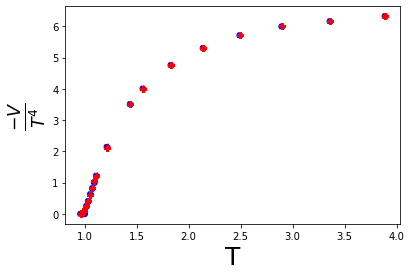

In [16]:
t = data[:, :1]
sd_val = sd_md(t, training=False)
mg_val = mg_md(t, training=False)
model_val = potential.v_qcd(t, mg_val, sd_val)
model_val = -1 * model_val / tf.math.pow(t, 4)

v_real = data[:, 1:]

plt.scatter(t, model_val, linestyle='dashdot', c='blue', marker='o', label='Model')
plt.scatter(t, v_real, c='red',marker='P',  label='Data')
plt.ylabel(r"$\frac{-V}{T^4}$", fontsize=25)
plt.xlabel("T", fontsize=25)

plt.show()

In [17]:
t_test =  tf.expand_dims(tf.range(1, 4, 0.0001, dtype=tf.float64), axis=-1)
 # tf.random.uniform([128, 1], 1, 4)
sd_value = sd_md(t_test, training=False)

plt.plot(t_test, sd_value, c='red',  label='Data')
plt.ylabel(r"$sd(\rm T)$", fontsize=25)
plt.xlabel("T", fontsize=25)
# plt.ylim(10, 100)
# plt.xlim(0.8, 1)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

In [38]:
sd_func = np.concatenate([t_test, sd_value], axis=-1)
np.savetxt("./qcd_6sd.dat", sd_func)

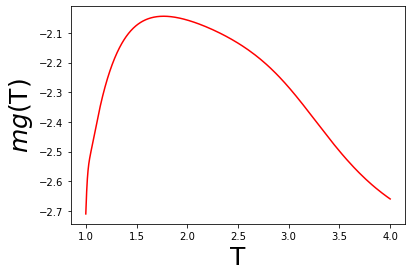

In [18]:
t_test = tf.expand_dims(tf.range(1, 4, 0.0001, dtype=tf.float64), axis=-1)
 # tf.random.uniform([128, 1], 1, 4)
mg_val = mg_md(t_test, training=False)

plt.plot(t_test, mg_val, c='red',  label='Data')
plt.ylabel(r"$mg(\rm T)$", fontsize=25)
plt.xlabel("T", fontsize=25)
# plt.ylim(10, 100)
# plt.xlim(0.8, 1)
# plt.yscale('log')
#plt.xscale('log')
#plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

In [40]:
mg_func = np.concatenate([t_test, mg_val], axis=-1)
np.savetxt("./qcd_6mg.dat", mg_func)

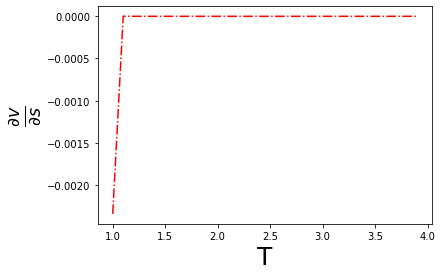

In [19]:
t_test = tf.expand_dims(tf.range(1, 4, 0.1, dtype=tf.float32), axis=-1)
with tf.GradientTape() as tape:
  sd_val = sd_md(t_test, training=False)
  tape.watch(sd_value)
  mg_val = mg_md(t_test, training=False)
  model_val = potential.v_qcd(t_test, mg_val, sd_val)
pvps = tape.gradient(model_val, sd_val)
# print(pvpl)

plt.plot(t_test, pvps, linestyle='dashdot', c='red', label='PandaX ')
plt.ylabel(r"$\frac{\partial v}{\partial s}$", fontsize=25)
plt.xlabel("T", fontsize=25)
# plt.ylim(10, 100)
# plt.xlim(0.8, 1)
# plt.yscale('log')
#plt.xscale('log')
#plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

In [66]:
t = tf.constant([[1.00]], dtype=DTYPE)
with tf.GradientTape() as tape:
    tape.watch(t)
    mg_val = mg_md(t, training=True)
    mg_val = tf.math.abs(mg_val)
dmg_dt = tape.gradient(mg_val, t)
print("m_g(T=1)={}, dm_g/dT(T=1)={}".format(mg_val, dmg_dt))

m_g(T=1)=[[2.7098997]], dm_g/dT(T=1)=[[-10.0965]]


In [61]:
mg_predict = tf.concat([mg_val, dmg_dt], 0)
loss_val = tf.math.reduce_sum(tf.math.abs((mg_predict - mg_value)))

In [62]:
print(tf.math.abs((mg_predict - mg_value)), mg_predict)

tf.Tensor(
[[0.08090591]
 [0.0134697 ]], shape=(2, 1), dtype=float32) tf.Tensor(
[[ 2.6689942]
 [11.533131 ]], shape=(2, 1), dtype=float32)


In [82]:
9*PI*4**4/90

<tf.Tensor: shape=(), dtype=float32, numpy=80.424774>

# check

In [102]:
p_test = QCDPotential(N, n_sample)
t = tf.ones([100, 1], dtype=DTYPE) * 4# tf.ones([100, 1], dtype=DTYPE) * 4
sd_test = sd_md(t, training=False)# sd_md(t, training=False)
mg_test = tf.reshape(tf.range(0, 10, 0.1), [-1, 1])# mg_md(t, training=False) # mg_md(t, training=False)
model_test = p_test.v_qcd(t, mg_test, sd_test)
model_test = -1 * model_test / tf.math.pow(t, 4)

In [103]:
plt.plot(mg_test, model_test, c='red',  label='Data')
plt.ylabel(r"v", fontsize=25)
plt.xlabel("mg", fontsize=25)
# plt.ylim(10, 100)
# plt.xlim(0.8, 1)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

In [91]:
model_test

<tf.Tensor: shape=(18, 1), dtype=float32, numpy=
array([[  28.705873 ],
       [  23.3678   ],
       [  18.659077 ],
       [  14.697327 ],
       [  11.156727 ],
       [   7.774147 ],
       [   6.7138696],
       [   6.277908 ],
       [   5.8002377],
       [   6.591371 ],
       [  21.622818 ],
       [  34.52138  ],
       [  80.67993  ],
       [ 185.31296  ],
       [ 402.36603  ],
       [ 837.2328   ],
       [1679.8265   ],
       [3279.543    ]], dtype=float32)>

In [92]:
t

<tf.Tensor: shape=(18, 1), dtype=float32, numpy=
array([[0.963316  ],
       [0.98162675],
       [0.9999513 ],
       [1.0182481 ],
       [1.0365449 ],
       [1.0574526 ],
       [1.0757424 ],
       [1.0940253 ],
       [1.1149399 ],
       [1.2168812 ],
       [1.4391578 ],
       [1.562111  ],
       [1.8316125 ],
       [2.1404226 ],
       [2.4937563 ],
       [2.896849  ],
       [3.3601718 ],
       [3.8889399 ]], dtype=float32)>